# Описание проекта

Собраны исторические данные о коэф. отработанного времени сотрудников (KOTR). Необходимо построить модель для предсказания KOTR на следующий месяц для сотрудников каждого разряда в каждом подразделении на каждой территории.


## Описание данных

<b>Территория</b> - условный номер территории на которой работает сотрудник

<b>Федеральный округ</b> - федеральный округ территории. Одна территория может относится к двум ФО - в поле эти ФО записаны через '+'

<b>year, month</b>  - год и месяц наблюдения

<b>Подразделение</b> -  условный номер подразделения сотрудника

<b>Разряд</b> - условный уровень должности сотрудника

<b>pers_id</b> - идентификатор сотрудника

<b>KOTR</b>  - коэффициент отработанного времени. Рассчитывается как отношние фактического рабочего времени к плановому рабочему времени. Является целевой переменной

## План работы:
<a href='#step_1'>Шаг 1. Получение общей информации и подготвка данных.</a><br>
На первом этапе импортируем необходимые библиотеки и читаем файл, знакомимся с общей информацией, выставляем необходимые типы данных, проверяем пропуски, аномальные значения.<br>
<a href='#step_2'>Шаг 2. Написание функций для работы с временными рядами по определенным разрядам.</a><br>
Определение и кодирование необходимых фукнций для выделения и преобразования данных по определенному разряду.<br>
<a href='#step_3'>Шаг 3. Написание функций для обучения моделей машинного обучения.</a><br>
Кодирование фукнций обучения моделей и предсказания.<br>
<a href='#step_4'>Шаг 4. Тестирование моделей. </a><br>
Сравнение результатов работы моделей. Проведение различных экспериментов с параметрами обучения.<br>
<a href='#step_5'>Шаг 5. Общий вывод.</a><br>

# Получение общей информации и подготвка данных

### План работы:
<a href='#step_1'>Шаг 1. Получение общей информации и подготвка данных.</a><br>
<a href='#step_2'>Шаг 2. Написание функций для работы с временными рядами по определенным разрядам.</a><br>
<a href='#step_3'>Шаг 3. Написание функций для обучения моделей машинного обучения.</a><br>
<a href='#step_4'>Шаг 4. Тестирование моделей. </a><br>
<a href='#step_5'>Шаг 5. Общий вывод.</a><br>

<a id ='step_1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from catboost import CatBoostRegressor, Pool
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from sklearn.utils import shuffle
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings("ignore")

In [2]:
raw_df=pd.read_excel('kotr_df.xlsx')
raw_df.drop(columns='Unnamed: 0', axis=1, inplace=True)
raw_df.head()

,Территория,Федеральный округ,Подразделение,Разряд,pers_id,repdate,KOTR
0,5,Южный + Северо-Кавказский,28,7,48623,2020-12-31,0.244094
1,1,г.Москва,46,12,19891,2020-12-31,1.000000
2,1,г.Москва,46,12,19892,2020-12-31,0.830601
3,1,г.Москва,46,12,19893,2020-12-31,1.000000
4,1,г.Москва,46,12,19894,2020-12-31,1.000000


In [3]:
raw_df.duplicated().sum()

1

In [4]:
raw_df.drop_duplicates(inplace = True)

In [5]:
raw_df.set_index('repdate', inplace = True)
raw_df = raw_df.sort_index()

In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 909716 entries, 2017-01-31 to 2020-12-31
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Территория         909716 non-null  int64  
 1   Федеральный округ  909716 non-null  object 
 2   Подразделение      909716 non-null  int64  
 3   Разряд             909716 non-null  int64  
 4   pers_id            909716 non-null  int64  
 5   KOTR               909716 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 48.6+ MB


Данные с января 2017 - декабрь 2020

In [7]:
raw_df.describe()

,Территория,Подразделение,Разряд,pers_id,KOTR
count,909716.000000,909716.000000,909716.000000,909716.000000,909716.000000
mean,6.681867,24.973194,16.450931,41409.365207,0.842129
std,3.523747,6.576856,23.505430,24070.378495,0.222941
min,1.000000,0.000000,7.000000,0.000000,0.100251
25%,3.000000,22.000000,9.000000,19831.750000,0.714286
50%,7.000000,23.000000,9.000000,40485.000000,1.000000
75%,9.000000,30.000000,12.000000,62560.000000,1.000000
max,13.000000,46.000000,99.000000,84141.000000,3.000000


Странные максимумы у разряда и KOTR

удалим выдающиеся значения, KOTR > 1 быть не может

In [8]:
raw_df[raw_df['KOTR'] > 1].head()

,Территория,Федеральный округ,Подразделение,Разряд,pers_id,KOTR
repdate,,,,,,
2017-01-31,5,Южный + Северо-Кавказский,23,12,46882,1.058824
2017-01-31,6,Приволжский,22,9,54669,1.044118
2017-01-31,6,Приволжский,22,9,54745,1.058824
2017-01-31,6,Приволжский,22,9,54737,1.058824
2017-01-31,6,Приволжский,22,9,54727,1.044118


In [9]:
10427  / len(raw_df)

0.011461818853356433

Почти 1% данных с некорректной фичой, можно удалить без потери качества.

In [10]:
raw_df = raw_df[raw_df['KOTR'] <= 1]

In [11]:
len(raw_df) + 10427

909716

Проверка разряда на корректность

In [12]:
raw_df['Разряд'].unique()

array([12,  9, 14, 20,  7, 99])

In [13]:
def mean_kotr_by_rank(rank):
    print(rank,'-', raw_df[raw_df['Разряд'] == rank]['KOTR'].mean())

for i in raw_df['Разряд'].unique():
    mean_kotr_by_rank(i)

12 - 0.8547499793229838
9 - 0.8260061086100564
14 - 0.8844966421953505
20 - 0.8983852301781633
7 - 0.8089101620630703
99 - 0.9014855466997973


работники 99 разряда в среднем находятся на рабочем месте больше, чем остальные, 9 - меньше.

кол-во разрядов 6, эти данные в порядке.

<p style = 'background-color: red'>&#4448;

ОДИНАКОВЫЙ ID У РАЗНЫХ ПОДРАЗДЕЛЕНИЙ

Откуда могут возникнуть такие артефакты?

данных очень мало, не критично их пропустить, но лучше узнать откуда они могут взяться

У одного Id 2 подразделения, 2 зп<br>
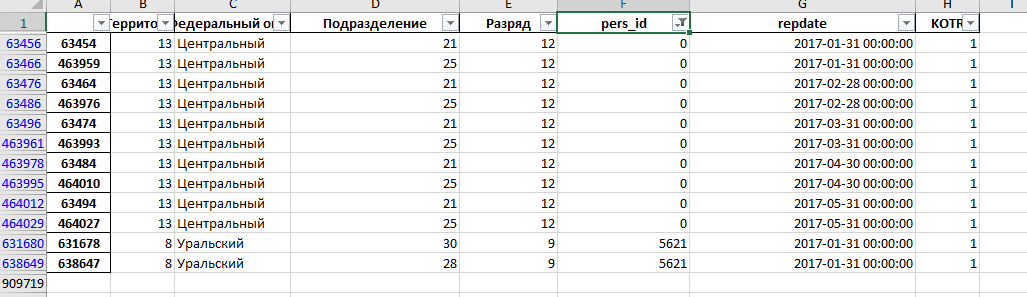

<p style = 'background-color: red'>&#4448;

Поменяем разные цифры одинаковых территорий

In [14]:
len(raw_df['Территория'].unique())

12

In [15]:
len(raw_df['Федеральный округ'].unique())

8

Одинаковые округа обозначены разными цифрами

In [16]:
for i in raw_df['Территория'].unique():
    print('территория = ', i)
    print(raw_df[raw_df['Территория'] == i]['Федеральный округ'].unique())
    print()

территория =  6
['Приволжский']

территория =  1
['г.Москва']

территория =  9
['Сибирский']

территория =  5
['Южный + Северо-Кавказский']

территория =  11
['Дальневосточный']

территория =  3
['Северо-Западный']

территория =  2
['Центральный']

территория =  8
['Уральский']

территория =  10
['Дальневосточный']

территория =  13
['Центральный']

территория =  7
['Приволжский']

территория =  12
['г.Москва']



Москва = 1/12, Приволжский - 6/7, Центральный - 2/13, Дальневосточный - 10/11 

In [17]:
raw_df['Территория'].replace([12,7,13,11], [1,6,2,10], inplace = True)

In [18]:
len(raw_df['Территория'].unique())

8

Удалим столбец с фед. округами, так как есть фича номер териитории

In [19]:
raw_df.drop('Федеральный округ', axis = 1, inplace = True)

In [20]:
raw_df.reset_index(inplace = True)
raw_df

,repdate,Территория,Подразделение,Разряд,pers_id,KOTR
0,2017-01-31,6,23,12,55067,1.000000
1,2017-01-31,1,33,9,15668,0.764706
2,2017-01-31,1,33,9,15669,0.500000
3,2017-01-31,1,33,9,15670,1.000000
4,2017-01-31,1,33,9,15671,1.000000
...,...,...,...,...,...,...
899284,2020-12-31,8,33,12,10800,1.000000
899285,2020-12-31,8,33,12,6477,0.830601
899286,2020-12-31,8,33,12,6047,1.000000
899287,2020-12-31,8,33,12,8324,0.612022


# Написание функций для работы с временными рядами по определенным разрядам

### План работы:
<a href='#step_1'>Шаг 1. Получение общей информации и подготвка данных.</a><br>
<a href='#step_2'>Шаг 2. Написание функций для работы с временными рядами по определенным разрядам.</a><br>
<a href='#step_3'>Шаг 3. Написание функций для обучения моделей машинного обучения.</a><br>
<a href='#step_4'>Шаг 4. Тестирование моделей. </a><br>
<a href='#step_5'>Шаг 5. Общий вывод.</a><br>

<a id ='step_2'></a>

ГРУППИРОВКА ПО ТЕРРИТОРИИ, ПОДРАЗДЕЛЕНИЮ, РАЗРЯДУ, ДАТЕ с добавлением количества сотрудников в разряде в месяце (вряд ли кол-во сотрудников в подразделении/территории может сильно влиять на разряд, создавать несколько фичей нет смысла - они линейно зависимы)

In [21]:
group_by_ranks = pd.pivot_table(raw_df,
                                index = ['Территория','Подразделение', 'Разряд','repdate'],
                                values = 'KOTR',
                                aggfunc= 'mean')
group_by_ranks['count_pers_in_month'] = raw_df.groupby(['Территория', 'Подразделение',
                                           'Разряд', 'repdate'])['pers_id'].count().reset_index()['pers_id'].values

In [22]:
group_by_ranks.reset_index(inplace = True)
group_by_ranks

,Территория,Подразделение,Разряд,repdate,KOTR,count_pers_in_month
0,1,0,99,2019-01-31,0.921250,223
1,1,0,99,2019-02-28,0.932864,258
2,1,0,99,2019-03-31,0.900464,259
3,1,0,99,2019-04-30,0.915691,270
4,1,0,99,2019-05-31,0.919472,318
...,...,...,...,...,...,...
15068,10,37,12,2020-08-31,0.831169,11
15069,10,37,12,2020-09-30,0.789256,11
15070,10,37,12,2020-10-31,0.904959,11
15071,10,37,12,2020-11-30,0.859748,10


Таблица ВРЕМЕННОГО РЯДА ДЛЯ x РАЗРЯДА В y ПОДРАЗДЕЛЕНИИ НА z ТЕРРИТОРИИ

In [23]:
def plot_ter_sub_rank_KOTR(ter,sub,rank):
    a,b,c = ter,sub,rank
    grouped_df = group_by_ranks.query('Территория == @a and \
                          Подразделение == @b and \
                          Разряд == @c').copy()
    grouped_df = grouped_df[['repdate', 'KOTR', 'count_pers_in_month']].set_index('repdate')
    return grouped_df

In [24]:
test_df = plot_ter_sub_rank_KOTR(3,27,14)

In [25]:
test_df

,KOTR,count_pers_in_month
repdate,,
2017-01-31,1.000000,2
2017-02-28,0.863636,2
2017-03-31,1.000000,2
2017-04-30,1.000000,2
2017-05-31,0.900000,2
2017-06-30,0.952381,2
2017-07-31,0.809524,2
2017-08-31,1.000000,2
2017-09-30,0.642857,2


Функция создания lag'ов и скользящего среднего по данным, на которых модель будет обучаться

In [26]:
def create_shift(dataframe, lag, num_roll):
    new_dataframe = dataframe.copy()
    new_dataframe['year'] = new_dataframe.index.year
    new_dataframe['month'] = new_dataframe.index.month
    for i in range(1, lag + 1):
        new_dataframe['lag_{}'.format(i)] = new_dataframe['KOTR'].shift(i)
    new_dataframe['rolling_mean'] = new_dataframe['KOTR'].shift().rolling(num_roll).mean()
    new_dataframe = new_dataframe.dropna()
    return new_dataframe

В проекте длина lag'а взята равной сезонности - 12.

In [27]:
new_raw_df = create_shift(test_df, 12, 2)

In [28]:
new_raw_df

,KOTR,count_pers_in_month,year,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
repdate,,,,,,,,,,,,,,,,,
2018-01-31,1.000000,2,2018,1,1.000000,1.000000,0.954545,0.642857,1.000000,0.809524,0.952381,0.900000,1.000000,1.000000,0.863636,1.000000,1.000000
2018-02-28,1.000000,1,2018,2,1.000000,1.000000,1.000000,0.954545,0.642857,1.000000,0.809524,0.952381,0.900000,1.000000,1.000000,0.863636,1.000000
2018-03-31,0.955975,1,2018,3,1.000000,1.000000,1.000000,1.000000,0.954545,0.642857,1.000000,0.809524,0.952381,0.900000,1.000000,1.000000,1.000000
2018-04-30,1.000000,1,2018,4,0.955975,1.000000,1.000000,1.000000,1.000000,0.954545,0.642857,1.000000,0.809524,0.952381,0.900000,1.000000,0.977987
2018-05-31,0.899371,1,2018,5,1.000000,0.955975,1.000000,1.000000,1.000000,1.000000,0.954545,0.642857,1.000000,0.809524,0.952381,0.900000,0.977987
2018-06-30,0.748428,1,2018,6,0.899371,1.000000,0.955975,1.000000,1.000000,1.000000,1.000000,0.954545,0.642857,1.000000,0.809524,0.952381,0.949686
2018-07-31,0.590909,1,2018,7,0.748428,0.899371,1.000000,0.955975,1.000000,1.000000,1.000000,1.000000,0.954545,0.642857,1.000000,0.809524,0.823899
2018-08-31,0.434783,1,2018,8,0.590909,0.748428,0.899371,1.000000,0.955975,1.000000,1.000000,1.000000,1.000000,0.954545,0.642857,1.000000,0.669668
2019-04-30,1.000000,1,2019,4,0.434783,0.590909,0.748428,0.899371,1.000000,0.955975,1.000000,1.000000,1.000000,1.000000,0.954545,0.642857,0.512846


# Функции обучения моделей и предсказания

### План работы:
<a href='#step_1'>Шаг 1. Получение общей информации и подготвка данных.</a><br>
<a href='#step_2'>Шаг 2. Написание функций для работы с временными рядами по определенным разрядам.</a><br>
<a href='#step_3'>Шаг 3. Написание функций для обучения моделей машинного обучения.</a><br>
<a href='#step_4'>Шаг 4. Тестирование моделей. </a><br>
<a href='#step_5'>Шаг 5. Общий вывод.</a><br>

<a id = step_3></a>

Функции для различных моделей градиентного бустинга. Шаги функции:<br><ul>
    <li>1) разделение данных</li>
    <li>2) создание и обучение модели</li>
    <li>3) проход цикла по предсказанию первых 10 месяцев с пошаговым добавлением данных из тестового для будущих предсказаний (не 12, т.к. модели требует минимум 2 сэмла для предсказания). После добавления модель обучается заново.</li>
    <li>4) проход цикла по последним 2 месяцам по той же технике</li>
</ul>

In [29]:
def spliting_training_prediction_catboost(df):
    # список с предсказаниями модели
    preds=[]

    new_df = df.copy()
    train, test = new_df[:'2019-12'], new_df['2020-01':]
    target_train, target_test = train['KOTR'], test['KOTR']
    features_train, features_test = train.drop('KOTR', axis= 1), test.drop('KOTR', axis= 1)
    cat_features = features_train[['year', 'month']]
    model_catboost = CatBoostRegressor(iterations = 40,
                                       verbose= 300,
                                       depth = 3,
                                       learning_rate = 0.1)
    model_catboost.fit(features_train, target_train, cat_features=cat_features)

    # из-за специфики метода predict необходимо подавать минимум 2 сэмпла для предсказания,
    # поэтому для последних 2 сэмплов отдельный цикл
    # предсказания для первых 10 месяцев
    for i in range(1, len(features_test)-1):
        data_pred = features_test.iloc[i-1:i+1].copy()
        pred = model_catboost.predict(data_pred)
        preds.append(pred[0])
        new_row_kotr = features_test.iloc[i-1]
        features_train.loc[features_train.index.max() + np.timedelta64(1, 'M')] = new_row_kotr
        features_train = features_train.astype({'year' : 'int', 'month' :'int'})
        new_row_kotr_target = target_test.iloc[i-1]
        target_train.loc[target_train.index.max() + np.timedelta64(1, 'M')] = new_row_kotr_target
        model_catboost.fit(features_train, target_train, cat_features=cat_features)
    
    
    # предсказания для последних 2 месяцев
    for j in range(-2,0):
        data_pred = features_test.iloc[j:].copy()
        pred = model_catboost.predict(data_pred)
        preds.append(pred[0])
        new_row_kotr = features_test.iloc[j]
        features_train.loc[features_train.index.max() + np.timedelta64(1, 'M')] = new_row_kotr
        features_train = features_train.astype({'year' : 'int', 'month' :'int'})        
        new_row_kotr_target = target_test.iloc[j]
        target_train.loc[target_train.index.max() + np.timedelta64(1, 'M')] = new_row_kotr_target
        model_catboost.fit(features_train, target_train, cat_features=cat_features)
    return preds

In [30]:
def spliting_training_prediction_lgbm(df):
    # список с предсказаниями модели
    preds=[]
    
    new_df = df.copy()
    new_df = new_df.astype({'year' : 'category', 'month' :'category'})
    train, test = new_df[:'2019-12'], new_df['2020-01':]
    target_train, target_test = train['KOTR'], test['KOTR']
    features_train, features_test = train.drop('KOTR', axis= 1), test.drop('KOTR', axis= 1)
    model_lgbm = LGBMRegressor(iterations = 40,
                               max_depth = 3,
                               learning_rate = 0.1,
                               eval_metric = 'mae')

    model_lgbm.fit(features_train, target_train)
    
    # из-за специфики метода predict необходимо подавать минимум 2 сэмпла для предсказания,
    # поэтому для последних 2 сэмплов отдельный цикл
    # предсказания для первых 10 месяцев
    for i in range(1, len(features_test)-1):
        data_pred = features_test.iloc[i-1:i+1].copy()    
        pred = model_lgbm.predict(data_pred)
        preds.append(pred[0])
        new_row_kotr = features_test.iloc[i-1]
        features_train.loc[features_train.index.max() + np.timedelta64(1, 'M')] = new_row_kotr
        features_train = features_train.astype({'year' : 'category', 'month' :'category'})
        new_row_kotr_target = target_test.iloc[i-1]
        target_train.loc[target_train.index.max() + np.timedelta64(1, 'M')] = new_row_kotr_target
        model_lgbm.fit(features_train, target_train)
    
    # предсказания для последних 2 месяцев
    for j in range(-2,0):
        data_pred = features_test.iloc[j:].copy()
        pred = model_lgbm.predict(data_pred)
        preds.append(pred[0])
        new_row_kotr = features_test.iloc[j]
        features_train.loc[features_train.index.max() + np.timedelta64(1, 'M')] = new_row_kotr
        features_train = features_train.astype({'year' : 'category', 'month' :'category'})
        new_row_kotr_target = target_test.iloc[j]
        target_train.loc[target_train.index.max() + np.timedelta64(1, 'M')] = new_row_kotr_target
        model_lgbm.fit(features_train, target_train)        
    return preds

In [31]:
def spliting_training_prediction_xgb(df):
    # список с предсказаниями модели
    preds=[]
    
    new_df = df.copy()
    new_df = new_df.astype({'year' : 'int', 'month' :'int'})
    train, test = new_df['2019-01':'2019-12'], new_df['2020-01':]
    target_train, target_test = train['KOTR'], test['KOTR']
    features_train, features_test = train.drop('KOTR', axis= 1), test.drop('KOTR', axis= 1)
    
    model_xgb = xgb.XGBRegressor(n_estimators = 40,
                                       max_depth = 3,
                                       learning_rate = 0.1,
                                objective ='reg:squarederror',
                                eval_metric = 'mae')
    model_xgb.fit(features_train, target_train)
    
    # из-за специфики метода predict необходимо подавать минимум 2 сэмпла для предсказания,
    # поэтому для последних 2 сэмплов отдельный цикл
    # предсказания для первых 10 месяцев
    for i in range(1, len(features_test)-1):
        data_pred = features_test.iloc[i-1:i+1].copy()   
        pred = model_xgb.predict(data_pred)
        preds.append(pred[0])
        new_row_kotr = features_test.iloc[i-1]
        features_train.loc[features_train.index.max() + np.timedelta64(1, 'M')] = new_row_kotr
        features_train = features_train.astype({'year' : 'int', 'month' :'int'})
        new_row_kotr_target = target_test.iloc[i-1]
        target_train.loc[target_train.index.max() + np.timedelta64(1, 'M')] = new_row_kotr_target
        model_xgb.fit(features_train, target_train)
    
    # предсказания для последних 2 месяцев
    for j in range(-2,0):
        data_pred = features_test.iloc[j:].copy()
        pred = model_xgb.predict(data_pred)
        preds.append(pred[0])
        new_row_kotr = features_test.iloc[j]
        features_train.loc[features_train.index.max() + np.timedelta64(1, 'M')] = new_row_kotr
        features_train = features_train.astype({'year' : 'int', 'month' :'int'})
        new_row_kotr_target = target_test.iloc[j]
        target_train.loc[target_train.index.max() + np.timedelta64(1, 'M')] = new_row_kotr_target
        model_xgb.fit(features_train, target_train)        
    return preds

Переменная с всеми разрядами во всех подразделениях на всех территориях, необходима для удобного заполнения MAE по каждому разряду.

In [32]:
all_categories = pd.pivot_table(raw_df,
                                index = ['Территория','Подразделение', 'Разряд'],
                                ).reset_index().drop(['KOTR', 'pers_id'], axis = 1)

# Тестирование моделей

### План работы:
<a href='#step_1'>Шаг 1. Получение общей информации и подготвка данных.</a><br>
<a href='#step_2'>Шаг 2. Написание функций для работы с временными рядами по определенным разрядам.</a><br>
<a href='#step_3'>Шаг 3. Написание функций для обучения моделей машинного обучения.</a><br>
<a href='#step_4'>Шаг 4. Тестирование моделей. </a><br>
<a href='#step_5'>Шаг 5. Общий вывод.</a><br>

<a id ='step_4'></a>

Создаются 2 списка: первый для записи предсказаний MAE, второй для записи предсказаний значений модели по каждому месяцу (возможно необходимо для будущих работ, пока не используется)

Максимальная длина фрейма 357, вывод показывает  сколько строк с разрядами смогла обработать модель и средний MAE по ним.

Забегая вперед - будет выбрана модель градиентного бустинга CatBoost по причине лучших предсказаний

In [33]:
mae_predictions_lgbm = []
lgbm_predicts = []

for x,y,z in tqdm(zip(all_categories['Территория'], all_categories['Подразделение'], all_categories['Разряд'])):
    test_df = plot_ter_sub_rank_KOTR(x,y,z)
    new_test_df = create_shift(test_df, 12, 3)
    try:
        lgbm_predict = spliting_training_prediction_lgbm(new_test_df)
        lgbm_predicts.append(lgbm_predict)
        test = new_test_df['2020-01':]
        target_test = test['KOTR']
        mae_predictions_lgbm.append(mean_absolute_error(target_test, lgbm_predict))
    except:
        lgbm_predicts.append(0)
        mae_predictions_lgbm.append('error')
mae_lgbm = all_categories.copy()
mae_lgbm['MAE'] = mae_predictions_lgbm

print('длина фрейма =',len(mae_lgbm[mae_lgbm['MAE'] != 'error']),
      'сред. mae =', mae_lgbm[mae_lgbm['MAE'] != 'error']['MAE'].mean())

357it [5:02:33, 50.85s/it] 

длина фрейма = 346 сред. mae = 0.07908905092477586


In [34]:
mae_predictions_xgb = []
xgb_predicts = []
for x,y,z in tqdm(zip(all_categories['Территория'], all_categories['Подразделение'], all_categories['Разряд'])):
    test_df = plot_ter_sub_rank_KOTR(x,y,z)
    new_test_df = create_shift(test_df, 12, 3)
    try:
        xgb_predict = spliting_training_prediction_xgb(new_test_df)
        xgb_predicts.append(xgb_predict)
        test = new_test_df['2020-01':]
        target_test = test['KOTR']
        mae_predictions_xgb.append(mean_absolute_error(target_test, xgb_predict))
    except:
        xgb_predicts.append(0)
        mae_predictions_xgb.append('error')
mae_xgb = all_categories.copy()
mae_xgb['MAE'] = mae_predictions_xgb

print('длина фрейма =',len(mae_xgb[mae_xgb['MAE'] != 'error']),
      'сред. mae =', mae_xgb[mae_xgb['MAE'] != 'error']['MAE'].mean())

357it [00:49,  7.15it/s]

длина фрейма = 304 сред. mae = 0.08237040471845618


In [35]:
mae_predictions_catboost = []
catboost_predicts =[]

for x,y,z in tqdm(zip(all_categories['Территория'], all_categories['Подразделение'], all_categories['Разряд'])):
    test_df = plot_ter_sub_rank_KOTR(x,y,z)
    new_test_df = create_shift(test_df, 12, 3)
    try:
        catboost_predict = spliting_training_prediction_catboost(new_test_df)
        catboost_predicts.append(catboost_predict)
        test = new_test_df['2020-01':]
        target_test = test['KOTR']
        mae_predictions_catboost.append(mean_absolute_error(target_test, catboost_predict))
    except:
        catboost_predicts.append(0)
        mae_predictions_catboost.append('error')
mae_catboost = all_categories.copy()
mae_catboost['MAE'] = mae_predictions_catboost
print('длина фрейма =',len(mae_catboost[mae_catboost['MAE'] != 'error']),
      'сред. mae =', mae_catboost[mae_catboost['MAE'] != 'error']['MAE'].mean())

13it [00:00, 60.42it/s]

0:	learn: 0.0405413	total: 46.7ms	remaining: 1.82s
39:	learn: 0.0165881	total: 117ms	remaining: 0us
0:	learn: 0.0393311	total: 485us	remaining: 18.9ms
39:	learn: 0.0186203	total: 18.6ms	remaining: 0us
0:	learn: 0.0389770	total: 492us	remaining: 19.2ms
39:	learn: 0.0185867	total: 21ms	remaining: 0us
0:	learn: 0.0388357	total: 535us	remaining: 20.9ms
39:	learn: 0.0168027	total: 11.8ms	remaining: 0us
0:	learn: 0.0401169	total: 559us	remaining: 21.8ms
39:	learn: 0.0171184	total: 14.8ms	remaining: 0us
0:	learn: 0.0402580	total: 557us	remaining: 21.7ms
39:	learn: 0.0197324	total: 19.5ms	remaining: 0us
0:	learn: 0.0419025	total: 547us	remaining: 21.3ms
39:	learn: 0.0226819	total: 9.95ms	remaining: 0us
0:	learn: 0.0447194	total: 533us	remaining: 20.8ms
39:	learn: 0.0251433	total: 29.5ms	remaining: 0us
0:	learn: 0.0450283	total: 555us	remaining: 21.7ms
39:	learn: 0.0265380	total: 10.7ms	remaining: 0us
0:	learn: 0.0439480	total: 506us	remaining: 19.7ms
39:	learn: 0.0265389	total: 14.8ms	remainin

17it [00:10,  1.26it/s]

0:	learn: 0.0735962	total: 450us	remaining: 17.6ms
39:	learn: 0.0340028	total: 14.1ms	remaining: 0us
0:	learn: 0.0717041	total: 485us	remaining: 18.9ms
39:	learn: 0.0405062	total: 14.2ms	remaining: 0us
0:	learn: 0.0705728	total: 458us	remaining: 17.9ms
39:	learn: 0.0369272	total: 15.6ms	remaining: 0us
0:	learn: 0.0713488	total: 552us	remaining: 21.6ms
39:	learn: 0.0413814	total: 9.43ms	remaining: 0us
0:	learn: 0.0708349	total: 521us	remaining: 20.3ms
39:	learn: 0.0419654	total: 14.4ms	remaining: 0us
0:	learn: 0.0712093	total: 517us	remaining: 20.2ms
39:	learn: 0.0338606	total: 15.2ms	remaining: 0us
0:	learn: 0.0697263	total: 767us	remaining: 29.9ms
39:	learn: 0.0344224	total: 14.7ms	remaining: 0us
0:	learn: 0.0711389	total: 473us	remaining: 18.5ms
39:	learn: 0.0356536	total: 36.5ms	remaining: 0us
0:	learn: 0.0698951	total: 496us	remaining: 19.4ms
39:	learn: 0.0377343	total: 118ms	remaining: 0us
0:	learn: 0.0681507	total: 463us	remaining: 18.1ms
39:	learn: 0.0361997	total: 23.7ms	remain

18it [00:21,  3.93s/it]

0:	learn: 0.0254114	total: 1.67ms	remaining: 65.1ms
39:	learn: 0.0091770	total: 80.1ms	remaining: 0us
0:	learn: 0.0252241	total: 467us	remaining: 18.3ms
39:	learn: 0.0098439	total: 26.1ms	remaining: 0us
0:	learn: 0.0249657	total: 457us	remaining: 17.9ms
39:	learn: 0.0103373	total: 14.2ms	remaining: 0us
0:	learn: 0.0248268	total: 484us	remaining: 18.9ms
39:	learn: 0.0093114	total: 144ms	remaining: 0us
0:	learn: 0.0253499	total: 1.43ms	remaining: 55.8ms
39:	learn: 0.0097678	total: 25.2ms	remaining: 0us
0:	learn: 0.0272777	total: 739us	remaining: 28.9ms
39:	learn: 0.0110827	total: 28.3ms	remaining: 0us
0:	learn: 0.0285575	total: 1.35ms	remaining: 52.6ms
39:	learn: 0.0111271	total: 160ms	remaining: 0us
0:	learn: 0.0316936	total: 521us	remaining: 20.4ms
39:	learn: 0.0122045	total: 26.7ms	remaining: 0us
0:	learn: 0.0325907	total: 489us	remaining: 19.1ms
39:	learn: 0.0115803	total: 9.15ms	remaining: 0us
0:	learn: 0.0339832	total: 536us	remaining: 20.9ms
39:	learn: 0.0120843	total: 9.07ms	rema

19it [00:32,  6.02s/it]

0:	learn: 0.0246810	total: 439us	remaining: 17.1ms
39:	learn: 0.0088007	total: 8.42ms	remaining: 0us
0:	learn: 0.0243354	total: 525us	remaining: 20.5ms
39:	learn: 0.0093025	total: 8.97ms	remaining: 0us
0:	learn: 0.0238157	total: 454us	remaining: 17.7ms
39:	learn: 0.0086665	total: 27.5ms	remaining: 0us
0:	learn: 0.0235000	total: 455us	remaining: 17.8ms
39:	learn: 0.0086312	total: 14ms	remaining: 0us
0:	learn: 0.0229598	total: 787us	remaining: 30.7ms
39:	learn: 0.0089522	total: 11.5ms	remaining: 0us
0:	learn: 0.0238902	total: 494us	remaining: 19.3ms
39:	learn: 0.0097201	total: 8.66ms	remaining: 0us
0:	learn: 0.0245070	total: 545us	remaining: 21.3ms
39:	learn: 0.0089649	total: 15.1ms	remaining: 0us
0:	learn: 0.0273539	total: 497us	remaining: 19.4ms
39:	learn: 0.0095073	total: 29.3ms	remaining: 0us
0:	learn: 0.0280728	total: 539us	remaining: 21ms
39:	learn: 0.0101363	total: 30.6ms	remaining: 0us
0:	learn: 0.0282176	total: 1.01ms	remaining: 39.4ms
39:	learn: 0.0099658	total: 122ms	remaining

20it [00:44,  7.57s/it]

0:	learn: 0.0268617	total: 453us	remaining: 17.7ms
39:	learn: 0.0098690	total: 25.3ms	remaining: 0us
0:	learn: 0.0267494	total: 462us	remaining: 18ms
39:	learn: 0.0095105	total: 10.1ms	remaining: 0us
0:	learn: 0.0268664	total: 481us	remaining: 18.8ms
39:	learn: 0.0105530	total: 9.38ms	remaining: 0us
0:	learn: 0.0263074	total: 460us	remaining: 18ms
39:	learn: 0.0101161	total: 30.6ms	remaining: 0us
0:	learn: 0.0261728	total: 483us	remaining: 18.8ms
39:	learn: 0.0115462	total: 8.71ms	remaining: 0us
0:	learn: 0.0276958	total: 508us	remaining: 19.8ms
39:	learn: 0.0122692	total: 9.44ms	remaining: 0us
0:	learn: 0.0283555	total: 587us	remaining: 22.9ms
39:	learn: 0.0125192	total: 14.7ms	remaining: 0us
0:	learn: 0.0336668	total: 491us	remaining: 19.2ms
39:	learn: 0.0178832	total: 17.9ms	remaining: 0us
0:	learn: 0.0359375	total: 460us	remaining: 17.9ms
39:	learn: 0.0148896	total: 9.16ms	remaining: 0us
0:	learn: 0.0354290	total: 532us	remaining: 20.8ms
39:	learn: 0.0146827	total: 22.3ms	remaining

21it [00:54,  8.44s/it]

0:	learn: 0.0630395	total: 437us	remaining: 17ms
39:	learn: 0.0300213	total: 24.4ms	remaining: 0us
0:	learn: 0.0743661	total: 495us	remaining: 19.3ms
39:	learn: 0.0410531	total: 27.9ms	remaining: 0us
0:	learn: 0.0750875	total: 450us	remaining: 17.6ms
39:	learn: 0.0345416	total: 28ms	remaining: 0us
0:	learn: 0.0738168	total: 458us	remaining: 17.9ms
39:	learn: 0.0424348	total: 14.3ms	remaining: 0us
0:	learn: 0.0737923	total: 472us	remaining: 18.4ms
39:	learn: 0.0411898	total: 37ms	remaining: 0us
0:	learn: 0.0733191	total: 467us	remaining: 18.2ms
39:	learn: 0.0425328	total: 9.43ms	remaining: 0us
0:	learn: 0.0726212	total: 511us	remaining: 19.9ms
39:	learn: 0.0400190	total: 22.8ms	remaining: 0us
0:	learn: 0.0736999	total: 552us	remaining: 21.6ms
39:	learn: 0.0413739	total: 10.4ms	remaining: 0us
0:	learn: 0.0762036	total: 525us	remaining: 20.5ms
39:	learn: 0.0428594	total: 8.79ms	remaining: 0us
0:	learn: 0.0753058	total: 814us	remaining: 31.8ms
39:	learn: 0.0443923	total: 16.4ms	remaining: 

22it [01:04,  9.00s/it]

0:	learn: 0.1363590	total: 761us	remaining: 29.7ms
39:	learn: 0.0422374	total: 45.1ms	remaining: 0us
0:	learn: 0.1393852	total: 514us	remaining: 20.1ms
39:	learn: 0.0483144	total: 96.9ms	remaining: 0us
0:	learn: 0.1379791	total: 539us	remaining: 21ms
39:	learn: 0.0459898	total: 14.3ms	remaining: 0us
0:	learn: 0.1355555	total: 723us	remaining: 28.2ms
39:	learn: 0.0449976	total: 25ms	remaining: 0us
0:	learn: 0.1354674	total: 567us	remaining: 22.1ms
39:	learn: 0.0575435	total: 9.92ms	remaining: 0us
0:	learn: 0.1339946	total: 512us	remaining: 20ms
39:	learn: 0.0455700	total: 8.63ms	remaining: 0us
0:	learn: 0.1305728	total: 451us	remaining: 17.6ms
39:	learn: 0.0531566	total: 8.14ms	remaining: 0us
0:	learn: 0.1301344	total: 460us	remaining: 18ms
39:	learn: 0.0492479	total: 8.81ms	remaining: 0us
0:	learn: 0.1278843	total: 464us	remaining: 18.1ms
39:	learn: 0.0500721	total: 22.5ms	remaining: 0us
0:	learn: 0.1258354	total: 589us	remaining: 23ms
39:	learn: 0.0507687	total: 9.87ms	remaining: 0us


23it [01:17, 10.21s/it]

0:	learn: 0.0501043	total: 925us	remaining: 36.1ms
39:	learn: 0.0234074	total: 64.8ms	remaining: 0us
0:	learn: 0.0512250	total: 573us	remaining: 22.4ms
39:	learn: 0.0226577	total: 184ms	remaining: 0us
0:	learn: 0.0516518	total: 510us	remaining: 19.9ms
39:	learn: 0.0253866	total: 33.1ms	remaining: 0us
0:	learn: 0.0497517	total: 475us	remaining: 18.5ms
39:	learn: 0.0256394	total: 9.35ms	remaining: 0us
0:	learn: 0.0493796	total: 502us	remaining: 19.6ms
39:	learn: 0.0214161	total: 14.2ms	remaining: 0us
0:	learn: 0.0484435	total: 1.44ms	remaining: 56.2ms
39:	learn: 0.0232369	total: 136ms	remaining: 0us
0:	learn: 0.0488589	total: 469us	remaining: 18.3ms
39:	learn: 0.0236748	total: 24.5ms	remaining: 0us
0:	learn: 0.0515971	total: 1.25ms	remaining: 48.7ms
39:	learn: 0.0252399	total: 87.6ms	remaining: 0us
0:	learn: 0.0515107	total: 495us	remaining: 19.3ms
39:	learn: 0.0275829	total: 18.1ms	remaining: 0us
0:	learn: 0.0509839	total: 496us	remaining: 19.4ms
39:	learn: 0.0250030	total: 14.7ms	remai

24it [01:29, 10.51s/it]

0:	learn: 0.0391955	total: 470us	remaining: 18.4ms
39:	learn: 0.0180505	total: 7.92ms	remaining: 0us
0:	learn: 0.0391283	total: 479us	remaining: 18.7ms
39:	learn: 0.0214978	total: 14.3ms	remaining: 0us
0:	learn: 0.0383339	total: 468us	remaining: 18.3ms
39:	learn: 0.0241949	total: 14.8ms	remaining: 0us
0:	learn: 0.0393853	total: 489us	remaining: 19.1ms
39:	learn: 0.0226589	total: 9.02ms	remaining: 0us
0:	learn: 0.0440762	total: 436us	remaining: 17ms
39:	learn: 0.0235205	total: 22.6ms	remaining: 0us
0:	learn: 0.0445335	total: 613us	remaining: 23.9ms
39:	learn: 0.0240592	total: 9.23ms	remaining: 0us
0:	learn: 0.0451180	total: 554us	remaining: 21.6ms
39:	learn: 0.0242737	total: 30.1ms	remaining: 0us
0:	learn: 0.0446923	total: 546us	remaining: 21.3ms
39:	learn: 0.0239751	total: 10.1ms	remaining: 0us
0:	learn: 0.0440064	total: 952us	remaining: 37.1ms
39:	learn: 0.0232528	total: 14.9ms	remaining: 0us
0:	learn: 0.0431339	total: 970us	remaining: 37.8ms
39:	learn: 0.0234395	total: 31.4ms	remaini

28it [01:40,  8.24s/it]

0:	learn: 0.0468132	total: 687us	remaining: 26.8ms
39:	learn: 0.0224828	total: 21.5ms	remaining: 0us
0:	learn: 0.0510572	total: 494us	remaining: 19.3ms
39:	learn: 0.0307213	total: 17.1ms	remaining: 0us
0:	learn: 0.0539925	total: 486us	remaining: 19ms
39:	learn: 0.0305664	total: 48.5ms	remaining: 0us
0:	learn: 0.0589370	total: 585us	remaining: 22.9ms
39:	learn: 0.0284056	total: 10.7ms	remaining: 0us
0:	learn: 0.0644991	total: 1.4ms	remaining: 54.4ms
39:	learn: 0.0279452	total: 61.9ms	remaining: 0us
0:	learn: 0.0700873	total: 529us	remaining: 20.6ms
39:	learn: 0.0284538	total: 65.3ms	remaining: 0us
0:	learn: 0.0699928	total: 558us	remaining: 21.8ms
39:	learn: 0.0310211	total: 8.75ms	remaining: 0us
0:	learn: 0.0685747	total: 458us	remaining: 17.9ms
39:	learn: 0.0297137	total: 53.3ms	remaining: 0us
0:	learn: 0.0690478	total: 469us	remaining: 18.3ms
39:	learn: 0.0313961	total: 10.2ms	remaining: 0us
0:	learn: 0.0685313	total: 560us	remaining: 21.9ms
39:	learn: 0.0318129	total: 42.5ms	remaini

29it [01:52,  9.28s/it]

0:	learn: 0.1256118	total: 639us	remaining: 24.9ms
39:	learn: 0.0477177	total: 13ms	remaining: 0us
0:	learn: 0.1432137	total: 566us	remaining: 22.1ms
39:	learn: 0.0740782	total: 13.6ms	remaining: 0us
0:	learn: 0.1434463	total: 525us	remaining: 20.5ms
39:	learn: 0.0756164	total: 46.1ms	remaining: 0us
0:	learn: 0.1402254	total: 587us	remaining: 22.9ms
39:	learn: 0.0728114	total: 13.7ms	remaining: 0us
0:	learn: 0.1384919	total: 588us	remaining: 23ms
39:	learn: 0.0660553	total: 8.7ms	remaining: 0us
0:	learn: 0.1371796	total: 565us	remaining: 22.1ms
39:	learn: 0.0708033	total: 10.9ms	remaining: 0us
0:	learn: 0.1355019	total: 547us	remaining: 21.3ms
39:	learn: 0.0826261	total: 24.8ms	remaining: 0us
0:	learn: 0.1356008	total: 468us	remaining: 18.3ms
39:	learn: 0.0732649	total: 8.47ms	remaining: 0us


30it [01:59,  8.62s/it]

0:	learn: 0.0476697	total: 525us	remaining: 20.5ms
39:	learn: 0.0218098	total: 13.1ms	remaining: 0us
0:	learn: 0.0472108	total: 510us	remaining: 19.9ms
39:	learn: 0.0225524	total: 10.2ms	remaining: 0us
0:	learn: 0.0469723	total: 580us	remaining: 22.7ms
39:	learn: 0.0206028	total: 29.8ms	remaining: 0us
0:	learn: 0.0458674	total: 544us	remaining: 21.2ms
39:	learn: 0.0228182	total: 11.9ms	remaining: 0us
0:	learn: 0.0459873	total: 492us	remaining: 19.2ms
39:	learn: 0.0233783	total: 10.3ms	remaining: 0us
0:	learn: 0.0532371	total: 519us	remaining: 20.3ms
39:	learn: 0.0288542	total: 10.5ms	remaining: 0us
0:	learn: 0.0601958	total: 691us	remaining: 27ms
39:	learn: 0.0287928	total: 73.1ms	remaining: 0us
0:	learn: 0.0627294	total: 687us	remaining: 26.8ms
39:	learn: 0.0282078	total: 13.5ms	remaining: 0us
0:	learn: 0.0625986	total: 487us	remaining: 19ms
39:	learn: 0.0262329	total: 25.4ms	remaining: 0us
0:	learn: 0.0601695	total: 599us	remaining: 23.4ms
39:	learn: 0.0301038	total: 11.4ms	remaining

31it [02:09,  9.12s/it]

0:	learn: 0.0369599	total: 497us	remaining: 19.4ms
39:	learn: 0.0160074	total: 14.2ms	remaining: 0us
0:	learn: 0.0361824	total: 496us	remaining: 19.4ms
39:	learn: 0.0160292	total: 52.7ms	remaining: 0us
0:	learn: 0.0356188	total: 509us	remaining: 19.9ms
39:	learn: 0.0161705	total: 14.8ms	remaining: 0us
0:	learn: 0.0358587	total: 524us	remaining: 20.4ms
39:	learn: 0.0170645	total: 8.7ms	remaining: 0us
0:	learn: 0.0349386	total: 535us	remaining: 20.9ms
39:	learn: 0.0176260	total: 8.77ms	remaining: 0us
0:	learn: 0.0355998	total: 508us	remaining: 19.8ms
39:	learn: 0.0171081	total: 15.3ms	remaining: 0us
0:	learn: 0.0390502	total: 480us	remaining: 18.7ms
39:	learn: 0.0178206	total: 9.04ms	remaining: 0us
0:	learn: 0.0471084	total: 516us	remaining: 20.2ms
39:	learn: 0.0235786	total: 14.4ms	remaining: 0us
0:	learn: 0.0476214	total: 560us	remaining: 21.9ms
39:	learn: 0.0240373	total: 9.08ms	remaining: 0us
0:	learn: 0.0471718	total: 589us	remaining: 23ms
39:	learn: 0.0222129	total: 28.8ms	remainin

32it [02:20,  9.72s/it]

0:	learn: 0.0859107	total: 484us	remaining: 18.9ms
39:	learn: 0.0389661	total: 12.5ms	remaining: 0us
0:	learn: 0.0900507	total: 494us	remaining: 19.3ms
39:	learn: 0.0420575	total: 62ms	remaining: 0us
0:	learn: 0.0937641	total: 497us	remaining: 19.4ms
39:	learn: 0.0458167	total: 28.3ms	remaining: 0us
0:	learn: 0.0918524	total: 988us	remaining: 38.5ms
39:	learn: 0.0450974	total: 9.39ms	remaining: 0us
0:	learn: 0.0910399	total: 446us	remaining: 17.4ms
39:	learn: 0.0486261	total: 16ms	remaining: 0us
0:	learn: 0.0915500	total: 520us	remaining: 20.3ms
39:	learn: 0.0493045	total: 9.55ms	remaining: 0us
0:	learn: 0.0920787	total: 1.28ms	remaining: 49.9ms
39:	learn: 0.0530360	total: 10.2ms	remaining: 0us
0:	learn: 0.0916755	total: 544us	remaining: 21.2ms
39:	learn: 0.0469507	total: 18.5ms	remaining: 0us
0:	learn: 0.1052003	total: 582us	remaining: 22.7ms
39:	learn: 0.0615590	total: 14.3ms	remaining: 0us
0:	learn: 0.1049177	total: 536us	remaining: 20.9ms
39:	learn: 0.0587757	total: 8.9ms	remaining

33it [02:31, 10.05s/it]

0:	learn: 0.1414495	total: 988us	remaining: 38.6ms
39:	learn: 0.0887429	total: 14.9ms	remaining: 0us
0:	learn: 0.1399494	total: 530us	remaining: 20.7ms
39:	learn: 0.0911769	total: 30.2ms	remaining: 0us
0:	learn: 0.1389826	total: 506us	remaining: 19.8ms
39:	learn: 0.0806343	total: 9.25ms	remaining: 0us
0:	learn: 0.1383358	total: 444us	remaining: 17.3ms
39:	learn: 0.0903521	total: 8.51ms	remaining: 0us
0:	learn: 0.1364242	total: 488us	remaining: 19.1ms
39:	learn: 0.0878255	total: 8.84ms	remaining: 0us
0:	learn: 0.1343799	total: 483us	remaining: 18.9ms
39:	learn: 0.0863307	total: 36ms	remaining: 0us
0:	learn: 0.1328375	total: 478us	remaining: 18.7ms
39:	learn: 0.0836528	total: 8.84ms	remaining: 0us
0:	learn: 0.1300786	total: 925us	remaining: 36.1ms
39:	learn: 0.0836434	total: 77.5ms	remaining: 0us
0:	learn: 0.1307959	total: 960us	remaining: 37.5ms
39:	learn: 0.0857132	total: 111ms	remaining: 0us
0:	learn: 0.1315760	total: 1.76ms	remaining: 68.9ms
39:	learn: 0.0904797	total: 51.3ms	remaini

34it [02:47, 11.65s/it]

0:	learn: 0.2575199	total: 396us	remaining: 15.5ms
39:	learn: 0.0833800	total: 7.42ms	remaining: 0us
0:	learn: 0.2452988	total: 436us	remaining: 17ms
39:	learn: 0.0777636	total: 44.9ms	remaining: 0us
0:	learn: 0.2366093	total: 863us	remaining: 33.7ms
39:	learn: 0.0750336	total: 38.4ms	remaining: 0us
0:	learn: 0.2263499	total: 724us	remaining: 28.3ms
39:	learn: 0.0749001	total: 10.6ms	remaining: 0us
0:	learn: 0.2208512	total: 433us	remaining: 16.9ms
39:	learn: 0.0710504	total: 8.2ms	remaining: 0us
0:	learn: 0.2137838	total: 470us	remaining: 18.3ms
39:	learn: 0.0710155	total: 13.4ms	remaining: 0us
0:	learn: 0.2112608	total: 477us	remaining: 18.6ms
39:	learn: 0.0699626	total: 8.38ms	remaining: 0us
0:	learn: 0.2143836	total: 423us	remaining: 16.5ms
39:	learn: 0.0825884	total: 13ms	remaining: 0us
0:	learn: 0.2106861	total: 434us	remaining: 16.9ms
39:	learn: 0.0820226	total: 7.68ms	remaining: 0us
0:	learn: 0.2069958	total: 457us	remaining: 17.8ms
39:	learn: 0.0804914	total: 10.3ms	remaining:

35it [03:00, 12.27s/it]

0:	learn: 0.0415189	total: 447us	remaining: 17.4ms
39:	learn: 0.0168893	total: 10.1ms	remaining: 0us
0:	learn: 0.0409405	total: 524us	remaining: 20.5ms
39:	learn: 0.0172931	total: 10.3ms	remaining: 0us
0:	learn: 0.0407295	total: 547us	remaining: 21.3ms
39:	learn: 0.0190057	total: 12.5ms	remaining: 0us
0:	learn: 0.0408817	total: 566us	remaining: 22.1ms
39:	learn: 0.0179557	total: 11.2ms	remaining: 0us
0:	learn: 0.0414028	total: 1.31ms	remaining: 51.1ms
39:	learn: 0.0184189	total: 25.2ms	remaining: 0us
0:	learn: 0.0409622	total: 558us	remaining: 21.8ms
39:	learn: 0.0202911	total: 11ms	remaining: 0us
0:	learn: 0.0417298	total: 532us	remaining: 20.8ms
39:	learn: 0.0221064	total: 15.2ms	remaining: 0us
0:	learn: 0.0420047	total: 564us	remaining: 22ms
39:	learn: 0.0230782	total: 15.6ms	remaining: 0us
0:	learn: 0.0419550	total: 499us	remaining: 19.5ms
39:	learn: 0.0206795	total: 9.88ms	remaining: 0us
0:	learn: 0.0510503	total: 606us	remaining: 23.7ms
39:	learn: 0.0274796	total: 9.17ms	remainin

36it [03:14, 12.80s/it]

0:	learn: 0.0411593	total: 435us	remaining: 17ms
39:	learn: 0.0169048	total: 8.2ms	remaining: 0us
0:	learn: 0.0417742	total: 519us	remaining: 20.2ms
39:	learn: 0.0187890	total: 8.84ms	remaining: 0us
0:	learn: 0.0431423	total: 467us	remaining: 18.2ms
39:	learn: 0.0182970	total: 11.4ms	remaining: 0us
0:	learn: 0.0418370	total: 528us	remaining: 20.6ms
39:	learn: 0.0178923	total: 13.8ms	remaining: 0us
0:	learn: 0.0415462	total: 461us	remaining: 18ms
39:	learn: 0.0222646	total: 8.45ms	remaining: 0us
0:	learn: 0.0414152	total: 497us	remaining: 19.4ms
39:	learn: 0.0208944	total: 9.25ms	remaining: 0us
0:	learn: 0.0424032	total: 533us	remaining: 20.8ms
39:	learn: 0.0226057	total: 14.4ms	remaining: 0us
0:	learn: 0.0477126	total: 548us	remaining: 21.4ms
39:	learn: 0.0247558	total: 24.3ms	remaining: 0us
0:	learn: 0.0483181	total: 547us	remaining: 21.4ms
39:	learn: 0.0236196	total: 9.05ms	remaining: 0us
0:	learn: 0.0478821	total: 544us	remaining: 21.2ms
39:	learn: 0.0234712	total: 9.88ms	remaining:

37it [03:37, 15.78s/it]

0:	learn: 0.1140512	total: 508us	remaining: 19.8ms
39:	learn: 0.0564552	total: 14ms	remaining: 0us
0:	learn: 0.1130598	total: 579us	remaining: 22.6ms
39:	learn: 0.0668367	total: 36.7ms	remaining: 0us
0:	learn: 0.1125491	total: 489us	remaining: 19.1ms
39:	learn: 0.0668799	total: 8.26ms	remaining: 0us
0:	learn: 0.1103784	total: 415us	remaining: 16.2ms
39:	learn: 0.0695531	total: 26.4ms	remaining: 0us
0:	learn: 0.1098634	total: 445us	remaining: 17.4ms
39:	learn: 0.0691420	total: 10.7ms	remaining: 0us
0:	learn: 0.1096165	total: 458us	remaining: 17.9ms
39:	learn: 0.0778576	total: 8.19ms	remaining: 0us
0:	learn: 0.1071112	total: 461us	remaining: 18ms
39:	learn: 0.0719250	total: 54.8ms	remaining: 0us
0:	learn: 0.1248688	total: 545us	remaining: 21.3ms
39:	learn: 0.0727246	total: 17.3ms	remaining: 0us
0:	learn: 0.1247429	total: 514us	remaining: 20.1ms
39:	learn: 0.0731974	total: 43.8ms	remaining: 0us
0:	learn: 0.1235223	total: 470us	remaining: 18.3ms
39:	learn: 0.0803035	total: 76.4ms	remaining

38it [03:57, 16.97s/it]

0:	learn: 0.0931119	total: 444us	remaining: 17.3ms
39:	learn: 0.0315483	total: 8.12ms	remaining: 0us
0:	learn: 0.0911115	total: 465us	remaining: 18.2ms
39:	learn: 0.0345681	total: 16.4ms	remaining: 0us
0:	learn: 0.0931607	total: 506us	remaining: 19.8ms
39:	learn: 0.0385073	total: 40.4ms	remaining: 0us
0:	learn: 0.0922550	total: 1.02ms	remaining: 39.7ms
39:	learn: 0.0357561	total: 17.2ms	remaining: 0us
0:	learn: 0.0913651	total: 556us	remaining: 21.7ms
39:	learn: 0.0380291	total: 32ms	remaining: 0us
0:	learn: 0.0905013	total: 609us	remaining: 23.8ms
39:	learn: 0.0387190	total: 13.6ms	remaining: 0us
0:	learn: 0.0914175	total: 454us	remaining: 17.7ms
39:	learn: 0.0424134	total: 87.3ms	remaining: 0us
0:	learn: 0.1025211	total: 534us	remaining: 20.9ms
39:	learn: 0.0511448	total: 12.1ms	remaining: 0us
0:	learn: 0.1007137	total: 697us	remaining: 27.2ms
39:	learn: 0.0539016	total: 49.9ms	remaining: 0us
0:	learn: 0.1007252	total: 568us	remaining: 22.2ms
39:	learn: 0.0547297	total: 9.95ms	remain

39it [04:14, 17.08s/it]

0:	learn: 0.0363073	total: 504us	remaining: 19.7ms
39:	learn: 0.0153078	total: 8.1ms	remaining: 0us
0:	learn: 0.0356001	total: 519us	remaining: 20.3ms
39:	learn: 0.0153923	total: 19.9ms	remaining: 0us
0:	learn: 0.0362642	total: 497us	remaining: 19.4ms
39:	learn: 0.0177172	total: 8.85ms	remaining: 0us
0:	learn: 0.0355320	total: 486us	remaining: 19ms
39:	learn: 0.0170347	total: 58.3ms	remaining: 0us
0:	learn: 0.0357935	total: 535us	remaining: 20.9ms
39:	learn: 0.0192720	total: 28.4ms	remaining: 0us
0:	learn: 0.0348952	total: 463us	remaining: 18.1ms
39:	learn: 0.0171026	total: 19.7ms	remaining: 0us
0:	learn: 0.0354384	total: 486us	remaining: 19ms
39:	learn: 0.0185987	total: 30ms	remaining: 0us
0:	learn: 0.0417412	total: 552us	remaining: 21.6ms
39:	learn: 0.0247826	total: 14.5ms	remaining: 0us
0:	learn: 0.0425720	total: 499us	remaining: 19.5ms
39:	learn: 0.0228691	total: 10.1ms	remaining: 0us
0:	learn: 0.0421695	total: 543us	remaining: 21.2ms
39:	learn: 0.0221229	total: 8.79ms	remaining: 0

40it [04:34, 17.78s/it]

0:	learn: 0.0636168	total: 453us	remaining: 17.7ms
39:	learn: 0.0274829	total: 16.2ms	remaining: 0us
0:	learn: 0.0629608	total: 462us	remaining: 18.1ms
39:	learn: 0.0313217	total: 9.01ms	remaining: 0us
0:	learn: 0.0618107	total: 506us	remaining: 19.7ms
39:	learn: 0.0335641	total: 9.04ms	remaining: 0us
0:	learn: 0.0620960	total: 511us	remaining: 20ms
39:	learn: 0.0315444	total: 9.66ms	remaining: 0us
0:	learn: 0.0606180	total: 510us	remaining: 19.9ms
39:	learn: 0.0319963	total: 8.84ms	remaining: 226us
0:	learn: 0.0614522	total: 529us	remaining: 20.6ms
39:	learn: 0.0326638	total: 10.1ms	remaining: 0us
0:	learn: 0.0604256	total: 582us	remaining: 22.7ms
39:	learn: 0.0357991	total: 33.6ms	remaining: 0us
0:	learn: 0.0604458	total: 474us	remaining: 18.5ms
39:	learn: 0.0335310	total: 8.72ms	remaining: 0us
0:	learn: 0.0616506	total: 614us	remaining: 24ms
39:	learn: 0.0346910	total: 14.7ms	remaining: 0us
0:	learn: 0.0593345	total: 560us	remaining: 21.9ms
39:	learn: 0.0354061	total: 26.6ms	remaini

41it [04:48, 16.69s/it]

0:	learn: 0.1106717	total: 433us	remaining: 16.9ms
39:	learn: 0.0435819	total: 24.6ms	remaining: 0us
0:	learn: 0.1085910	total: 461us	remaining: 18ms
39:	learn: 0.0483383	total: 8.55ms	remaining: 0us
0:	learn: 0.1094448	total: 491us	remaining: 19.2ms
39:	learn: 0.0540298	total: 8.92ms	remaining: 0us
0:	learn: 0.1084669	total: 445us	remaining: 17.4ms
39:	learn: 0.0478551	total: 31.4ms	remaining: 0us
0:	learn: 0.1072773	total: 1.04ms	remaining: 40.8ms
39:	learn: 0.0558955	total: 9.79ms	remaining: 0us
0:	learn: 0.1042732	total: 460us	remaining: 17.9ms
39:	learn: 0.0468288	total: 8.19ms	remaining: 0us
0:	learn: 0.1017955	total: 505us	remaining: 19.7ms
39:	learn: 0.0457542	total: 16.1ms	remaining: 0us
0:	learn: 0.1025422	total: 513us	remaining: 20ms
39:	learn: 0.0472786	total: 17.5ms	remaining: 0us
0:	learn: 0.1027826	total: 519us	remaining: 20.3ms
39:	learn: 0.0540866	total: 66.2ms	remaining: 0us
0:	learn: 0.1010818	total: 555us	remaining: 21.7ms
39:	learn: 0.0508383	total: 9.3ms	remaining

42it [05:06, 17.01s/it]

0:	learn: 0.0892740	total: 455us	remaining: 17.8ms
39:	learn: 0.0356275	total: 23.1ms	remaining: 0us
0:	learn: 0.0873489	total: 491us	remaining: 19.2ms
39:	learn: 0.0387261	total: 8.84ms	remaining: 0us
0:	learn: 0.0870045	total: 499us	remaining: 19.5ms
39:	learn: 0.0402241	total: 9.16ms	remaining: 0us
0:	learn: 0.0854896	total: 487us	remaining: 19ms
39:	learn: 0.0413090	total: 21.4ms	remaining: 0us
0:	learn: 0.0853103	total: 469us	remaining: 18.3ms
39:	learn: 0.0458825	total: 30.2ms	remaining: 0us
0:	learn: 0.0835047	total: 471us	remaining: 18.4ms
39:	learn: 0.0459493	total: 14.5ms	remaining: 0us
0:	learn: 0.0842095	total: 571us	remaining: 22.3ms
39:	learn: 0.0440377	total: 60.2ms	remaining: 0us
0:	learn: 0.0833148	total: 722us	remaining: 28.2ms
39:	learn: 0.0487473	total: 9.06ms	remaining: 0us
0:	learn: 0.0825235	total: 469us	remaining: 18.3ms
39:	learn: 0.0474377	total: 17ms	remaining: 0us
0:	learn: 0.0820360	total: 547us	remaining: 21.4ms
39:	learn: 0.0438197	total: 47.1ms	remaining

43it [05:24, 17.56s/it]

0:	learn: 0.0249945	total: 452us	remaining: 17.7ms
39:	learn: 0.0100785	total: 62ms	remaining: 0us
0:	learn: 0.0244435	total: 513us	remaining: 20ms
39:	learn: 0.0107269	total: 9.07ms	remaining: 0us
0:	learn: 0.0240710	total: 505us	remaining: 19.7ms
39:	learn: 0.0091458	total: 16.3ms	remaining: 0us
0:	learn: 0.0237805	total: 465us	remaining: 18.2ms
39:	learn: 0.0106154	total: 20.4ms	remaining: 0us
0:	learn: 0.0235614	total: 448us	remaining: 17.5ms
39:	learn: 0.0105031	total: 8.62ms	remaining: 0us
0:	learn: 0.0233443	total: 487us	remaining: 19ms
39:	learn: 0.0113868	total: 18.3ms	remaining: 0us
0:	learn: 0.0236784	total: 496us	remaining: 19.4ms
39:	learn: 0.0111839	total: 9.62ms	remaining: 0us
0:	learn: 0.0281250	total: 441us	remaining: 17.2ms
39:	learn: 0.0135193	total: 25.1ms	remaining: 0us
0:	learn: 0.0305532	total: 539us	remaining: 21ms
39:	learn: 0.0122985	total: 17.7ms	remaining: 0us
0:	learn: 0.0311567	total: 541us	remaining: 21.1ms
39:	learn: 0.0117098	total: 14.2ms	remaining: 0u

44it [05:38, 16.43s/it]

0:	learn: 0.0682918	total: 419us	remaining: 16.4ms
39:	learn: 0.0289313	total: 8.77ms	remaining: 0us
0:	learn: 0.0680850	total: 468us	remaining: 18.3ms
39:	learn: 0.0292894	total: 9.02ms	remaining: 0us
0:	learn: 0.0682626	total: 488us	remaining: 19ms
39:	learn: 0.0325683	total: 9.28ms	remaining: 0us
0:	learn: 0.0676566	total: 470us	remaining: 18.4ms
39:	learn: 0.0312023	total: 18.5ms	remaining: 0us
0:	learn: 0.0673085	total: 468us	remaining: 18.3ms
39:	learn: 0.0292594	total: 29.7ms	remaining: 0us
0:	learn: 0.0663825	total: 534us	remaining: 20.8ms
39:	learn: 0.0346581	total: 8.49ms	remaining: 0us
0:	learn: 0.0656341	total: 477us	remaining: 18.6ms
39:	learn: 0.0328421	total: 33.3ms	remaining: 0us
0:	learn: 0.0675181	total: 475us	remaining: 18.5ms
39:	learn: 0.0335180	total: 10.1ms	remaining: 0us
0:	learn: 0.0719804	total: 516us	remaining: 20.1ms
39:	learn: 0.0339064	total: 8.8ms	remaining: 0us
0:	learn: 0.0707150	total: 535us	remaining: 20.9ms
39:	learn: 0.0290968	total: 8.85ms	remainin

45it [05:54, 16.26s/it]

0:	learn: 0.0777197	total: 492us	remaining: 19.2ms
39:	learn: 0.0304468	total: 19.2ms	remaining: 0us
0:	learn: 0.0778047	total: 500us	remaining: 19.5ms
39:	learn: 0.0299945	total: 8.96ms	remaining: 0us
0:	learn: 0.0786544	total: 476us	remaining: 18.6ms
39:	learn: 0.0310114	total: 8.62ms	remaining: 0us
0:	learn: 0.0783079	total: 533us	remaining: 20.8ms
39:	learn: 0.0311899	total: 15ms	remaining: 0us
0:	learn: 0.0773801	total: 472us	remaining: 18.4ms
39:	learn: 0.0287805	total: 14.4ms	remaining: 0us
0:	learn: 0.0760908	total: 492us	remaining: 19.2ms
39:	learn: 0.0309890	total: 8.72ms	remaining: 0us
0:	learn: 0.0767423	total: 773us	remaining: 30.2ms
39:	learn: 0.0310751	total: 17.1ms	remaining: 0us
0:	learn: 0.0808130	total: 624us	remaining: 24.3ms
39:	learn: 0.0308018	total: 22.8ms	remaining: 0us
0:	learn: 0.0805689	total: 477us	remaining: 18.6ms
39:	learn: 0.0298833	total: 8.86ms	remaining: 0us
0:	learn: 0.0795457	total: 608us	remaining: 23.7ms
39:	learn: 0.0328179	total: 10.2ms	remaini

46it [06:09, 15.95s/it]

0:	learn: 0.1015807	total: 926us	remaining: 36.1ms
39:	learn: 0.0321012	total: 58ms	remaining: 0us
0:	learn: 0.0998669	total: 420us	remaining: 16.4ms
39:	learn: 0.0360193	total: 7.26ms	remaining: 0us
0:	learn: 0.0971562	total: 1.08ms	remaining: 42.1ms
39:	learn: 0.0340035	total: 45.1ms	remaining: 0us
0:	learn: 0.0932146	total: 444us	remaining: 17.3ms
39:	learn: 0.0354444	total: 36.7ms	remaining: 0us
0:	learn: 0.0913761	total: 430us	remaining: 16.8ms
39:	learn: 0.0344660	total: 18ms	remaining: 0us
0:	learn: 0.0921251	total: 423us	remaining: 16.5ms
39:	learn: 0.0366230	total: 12.9ms	remaining: 0us
0:	learn: 0.0873759	total: 422us	remaining: 16.5ms
39:	learn: 0.0358487	total: 8.35ms	remaining: 0us
0:	learn: 0.1286803	total: 464us	remaining: 18.1ms
39:	learn: 0.0504271	total: 7.72ms	remaining: 0us
0:	learn: 0.1256990	total: 476us	remaining: 18.6ms
39:	learn: 0.0511032	total: 18.3ms	remaining: 0us
0:	learn: 0.1231180	total: 454us	remaining: 17.7ms
39:	learn: 0.0483220	total: 7.43ms	remainin

47it [06:22, 15.06s/it]

0:	learn: 0.0607284	total: 434us	remaining: 16.9ms
39:	learn: 0.0213088	total: 14.5ms	remaining: 0us
0:	learn: 0.0599816	total: 725us	remaining: 28.3ms
39:	learn: 0.0237447	total: 13.2ms	remaining: 0us
0:	learn: 0.0609822	total: 459us	remaining: 17.9ms
39:	learn: 0.0243058	total: 15.4ms	remaining: 0us
0:	learn: 0.0595253	total: 549us	remaining: 21.4ms
39:	learn: 0.0236126	total: 9.17ms	remaining: 0us
0:	learn: 0.0582047	total: 540us	remaining: 21.1ms
39:	learn: 0.0238522	total: 11.9ms	remaining: 0us
0:	learn: 0.0589307	total: 546us	remaining: 21.3ms
39:	learn: 0.0248853	total: 15.2ms	remaining: 0us
0:	learn: 0.0618170	total: 480us	remaining: 18.7ms
39:	learn: 0.0226431	total: 10.1ms	remaining: 0us
0:	learn: 0.0610265	total: 529us	remaining: 20.7ms
39:	learn: 0.0221801	total: 9.78ms	remaining: 0us
0:	learn: 0.0639014	total: 472us	remaining: 18.4ms
39:	learn: 0.0237655	total: 28.9ms	remaining: 0us
0:	learn: 0.0625819	total: 811us	remaining: 31.6ms
39:	learn: 0.0263735	total: 9.43ms	remai

48it [06:36, 14.77s/it]

0:	learn: 0.1223208	total: 448us	remaining: 17.5ms
39:	learn: 0.0523429	total: 28.8ms	remaining: 0us
0:	learn: 0.1202044	total: 472us	remaining: 18.4ms
39:	learn: 0.0647349	total: 13.8ms	remaining: 0us
0:	learn: 0.1191384	total: 747us	remaining: 29.1ms
39:	learn: 0.0646126	total: 8.36ms	remaining: 0us
0:	learn: 0.1187563	total: 539us	remaining: 21ms
39:	learn: 0.0716256	total: 15.1ms	remaining: 0us
0:	learn: 0.1166175	total: 434us	remaining: 17ms
39:	learn: 0.0673074	total: 54.9ms	remaining: 0us
0:	learn: 0.1133740	total: 454us	remaining: 17.7ms
39:	learn: 0.0652987	total: 22.4ms	remaining: 0us
0:	learn: 0.1187295	total: 533us	remaining: 20.8ms
39:	learn: 0.0739228	total: 8.47ms	remaining: 0us
0:	learn: 0.1155191	total: 1.43ms	remaining: 56ms
39:	learn: 0.0660198	total: 56.8ms	remaining: 0us
0:	learn: 0.1185795	total: 522us	remaining: 20.4ms
39:	learn: 0.0593447	total: 14.4ms	remaining: 0us
0:	learn: 0.1317926	total: 555us	remaining: 21.7ms
39:	learn: 0.0730926	total: 9.3ms	remaining: 

49it [06:52, 15.07s/it]

0:	learn: 0.1255262	total: 447us	remaining: 17.4ms
39:	learn: 0.0468990	total: 7.54ms	remaining: 0us
0:	learn: 0.1268481	total: 1.35ms	remaining: 52.8ms
39:	learn: 0.0512829	total: 20.7ms	remaining: 0us
0:	learn: 0.1257906	total: 789us	remaining: 30.8ms
39:	learn: 0.0516610	total: 15.2ms	remaining: 0us
0:	learn: 0.1233410	total: 501us	remaining: 19.6ms
39:	learn: 0.0522319	total: 48.9ms	remaining: 0us
0:	learn: 0.1232481	total: 471us	remaining: 18.4ms
39:	learn: 0.0529443	total: 8.72ms	remaining: 0us
0:	learn: 0.1209652	total: 459us	remaining: 17.9ms
39:	learn: 0.0481617	total: 19.2ms	remaining: 0us
0:	learn: 0.1179944	total: 493us	remaining: 19.2ms
39:	learn: 0.0508778	total: 13.7ms	remaining: 0us
0:	learn: 0.1186102	total: 471us	remaining: 18.4ms
39:	learn: 0.0506134	total: 8.73ms	remaining: 0us
0:	learn: 0.1168965	total: 485us	remaining: 18.9ms
39:	learn: 0.0492479	total: 9.74ms	remaining: 0us
0:	learn: 0.1158343	total: 412us	remaining: 16.1ms
39:	learn: 0.0483848	total: 18.2ms	rema

50it [07:03, 13.74s/it]

0:	learn: 0.0345631	total: 469us	remaining: 18.3ms
39:	learn: 0.0114304	total: 11.3ms	remaining: 0us
0:	learn: 0.0355399	total: 492us	remaining: 19.2ms
39:	learn: 0.0139770	total: 9.07ms	remaining: 0us
0:	learn: 0.0349979	total: 1.27ms	remaining: 49.6ms
39:	learn: 0.0123238	total: 9.91ms	remaining: 0us
0:	learn: 0.0343970	total: 667us	remaining: 26ms
39:	learn: 0.0125967	total: 34.4ms	remaining: 0us
0:	learn: 0.0342524	total: 491us	remaining: 19.2ms
39:	learn: 0.0136405	total: 82.5ms	remaining: 0us
0:	learn: 0.0340199	total: 1.2ms	remaining: 46.7ms
39:	learn: 0.0121737	total: 112ms	remaining: 0us
0:	learn: 0.0335721	total: 550us	remaining: 21.5ms
39:	learn: 0.0131201	total: 64.8ms	remaining: 0us
0:	learn: 0.0336009	total: 476us	remaining: 18.6ms
39:	learn: 0.0137222	total: 13.7ms	remaining: 0us
0:	learn: 0.0346450	total: 531us	remaining: 20.7ms
39:	learn: 0.0127474	total: 8.98ms	remaining: 0us
0:	learn: 0.0341783	total: 525us	remaining: 20.5ms
39:	learn: 0.0127421	total: 12.2ms	remaini

51it [07:13, 12.83s/it]

0:	learn: 0.0295373	total: 468us	remaining: 18.3ms
39:	learn: 0.0071760	total: 22.8ms	remaining: 0us
0:	learn: 0.0288482	total: 446us	remaining: 17.4ms
39:	learn: 0.0078392	total: 14.1ms	remaining: 0us
0:	learn: 0.0290988	total: 486us	remaining: 19ms
39:	learn: 0.0074724	total: 9.65ms	remaining: 0us
0:	learn: 0.0289252	total: 595us	remaining: 23.2ms
39:	learn: 0.0076143	total: 8.78ms	remaining: 0us
0:	learn: 0.0288778	total: 441us	remaining: 17.2ms
39:	learn: 0.0088702	total: 11.7ms	remaining: 0us
0:	learn: 0.0286095	total: 889us	remaining: 34.7ms
39:	learn: 0.0080105	total: 117ms	remaining: 0us
0:	learn: 0.0289617	total: 988us	remaining: 38.5ms
39:	learn: 0.0081158	total: 17.5ms	remaining: 0us
0:	learn: 0.0308821	total: 472us	remaining: 18.4ms
39:	learn: 0.0091306	total: 104ms	remaining: 0us
0:	learn: 0.0314873	total: 974us	remaining: 38ms
39:	learn: 0.0094286	total: 60.3ms	remaining: 0us
0:	learn: 0.0309991	total: 1.64ms	remaining: 64.1ms
39:	learn: 0.0096610	total: 138ms	remaining: 

52it [07:25, 12.49s/it]

0:	learn: 0.0742692	total: 1.08ms	remaining: 42.2ms
39:	learn: 0.0242880	total: 25.8ms	remaining: 0us
0:	learn: 0.0734633	total: 472us	remaining: 18.4ms
39:	learn: 0.0283087	total: 147ms	remaining: 0us
0:	learn: 0.0705878	total: 981us	remaining: 38.3ms
39:	learn: 0.0256443	total: 28.9ms	remaining: 0us
0:	learn: 0.0732582	total: 555us	remaining: 21.6ms
39:	learn: 0.0273587	total: 77.7ms	remaining: 0us
0:	learn: 0.0730138	total: 654us	remaining: 25.5ms
39:	learn: 0.0287373	total: 158ms	remaining: 0us
0:	learn: 0.0716117	total: 476us	remaining: 18.6ms
39:	learn: 0.0281098	total: 28.3ms	remaining: 0us
0:	learn: 0.0703504	total: 475us	remaining: 18.6ms
39:	learn: 0.0267059	total: 24.3ms	remaining: 0us
0:	learn: 0.0713385	total: 469us	remaining: 18.3ms
39:	learn: 0.0316603	total: 51ms	remaining: 0us
0:	learn: 0.0715274	total: 452us	remaining: 17.7ms
39:	learn: 0.0366490	total: 42.8ms	remaining: 0us
0:	learn: 0.0711271	total: 959us	remaining: 37.4ms
39:	learn: 0.0325791	total: 162ms	remaining

53it [07:37, 12.17s/it]

0:	learn: 0.1017093	total: 685us	remaining: 26.7ms
39:	learn: 0.0524389	total: 32.1ms	remaining: 0us
0:	learn: 0.1001018	total: 1.16ms	remaining: 45.1ms
39:	learn: 0.0536886	total: 120ms	remaining: 0us
0:	learn: 0.1219307	total: 676us	remaining: 26.4ms
39:	learn: 0.0678828	total: 26.3ms	remaining: 0us
0:	learn: 0.1219097	total: 1.15ms	remaining: 44.7ms
39:	learn: 0.0751839	total: 195ms	remaining: 0us
0:	learn: 0.1193419	total: 913us	remaining: 35.6ms
39:	learn: 0.0734691	total: 156ms	remaining: 0us
0:	learn: 0.1206582	total: 466us	remaining: 18.2ms
39:	learn: 0.0735974	total: 192ms	remaining: 0us
0:	learn: 0.1180888	total: 467us	remaining: 18.2ms
39:	learn: 0.0738479	total: 54.1ms	remaining: 0us
0:	learn: 0.1169540	total: 436us	remaining: 17ms
39:	learn: 0.0663700	total: 113ms	remaining: 0us
0:	learn: 0.1207848	total: 575us	remaining: 22.5ms
39:	learn: 0.0693224	total: 76.4ms	remaining: 0us
0:	learn: 0.1188098	total: 552us	remaining: 21.6ms
39:	learn: 0.0731721	total: 17ms	remaining: 0

54it [07:48, 11.86s/it]

0:	learn: 0.1470523	total: 937us	remaining: 36.6ms
39:	learn: 0.0796747	total: 22ms	remaining: 0us
0:	learn: 0.1434607	total: 482us	remaining: 18.8ms
39:	learn: 0.0796192	total: 171ms	remaining: 0us
0:	learn: 0.1451418	total: 821us	remaining: 32ms
39:	learn: 0.0866287	total: 114ms	remaining: 0us
0:	learn: 0.1461321	total: 1.4ms	remaining: 54.7ms
39:	learn: 0.0872689	total: 137ms	remaining: 0us
0:	learn: 0.1683977	total: 528us	remaining: 20.6ms
39:	learn: 0.1032386	total: 61.2ms	remaining: 0us
0:	learn: 0.1652062	total: 598us	remaining: 23.3ms
39:	learn: 0.1098925	total: 28.9ms	remaining: 0us
0:	learn: 0.1627021	total: 444us	remaining: 17.3ms
39:	learn: 0.1069546	total: 10.2ms	remaining: 0us
0:	learn: 0.1593100	total: 522us	remaining: 20.4ms
39:	learn: 0.1009098	total: 14.8ms	remaining: 0us
0:	learn: 0.1569146	total: 549us	remaining: 21.4ms
39:	learn: 0.0985042	total: 9.2ms	remaining: 0us
0:	learn: 0.1567066	total: 401us	remaining: 15.7ms
39:	learn: 0.1047125	total: 18ms	remaining: 0us


55it [07:59, 11.65s/it]

0:	learn: 0.0638070	total: 489us	remaining: 19.1ms
39:	learn: 0.0192842	total: 15.2ms	remaining: 0us
0:	learn: 0.0633170	total: 464us	remaining: 18.1ms
39:	learn: 0.0225135	total: 8.15ms	remaining: 0us
0:	learn: 0.0627158	total: 548us	remaining: 21.4ms
39:	learn: 0.0230291	total: 9.2ms	remaining: 0us
0:	learn: 0.0616293	total: 556us	remaining: 21.7ms
39:	learn: 0.0243057	total: 13.1ms	remaining: 0us
0:	learn: 0.1166745	total: 584us	remaining: 22.8ms
39:	learn: 0.0571949	total: 10.1ms	remaining: 0us
0:	learn: 0.1160325	total: 516us	remaining: 20.1ms
39:	learn: 0.0554009	total: 16.3ms	remaining: 0us
0:	learn: 0.1142390	total: 495us	remaining: 19.3ms
39:	learn: 0.0558224	total: 21.8ms	remaining: 0us
0:	learn: 0.1159095	total: 532us	remaining: 20.8ms
39:	learn: 0.0538343	total: 15.6ms	remaining: 0us
0:	learn: 0.1143590	total: 516us	remaining: 20.1ms
39:	learn: 0.0552872	total: 9.12ms	remaining: 0us
0:	learn: 0.1137028	total: 546us	remaining: 21.3ms
39:	learn: 0.0544099	total: 20.6ms	remain

62it [08:10,  7.97s/it]

0:	learn: 0.0541035	total: 441us	remaining: 17.2ms
39:	learn: 0.0214144	total: 13.7ms	remaining: 0us
0:	learn: 0.0531500	total: 447us	remaining: 17.5ms
39:	learn: 0.0195897	total: 8.78ms	remaining: 0us
0:	learn: 0.0545939	total: 465us	remaining: 18.2ms
39:	learn: 0.0201868	total: 8.99ms	remaining: 0us
0:	learn: 0.0564757	total: 469us	remaining: 18.3ms
39:	learn: 0.0202537	total: 46.6ms	remaining: 0us
0:	learn: 0.0560342	total: 482us	remaining: 18.8ms
39:	learn: 0.0205862	total: 9.9ms	remaining: 0us
0:	learn: 0.0558138	total: 488us	remaining: 19.1ms
39:	learn: 0.0216193	total: 14.5ms	remaining: 0us
0:	learn: 0.0654091	total: 477us	remaining: 18.6ms
39:	learn: 0.0272108	total: 8.71ms	remaining: 0us
0:	learn: 0.0639850	total: 495us	remaining: 19.3ms
39:	learn: 0.0277857	total: 8.79ms	remaining: 0us
0:	learn: 0.0644438	total: 504us	remaining: 19.7ms
39:	learn: 0.0266145	total: 8.64ms	remaining: 0us
0:	learn: 0.0643413	total: 588us	remaining: 23ms
39:	learn: 0.0270588	total: 9.15ms	remainin

65it [08:20,  6.62s/it]

0:	learn: 0.0406098	total: 423us	remaining: 16.5ms
39:	learn: 0.0110203	total: 24.5ms	remaining: 0us
0:	learn: 0.0416860	total: 463us	remaining: 18.1ms
39:	learn: 0.0105613	total: 9.32ms	remaining: 0us
0:	learn: 0.0417223	total: 437us	remaining: 17.1ms
39:	learn: 0.0106846	total: 10.2ms	remaining: 0us
0:	learn: 0.0412379	total: 487us	remaining: 19ms
39:	learn: 0.0111960	total: 14.8ms	remaining: 0us
0:	learn: 0.0408479	total: 482us	remaining: 18.8ms
39:	learn: 0.0122661	total: 45.4ms	remaining: 0us
0:	learn: 0.0397971	total: 510us	remaining: 19.9ms
39:	learn: 0.0125058	total: 14.6ms	remaining: 0us
0:	learn: 0.0446682	total: 475us	remaining: 18.5ms
39:	learn: 0.0163170	total: 56.6ms	remaining: 0us
0:	learn: 0.0503816	total: 469us	remaining: 18.3ms
39:	learn: 0.0191598	total: 9.87ms	remaining: 0us
0:	learn: 0.0501294	total: 466us	remaining: 18.2ms
39:	learn: 0.0173593	total: 22ms	remaining: 0us
0:	learn: 0.0492452	total: 578us	remaining: 22.6ms
39:	learn: 0.0187600	total: 11ms	remaining: 

66it [08:31,  7.85s/it]

0:	learn: 0.0532083	total: 434us	remaining: 16.9ms
39:	learn: 0.0251511	total: 16.3ms	remaining: 0us
0:	learn: 0.0532443	total: 492us	remaining: 19.2ms
39:	learn: 0.0283063	total: 27.5ms	remaining: 0us
0:	learn: 0.0528368	total: 478us	remaining: 18.7ms
39:	learn: 0.0256877	total: 36.4ms	remaining: 0us
0:	learn: 0.0614535	total: 587us	remaining: 22.9ms
39:	learn: 0.0347459	total: 14.9ms	remaining: 0us
0:	learn: 0.0662088	total: 499us	remaining: 19.5ms
39:	learn: 0.0322904	total: 9.02ms	remaining: 0us
0:	learn: 0.0670978	total: 543us	remaining: 21.2ms
39:	learn: 0.0356853	total: 9.1ms	remaining: 0us
0:	learn: 0.0667872	total: 502us	remaining: 19.6ms
39:	learn: 0.0338562	total: 30.8ms	remaining: 0us
0:	learn: 0.0657363	total: 522us	remaining: 20.4ms
39:	learn: 0.0328440	total: 9.34ms	remaining: 0us
0:	learn: 0.0639988	total: 445us	remaining: 17.4ms
39:	learn: 0.0342469	total: 37.8ms	remaining: 0us
0:	learn: 0.0648812	total: 1.31ms	remaining: 51.3ms
39:	learn: 0.0352558	total: 10.2ms	remai

67it [08:42,  8.95s/it]

0:	learn: 0.0286952	total: 434us	remaining: 16.9ms
39:	learn: 0.0097565	total: 7.89ms	remaining: 0us
0:	learn: 0.0290774	total: 524us	remaining: 20.4ms
39:	learn: 0.0108143	total: 9.61ms	remaining: 0us
0:	learn: 0.0297664	total: 465us	remaining: 18.2ms
39:	learn: 0.0102716	total: 49.3ms	remaining: 0us
0:	learn: 0.0299530	total: 523us	remaining: 20.4ms
39:	learn: 0.0104368	total: 10.6ms	remaining: 0us
0:	learn: 0.0395334	total: 584us	remaining: 22.8ms
39:	learn: 0.0192864	total: 40.2ms	remaining: 0us
0:	learn: 0.0394190	total: 581us	remaining: 22.7ms
39:	learn: 0.0191464	total: 9.01ms	remaining: 0us
0:	learn: 0.0387431	total: 583us	remaining: 22.8ms
39:	learn: 0.0177214	total: 47.1ms	remaining: 0us
0:	learn: 0.0396135	total: 521us	remaining: 20.3ms
39:	learn: 0.0178031	total: 10ms	remaining: 0us
0:	learn: 0.0394853	total: 495us	remaining: 19.3ms
39:	learn: 0.0183557	total: 18ms	remaining: 0us
0:	learn: 0.0386067	total: 527us	remaining: 20.6ms
39:	learn: 0.0178487	total: 11.4ms	remaining

68it [08:53,  9.44s/it]

0:	learn: 0.0270266	total: 463us	remaining: 18.1ms
39:	learn: 0.0073700	total: 8.52ms	remaining: 0us
0:	learn: 0.0278606	total: 477us	remaining: 18.6ms
39:	learn: 0.0084284	total: 14.3ms	remaining: 0us
0:	learn: 0.0276997	total: 444us	remaining: 17.3ms
39:	learn: 0.0080661	total: 16.9ms	remaining: 0us
0:	learn: 0.0276760	total: 487us	remaining: 19ms
39:	learn: 0.0080202	total: 14.6ms	remaining: 0us
0:	learn: 0.0380390	total: 455us	remaining: 17.7ms
39:	learn: 0.0162618	total: 11.1ms	remaining: 0us
0:	learn: 0.0378916	total: 489us	remaining: 19.1ms
39:	learn: 0.0152780	total: 14ms	remaining: 0us
0:	learn: 0.0381619	total: 492us	remaining: 19.2ms
39:	learn: 0.0150039	total: 8.72ms	remaining: 0us
0:	learn: 0.0376842	total: 535us	remaining: 20.9ms
39:	learn: 0.0139274	total: 16.6ms	remaining: 0us
0:	learn: 0.0385832	total: 525us	remaining: 20.5ms
39:	learn: 0.0153993	total: 22.4ms	remaining: 0us
0:	learn: 0.0385070	total: 530us	remaining: 20.7ms
39:	learn: 0.0134372	total: 9.75ms	remaining

69it [09:03,  9.76s/it]

0:	learn: 0.0334369	total: 462us	remaining: 18ms
39:	learn: 0.0103999	total: 9.1ms	remaining: 0us
0:	learn: 0.0336787	total: 480us	remaining: 18.7ms
39:	learn: 0.0109236	total: 8.83ms	remaining: 0us
0:	learn: 0.0337226	total: 547us	remaining: 21.4ms
39:	learn: 0.0112625	total: 15ms	remaining: 0us
0:	learn: 0.0329876	total: 554us	remaining: 21.6ms
39:	learn: 0.0109655	total: 29.2ms	remaining: 0us
0:	learn: 0.0401716	total: 511us	remaining: 19.9ms
39:	learn: 0.0185029	total: 10ms	remaining: 0us
0:	learn: 0.0400294	total: 456us	remaining: 17.8ms
39:	learn: 0.0218432	total: 11.5ms	remaining: 0us
0:	learn: 0.0410773	total: 541us	remaining: 21.1ms
39:	learn: 0.0185106	total: 10.2ms	remaining: 0us
0:	learn: 0.0427842	total: 479us	remaining: 18.7ms
39:	learn: 0.0172132	total: 10.2ms	remaining: 0us
0:	learn: 0.0434199	total: 470us	remaining: 18.3ms
39:	learn: 0.0184221	total: 49.8ms	remaining: 0us
0:	learn: 0.0426822	total: 576us	remaining: 22.5ms
39:	learn: 0.0187652	total: 13ms	remaining: 0us

70it [09:14,  9.84s/it]

0:	learn: 0.0629487	total: 466us	remaining: 18.2ms
39:	learn: 0.0248403	total: 9.38ms	remaining: 0us
0:	learn: 0.0615536	total: 513us	remaining: 20ms
39:	learn: 0.0258330	total: 8.53ms	remaining: 0us
0:	learn: 0.0606423	total: 486us	remaining: 19ms
39:	learn: 0.0236679	total: 37.1ms	remaining: 0us
0:	learn: 0.0601014	total: 500us	remaining: 19.5ms
39:	learn: 0.0237879	total: 9.62ms	remaining: 0us
0:	learn: 0.0589748	total: 503us	remaining: 19.6ms
39:	learn: 0.0257673	total: 26.7ms	remaining: 0us
0:	learn: 0.0641154	total: 481us	remaining: 18.8ms
39:	learn: 0.0267333	total: 14.2ms	remaining: 0us
0:	learn: 0.0640758	total: 532us	remaining: 20.8ms
39:	learn: 0.0305837	total: 14.9ms	remaining: 0us
0:	learn: 0.0662610	total: 496us	remaining: 19.4ms
39:	learn: 0.0306634	total: 21.4ms	remaining: 0us
0:	learn: 0.0674240	total: 489us	remaining: 19.1ms
39:	learn: 0.0296051	total: 10.1ms	remaining: 0us
0:	learn: 0.0664629	total: 554us	remaining: 21.6ms
39:	learn: 0.0303488	total: 14.2ms	remaining

71it [09:24, 10.00s/it]

0:	learn: 0.0753015	total: 476us	remaining: 18.6ms
39:	learn: 0.0318980	total: 32.5ms	remaining: 0us
0:	learn: 0.0775027	total: 456us	remaining: 17.8ms
39:	learn: 0.0425563	total: 23.7ms	remaining: 0us
0:	learn: 0.0756771	total: 430us	remaining: 16.8ms
39:	learn: 0.0441307	total: 26.5ms	remaining: 0us
0:	learn: 0.0745010	total: 464us	remaining: 18.1ms
39:	learn: 0.0472755	total: 107ms	remaining: 0us
0:	learn: 0.0939199	total: 1.02ms	remaining: 39.7ms
39:	learn: 0.0514182	total: 27.3ms	remaining: 0us
0:	learn: 0.0924769	total: 478us	remaining: 18.7ms
39:	learn: 0.0491637	total: 137ms	remaining: 0us
0:	learn: 0.0917327	total: 445us	remaining: 17.4ms
39:	learn: 0.0533324	total: 166ms	remaining: 0us
0:	learn: 0.0906085	total: 1.09ms	remaining: 42.7ms
39:	learn: 0.0475714	total: 26ms	remaining: 0us
0:	learn: 0.0971359	total: 418us	remaining: 16.3ms
39:	learn: 0.0574680	total: 19.1ms	remaining: 0us
0:	learn: 0.1050194	total: 1.82ms	remaining: 71ms
39:	learn: 0.0606917	total: 174ms	remaining:

72it [09:35, 10.36s/it]

0:	learn: 0.0571818	total: 680us	remaining: 26.6ms
39:	learn: 0.0193110	total: 18.5ms	remaining: 0us
0:	learn: 0.0560785	total: 433us	remaining: 16.9ms
39:	learn: 0.0237455	total: 17.5ms	remaining: 0us
0:	learn: 0.0549086	total: 703us	remaining: 27.5ms
39:	learn: 0.0230293	total: 22.4ms	remaining: 0us
0:	learn: 0.0568572	total: 555us	remaining: 21.6ms
39:	learn: 0.0234934	total: 39.6ms	remaining: 0us
0:	learn: 0.0566474	total: 756us	remaining: 29.5ms
39:	learn: 0.0230833	total: 25ms	remaining: 0us
0:	learn: 0.0556606	total: 648us	remaining: 25.3ms
39:	learn: 0.0209039	total: 21.6ms	remaining: 0us
0:	learn: 0.0560815	total: 506us	remaining: 19.8ms
39:	learn: 0.0205837	total: 107ms	remaining: 0us
0:	learn: 0.0608706	total: 530us	remaining: 20.7ms
39:	learn: 0.0234327	total: 9.61ms	remaining: 0us
0:	learn: 0.0594738	total: 501us	remaining: 19.6ms
39:	learn: 0.0225745	total: 12.9ms	remaining: 0us
0:	learn: 0.0593216	total: 565us	remaining: 22.1ms
39:	learn: 0.0221123	total: 9.34ms	remainin

73it [09:45, 10.34s/it]

0:	learn: 0.0541393	total: 1.7ms	remaining: 66.2ms
39:	learn: 0.0151432	total: 17ms	remaining: 0us
0:	learn: 0.0533645	total: 492us	remaining: 19.2ms
39:	learn: 0.0175567	total: 14.4ms	remaining: 0us
0:	learn: 0.0526306	total: 520us	remaining: 20.3ms
39:	learn: 0.0176796	total: 30.9ms	remaining: 0us
0:	learn: 0.0516829	total: 493us	remaining: 19.2ms
39:	learn: 0.0171896	total: 25.7ms	remaining: 0us
0:	learn: 0.0523102	total: 695us	remaining: 27.1ms
39:	learn: 0.0164179	total: 19.2ms	remaining: 0us
0:	learn: 0.0509945	total: 525us	remaining: 20.5ms
39:	learn: 0.0187046	total: 10.7ms	remaining: 0us
0:	learn: 0.0535437	total: 536us	remaining: 20.9ms
39:	learn: 0.0162900	total: 20.1ms	remaining: 0us
0:	learn: 0.0581747	total: 1.36ms	remaining: 53.1ms
39:	learn: 0.0203710	total: 22.4ms	remaining: 0us
0:	learn: 0.0585260	total: 481us	remaining: 18.8ms
39:	learn: 0.0189427	total: 37.9ms	remaining: 0us
0:	learn: 0.0577032	total: 451us	remaining: 17.6ms
39:	learn: 0.0207433	total: 9.27ms	remain

74it [09:56, 10.32s/it]

0:	learn: 0.1349764	total: 446us	remaining: 17.4ms
39:	learn: 0.0630541	total: 7.73ms	remaining: 0us
0:	learn: 0.1321691	total: 523us	remaining: 20.4ms
39:	learn: 0.0734738	total: 40.2ms	remaining: 0us
0:	learn: 0.1315411	total: 485us	remaining: 18.9ms
39:	learn: 0.0659347	total: 8.57ms	remaining: 0us
0:	learn: 0.1352184	total: 539us	remaining: 21.1ms
39:	learn: 0.0710083	total: 8.18ms	remaining: 0us
0:	learn: 0.1344981	total: 512us	remaining: 20ms
39:	learn: 0.0694804	total: 27ms	remaining: 0us
0:	learn: 0.1333369	total: 508us	remaining: 19.8ms
39:	learn: 0.0705262	total: 19.9ms	remaining: 0us
0:	learn: 0.1327600	total: 560us	remaining: 21.9ms
39:	learn: 0.0684710	total: 11.3ms	remaining: 0us
0:	learn: 0.1291314	total: 513us	remaining: 20ms
39:	learn: 0.0676220	total: 32.3ms	remaining: 0us
0:	learn: 0.1278057	total: 502us	remaining: 19.6ms
39:	learn: 0.0652025	total: 10.3ms	remaining: 0us
0:	learn: 0.1380831	total: 451us	remaining: 17.6ms
39:	learn: 0.0819137	total: 8.9ms	remaining: 0

75it [10:09, 11.16s/it]

0:	learn: 0.1659084	total: 386us	remaining: 15.1ms
39:	learn: 0.0601030	total: 7.32ms	remaining: 0us
0:	learn: 0.2301708	total: 848us	remaining: 33.1ms
39:	learn: 0.0719284	total: 32.3ms	remaining: 0us
0:	learn: 0.2507577	total: 449us	remaining: 17.5ms
39:	learn: 0.0615831	total: 39.5ms	remaining: 0us
0:	learn: 0.2537611	total: 418us	remaining: 16.3ms
39:	learn: 0.0599748	total: 10.7ms	remaining: 0us
0:	learn: 0.2377804	total: 441us	remaining: 17.2ms
39:	learn: 0.0568163	total: 24.1ms	remaining: 0us
0:	learn: 0.2209007	total: 462us	remaining: 18ms
39:	learn: 0.0510384	total: 39.9ms	remaining: 0us
0:	learn: 0.2343166	total: 443us	remaining: 17.3ms
39:	learn: 0.0546813	total: 13.6ms	remaining: 0us
0:	learn: 0.2228387	total: 464us	remaining: 18.1ms
39:	learn: 0.0558766	total: 13ms	remaining: 0us
0:	learn: 0.2185458	total: 436us	remaining: 17ms
39:	learn: 0.0623771	total: 13.4ms	remaining: 0us
0:	learn: 0.2098274	total: 456us	remaining: 17.8ms
39:	learn: 0.0587633	total: 7.37ms	remaining: 

76it [10:19, 11.00s/it]

0:	learn: 0.0266344	total: 466us	remaining: 18.2ms
39:	learn: 0.0070835	total: 19.6ms	remaining: 0us
0:	learn: 0.0288107	total: 487us	remaining: 19ms
39:	learn: 0.0079227	total: 11.4ms	remaining: 0us
0:	learn: 0.0287885	total: 485us	remaining: 18.9ms
39:	learn: 0.0086219	total: 60.7ms	remaining: 0us
0:	learn: 0.0281388	total: 532us	remaining: 20.8ms
39:	learn: 0.0080916	total: 14.1ms	remaining: 0us
0:	learn: 0.0276035	total: 936us	remaining: 36.5ms
39:	learn: 0.0087438	total: 9.64ms	remaining: 0us
0:	learn: 0.0272636	total: 490us	remaining: 19.1ms
39:	learn: 0.0082721	total: 8.7ms	remaining: 0us
0:	learn: 0.0299768	total: 494us	remaining: 19.3ms
39:	learn: 0.0111919	total: 9.02ms	remaining: 0us
0:	learn: 0.0326440	total: 482us	remaining: 18.8ms
39:	learn: 0.0115780	total: 41.1ms	remaining: 0us
0:	learn: 0.0327033	total: 549us	remaining: 21.4ms
39:	learn: 0.0109131	total: 9.64ms	remaining: 0us
0:	learn: 0.0324503	total: 609us	remaining: 23.8ms
39:	learn: 0.0109624	total: 34.9ms	remainin

77it [10:30, 10.90s/it]

0:	learn: 0.0383963	total: 488us	remaining: 19ms
39:	learn: 0.0133848	total: 11.3ms	remaining: 0us
0:	learn: 0.0392969	total: 485us	remaining: 18.9ms
39:	learn: 0.0144425	total: 28.1ms	remaining: 0us
0:	learn: 0.0404024	total: 464us	remaining: 18.1ms
39:	learn: 0.0155230	total: 9.46ms	remaining: 0us
0:	learn: 0.0398218	total: 469us	remaining: 18.3ms
39:	learn: 0.0156302	total: 13.9ms	remaining: 0us
0:	learn: 0.0411475	total: 477us	remaining: 18.6ms
39:	learn: 0.0160524	total: 12.1ms	remaining: 0us
0:	learn: 0.0403873	total: 526us	remaining: 20.5ms
39:	learn: 0.0174104	total: 13ms	remaining: 0us
0:	learn: 0.0415781	total: 1.17ms	remaining: 45.6ms
39:	learn: 0.0167852	total: 30.8ms	remaining: 0us
0:	learn: 0.0429354	total: 493us	remaining: 19.2ms
39:	learn: 0.0164872	total: 14.4ms	remaining: 0us
0:	learn: 0.0438865	total: 518us	remaining: 20.2ms
39:	learn: 0.0185159	total: 9.11ms	remaining: 0us
0:	learn: 0.0436658	total: 585us	remaining: 22.8ms
39:	learn: 0.0179177	total: 8.99ms	remainin

78it [10:40, 10.67s/it]

0:	learn: 0.0941998	total: 512us	remaining: 20ms
39:	learn: 0.0371718	total: 23ms	remaining: 0us
0:	learn: 0.0939700	total: 458us	remaining: 17.9ms
39:	learn: 0.0451594	total: 8.61ms	remaining: 0us
0:	learn: 0.0935352	total: 470us	remaining: 18.3ms
39:	learn: 0.0402327	total: 8.75ms	remaining: 0us
0:	learn: 0.0933941	total: 448us	remaining: 17.5ms
39:	learn: 0.0405871	total: 19.4ms	remaining: 0us
0:	learn: 0.0928757	total: 439us	remaining: 17.1ms
39:	learn: 0.0417055	total: 10.4ms	remaining: 0us
0:	learn: 0.0938182	total: 506us	remaining: 19.7ms
39:	learn: 0.0387097	total: 9.72ms	remaining: 0us
0:	learn: 0.0936548	total: 445us	remaining: 17.4ms
39:	learn: 0.0448350	total: 9.47ms	remaining: 0us
0:	learn: 0.0928147	total: 499us	remaining: 19.5ms
39:	learn: 0.0399140	total: 8.72ms	remaining: 0us
0:	learn: 0.0930277	total: 462us	remaining: 18ms
39:	learn: 0.0439822	total: 9.63ms	remaining: 0us
0:	learn: 0.0947070	total: 489us	remaining: 19.1ms
39:	learn: 0.0451338	total: 29.1ms	remaining: 

79it [10:50, 10.41s/it]

0:	learn: 0.0331734	total: 468us	remaining: 18.3ms
39:	learn: 0.0118921	total: 13.6ms	remaining: 0us
0:	learn: 0.0319830	total: 633us	remaining: 24.7ms
39:	learn: 0.0115506	total: 17ms	remaining: 0us
0:	learn: 0.0314597	total: 491us	remaining: 19.2ms
39:	learn: 0.0115680	total: 23.3ms	remaining: 0us
0:	learn: 0.0329960	total: 547us	remaining: 21.4ms
39:	learn: 0.0132111	total: 31.1ms	remaining: 0us
0:	learn: 0.0757908	total: 490us	remaining: 19.1ms
39:	learn: 0.0363667	total: 14.2ms	remaining: 0us
0:	learn: 0.0759805	total: 611us	remaining: 23.8ms
39:	learn: 0.0334026	total: 15.8ms	remaining: 0us
0:	learn: 0.0752670	total: 488us	remaining: 19.1ms
39:	learn: 0.0358065	total: 14ms	remaining: 0us
0:	learn: 0.0756006	total: 446us	remaining: 17.4ms
39:	learn: 0.0332234	total: 52.8ms	remaining: 0us
0:	learn: 0.0756065	total: 480us	remaining: 18.8ms
39:	learn: 0.0360252	total: 24.1ms	remaining: 0us
0:	learn: 0.0746753	total: 471us	remaining: 18.4ms
39:	learn: 0.0334518	total: 9.31ms	remaining

81it [11:01,  8.91s/it]

0:	learn: 0.1293204	total: 471us	remaining: 18.4ms
39:	learn: 0.0520357	total: 13.5ms	remaining: 0us
0:	learn: 0.1272489	total: 595us	remaining: 23.2ms
39:	learn: 0.0505455	total: 10.1ms	remaining: 0us
0:	learn: 0.1247642	total: 574us	remaining: 22.4ms
39:	learn: 0.0558157	total: 29.7ms	remaining: 0us
0:	learn: 0.1213931	total: 677us	remaining: 26.4ms
39:	learn: 0.0555277	total: 10.7ms	remaining: 0us
0:	learn: 0.1192851	total: 577us	remaining: 22.5ms
39:	learn: 0.0585854	total: 10.5ms	remaining: 0us
0:	learn: 0.1185387	total: 504us	remaining: 19.7ms
39:	learn: 0.0608764	total: 8.27ms	remaining: 0us
0:	learn: 0.1262506	total: 497us	remaining: 19.4ms
39:	learn: 0.0740844	total: 40ms	remaining: 0us
0:	learn: 0.1231092	total: 538us	remaining: 21ms
39:	learn: 0.0722842	total: 13.9ms	remaining: 0us
0:	learn: 0.1215399	total: 491us	remaining: 19.2ms
39:	learn: 0.0852741	total: 13.7ms	remaining: 0us
0:	learn: 0.1199958	total: 498us	remaining: 19.5ms
39:	learn: 0.0795171	total: 12.9ms	remaining

82it [11:11,  9.30s/it]

0:	learn: 0.1279889	total: 437us	remaining: 17.1ms
39:	learn: 0.0611494	total: 41.7ms	remaining: 0us
0:	learn: 0.1273786	total: 532us	remaining: 20.8ms
39:	learn: 0.0667080	total: 8.82ms	remaining: 0us
0:	learn: 0.1247248	total: 481us	remaining: 18.8ms
39:	learn: 0.0631565	total: 8.33ms	remaining: 0us
0:	learn: 0.1227348	total: 569us	remaining: 22.2ms
39:	learn: 0.0634122	total: 20.5ms	remaining: 0us
0:	learn: 0.1193282	total: 501us	remaining: 19.6ms
39:	learn: 0.0606176	total: 14.3ms	remaining: 0us
0:	learn: 0.1173202	total: 511us	remaining: 19.9ms
39:	learn: 0.0606777	total: 27.1ms	remaining: 0us
0:	learn: 0.1168485	total: 601us	remaining: 23.5ms
39:	learn: 0.0658449	total: 36.3ms	remaining: 0us
0:	learn: 0.1154735	total: 501us	remaining: 19.5ms
39:	learn: 0.0623570	total: 19.5ms	remaining: 0us
0:	learn: 0.1139412	total: 520us	remaining: 20.3ms
39:	learn: 0.0636176	total: 43ms	remaining: 0us
0:	learn: 0.1122823	total: 707us	remaining: 27.6ms
39:	learn: 0.0591406	total: 14.7ms	remaini

84it [11:22,  8.09s/it]

0:	learn: 0.0416578	total: 451us	remaining: 17.6ms
39:	learn: 0.0122669	total: 60.7ms	remaining: 0us
0:	learn: 0.0426552	total: 525us	remaining: 20.5ms
39:	learn: 0.0131556	total: 18.5ms	remaining: 0us
0:	learn: 0.0433083	total: 463us	remaining: 18.1ms
39:	learn: 0.0147190	total: 16.5ms	remaining: 0us
0:	learn: 0.0429981	total: 450us	remaining: 17.6ms
39:	learn: 0.0151813	total: 9.06ms	remaining: 0us
0:	learn: 0.0426223	total: 484us	remaining: 18.9ms
39:	learn: 0.0144073	total: 23.6ms	remaining: 0us
0:	learn: 0.0424517	total: 478us	remaining: 18.7ms
39:	learn: 0.0157442	total: 8.97ms	remaining: 0us
0:	learn: 0.0452533	total: 500us	remaining: 19.5ms
39:	learn: 0.0174675	total: 16ms	remaining: 0us
0:	learn: 0.0454104	total: 1.2ms	remaining: 46.8ms
39:	learn: 0.0152723	total: 10.3ms	remaining: 0us
0:	learn: 0.0454973	total: 469us	remaining: 18.3ms
39:	learn: 0.0151657	total: 10.7ms	remaining: 0us
0:	learn: 0.0451960	total: 533us	remaining: 20.8ms
39:	learn: 0.0171361	total: 9.23ms	remaini

85it [11:33,  9.06s/it]

0:	learn: 0.1188954	total: 453us	remaining: 17.7ms
39:	learn: 0.0472069	total: 13.8ms	remaining: 0us
0:	learn: 0.1139405	total: 495us	remaining: 19.3ms
39:	learn: 0.0539691	total: 8.49ms	remaining: 0us
0:	learn: 0.1145575	total: 423us	remaining: 16.5ms
39:	learn: 0.0616312	total: 9ms	remaining: 230us
0:	learn: 0.1118456	total: 631us	remaining: 24.6ms
39:	learn: 0.0566403	total: 16.9ms	remaining: 0us
0:	learn: 0.1132066	total: 514us	remaining: 20.1ms
39:	learn: 0.0531854	total: 8.53ms	remaining: 0us
0:	learn: 0.1115724	total: 457us	remaining: 17.8ms
39:	learn: 0.0584660	total: 42.1ms	remaining: 0us
0:	learn: 0.1187044	total: 513us	remaining: 20ms
39:	learn: 0.0672609	total: 8.02ms	remaining: 0us
0:	learn: 0.1275370	total: 517us	remaining: 20.2ms
39:	learn: 0.0665307	total: 26.2ms	remaining: 0us
0:	learn: 0.1272629	total: 474us	remaining: 18.5ms
39:	learn: 0.0632040	total: 14ms	remaining: 0us
0:	learn: 0.1250530	total: 443us	remaining: 17.3ms
39:	learn: 0.0654666	total: 10.8ms	remaining:

86it [11:44,  9.70s/it]

0:	learn: 0.1154308	total: 427us	remaining: 16.7ms
39:	learn: 0.0428925	total: 54.9ms	remaining: 0us
0:	learn: 0.1163769	total: 544us	remaining: 21.2ms
39:	learn: 0.0530059	total: 10.2ms	remaining: 0us
0:	learn: 0.1120868	total: 521us	remaining: 20.4ms
39:	learn: 0.0477413	total: 10.2ms	remaining: 0us
0:	learn: 0.1283655	total: 424us	remaining: 16.6ms
39:	learn: 0.0505473	total: 8.29ms	remaining: 0us
0:	learn: 0.1277132	total: 497us	remaining: 19.4ms
39:	learn: 0.0527047	total: 9.38ms	remaining: 0us
0:	learn: 0.1268803	total: 491us	remaining: 19.2ms
39:	learn: 0.0584796	total: 9ms	remaining: 0us
0:	learn: 0.1233627	total: 501us	remaining: 19.6ms
39:	learn: 0.0468595	total: 8.83ms	remaining: 0us
0:	learn: 0.1200532	total: 485us	remaining: 18.9ms
39:	learn: 0.0462597	total: 36.1ms	remaining: 0us
0:	learn: 0.1187612	total: 506us	remaining: 19.7ms
39:	learn: 0.0551452	total: 9.26ms	remaining: 0us
0:	learn: 0.1178200	total: 512us	remaining: 20ms
39:	learn: 0.0457531	total: 14.3ms	remaining:

87it [11:54,  9.88s/it]

0:	learn: 0.1075641	total: 969us	remaining: 37.8ms
39:	learn: 0.0414781	total: 13.7ms	remaining: 0us
0:	learn: 0.1066186	total: 523us	remaining: 20.4ms
39:	learn: 0.0468392	total: 8.73ms	remaining: 0us
0:	learn: 0.1036972	total: 492us	remaining: 19.2ms
39:	learn: 0.0434911	total: 23.7ms	remaining: 0us
0:	learn: 0.1009133	total: 457us	remaining: 17.8ms
39:	learn: 0.0493827	total: 10ms	remaining: 0us
0:	learn: 0.1132090	total: 527us	remaining: 20.6ms
39:	learn: 0.0596545	total: 26.3ms	remaining: 0us
0:	learn: 0.1135629	total: 579us	remaining: 22.6ms
39:	learn: 0.0636560	total: 8.53ms	remaining: 0us
0:	learn: 0.1154787	total: 568us	remaining: 22.2ms
39:	learn: 0.0701616	total: 8.33ms	remaining: 0us
0:	learn: 0.1122398	total: 464us	remaining: 18.1ms
39:	learn: 0.0661367	total: 14.4ms	remaining: 0us
0:	learn: 0.1111332	total: 512us	remaining: 20ms
39:	learn: 0.0644830	total: 9.89ms	remaining: 0us
0:	learn: 0.1133833	total: 541us	remaining: 21.1ms
39:	learn: 0.0659101	total: 15.9ms	remaining

88it [12:04,  9.95s/it]

0:	learn: 0.0414066	total: 420us	remaining: 16.4ms
39:	learn: 0.0163751	total: 7.94ms	remaining: 0us
0:	learn: 0.0412498	total: 451us	remaining: 17.6ms
39:	learn: 0.0185958	total: 9.12ms	remaining: 0us
0:	learn: 0.0411169	total: 458us	remaining: 17.9ms
39:	learn: 0.0185658	total: 14.4ms	remaining: 0us
0:	learn: 0.0423853	total: 502us	remaining: 19.6ms
39:	learn: 0.0179744	total: 8.66ms	remaining: 0us
0:	learn: 0.0450311	total: 883us	remaining: 34.4ms
39:	learn: 0.0183263	total: 27.9ms	remaining: 0us
0:	learn: 0.0451460	total: 1.3ms	remaining: 50.8ms
39:	learn: 0.0191859	total: 27.4ms	remaining: 0us
0:	learn: 0.0479936	total: 465us	remaining: 18.1ms
39:	learn: 0.0196955	total: 12ms	remaining: 0us
0:	learn: 0.0486394	total: 491us	remaining: 19.2ms
39:	learn: 0.0165837	total: 31.5ms	remaining: 0us
0:	learn: 0.0503296	total: 560us	remaining: 21.8ms
39:	learn: 0.0173759	total: 43ms	remaining: 0us
0:	learn: 0.0496773	total: 569us	remaining: 22.2ms
39:	learn: 0.0178605	total: 9.32ms	remaining

89it [12:15, 10.27s/it]

0:	learn: 0.1044105	total: 429us	remaining: 16.8ms
39:	learn: 0.0446949	total: 8.4ms	remaining: 0us
0:	learn: 0.1036135	total: 574us	remaining: 22.4ms
39:	learn: 0.0503770	total: 28.2ms	remaining: 0us
0:	learn: 0.1039751	total: 446us	remaining: 17.4ms
39:	learn: 0.0513810	total: 16ms	remaining: 0us
0:	learn: 0.1023404	total: 529us	remaining: 20.7ms
39:	learn: 0.0522933	total: 8.65ms	remaining: 0us
0:	learn: 0.1112435	total: 491us	remaining: 19.2ms
39:	learn: 0.0569282	total: 9.12ms	remaining: 0us
0:	learn: 0.1083541	total: 440us	remaining: 17.2ms
39:	learn: 0.0625423	total: 10.7ms	remaining: 0us
0:	learn: 0.1078464	total: 487us	remaining: 19ms
39:	learn: 0.0577881	total: 8.9ms	remaining: 0us
0:	learn: 0.1059753	total: 955us	remaining: 37.3ms
39:	learn: 0.0573960	total: 58ms	remaining: 0us
0:	learn: 0.1040300	total: 451us	remaining: 17.6ms
39:	learn: 0.0564688	total: 11ms	remaining: 0us
0:	learn: 0.1048499	total: 548us	remaining: 21.4ms
39:	learn: 0.0601157	total: 9.93ms	remaining: 0us


90it [12:26, 10.40s/it]

0:	learn: 0.1508697	total: 651us	remaining: 25.4ms
39:	learn: 0.0510590	total: 7.6ms	remaining: 0us
0:	learn: 0.1453026	total: 449us	remaining: 17.5ms
39:	learn: 0.0657672	total: 47.6ms	remaining: 0us
0:	learn: 0.1409406	total: 455us	remaining: 17.7ms
39:	learn: 0.0567692	total: 15.6ms	remaining: 0us
0:	learn: 0.1399253	total: 681us	remaining: 26.6ms
39:	learn: 0.0610346	total: 11.3ms	remaining: 0us
0:	learn: 0.1361966	total: 436us	remaining: 17ms
39:	learn: 0.0580738	total: 8.7ms	remaining: 0us
0:	learn: 0.1329098	total: 474us	remaining: 18.5ms
39:	learn: 0.0480372	total: 14.1ms	remaining: 0us
0:	learn: 0.1550181	total: 556us	remaining: 21.7ms
39:	learn: 0.0573911	total: 8.55ms	remaining: 0us
0:	learn: 0.1515247	total: 509us	remaining: 19.9ms
39:	learn: 0.0594977	total: 33.2ms	remaining: 0us
0:	learn: 0.1457334	total: 487us	remaining: 19ms
39:	learn: 0.0590272	total: 25.2ms	remaining: 0us
0:	learn: 0.1472055	total: 455us	remaining: 17.8ms
39:	learn: 0.0605918	total: 22.7ms	remaining: 

91it [12:37, 10.52s/it]

0:	learn: 0.0490650	total: 440us	remaining: 17.2ms
39:	learn: 0.0146569	total: 8.11ms	remaining: 0us
0:	learn: 0.0478109	total: 479us	remaining: 18.7ms
39:	learn: 0.0149804	total: 21.6ms	remaining: 0us
0:	learn: 0.0482335	total: 471us	remaining: 18.4ms
39:	learn: 0.0168280	total: 9.06ms	remaining: 0us
0:	learn: 0.0471839	total: 456us	remaining: 17.8ms
39:	learn: 0.0163637	total: 23ms	remaining: 0us
0:	learn: 0.0462227	total: 515us	remaining: 20.1ms
39:	learn: 0.0157816	total: 9.48ms	remaining: 0us
0:	learn: 0.0458385	total: 510us	remaining: 19.9ms
39:	learn: 0.0163180	total: 12.2ms	remaining: 0us
0:	learn: 0.0490811	total: 478us	remaining: 18.6ms
39:	learn: 0.0217314	total: 18.9ms	remaining: 0us
0:	learn: 0.0506235	total: 473us	remaining: 18.5ms
39:	learn: 0.0192092	total: 9.41ms	remaining: 0us
0:	learn: 0.0514229	total: 514us	remaining: 20.1ms
39:	learn: 0.0199287	total: 11.7ms	remaining: 0us
0:	learn: 0.0527502	total: 567us	remaining: 22.1ms
39:	learn: 0.0193248	total: 14.6ms	remaini

92it [12:48, 10.52s/it]

0:	learn: 0.1305694	total: 425us	remaining: 16.6ms
39:	learn: 0.0521537	total: 8.18ms	remaining: 0us
0:	learn: 0.1308591	total: 469us	remaining: 18.3ms
39:	learn: 0.0548548	total: 8.31ms	remaining: 0us
0:	learn: 0.1455353	total: 710us	remaining: 27.7ms
39:	learn: 0.0700434	total: 14.1ms	remaining: 0us
0:	learn: 0.1454027	total: 526us	remaining: 20.5ms
39:	learn: 0.0819817	total: 15.8ms	remaining: 0us
0:	learn: 0.1462849	total: 579us	remaining: 22.6ms
39:	learn: 0.0757451	total: 15.4ms	remaining: 0us
0:	learn: 0.1424319	total: 438us	remaining: 17.1ms
39:	learn: 0.0670331	total: 9.17ms	remaining: 0us
0:	learn: 0.1363885	total: 455us	remaining: 17.7ms
39:	learn: 0.0596995	total: 9.62ms	remaining: 0us
0:	learn: 0.1440981	total: 464us	remaining: 18.1ms
39:	learn: 0.0730012	total: 24.2ms	remaining: 0us
0:	learn: 0.1431323	total: 522us	remaining: 20.4ms
39:	learn: 0.0743137	total: 37.5ms	remaining: 0us
0:	learn: 0.1405383	total: 710us	remaining: 27.7ms
39:	learn: 0.0693039	total: 19.5ms	remai

93it [12:57, 10.20s/it]

0:	learn: 0.2601078	total: 492us	remaining: 19.2ms
39:	learn: 0.1086484	total: 13.1ms	remaining: 0us
0:	learn: 0.2480524	total: 440us	remaining: 17.2ms
39:	learn: 0.1280529	total: 13.5ms	remaining: 0us
0:	learn: 0.2425818	total: 731us	remaining: 28.5ms
39:	learn: 0.1252216	total: 31.1ms	remaining: 0us
0:	learn: 0.2415578	total: 681us	remaining: 26.6ms
39:	learn: 0.1266259	total: 10.4ms	remaining: 0us
0:	learn: 0.2349277	total: 531us	remaining: 20.7ms
39:	learn: 0.1337730	total: 8.87ms	remaining: 0us
0:	learn: 0.2337893	total: 526us	remaining: 20.5ms
39:	learn: 0.1229416	total: 8.7ms	remaining: 0us
0:	learn: 0.2294121	total: 577us	remaining: 22.5ms
39:	learn: 0.1299696	total: 24.2ms	remaining: 0us
0:	learn: 0.2241793	total: 549us	remaining: 21.4ms
39:	learn: 0.1324810	total: 9.95ms	remaining: 0us
0:	learn: 0.2201804	total: 641us	remaining: 25ms
39:	learn: 0.1266742	total: 10.2ms	remaining: 0us
0:	learn: 0.2201645	total: 812us	remaining: 31.7ms
39:	learn: 0.1190599	total: 10.1ms	remainin

94it [13:07, 10.21s/it]

0:	learn: 0.1535657	total: 1.38ms	remaining: 53.7ms
39:	learn: 0.0474858	total: 24ms	remaining: 0us
0:	learn: 0.1484741	total: 470us	remaining: 18.4ms
39:	learn: 0.0495922	total: 8.37ms	remaining: 0us
0:	learn: 0.1418660	total: 449us	remaining: 17.5ms
39:	learn: 0.0468141	total: 14.8ms	remaining: 0us
0:	learn: 0.1423318	total: 945us	remaining: 36.9ms
39:	learn: 0.0431069	total: 14.3ms	remaining: 0us
0:	learn: 0.1356301	total: 424us	remaining: 16.6ms
39:	learn: 0.0458134	total: 7.93ms	remaining: 203us
0:	learn: 0.1387637	total: 451us	remaining: 17.6ms
39:	learn: 0.0432175	total: 13.2ms	remaining: 0us
0:	learn: 0.1356417	total: 460us	remaining: 18ms
39:	learn: 0.0450707	total: 7.64ms	remaining: 0us
0:	learn: 0.1316066	total: 466us	remaining: 18.2ms
39:	learn: 0.0438314	total: 13.3ms	remaining: 0us
0:	learn: 0.1327451	total: 495us	remaining: 19.3ms
39:	learn: 0.0414182	total: 9.52ms	remaining: 0us
0:	learn: 0.1287379	total: 465us	remaining: 18.2ms
39:	learn: 0.0417285	total: 13.5ms	remain

95it [13:18, 10.35s/it]

0:	learn: 0.0308689	total: 449us	remaining: 17.5ms
39:	learn: 0.0078732	total: 7.85ms	remaining: 0us
0:	learn: 0.0321034	total: 484us	remaining: 18.9ms
39:	learn: 0.0088270	total: 14.6ms	remaining: 0us
0:	learn: 0.0317792	total: 933us	remaining: 36.4ms
39:	learn: 0.0080456	total: 15.1ms	remaining: 0us
0:	learn: 0.0310877	total: 556us	remaining: 21.7ms
39:	learn: 0.0087036	total: 18.5ms	remaining: 0us
0:	learn: 0.0314967	total: 491us	remaining: 19.2ms
39:	learn: 0.0101611	total: 28.2ms	remaining: 0us
0:	learn: 0.0313852	total: 515us	remaining: 20.1ms
39:	learn: 0.0099562	total: 89.7ms	remaining: 0us
0:	learn: 0.0348592	total: 499us	remaining: 19.5ms
39:	learn: 0.0127746	total: 13.3ms	remaining: 0us
0:	learn: 0.0355729	total: 490us	remaining: 19.1ms
39:	learn: 0.0137453	total: 8.95ms	remaining: 0us
0:	learn: 0.0385806	total: 550us	remaining: 21.4ms
39:	learn: 0.0137541	total: 10.5ms	remaining: 0us
0:	learn: 0.0379556	total: 520us	remaining: 20.3ms
39:	learn: 0.0136277	total: 23.4ms	remai

96it [13:29, 10.53s/it]

0:	learn: 0.0251817	total: 429us	remaining: 16.7ms
39:	learn: 0.0072239	total: 14.6ms	remaining: 0us
0:	learn: 0.0269173	total: 459us	remaining: 17.9ms
39:	learn: 0.0088642	total: 14.3ms	remaining: 0us
0:	learn: 0.0270141	total: 499us	remaining: 19.5ms
39:	learn: 0.0085688	total: 23.9ms	remaining: 0us
0:	learn: 0.0272066	total: 525us	remaining: 20.5ms
39:	learn: 0.0092075	total: 9.59ms	remaining: 0us
0:	learn: 0.0269382	total: 500us	remaining: 19.5ms
39:	learn: 0.0082620	total: 19.4ms	remaining: 0us
0:	learn: 0.0266532	total: 490us	remaining: 19.1ms
39:	learn: 0.0085076	total: 9.06ms	remaining: 0us
0:	learn: 0.0290161	total: 447us	remaining: 17.4ms
39:	learn: 0.0103434	total: 11.6ms	remaining: 0us
0:	learn: 0.0314726	total: 516us	remaining: 20.1ms
39:	learn: 0.0099902	total: 11.9ms	remaining: 0us
0:	learn: 0.0332138	total: 505us	remaining: 19.7ms
39:	learn: 0.0107018	total: 36.5ms	remaining: 0us
0:	learn: 0.0329668	total: 556us	remaining: 21.7ms
39:	learn: 0.0118780	total: 8.9ms	remain

97it [13:40, 10.80s/it]

0:	learn: 0.0412048	total: 492us	remaining: 19.2ms
39:	learn: 0.0160293	total: 15.1ms	remaining: 0us
0:	learn: 0.0403099	total: 537us	remaining: 21ms
39:	learn: 0.0151121	total: 11ms	remaining: 0us
0:	learn: 0.0403362	total: 515us	remaining: 20.1ms
39:	learn: 0.0165786	total: 9.71ms	remaining: 0us
0:	learn: 0.0405892	total: 497us	remaining: 19.4ms
39:	learn: 0.0173169	total: 9.43ms	remaining: 0us
0:	learn: 0.0404599	total: 496us	remaining: 19.4ms
39:	learn: 0.0166845	total: 31.3ms	remaining: 0us
0:	learn: 0.0403510	total: 692us	remaining: 27ms
39:	learn: 0.0174888	total: 10.5ms	remaining: 0us
0:	learn: 0.0442599	total: 482us	remaining: 18.8ms
39:	learn: 0.0186214	total: 8.87ms	remaining: 0us
0:	learn: 0.0451056	total: 455us	remaining: 17.8ms
39:	learn: 0.0176133	total: 31.3ms	remaining: 0us
0:	learn: 0.0470708	total: 478us	remaining: 18.7ms
39:	learn: 0.0201918	total: 9.25ms	remaining: 0us
0:	learn: 0.0474772	total: 620us	remaining: 24.2ms
39:	learn: 0.0203142	total: 9.43ms	remaining: 

98it [13:52, 10.93s/it]

0:	learn: 0.1180762	total: 683us	remaining: 26.6ms
39:	learn: 0.0566468	total: 24.8ms	remaining: 0us
0:	learn: 0.1159161	total: 444us	remaining: 17.3ms
39:	learn: 0.0549929	total: 35.9ms	remaining: 0us
0:	learn: 0.1173120	total: 580us	remaining: 22.6ms
39:	learn: 0.0596510	total: 13.3ms	remaining: 0us
0:	learn: 0.1160014	total: 1.17ms	remaining: 45.8ms
39:	learn: 0.0586804	total: 85.6ms	remaining: 0us
0:	learn: 0.1136939	total: 479us	remaining: 18.7ms
39:	learn: 0.0546837	total: 28ms	remaining: 0us
0:	learn: 0.1133843	total: 478us	remaining: 18.7ms
39:	learn: 0.0659485	total: 33.1ms	remaining: 0us
0:	learn: 0.1120705	total: 454us	remaining: 17.7ms
39:	learn: 0.0642224	total: 8.87ms	remaining: 0us
0:	learn: 0.1106592	total: 458us	remaining: 17.9ms
39:	learn: 0.0599495	total: 23.2ms	remaining: 0us
0:	learn: 0.1112381	total: 433us	remaining: 16.9ms
39:	learn: 0.0635217	total: 9.94ms	remaining: 0us
0:	learn: 0.1094949	total: 530us	remaining: 20.7ms
39:	learn: 0.0564690	total: 34.6ms	remain

99it [14:02, 10.95s/it]

0:	learn: 0.1037178	total: 503us	remaining: 19.6ms
39:	learn: 0.0636739	total: 8.2ms	remaining: 210us
0:	learn: 0.1168349	total: 486us	remaining: 19ms
39:	learn: 0.0510162	total: 17.1ms	remaining: 0us
0:	learn: 0.1170964	total: 864us	remaining: 33.7ms
39:	learn: 0.0544793	total: 14.1ms	remaining: 0us
0:	learn: 0.1187169	total: 513us	remaining: 20ms
39:	learn: 0.0538022	total: 8.43ms	remaining: 0us
0:	learn: 0.1159521	total: 530us	remaining: 20.7ms
39:	learn: 0.0556747	total: 8.35ms	remaining: 0us
0:	learn: 0.1162808	total: 459us	remaining: 17.9ms
39:	learn: 0.0510792	total: 51.7ms	remaining: 0us
0:	learn: 0.1163598	total: 503us	remaining: 19.6ms
39:	learn: 0.0592701	total: 8.5ms	remaining: 0us
0:	learn: 0.1232933	total: 470us	remaining: 18.3ms
39:	learn: 0.0618319	total: 25.9ms	remaining: 0us
0:	learn: 0.1217391	total: 499us	remaining: 19.5ms
39:	learn: 0.0591906	total: 14ms	remaining: 0us
0:	learn: 0.1216100	total: 488us	remaining: 19.1ms
39:	learn: 0.0628169	total: 8.99ms	remaining: 

100it [14:14, 11.04s/it]

0:	learn: 0.0678732	total: 459us	remaining: 17.9ms
39:	learn: 0.0307168	total: 14.4ms	remaining: 0us
0:	learn: 0.0668297	total: 706us	remaining: 27.6ms
39:	learn: 0.0331369	total: 8.91ms	remaining: 0us
0:	learn: 0.0660852	total: 477us	remaining: 18.6ms
39:	learn: 0.0333497	total: 43ms	remaining: 0us
0:	learn: 0.0732044	total: 456us	remaining: 17.8ms
39:	learn: 0.0356160	total: 8.8ms	remaining: 0us
0:	learn: 0.0796264	total: 585us	remaining: 22.8ms
39:	learn: 0.0392304	total: 20.1ms	remaining: 0us
0:	learn: 0.0795352	total: 509us	remaining: 19.9ms
39:	learn: 0.0358459	total: 8.86ms	remaining: 0us
0:	learn: 0.0797964	total: 587us	remaining: 22.9ms
39:	learn: 0.0344681	total: 9.51ms	remaining: 0us
0:	learn: 0.0891120	total: 740us	remaining: 28.9ms
39:	learn: 0.0392122	total: 14.6ms	remaining: 0us
0:	learn: 0.1093581	total: 463us	remaining: 18.1ms
39:	learn: 0.0496430	total: 16.8ms	remaining: 0us
0:	learn: 0.1072450	total: 529us	remaining: 20.6ms
39:	learn: 0.0530087	total: 56.9ms	remainin

101it [14:25, 11.13s/it]

0:	learn: 0.0470807	total: 430us	remaining: 16.8ms
39:	learn: 0.0190218	total: 7.83ms	remaining: 0us
0:	learn: 0.0486240	total: 780us	remaining: 30.4ms
39:	learn: 0.0207966	total: 25.2ms	remaining: 0us
0:	learn: 0.0500805	total: 487us	remaining: 19ms
39:	learn: 0.0220256	total: 9.24ms	remaining: 0us
0:	learn: 0.0493973	total: 458us	remaining: 17.9ms
39:	learn: 0.0216033	total: 11.3ms	remaining: 0us
0:	learn: 0.0482647	total: 496us	remaining: 19.4ms
39:	learn: 0.0211181	total: 28.4ms	remaining: 0us
0:	learn: 0.0477529	total: 517us	remaining: 20.2ms
39:	learn: 0.0205963	total: 9.08ms	remaining: 0us
0:	learn: 0.0540944	total: 483us	remaining: 18.9ms
39:	learn: 0.0242212	total: 51.3ms	remaining: 0us
0:	learn: 0.0531723	total: 520us	remaining: 20.3ms
39:	learn: 0.0267477	total: 35.8ms	remaining: 0us
0:	learn: 0.0539307	total: 841us	remaining: 32.8ms
39:	learn: 0.0251847	total: 9.89ms	remaining: 0us
0:	learn: 0.0558100	total: 553us	remaining: 21.6ms
39:	learn: 0.0221539	total: 9.71ms	remaini

102it [14:37, 11.30s/it]

0:	learn: 0.0713588	total: 1.45ms	remaining: 56.5ms
39:	learn: 0.0342577	total: 29.7ms	remaining: 0us
0:	learn: 0.0731786	total: 524us	remaining: 20.5ms
39:	learn: 0.0407961	total: 39.6ms	remaining: 0us
0:	learn: 0.0752203	total: 438us	remaining: 17.1ms
39:	learn: 0.0411614	total: 8.18ms	remaining: 0us
0:	learn: 0.0737060	total: 499us	remaining: 19.5ms
39:	learn: 0.0420966	total: 14.5ms	remaining: 0us
0:	learn: 0.0738570	total: 451us	remaining: 17.6ms
39:	learn: 0.0383799	total: 15ms	remaining: 0us
0:	learn: 0.0722770	total: 464us	remaining: 18.1ms
39:	learn: 0.0397096	total: 8.63ms	remaining: 0us
0:	learn: 0.0764739	total: 502us	remaining: 19.6ms
39:	learn: 0.0403312	total: 19.8ms	remaining: 0us
0:	learn: 0.0755231	total: 475us	remaining: 18.6ms
39:	learn: 0.0402351	total: 50.4ms	remaining: 0us
0:	learn: 0.0853205	total: 584us	remaining: 22.8ms
39:	learn: 0.0419099	total: 27.5ms	remaining: 0us
0:	learn: 0.0846704	total: 560us	remaining: 21.9ms
39:	learn: 0.0415846	total: 8.84ms	remain

103it [14:48, 11.14s/it]

0:	learn: 0.0557279	total: 412us	remaining: 16.1ms
39:	learn: 0.0268122	total: 20.7ms	remaining: 0us
0:	learn: 0.0548176	total: 467us	remaining: 18.2ms
39:	learn: 0.0272147	total: 9ms	remaining: 0us
0:	learn: 0.0552442	total: 792us	remaining: 30.9ms
39:	learn: 0.0278278	total: 9.14ms	remaining: 0us
0:	learn: 0.0543573	total: 496us	remaining: 19.3ms
39:	learn: 0.0296392	total: 15.3ms	remaining: 0us
0:	learn: 0.0606740	total: 565us	remaining: 22.1ms
39:	learn: 0.0331332	total: 49.5ms	remaining: 0us
0:	learn: 0.0708437	total: 512us	remaining: 20ms
39:	learn: 0.0367388	total: 10.9ms	remaining: 0us
0:	learn: 0.0691648	total: 1.31ms	remaining: 51.2ms
39:	learn: 0.0400440	total: 47.7ms	remaining: 0us
0:	learn: 0.0700071	total: 615us	remaining: 24ms
39:	learn: 0.0363010	total: 8.42ms	remaining: 0us
0:	learn: 0.0691884	total: 462us	remaining: 18ms
39:	learn: 0.0387027	total: 9.23ms	remaining: 0us
0:	learn: 0.0694157	total: 459us	remaining: 17.9ms
39:	learn: 0.0419840	total: 10.3ms	remaining: 0u

104it [14:58, 10.98s/it]

0:	learn: 0.1318485	total: 453us	remaining: 17.7ms
39:	learn: 0.0445472	total: 7.75ms	remaining: 0us
0:	learn: 0.1465422	total: 606us	remaining: 23.7ms
39:	learn: 0.0710163	total: 15.7ms	remaining: 0us
0:	learn: 0.1432122	total: 460us	remaining: 18ms
39:	learn: 0.0600665	total: 37.1ms	remaining: 0us
0:	learn: 0.1463050	total: 533us	remaining: 20.8ms
39:	learn: 0.0603933	total: 8.44ms	remaining: 0us
0:	learn: 0.1394443	total: 646us	remaining: 25.2ms
39:	learn: 0.0621975	total: 9.87ms	remaining: 0us
0:	learn: 0.1371867	total: 569us	remaining: 22.2ms
39:	learn: 0.0650778	total: 9.92ms	remaining: 0us
0:	learn: 0.1579511	total: 556us	remaining: 21.7ms
39:	learn: 0.0763081	total: 8.83ms	remaining: 0us
0:	learn: 0.1532789	total: 495us	remaining: 19.3ms
39:	learn: 0.0819982	total: 9.76ms	remaining: 0us
0:	learn: 0.1552112	total: 530us	remaining: 20.7ms
39:	learn: 0.0807759	total: 32ms	remaining: 0us
0:	learn: 0.1515148	total: 457us	remaining: 17.8ms
39:	learn: 0.0809428	total: 35.9ms	remaining

105it [15:09, 10.88s/it]

0:	learn: 0.1833118	total: 431us	remaining: 16.8ms
39:	learn: 0.0591130	total: 8.77ms	remaining: 0us
0:	learn: 0.1844488	total: 500us	remaining: 19.5ms
39:	learn: 0.0755026	total: 14.7ms	remaining: 0us
0:	learn: 0.1837446	total: 450us	remaining: 17.6ms
39:	learn: 0.0689731	total: 9.01ms	remaining: 0us
0:	learn: 0.1798102	total: 742us	remaining: 28.9ms
39:	learn: 0.0679798	total: 17.7ms	remaining: 0us
0:	learn: 0.1791593	total: 634us	remaining: 24.8ms
39:	learn: 0.0649276	total: 14.7ms	remaining: 0us
0:	learn: 0.1741273	total: 504us	remaining: 19.7ms
39:	learn: 0.0658853	total: 8.98ms	remaining: 0us
0:	learn: 0.1723510	total: 515us	remaining: 20.1ms
39:	learn: 0.0689643	total: 24.5ms	remaining: 0us
0:	learn: 0.1689115	total: 464us	remaining: 18.1ms
39:	learn: 0.0659723	total: 17.4ms	remaining: 0us
0:	learn: 0.1687889	total: 504us	remaining: 19.7ms
39:	learn: 0.0664966	total: 28.3ms	remaining: 0us
0:	learn: 0.1636645	total: 482us	remaining: 18.8ms
39:	learn: 0.0658977	total: 8.8ms	remain

106it [15:20, 10.92s/it]

0:	learn: 0.0366914	total: 506us	remaining: 19.7ms
39:	learn: 0.0098602	total: 9.24ms	remaining: 0us
0:	learn: 0.0379345	total: 485us	remaining: 18.9ms
39:	learn: 0.0113711	total: 8.5ms	remaining: 0us
0:	learn: 0.0375607	total: 521us	remaining: 20.3ms
39:	learn: 0.0108347	total: 8.88ms	remaining: 0us
0:	learn: 0.0368627	total: 428us	remaining: 16.7ms
39:	learn: 0.0108105	total: 24.5ms	remaining: 628us
0:	learn: 0.0361368	total: 460us	remaining: 18ms
39:	learn: 0.0109420	total: 9.26ms	remaining: 0us
0:	learn: 0.0359868	total: 484us	remaining: 18.9ms
39:	learn: 0.0117896	total: 9ms	remaining: 0us
0:	learn: 0.0369238	total: 509us	remaining: 19.9ms
39:	learn: 0.0120026	total: 28.2ms	remaining: 0us
0:	learn: 0.0376647	total: 502us	remaining: 19.6ms
39:	learn: 0.0110891	total: 14.7ms	remaining: 0us
0:	learn: 0.0380507	total: 476us	remaining: 18.6ms
39:	learn: 0.0115955	total: 10.1ms	remaining: 0us
0:	learn: 0.0373568	total: 484us	remaining: 18.9ms
39:	learn: 0.0122611	total: 8.81ms	remaining

107it [15:31, 11.15s/it]

0:	learn: 0.0306667	total: 791us	remaining: 30.9ms
39:	learn: 0.0058685	total: 20.3ms	remaining: 0us
0:	learn: 0.0311367	total: 446us	remaining: 17.4ms
39:	learn: 0.0067293	total: 27.2ms	remaining: 0us
0:	learn: 0.0311178	total: 504us	remaining: 19.7ms
39:	learn: 0.0060410	total: 16.3ms	remaining: 0us
0:	learn: 0.0308557	total: 460us	remaining: 17.9ms
39:	learn: 0.0055924	total: 8.94ms	remaining: 0us
0:	learn: 0.0301896	total: 506us	remaining: 19.8ms
39:	learn: 0.0062291	total: 9.24ms	remaining: 0us
0:	learn: 0.0299858	total: 453us	remaining: 17.7ms
39:	learn: 0.0061226	total: 50.5ms	remaining: 0us
0:	learn: 0.0317505	total: 469us	remaining: 18.3ms
39:	learn: 0.0074955	total: 9.45ms	remaining: 0us
0:	learn: 0.0344626	total: 501us	remaining: 19.6ms
39:	learn: 0.0089997	total: 13.3ms	remaining: 0us
0:	learn: 0.0354814	total: 523us	remaining: 20.4ms
39:	learn: 0.0080132	total: 9.02ms	remaining: 0us
0:	learn: 0.0354102	total: 445us	remaining: 17.4ms
39:	learn: 0.0082528	total: 11.5ms	remai

108it [15:43, 11.25s/it]

0:	learn: 0.0466515	total: 514us	remaining: 20ms
39:	learn: 0.0164587	total: 9.96ms	remaining: 0us
0:	learn: 0.0460968	total: 602us	remaining: 23.5ms
39:	learn: 0.0196765	total: 14.9ms	remaining: 0us
0:	learn: 0.0453990	total: 485us	remaining: 18.9ms
39:	learn: 0.0195789	total: 53.9ms	remaining: 0us
0:	learn: 0.0456726	total: 506us	remaining: 19.7ms
39:	learn: 0.0198051	total: 8.82ms	remaining: 0us
0:	learn: 0.0448070	total: 1.63ms	remaining: 63.7ms
39:	learn: 0.0197957	total: 12.5ms	remaining: 0us
0:	learn: 0.0441050	total: 493us	remaining: 19.3ms
39:	learn: 0.0213235	total: 33.7ms	remaining: 0us
0:	learn: 0.0443532	total: 557us	remaining: 21.7ms
39:	learn: 0.0227050	total: 9.82ms	remaining: 0us
0:	learn: 0.0439241	total: 489us	remaining: 19.1ms
39:	learn: 0.0199368	total: 15.2ms	remaining: 0us
0:	learn: 0.0447695	total: 510us	remaining: 19.9ms
39:	learn: 0.0195914	total: 15.1ms	remaining: 0us
0:	learn: 0.0436693	total: 554us	remaining: 21.6ms
39:	learn: 0.0196213	total: 25.2ms	remain

109it [15:54, 11.25s/it]

0:	learn: 0.1134316	total: 509us	remaining: 19.9ms
39:	learn: 0.0562832	total: 8.93ms	remaining: 0us
0:	learn: 0.1118692	total: 563us	remaining: 22ms
39:	learn: 0.0688897	total: 8.91ms	remaining: 0us
0:	learn: 0.1103380	total: 722us	remaining: 28.2ms
39:	learn: 0.0717295	total: 50.2ms	remaining: 0us
0:	learn: 0.1081550	total: 449us	remaining: 17.5ms
39:	learn: 0.0657168	total: 28.1ms	remaining: 0us
0:	learn: 0.1344918	total: 453us	remaining: 17.7ms
39:	learn: 0.0822495	total: 28.6ms	remaining: 0us
0:	learn: 0.1342736	total: 492us	remaining: 19.2ms
39:	learn: 0.0887748	total: 15.7ms	remaining: 0us
0:	learn: 0.1332449	total: 501us	remaining: 19.6ms
39:	learn: 0.0856810	total: 9.21ms	remaining: 0us
0:	learn: 0.1484800	total: 647us	remaining: 25.3ms
39:	learn: 0.0895872	total: 8.46ms	remaining: 0us
0:	learn: 0.1460327	total: 528us	remaining: 20.6ms
39:	learn: 0.0997163	total: 9.59ms	remaining: 0us
0:	learn: 0.1460124	total: 576us	remaining: 22.5ms
39:	learn: 0.1014591	total: 20ms	remaining

110it [16:05, 11.22s/it]

0:	learn: 0.0758993	total: 512us	remaining: 20ms
39:	learn: 0.0345417	total: 9.51ms	remaining: 0us
0:	learn: 0.0745583	total: 501us	remaining: 19.5ms
39:	learn: 0.0369275	total: 19.8ms	remaining: 0us
0:	learn: 0.0731719	total: 536us	remaining: 20.9ms
39:	learn: 0.0366969	total: 26ms	remaining: 0us
0:	learn: 0.0732307	total: 511us	remaining: 20ms
39:	learn: 0.0379930	total: 32ms	remaining: 0us
0:	learn: 0.0723247	total: 462us	remaining: 18ms
39:	learn: 0.0376348	total: 14.3ms	remaining: 0us
0:	learn: 0.0722311	total: 1.1ms	remaining: 43ms
39:	learn: 0.0389217	total: 17.1ms	remaining: 0us
0:	learn: 0.0739024	total: 469us	remaining: 18.3ms
39:	learn: 0.0438323	total: 20.5ms	remaining: 0us
0:	learn: 0.0774068	total: 481us	remaining: 18.8ms
39:	learn: 0.0430029	total: 9.3ms	remaining: 0us
0:	learn: 0.0761739	total: 487us	remaining: 19ms
39:	learn: 0.0422081	total: 15.2ms	remaining: 0us
0:	learn: 0.0742400	total: 582us	remaining: 22.7ms
39:	learn: 0.0369017	total: 9.07ms	remaining: 0us
0:	le

111it [16:17, 11.39s/it]

0:	learn: 0.0619798	total: 500us	remaining: 19.5ms
39:	learn: 0.0275774	total: 8.04ms	remaining: 0us
0:	learn: 0.0631197	total: 456us	remaining: 17.8ms
39:	learn: 0.0291443	total: 27.7ms	remaining: 0us
0:	learn: 0.0642592	total: 478us	remaining: 18.7ms
39:	learn: 0.0288278	total: 43.8ms	remaining: 0us
0:	learn: 0.0655746	total: 489us	remaining: 19.1ms
39:	learn: 0.0267099	total: 14.2ms	remaining: 0us
0:	learn: 0.0648126	total: 528us	remaining: 20.6ms
39:	learn: 0.0270143	total: 9.63ms	remaining: 0us
0:	learn: 0.0636773	total: 487us	remaining: 19ms
39:	learn: 0.0264776	total: 27.5ms	remaining: 0us
0:	learn: 0.0648989	total: 491us	remaining: 19.2ms
39:	learn: 0.0284896	total: 31.6ms	remaining: 0us
0:	learn: 0.0634687	total: 1.02ms	remaining: 40ms
39:	learn: 0.0278558	total: 16.4ms	remaining: 0us
0:	learn: 0.0717823	total: 470us	remaining: 18.4ms
39:	learn: 0.0306603	total: 9.71ms	remaining: 0us
0:	learn: 0.0710442	total: 492us	remaining: 19.2ms
39:	learn: 0.0289767	total: 9.88ms	remainin

112it [16:28, 11.32s/it]

0:	learn: 0.0395913	total: 449us	remaining: 17.5ms
39:	learn: 0.0142399	total: 8.56ms	remaining: 0us
0:	learn: 0.0393279	total: 502us	remaining: 19.6ms
39:	learn: 0.0149842	total: 8.56ms	remaining: 0us
0:	learn: 0.0409457	total: 456us	remaining: 17.8ms
39:	learn: 0.0166999	total: 8.7ms	remaining: 0us
0:	learn: 0.0408025	total: 526us	remaining: 20.5ms
39:	learn: 0.0158378	total: 9.09ms	remaining: 0us
0:	learn: 0.0411016	total: 452us	remaining: 17.7ms
39:	learn: 0.0180416	total: 30.2ms	remaining: 0us
0:	learn: 0.0410759	total: 516us	remaining: 20.1ms
39:	learn: 0.0187949	total: 14.3ms	remaining: 0us
0:	learn: 0.0461286	total: 531us	remaining: 20.7ms
39:	learn: 0.0205644	total: 10ms	remaining: 0us
0:	learn: 0.0545988	total: 525us	remaining: 20.5ms
39:	learn: 0.0238696	total: 10.3ms	remaining: 0us
0:	learn: 0.0540661	total: 461us	remaining: 18ms
39:	learn: 0.0270715	total: 12.6ms	remaining: 0us
0:	learn: 0.0539657	total: 520us	remaining: 20.3ms
39:	learn: 0.0263768	total: 70.3ms	remaining:

113it [16:41, 11.73s/it]

0:	learn: 0.0882493	total: 449us	remaining: 17.5ms
39:	learn: 0.0324449	total: 7.99ms	remaining: 0us
0:	learn: 0.0856420	total: 450us	remaining: 17.6ms
39:	learn: 0.0312780	total: 8.56ms	remaining: 0us
0:	learn: 0.0863089	total: 564us	remaining: 22ms
39:	learn: 0.0280525	total: 38ms	remaining: 0us
0:	learn: 0.0861568	total: 446us	remaining: 17.4ms
39:	learn: 0.0325974	total: 8.96ms	remaining: 0us
0:	learn: 0.0861847	total: 466us	remaining: 18.2ms
39:	learn: 0.0346975	total: 10.1ms	remaining: 0us
0:	learn: 0.0854466	total: 459us	remaining: 17.9ms
39:	learn: 0.0340179	total: 15ms	remaining: 0us
0:	learn: 0.0895092	total: 467us	remaining: 18.2ms
39:	learn: 0.0390526	total: 31ms	remaining: 0us
0:	learn: 0.0944220	total: 550us	remaining: 21.5ms
39:	learn: 0.0426487	total: 14.7ms	remaining: 0us
0:	learn: 0.0936907	total: 1.25ms	remaining: 48.7ms
39:	learn: 0.0430969	total: 196ms	remaining: 0us
0:	learn: 0.0924013	total: 709us	remaining: 27.7ms
39:	learn: 0.0482690	total: 9.71ms	remaining: 0u

117it [16:55,  9.23s/it]

0:	learn: 0.0552722	total: 539us	remaining: 21ms
39:	learn: 0.0182125	total: 9.93ms	remaining: 0us
0:	learn: 0.0560597	total: 497us	remaining: 19.4ms
39:	learn: 0.0187537	total: 14.6ms	remaining: 0us
0:	learn: 0.0562380	total: 468us	remaining: 18.3ms
39:	learn: 0.0185885	total: 13.3ms	remaining: 0us
0:	learn: 0.0558259	total: 533us	remaining: 20.8ms
39:	learn: 0.0187624	total: 8.76ms	remaining: 0us
0:	learn: 0.0551213	total: 461us	remaining: 18ms
39:	learn: 0.0196257	total: 14.4ms	remaining: 0us
0:	learn: 0.0544757	total: 479us	remaining: 18.7ms
39:	learn: 0.0206779	total: 8.78ms	remaining: 0us
0:	learn: 0.0580086	total: 497us	remaining: 19.4ms
39:	learn: 0.0222869	total: 9.45ms	remaining: 0us
0:	learn: 0.0605432	total: 525us	remaining: 20.5ms
39:	learn: 0.0225987	total: 14.1ms	remaining: 0us
0:	learn: 0.0684938	total: 568us	remaining: 22.2ms
39:	learn: 0.0287836	total: 10.2ms	remaining: 0us
0:	learn: 0.0704179	total: 638us	remaining: 24.9ms
39:	learn: 0.0294782	total: 15.8ms	remaining

118it [17:06,  9.80s/it]

0:	learn: 0.0664173	total: 521us	remaining: 20.3ms
39:	learn: 0.0270396	total: 9.38ms	remaining: 0us
0:	learn: 0.0647996	total: 475us	remaining: 18.6ms
39:	learn: 0.0275707	total: 30.4ms	remaining: 0us
0:	learn: 0.0653380	total: 548us	remaining: 21.4ms
39:	learn: 0.0255097	total: 28.9ms	remaining: 0us
0:	learn: 0.0640476	total: 462us	remaining: 18ms
39:	learn: 0.0265807	total: 17.3ms	remaining: 0us
0:	learn: 0.0632324	total: 684us	remaining: 26.7ms
39:	learn: 0.0287662	total: 22.8ms	remaining: 0us
0:	learn: 0.0654998	total: 929us	remaining: 36.2ms
39:	learn: 0.0328873	total: 52.1ms	remaining: 0us
0:	learn: 0.0687331	total: 583us	remaining: 22.8ms
39:	learn: 0.0348767	total: 9.86ms	remaining: 0us
0:	learn: 0.0702761	total: 512us	remaining: 20ms
39:	learn: 0.0335209	total: 25.7ms	remaining: 0us
0:	learn: 0.0712527	total: 555us	remaining: 21.6ms
39:	learn: 0.0356624	total: 9.43ms	remaining: 0us
0:	learn: 0.0701967	total: 547us	remaining: 21.3ms
39:	learn: 0.0337604	total: 138ms	remaining:

119it [17:16, 10.03s/it]

0:	learn: 0.0310657	total: 468us	remaining: 18.3ms
39:	learn: 0.0082008	total: 50.8ms	remaining: 0us
0:	learn: 0.0307815	total: 541us	remaining: 21.1ms
39:	learn: 0.0091263	total: 17ms	remaining: 0us
0:	learn: 0.0303750	total: 483us	remaining: 18.8ms
39:	learn: 0.0090089	total: 15.4ms	remaining: 0us
0:	learn: 0.0303497	total: 852us	remaining: 33.2ms
39:	learn: 0.0101153	total: 10.6ms	remaining: 0us
0:	learn: 0.0357659	total: 450us	remaining: 17.6ms
39:	learn: 0.0154606	total: 8.55ms	remaining: 0us
0:	learn: 0.0397621	total: 509us	remaining: 19.9ms
39:	learn: 0.0118326	total: 9.82ms	remaining: 0us
0:	learn: 0.0399374	total: 906us	remaining: 35.3ms
39:	learn: 0.0118079	total: 10.5ms	remaining: 0us
0:	learn: 0.0418404	total: 464us	remaining: 18.1ms
39:	learn: 0.0131087	total: 9.41ms	remaining: 0us
0:	learn: 0.0424833	total: 1.02ms	remaining: 39.7ms
39:	learn: 0.0132474	total: 25.3ms	remaining: 0us
0:	learn: 0.0423490	total: 480us	remaining: 18.7ms
39:	learn: 0.0132774	total: 29.4ms	remain

120it [17:27, 10.14s/it]

0:	learn: 0.0292142	total: 1.04ms	remaining: 40.5ms
39:	learn: 0.0073492	total: 17ms	remaining: 0us
0:	learn: 0.0289218	total: 498us	remaining: 19.4ms
39:	learn: 0.0079647	total: 8.87ms	remaining: 0us
0:	learn: 0.0284850	total: 535us	remaining: 20.9ms
39:	learn: 0.0077157	total: 9.35ms	remaining: 0us
0:	learn: 0.0279857	total: 522us	remaining: 20.4ms
39:	learn: 0.0081424	total: 9.43ms	remaining: 0us
0:	learn: 0.0277877	total: 470us	remaining: 18.4ms
39:	learn: 0.0080786	total: 9.42ms	remaining: 0us
0:	learn: 0.0283756	total: 508us	remaining: 19.8ms
39:	learn: 0.0086462	total: 14.4ms	remaining: 0us
0:	learn: 0.0287930	total: 465us	remaining: 18.1ms
39:	learn: 0.0086338	total: 8.98ms	remaining: 0us
0:	learn: 0.0313759	total: 543us	remaining: 21.2ms
39:	learn: 0.0093001	total: 9.18ms	remaining: 0us
0:	learn: 0.0322303	total: 457us	remaining: 17.8ms
39:	learn: 0.0093047	total: 14.8ms	remaining: 0us
0:	learn: 0.0326647	total: 570us	remaining: 22.3ms
39:	learn: 0.0096991	total: 8.63ms	remain

121it [17:38, 10.39s/it]

0:	learn: 0.0353915	total: 998us	remaining: 38.9ms
39:	learn: 0.0121261	total: 8.49ms	remaining: 0us
0:	learn: 0.0346665	total: 683us	remaining: 26.6ms
39:	learn: 0.0128441	total: 9.52ms	remaining: 0us
0:	learn: 0.0343952	total: 487us	remaining: 19ms
39:	learn: 0.0117946	total: 33.6ms	remaining: 0us
0:	learn: 0.0337085	total: 498us	remaining: 19.4ms
39:	learn: 0.0115091	total: 22.7ms	remaining: 0us
0:	learn: 0.0335540	total: 578us	remaining: 22.6ms
39:	learn: 0.0126138	total: 8.91ms	remaining: 0us
0:	learn: 0.0334868	total: 478us	remaining: 18.7ms
39:	learn: 0.0127148	total: 10.6ms	remaining: 0us
0:	learn: 0.0344268	total: 518us	remaining: 20.2ms
39:	learn: 0.0148720	total: 8.81ms	remaining: 0us
0:	learn: 0.0355639	total: 529us	remaining: 20.6ms
39:	learn: 0.0140745	total: 33.9ms	remaining: 0us
0:	learn: 0.0377356	total: 494us	remaining: 19.3ms
39:	learn: 0.0143780	total: 9.46ms	remaining: 0us
0:	learn: 0.0380686	total: 587us	remaining: 22.9ms
39:	learn: 0.0139492	total: 30.2ms	remaini

122it [17:48, 10.49s/it]

0:	learn: 0.0586192	total: 445us	remaining: 17.4ms
39:	learn: 0.0208156	total: 9.22ms	remaining: 0us
0:	learn: 0.0581798	total: 510us	remaining: 19.9ms
39:	learn: 0.0219382	total: 9.29ms	remaining: 0us
0:	learn: 0.0568856	total: 1.28ms	remaining: 50.1ms
39:	learn: 0.0215263	total: 9.24ms	remaining: 0us
0:	learn: 0.0571218	total: 506us	remaining: 19.8ms
39:	learn: 0.0202454	total: 9.75ms	remaining: 0us
0:	learn: 0.0561249	total: 968us	remaining: 37.8ms
39:	learn: 0.0203332	total: 18ms	remaining: 0us
0:	learn: 0.0583105	total: 490us	remaining: 19.1ms
39:	learn: 0.0238891	total: 10.1ms	remaining: 0us
0:	learn: 0.0583418	total: 507us	remaining: 19.8ms
39:	learn: 0.0244666	total: 9.91ms	remaining: 0us
0:	learn: 0.0587598	total: 480us	remaining: 18.7ms
39:	learn: 0.0246666	total: 14.3ms	remaining: 0us
0:	learn: 0.0653031	total: 1.76ms	remaining: 68.5ms
39:	learn: 0.0248323	total: 65.3ms	remaining: 0us
0:	learn: 0.0640099	total: 497us	remaining: 19.4ms
39:	learn: 0.0272760	total: 12.8ms	remai

123it [17:58, 10.37s/it]

0:	learn: 0.1212213	total: 463us	remaining: 18.1ms
39:	learn: 0.0510608	total: 8.79ms	remaining: 0us
0:	learn: 0.1169374	total: 540us	remaining: 21.1ms
39:	learn: 0.0524240	total: 10.1ms	remaining: 0us
0:	learn: 0.1192977	total: 450us	remaining: 17.6ms
39:	learn: 0.0522937	total: 45.9ms	remaining: 0us
0:	learn: 0.1203710	total: 473us	remaining: 18.4ms
39:	learn: 0.0598190	total: 14.5ms	remaining: 0us
0:	learn: 0.1210240	total: 508us	remaining: 19.8ms
39:	learn: 0.0562972	total: 11.8ms	remaining: 0us
0:	learn: 0.1177814	total: 1ms	remaining: 39.2ms
39:	learn: 0.0566984	total: 157ms	remaining: 0us
0:	learn: 0.1170923	total: 536us	remaining: 20.9ms
39:	learn: 0.0614126	total: 16.5ms	remaining: 0us
0:	learn: 0.1142889	total: 476us	remaining: 18.6ms
39:	learn: 0.0586147	total: 10.3ms	remaining: 0us
0:	learn: 0.1135442	total: 475us	remaining: 18.5ms
39:	learn: 0.0615506	total: 13.6ms	remaining: 0us
0:	learn: 0.1138110	total: 545us	remaining: 21.3ms
39:	learn: 0.0592837	total: 10ms	remaining:

124it [18:11, 10.87s/it]

0:	learn: 0.0465990	total: 521us	remaining: 20.3ms
39:	learn: 0.0206487	total: 9.18ms	remaining: 0us
0:	learn: 0.0465600	total: 588us	remaining: 22.9ms
39:	learn: 0.0208622	total: 8.97ms	remaining: 0us
0:	learn: 0.0467354	total: 459us	remaining: 17.9ms
39:	learn: 0.0213680	total: 30.1ms	remaining: 0us
0:	learn: 0.0450361	total: 513us	remaining: 20ms
39:	learn: 0.0229162	total: 16.4ms	remaining: 0us
0:	learn: 0.0451963	total: 484us	remaining: 18.9ms
39:	learn: 0.0238466	total: 18ms	remaining: 0us
0:	learn: 0.0450845	total: 595us	remaining: 23.2ms
39:	learn: 0.0235582	total: 25.1ms	remaining: 0us
0:	learn: 0.0441821	total: 515us	remaining: 20.1ms
39:	learn: 0.0226644	total: 26.5ms	remaining: 0us
0:	learn: 0.0504085	total: 469us	remaining: 18.3ms
39:	learn: 0.0279141	total: 9.22ms	remaining: 0us
0:	learn: 0.0502810	total: 536us	remaining: 20.9ms
39:	learn: 0.0258324	total: 13.9ms	remaining: 0us
0:	learn: 0.0508677	total: 1.94ms	remaining: 75.6ms
39:	learn: 0.0248656	total: 54.6ms	remainin

125it [18:21, 10.90s/it]

0:	learn: 0.0349307	total: 465us	remaining: 18.1ms
39:	learn: 0.0122387	total: 9.19ms	remaining: 0us
0:	learn: 0.0347001	total: 467us	remaining: 18.2ms
39:	learn: 0.0134212	total: 8.93ms	remaining: 0us
0:	learn: 0.0337776	total: 468us	remaining: 18.3ms
39:	learn: 0.0132648	total: 37.9ms	remaining: 0us
0:	learn: 0.0335821	total: 488us	remaining: 19.1ms
39:	learn: 0.0134265	total: 37.9ms	remaining: 0us
0:	learn: 0.0336898	total: 498us	remaining: 19.5ms
39:	learn: 0.0137600	total: 29.2ms	remaining: 0us
0:	learn: 0.0334316	total: 499us	remaining: 19.5ms
39:	learn: 0.0134698	total: 15.4ms	remaining: 0us
0:	learn: 0.0335367	total: 534us	remaining: 20.9ms
39:	learn: 0.0137813	total: 9.46ms	remaining: 0us
0:	learn: 0.0393198	total: 468us	remaining: 18.3ms
39:	learn: 0.0177204	total: 9.04ms	remaining: 0us
0:	learn: 0.0396110	total: 453us	remaining: 17.7ms
39:	learn: 0.0173387	total: 8.94ms	remaining: 0us
0:	learn: 0.0433217	total: 421us	remaining: 16.4ms
39:	learn: 0.0173766	total: 8.81ms	remai

126it [18:32, 10.79s/it]

0:	learn: 0.1106734	total: 457us	remaining: 17.8ms
39:	learn: 0.0491766	total: 8.02ms	remaining: 0us
0:	learn: 0.1089749	total: 464us	remaining: 18.1ms
39:	learn: 0.0546556	total: 8.11ms	remaining: 0us
0:	learn: 0.1081297	total: 776us	remaining: 30.3ms
39:	learn: 0.0527196	total: 39.8ms	remaining: 0us
0:	learn: 0.1051002	total: 511us	remaining: 20ms
39:	learn: 0.0576224	total: 9.11ms	remaining: 0us
0:	learn: 0.1035499	total: 448us	remaining: 17.5ms
39:	learn: 0.0531835	total: 8.74ms	remaining: 0us
0:	learn: 0.1035754	total: 450us	remaining: 17.6ms
39:	learn: 0.0541497	total: 13.7ms	remaining: 0us
0:	learn: 0.1107917	total: 470us	remaining: 18.3ms
39:	learn: 0.0578279	total: 11ms	remaining: 0us
0:	learn: 0.1095134	total: 448us	remaining: 17.5ms
39:	learn: 0.0543721	total: 9.96ms	remaining: 0us
0:	learn: 0.1084992	total: 509us	remaining: 19.9ms
39:	learn: 0.0652737	total: 39.1ms	remaining: 0us
0:	learn: 0.1092433	total: 546us	remaining: 21.3ms
39:	learn: 0.0626598	total: 48.2ms	remaining

127it [18:42, 10.66s/it]

0:	learn: 0.0501272	total: 408us	remaining: 15.9ms
39:	learn: 0.0154667	total: 25ms	remaining: 0us
0:	learn: 0.0524218	total: 497us	remaining: 19.4ms
39:	learn: 0.0160184	total: 14.2ms	remaining: 0us
0:	learn: 0.0524730	total: 490us	remaining: 19.1ms
39:	learn: 0.0157849	total: 46.6ms	remaining: 0us
0:	learn: 0.0521358	total: 460us	remaining: 18ms
39:	learn: 0.0176531	total: 9.07ms	remaining: 0us
0:	learn: 0.0519700	total: 491us	remaining: 19.1ms
39:	learn: 0.0174479	total: 11.2ms	remaining: 0us
0:	learn: 0.0542570	total: 548us	remaining: 21.4ms
39:	learn: 0.0225201	total: 32.6ms	remaining: 0us
0:	learn: 0.0540929	total: 802us	remaining: 31.3ms
39:	learn: 0.0208965	total: 12ms	remaining: 0us
0:	learn: 0.0543982	total: 578us	remaining: 22.6ms
39:	learn: 0.0233587	total: 13.3ms	remaining: 0us
0:	learn: 0.0570253	total: 478us	remaining: 18.6ms
39:	learn: 0.0235480	total: 9.48ms	remaining: 0us
0:	learn: 0.0572324	total: 543us	remaining: 21.2ms
39:	learn: 0.0223836	total: 26.1ms	remaining: 

128it [18:57, 11.77s/it]

0:	learn: 0.0471576	total: 639us	remaining: 24.9ms
39:	learn: 0.0167200	total: 8.38ms	remaining: 0us
0:	learn: 0.0463507	total: 462us	remaining: 18ms
39:	learn: 0.0175201	total: 14.1ms	remaining: 0us
0:	learn: 0.0473110	total: 802us	remaining: 31.3ms
39:	learn: 0.0169122	total: 9.17ms	remaining: 0us
0:	learn: 0.0473596	total: 548us	remaining: 21.4ms
39:	learn: 0.0194121	total: 9.14ms	remaining: 0us
0:	learn: 0.0482095	total: 533us	remaining: 20.8ms
39:	learn: 0.0199723	total: 31.7ms	remaining: 0us
0:	learn: 0.0524757	total: 533us	remaining: 20.8ms
39:	learn: 0.0225162	total: 10.7ms	remaining: 0us
0:	learn: 0.0520568	total: 892us	remaining: 34.8ms
39:	learn: 0.0209102	total: 11.9ms	remaining: 0us
0:	learn: 0.0528473	total: 475us	remaining: 18.5ms
39:	learn: 0.0206405	total: 14.5ms	remaining: 0us
0:	learn: 0.0526862	total: 544us	remaining: 21.2ms
39:	learn: 0.0224577	total: 9.14ms	remaining: 0us
0:	learn: 0.0513328	total: 611us	remaining: 23.8ms
39:	learn: 0.0215902	total: 9.46ms	remaini

129it [19:08, 11.53s/it]

0:	learn: 0.1305681	total: 468us	remaining: 18.3ms
39:	learn: 0.0517613	total: 7.63ms	remaining: 0us
0:	learn: 0.1253569	total: 466us	remaining: 18.2ms
39:	learn: 0.0470206	total: 8.2ms	remaining: 0us
0:	learn: 0.1234379	total: 1.21ms	remaining: 47.1ms
39:	learn: 0.0508799	total: 71.1ms	remaining: 0us
0:	learn: 0.1249148	total: 435us	remaining: 17ms
39:	learn: 0.0598526	total: 8.29ms	remaining: 0us
0:	learn: 0.1233795	total: 466us	remaining: 18.2ms
39:	learn: 0.0586741	total: 9.99ms	remaining: 0us
0:	learn: 0.1244528	total: 704us	remaining: 27.5ms
39:	learn: 0.0558086	total: 14.2ms	remaining: 0us
0:	learn: 0.1224689	total: 465us	remaining: 18.2ms
39:	learn: 0.0652120	total: 9.02ms	remaining: 0us
0:	learn: 0.1216021	total: 1.21ms	remaining: 47.2ms
39:	learn: 0.0596637	total: 16.9ms	remaining: 0us
0:	learn: 0.1341352	total: 539us	remaining: 21.1ms
39:	learn: 0.0585740	total: 19.8ms	remaining: 0us
0:	learn: 0.1343907	total: 437us	remaining: 17.1ms
39:	learn: 0.0575640	total: 12.8ms	remain

130it [19:19, 11.39s/it]

0:	learn: 0.0730689	total: 490us	remaining: 19.1ms
39:	learn: 0.0323792	total: 8.08ms	remaining: 0us
0:	learn: 0.0718013	total: 520us	remaining: 20.3ms
39:	learn: 0.0303149	total: 22.5ms	remaining: 0us
0:	learn: 0.0749348	total: 442us	remaining: 17.3ms
39:	learn: 0.0345253	total: 8.96ms	remaining: 0us
0:	learn: 0.0750583	total: 521us	remaining: 20.3ms
39:	learn: 0.0370155	total: 17.9ms	remaining: 0us
0:	learn: 0.1118544	total: 468us	remaining: 18.3ms
39:	learn: 0.0568633	total: 9.93ms	remaining: 0us
0:	learn: 0.1102063	total: 497us	remaining: 19.4ms
39:	learn: 0.0542334	total: 14.9ms	remaining: 0us
0:	learn: 0.1129743	total: 1.5ms	remaining: 58.4ms
39:	learn: 0.0581452	total: 161ms	remaining: 0us
0:	learn: 0.1140947	total: 484us	remaining: 18.9ms
39:	learn: 0.0560893	total: 10ms	remaining: 0us
0:	learn: 0.1128665	total: 582us	remaining: 22.7ms
39:	learn: 0.0568915	total: 48.2ms	remaining: 0us
0:	learn: 0.1159435	total: 571us	remaining: 22.3ms
39:	learn: 0.0627203	total: 14.3ms	remainin

131it [19:29, 11.03s/it]

0:	learn: 0.0309528	total: 479us	remaining: 18.7ms
39:	learn: 0.0141992	total: 8.14ms	remaining: 0us
0:	learn: 0.0322308	total: 515us	remaining: 20.1ms
39:	learn: 0.0146595	total: 23.4ms	remaining: 0us
0:	learn: 0.0340539	total: 452us	remaining: 17.7ms
39:	learn: 0.0157733	total: 38.3ms	remaining: 0us
0:	learn: 0.0402295	total: 538us	remaining: 21ms
39:	learn: 0.0180500	total: 14.3ms	remaining: 0us
0:	learn: 0.0928824	total: 491us	remaining: 19.2ms
39:	learn: 0.0424979	total: 15.2ms	remaining: 0us
0:	learn: 0.0908825	total: 480us	remaining: 18.7ms
39:	learn: 0.0482206	total: 12.2ms	remaining: 0us
0:	learn: 0.0910960	total: 445us	remaining: 17.4ms
39:	learn: 0.0413482	total: 14ms	remaining: 0us
0:	learn: 0.0912956	total: 518us	remaining: 20.2ms
39:	learn: 0.0476976	total: 9.21ms	remaining: 0us
0:	learn: 0.0895376	total: 508us	remaining: 19.8ms
39:	learn: 0.0425792	total: 9.26ms	remaining: 0us
0:	learn: 0.0887387	total: 598us	remaining: 23.3ms
39:	learn: 0.0418850	total: 10.2ms	remaining

132it [19:40, 10.94s/it]

0:	learn: 0.0609116	total: 467us	remaining: 18.2ms
39:	learn: 0.0261285	total: 31.7ms	remaining: 0us
0:	learn: 0.0591737	total: 483us	remaining: 18.9ms
39:	learn: 0.0293083	total: 87.1ms	remaining: 0us
0:	learn: 0.0599363	total: 464us	remaining: 18.1ms
39:	learn: 0.0261301	total: 20.3ms	remaining: 0us
0:	learn: 0.0584874	total: 497us	remaining: 19.4ms
39:	learn: 0.0281110	total: 8.48ms	remaining: 0us
0:	learn: 0.0619658	total: 471us	remaining: 18.4ms
39:	learn: 0.0285408	total: 8.55ms	remaining: 0us
0:	learn: 0.0666260	total: 509us	remaining: 19.9ms
39:	learn: 0.0321255	total: 16.2ms	remaining: 0us
0:	learn: 0.0670193	total: 1ms	remaining: 39.2ms
39:	learn: 0.0352250	total: 31.9ms	remaining: 0us
0:	learn: 0.0697684	total: 541us	remaining: 21.1ms
39:	learn: 0.0345930	total: 9.18ms	remaining: 0us
0:	learn: 0.0713443	total: 467us	remaining: 18.2ms
39:	learn: 0.0366691	total: 33.8ms	remaining: 0us
0:	learn: 0.0718663	total: 554us	remaining: 21.6ms
39:	learn: 0.0343086	total: 8.82ms	remaini

133it [19:49, 10.51s/it]

0:	learn: 0.1092247	total: 493us	remaining: 19.2ms
39:	learn: 0.0480799	total: 24.9ms	remaining: 0us
0:	learn: 0.1067674	total: 463us	remaining: 18.1ms
39:	learn: 0.0491296	total: 18.2ms	remaining: 0us
0:	learn: 0.1055835	total: 439us	remaining: 17.1ms
39:	learn: 0.0502607	total: 103ms	remaining: 0us
0:	learn: 0.1038581	total: 489us	remaining: 19.1ms
39:	learn: 0.0530040	total: 9.04ms	remaining: 0us
0:	learn: 0.1022335	total: 2.03ms	remaining: 79.2ms
39:	learn: 0.0460003	total: 39.9ms	remaining: 0us
0:	learn: 0.1009357	total: 553us	remaining: 21.6ms
39:	learn: 0.0478409	total: 10.9ms	remaining: 0us
0:	learn: 0.1019099	total: 555us	remaining: 21.7ms
39:	learn: 0.0462972	total: 15.2ms	remaining: 0us
0:	learn: 0.1032107	total: 457us	remaining: 17.9ms
39:	learn: 0.0467018	total: 8.57ms	remaining: 0us
0:	learn: 0.1026297	total: 507us	remaining: 19.8ms
39:	learn: 0.0486682	total: 12.9ms	remaining: 0us
0:	learn: 0.1020171	total: 605us	remaining: 23.6ms
39:	learn: 0.0481306	total: 10.7ms	remai

134it [20:00, 10.72s/it]

0:	learn: 0.0856040	total: 432us	remaining: 16.9ms
39:	learn: 0.0323859	total: 14.1ms	remaining: 0us
0:	learn: 0.0844325	total: 545us	remaining: 21.3ms
39:	learn: 0.0392689	total: 9.88ms	remaining: 0us
0:	learn: 0.0828248	total: 477us	remaining: 18.6ms
39:	learn: 0.0406105	total: 14.9ms	remaining: 0us
0:	learn: 0.0824539	total: 505us	remaining: 19.7ms
39:	learn: 0.0398987	total: 15.3ms	remaining: 0us
0:	learn: 0.0806789	total: 499us	remaining: 19.5ms
39:	learn: 0.0336335	total: 10ms	remaining: 0us
0:	learn: 0.0817607	total: 529us	remaining: 20.6ms
39:	learn: 0.0378394	total: 15.8ms	remaining: 0us
0:	learn: 0.0801591	total: 1ms	remaining: 39ms
39:	learn: 0.0398285	total: 22.7ms	remaining: 0us
0:	learn: 0.0792797	total: 1.35ms	remaining: 52.7ms
39:	learn: 0.0362335	total: 146ms	remaining: 0us
0:	learn: 0.0799188	total: 509us	remaining: 19.9ms
39:	learn: 0.0375825	total: 10.4ms	remaining: 0us
0:	learn: 0.0823741	total: 551us	remaining: 21.5ms
39:	learn: 0.0424621	total: 73.3ms	remaining: 

135it [20:12, 10.92s/it]

0:	learn: 0.1711263	total: 494us	remaining: 19.3ms
39:	learn: 0.0774133	total: 15.8ms	remaining: 0us
0:	learn: 0.1698808	total: 432us	remaining: 16.9ms
39:	learn: 0.0902053	total: 14.5ms	remaining: 0us
0:	learn: 0.1639878	total: 766us	remaining: 29.9ms
39:	learn: 0.0732602	total: 11.7ms	remaining: 0us
0:	learn: 0.1618308	total: 551us	remaining: 21.5ms
39:	learn: 0.0789671	total: 13ms	remaining: 0us
0:	learn: 0.1623925	total: 505us	remaining: 19.7ms
39:	learn: 0.0837550	total: 8.67ms	remaining: 0us
0:	learn: 0.1641771	total: 519us	remaining: 20.3ms
39:	learn: 0.0786588	total: 8.38ms	remaining: 0us
0:	learn: 0.1609248	total: 453us	remaining: 17.7ms
39:	learn: 0.0891984	total: 10.4ms	remaining: 0us
0:	learn: 0.1590789	total: 515us	remaining: 20.1ms
39:	learn: 0.0843297	total: 39.6ms	remaining: 0us
0:	learn: 0.1548406	total: 503us	remaining: 19.6ms
39:	learn: 0.0807572	total: 15ms	remaining: 0us
0:	learn: 0.1559768	total: 491us	remaining: 19.2ms
39:	learn: 0.0819535	total: 8.52ms	remaining

136it [20:23, 10.98s/it]

0:	learn: 0.0431694	total: 430us	remaining: 16.8ms
39:	learn: 0.0116065	total: 8.03ms	remaining: 0us
0:	learn: 0.0414483	total: 1ms	remaining: 39.2ms
39:	learn: 0.0122256	total: 31.7ms	remaining: 0us
0:	learn: 0.0424042	total: 717us	remaining: 28ms
39:	learn: 0.0141816	total: 9.61ms	remaining: 0us
0:	learn: 0.0421931	total: 442us	remaining: 17.2ms
39:	learn: 0.0145832	total: 8.69ms	remaining: 0us
0:	learn: 0.0410807	total: 486us	remaining: 19ms
39:	learn: 0.0137291	total: 9.01ms	remaining: 0us
0:	learn: 0.0443760	total: 496us	remaining: 19.4ms
39:	learn: 0.0168875	total: 15.2ms	remaining: 0us
0:	learn: 0.0458016	total: 454us	remaining: 17.7ms
39:	learn: 0.0158259	total: 16ms	remaining: 0us
0:	learn: 0.0470390	total: 492us	remaining: 19.2ms
39:	learn: 0.0174327	total: 9.67ms	remaining: 0us
0:	learn: 0.0486273	total: 473us	remaining: 18.5ms
39:	learn: 0.0171180	total: 10.8ms	remaining: 0us
0:	learn: 0.0478131	total: 517us	remaining: 20.2ms
39:	learn: 0.0170009	total: 10.3ms	remaining: 0u

137it [20:34, 10.95s/it]

0:	learn: 0.0956670	total: 450us	remaining: 17.6ms
39:	learn: 0.0471107	total: 7.49ms	remaining: 0us
0:	learn: 0.0937348	total: 478us	remaining: 18.7ms
39:	learn: 0.0516074	total: 9.41ms	remaining: 0us
0:	learn: 0.0899418	total: 426us	remaining: 16.6ms
39:	learn: 0.0504760	total: 8.15ms	remaining: 0us
0:	learn: 0.1022725	total: 468us	remaining: 18.3ms
39:	learn: 0.0543809	total: 8.67ms	remaining: 0us
0:	learn: 0.0993787	total: 468us	remaining: 18.3ms
39:	learn: 0.0599138	total: 18.4ms	remaining: 0us
0:	learn: 0.1001943	total: 450us	remaining: 17.6ms
39:	learn: 0.0538748	total: 54.2ms	remaining: 0us
0:	learn: 0.0994342	total: 540us	remaining: 21.1ms
39:	learn: 0.0534306	total: 9.06ms	remaining: 0us
0:	learn: 0.1016178	total: 517us	remaining: 20.2ms
39:	learn: 0.0535735	total: 51.2ms	remaining: 0us
0:	learn: 0.0988501	total: 475us	remaining: 18.6ms
39:	learn: 0.0532759	total: 8.92ms	remaining: 0us
0:	learn: 0.0997505	total: 498us	remaining: 19.5ms
39:	learn: 0.0566522	total: 12ms	remaini

138it [20:45, 11.09s/it]

0:	learn: 0.1066165	total: 423us	remaining: 16.5ms
39:	learn: 0.0555254	total: 13.3ms	remaining: 0us
0:	learn: 0.1050748	total: 1.36ms	remaining: 53.1ms
39:	learn: 0.0599266	total: 9.88ms	remaining: 0us
0:	learn: 0.1036870	total: 519us	remaining: 20.3ms
39:	learn: 0.0554570	total: 28.7ms	remaining: 0us
0:	learn: 0.1009437	total: 479us	remaining: 18.7ms
39:	learn: 0.0523740	total: 14.4ms	remaining: 0us
0:	learn: 0.1002045	total: 481us	remaining: 18.8ms
39:	learn: 0.0587807	total: 13.8ms	remaining: 0us
0:	learn: 0.0970014	total: 507us	remaining: 19.8ms
39:	learn: 0.0547946	total: 10.7ms	remaining: 0us
0:	learn: 0.1068249	total: 573us	remaining: 22.4ms
39:	learn: 0.0654738	total: 28.6ms	remaining: 0us
0:	learn: 0.1092159	total: 480us	remaining: 18.7ms
39:	learn: 0.0672710	total: 20.5ms	remaining: 0us
0:	learn: 0.1248795	total: 540us	remaining: 21.1ms
39:	learn: 0.0674832	total: 38.9ms	remaining: 0us
0:	learn: 0.1238778	total: 526us	remaining: 20.5ms
39:	learn: 0.0744171	total: 11.1ms	rema

139it [20:56, 11.09s/it]

0:	learn: 0.0416351	total: 456us	remaining: 17.8ms
39:	learn: 0.0136048	total: 9.7ms	remaining: 0us
0:	learn: 0.0410076	total: 506us	remaining: 19.8ms
39:	learn: 0.0151181	total: 9.31ms	remaining: 0us
0:	learn: 0.0407066	total: 599us	remaining: 23.4ms
39:	learn: 0.0148454	total: 14.7ms	remaining: 0us
0:	learn: 0.0406856	total: 454us	remaining: 17.7ms
39:	learn: 0.0155578	total: 10ms	remaining: 0us
0:	learn: 0.0404861	total: 458us	remaining: 17.9ms
39:	learn: 0.0158474	total: 47.6ms	remaining: 0us
0:	learn: 0.0397678	total: 488us	remaining: 19ms
39:	learn: 0.0158181	total: 9.11ms	remaining: 0us
0:	learn: 0.0391376	total: 590us	remaining: 23ms
39:	learn: 0.0156267	total: 10.3ms	remaining: 0us
0:	learn: 0.0428925	total: 523us	remaining: 20.4ms
39:	learn: 0.0182970	total: 28.8ms	remaining: 0us
0:	learn: 0.0425418	total: 536us	remaining: 20.9ms
39:	learn: 0.0192716	total: 11.7ms	remaining: 0us
0:	learn: 0.0419447	total: 663us	remaining: 25.9ms
39:	learn: 0.0191796	total: 16.6ms	remaining: 0

140it [21:07, 10.86s/it]

0:	learn: 0.0479287	total: 495us	remaining: 19.3ms
39:	learn: 0.0175852	total: 16ms	remaining: 0us
0:	learn: 0.0477628	total: 482us	remaining: 18.8ms
39:	learn: 0.0209624	total: 11.4ms	remaining: 0us
0:	learn: 0.0475649	total: 570us	remaining: 22.3ms
39:	learn: 0.0214621	total: 9.08ms	remaining: 0us
0:	learn: 0.0469224	total: 485us	remaining: 18.9ms
39:	learn: 0.0215492	total: 42.1ms	remaining: 0us
0:	learn: 0.0465561	total: 457us	remaining: 17.8ms
39:	learn: 0.0221472	total: 14.9ms	remaining: 0us
0:	learn: 0.0493968	total: 453us	remaining: 17.7ms
39:	learn: 0.0218926	total: 27.6ms	remaining: 0us
0:	learn: 0.0494785	total: 498us	remaining: 19.4ms
39:	learn: 0.0212310	total: 10.1ms	remaining: 0us
0:	learn: 0.0645645	total: 443us	remaining: 17.3ms
39:	learn: 0.0328786	total: 14.4ms	remaining: 0us
0:	learn: 0.0630497	total: 499us	remaining: 19.5ms
39:	learn: 0.0302927	total: 19.1ms	remaining: 0us
0:	learn: 0.0703104	total: 536us	remaining: 20.9ms
39:	learn: 0.0323964	total: 8.79ms	remaini

141it [21:18, 11.02s/it]

0:	learn: 0.0671681	total: 523us	remaining: 20.4ms
39:	learn: 0.0316566	total: 8.26ms	remaining: 0us
0:	learn: 0.0655031	total: 471us	remaining: 18.4ms
39:	learn: 0.0330276	total: 9.64ms	remaining: 0us
0:	learn: 0.0657904	total: 573us	remaining: 22.4ms
39:	learn: 0.0326785	total: 16.5ms	remaining: 0us
0:	learn: 0.0633202	total: 506us	remaining: 19.7ms
39:	learn: 0.0318354	total: 21.7ms	remaining: 0us
0:	learn: 0.0623460	total: 465us	remaining: 18.2ms
39:	learn: 0.0302374	total: 10.5ms	remaining: 0us
0:	learn: 0.0613943	total: 585us	remaining: 22.8ms
39:	learn: 0.0286747	total: 38ms	remaining: 0us
0:	learn: 0.0618773	total: 460us	remaining: 18ms
39:	learn: 0.0338433	total: 15ms	remaining: 0us
0:	learn: 0.0642150	total: 501us	remaining: 19.5ms
39:	learn: 0.0357800	total: 16.7ms	remaining: 0us
0:	learn: 0.0629191	total: 449us	remaining: 17.5ms
39:	learn: 0.0344588	total: 10.8ms	remaining: 0us
0:	learn: 0.0793070	total: 574us	remaining: 22.4ms
39:	learn: 0.0377056	total: 8.15ms	remaining: 

142it [21:28, 10.77s/it]

0:	learn: 0.1622412	total: 486us	remaining: 19ms
39:	learn: 0.0499649	total: 8.05ms	remaining: 0us
0:	learn: 0.1612698	total: 508us	remaining: 19.8ms
39:	learn: 0.0528857	total: 8.82ms	remaining: 0us
0:	learn: 0.1611690	total: 438us	remaining: 17.1ms
39:	learn: 0.0541271	total: 14.9ms	remaining: 0us
0:	learn: 0.1638029	total: 515us	remaining: 20.1ms
39:	learn: 0.0540662	total: 15.1ms	remaining: 0us
0:	learn: 0.1585599	total: 485us	remaining: 18.9ms
39:	learn: 0.0510482	total: 11.5ms	remaining: 0us
0:	learn: 0.1579931	total: 491us	remaining: 19.2ms
39:	learn: 0.0567278	total: 53.8ms	remaining: 0us
0:	learn: 0.1569755	total: 496us	remaining: 19.3ms
39:	learn: 0.0571305	total: 36.3ms	remaining: 0us
0:	learn: 0.1619453	total: 482us	remaining: 18.8ms
39:	learn: 0.0659278	total: 16.3ms	remaining: 0us
0:	learn: 0.1715192	total: 844us	remaining: 32.9ms
39:	learn: 0.0726070	total: 10.6ms	remaining: 0us
0:	learn: 0.1773515	total: 571us	remaining: 22.3ms
39:	learn: 0.0750672	total: 14.9ms	remaini

143it [21:38, 10.48s/it]

0:	learn: 0.0319644	total: 439us	remaining: 17.1ms
39:	learn: 0.0128530	total: 8.34ms	remaining: 0us
0:	learn: 0.0317684	total: 503us	remaining: 19.6ms
39:	learn: 0.0114313	total: 28.1ms	remaining: 0us
0:	learn: 0.0317811	total: 505us	remaining: 19.7ms
39:	learn: 0.0121088	total: 12.7ms	remaining: 0us
0:	learn: 0.0313372	total: 448us	remaining: 17.5ms
39:	learn: 0.0114787	total: 8.57ms	remaining: 0us
0:	learn: 0.0307804	total: 447us	remaining: 17.5ms
39:	learn: 0.0124059	total: 25.7ms	remaining: 0us
0:	learn: 0.0305756	total: 524us	remaining: 20.5ms
39:	learn: 0.0122554	total: 9.02ms	remaining: 0us
0:	learn: 0.0314706	total: 510us	remaining: 19.9ms
39:	learn: 0.0126700	total: 10.6ms	remaining: 0us
0:	learn: 0.0341493	total: 461us	remaining: 18ms
39:	learn: 0.0136317	total: 19.4ms	remaining: 0us
0:	learn: 0.0335835	total: 527us	remaining: 20.6ms
39:	learn: 0.0128572	total: 32.6ms	remaining: 0us
0:	learn: 0.0339244	total: 547us	remaining: 21.3ms
39:	learn: 0.0136122	total: 9.84ms	remaini

144it [21:49, 10.55s/it]

0:	learn: 0.0347581	total: 529us	remaining: 20.6ms
39:	learn: 0.0111406	total: 13.5ms	remaining: 0us
0:	learn: 0.0350741	total: 522us	remaining: 20.4ms
39:	learn: 0.0119140	total: 10.9ms	remaining: 0us
0:	learn: 0.0355498	total: 528us	remaining: 20.6ms
39:	learn: 0.0112738	total: 31.1ms	remaining: 0us
0:	learn: 0.0357539	total: 470us	remaining: 18.3ms
39:	learn: 0.0118334	total: 9.72ms	remaining: 0us
0:	learn: 0.0360842	total: 455us	remaining: 17.8ms
39:	learn: 0.0130353	total: 13.2ms	remaining: 0us
0:	learn: 0.0357356	total: 458us	remaining: 17.9ms
39:	learn: 0.0118818	total: 10.3ms	remaining: 0us
0:	learn: 0.0356672	total: 440us	remaining: 17.2ms
39:	learn: 0.0144219	total: 9.29ms	remaining: 0us
0:	learn: 0.0363208	total: 465us	remaining: 18.1ms
39:	learn: 0.0140819	total: 54ms	remaining: 0us
0:	learn: 0.0363206	total: 493us	remaining: 19.3ms
39:	learn: 0.0131327	total: 9.37ms	remaining: 0us
0:	learn: 0.0360529	total: 497us	remaining: 19.4ms
39:	learn: 0.0134060	total: 32.4ms	remaini

145it [21:59, 10.53s/it]

0:	learn: 0.0541932	total: 510us	remaining: 19.9ms
39:	learn: 0.0225604	total: 9.03ms	remaining: 0us
0:	learn: 0.0533610	total: 481us	remaining: 18.8ms
39:	learn: 0.0225256	total: 14.3ms	remaining: 0us
0:	learn: 0.0524220	total: 456us	remaining: 17.8ms
39:	learn: 0.0237365	total: 14.2ms	remaining: 0us
0:	learn: 0.0519139	total: 561us	remaining: 21.9ms
39:	learn: 0.0233260	total: 33.7ms	remaining: 0us
0:	learn: 0.0508976	total: 515us	remaining: 20.1ms
39:	learn: 0.0229453	total: 21.2ms	remaining: 0us
0:	learn: 0.0566203	total: 569us	remaining: 22.2ms
39:	learn: 0.0255783	total: 24.3ms	remaining: 0us
0:	learn: 0.0636620	total: 492us	remaining: 19.2ms
39:	learn: 0.0255874	total: 10.1ms	remaining: 0us
0:	learn: 0.0631120	total: 577us	remaining: 22.5ms
39:	learn: 0.0253919	total: 15.8ms	remaining: 0us
0:	learn: 0.0640462	total: 537us	remaining: 21ms
39:	learn: 0.0248045	total: 12.2ms	remaining: 0us
0:	learn: 0.0620993	total: 541us	remaining: 21.1ms
39:	learn: 0.0223956	total: 29.1ms	remaini

146it [22:09, 10.43s/it]

0:	learn: 0.0791231	total: 465us	remaining: 18.2ms
39:	learn: 0.0568078	total: 39.5ms	remaining: 0us
0:	learn: 0.0787742	total: 1.88ms	remaining: 73.2ms
39:	learn: 0.0563666	total: 14.3ms	remaining: 0us
0:	learn: 0.0792682	total: 497us	remaining: 19.4ms
39:	learn: 0.0547015	total: 8.68ms	remaining: 0us
0:	learn: 0.0787437	total: 762us	remaining: 29.7ms
39:	learn: 0.0548355	total: 110ms	remaining: 0us
0:	learn: 0.0775097	total: 541us	remaining: 21.1ms
39:	learn: 0.0444394	total: 29.5ms	remaining: 0us
0:	learn: 0.0763353	total: 1.37ms	remaining: 53.5ms
39:	learn: 0.0520924	total: 24.6ms	remaining: 0us
0:	learn: 0.0751719	total: 571us	remaining: 22.3ms
39:	learn: 0.0523546	total: 27.9ms	remaining: 0us
0:	learn: 0.0831852	total: 497us	remaining: 19.4ms
39:	learn: 0.0555073	total: 57.2ms	remaining: 0us
0:	learn: 0.0933277	total: 1.34ms	remaining: 52.1ms
39:	learn: 0.0547282	total: 28.5ms	remaining: 0us
0:	learn: 0.0908342	total: 480us	remaining: 18.7ms
39:	learn: 0.0512945	total: 27.5ms	rem

147it [22:20, 10.46s/it]

0:	learn: 0.0914209	total: 472us	remaining: 18.4ms
39:	learn: 0.0379728	total: 14ms	remaining: 0us
0:	learn: 0.0966545	total: 480us	remaining: 18.8ms
39:	learn: 0.0390480	total: 19.8ms	remaining: 0us
0:	learn: 0.1004852	total: 2.56ms	remaining: 100ms
39:	learn: 0.0429456	total: 109ms	remaining: 0us
0:	learn: 0.1046446	total: 780us	remaining: 30.4ms
39:	learn: 0.0446494	total: 59.2ms	remaining: 0us
0:	learn: 0.1120780	total: 469us	remaining: 18.3ms
39:	learn: 0.0533706	total: 11.9ms	remaining: 0us
0:	learn: 0.1135615	total: 538us	remaining: 21ms
39:	learn: 0.0540598	total: 115ms	remaining: 0us
0:	learn: 0.1184538	total: 491us	remaining: 19.2ms
39:	learn: 0.0491009	total: 52.2ms	remaining: 0us
0:	learn: 0.1269007	total: 489us	remaining: 19.1ms
39:	learn: 0.0515133	total: 160ms	remaining: 0us
0:	learn: 0.1253073	total: 1.22ms	remaining: 47.5ms
39:	learn: 0.0559102	total: 65.6ms	remaining: 0us
0:	learn: 0.1305042	total: 795us	remaining: 31ms
39:	learn: 0.0595953	total: 52.6ms	remaining: 0u

148it [22:31, 10.77s/it]

0:	learn: 0.0610283	total: 528us	remaining: 20.6ms
39:	learn: 0.0258875	total: 8.54ms	remaining: 0us
0:	learn: 0.0596715	total: 463us	remaining: 18.1ms
39:	learn: 0.0281481	total: 14.4ms	remaining: 0us
0:	learn: 0.0590483	total: 485us	remaining: 18.9ms
39:	learn: 0.0272327	total: 8.68ms	remaining: 0us
0:	learn: 0.0587537	total: 503us	remaining: 19.6ms
39:	learn: 0.0261246	total: 8.95ms	remaining: 0us
0:	learn: 0.0595141	total: 473us	remaining: 18.5ms
39:	learn: 0.0300454	total: 8.94ms	remaining: 0us
0:	learn: 0.0614015	total: 486us	remaining: 19ms
39:	learn: 0.0304972	total: 9.11ms	remaining: 0us
0:	learn: 0.0667955	total: 478us	remaining: 18.7ms
39:	learn: 0.0330227	total: 11.2ms	remaining: 0us
0:	learn: 0.0656535	total: 502us	remaining: 19.6ms
39:	learn: 0.0303928	total: 15.7ms	remaining: 0us
0:	learn: 0.0679020	total: 454us	remaining: 17.7ms
39:	learn: 0.0331733	total: 9.11ms	remaining: 0us
0:	learn: 0.0664506	total: 547us	remaining: 21.4ms
39:	learn: 0.0296685	total: 14.2ms	remaini

149it [22:43, 11.14s/it]

0:	learn: 0.1724809	total: 507us	remaining: 19.8ms
39:	learn: 0.0596480	total: 8.3ms	remaining: 0us
0:	learn: 0.1825389	total: 588us	remaining: 23ms
39:	learn: 0.0735730	total: 9.17ms	remaining: 0us
0:	learn: 0.1712495	total: 467us	remaining: 18.2ms
39:	learn: 0.0666768	total: 8.89ms	remaining: 0us
0:	learn: 0.1733977	total: 478us	remaining: 18.7ms
39:	learn: 0.0710757	total: 9.57ms	remaining: 0us
0:	learn: 0.1720572	total: 467us	remaining: 18.2ms
39:	learn: 0.0730853	total: 13.9ms	remaining: 0us
0:	learn: 0.1704409	total: 534us	remaining: 20.8ms
39:	learn: 0.0820308	total: 40.3ms	remaining: 0us
0:	learn: 0.1702216	total: 461us	remaining: 18ms
39:	learn: 0.0932694	total: 19.8ms	remaining: 0us
0:	learn: 0.1678814	total: 447us	remaining: 17.5ms
39:	learn: 0.0927975	total: 8.61ms	remaining: 0us
0:	learn: 0.1675791	total: 455us	remaining: 17.7ms
39:	learn: 0.0959010	total: 14.5ms	remaining: 0us
0:	learn: 0.1730108	total: 512us	remaining: 20ms
39:	learn: 0.1161122	total: 9.75ms	remaining: 0

150it [22:54, 10.91s/it]

0:	learn: 0.1531794	total: 443us	remaining: 17.3ms
39:	learn: 0.0787377	total: 7.91ms	remaining: 0us
0:	learn: 0.1497651	total: 1.31ms	remaining: 51.1ms
39:	learn: 0.0745726	total: 9.72ms	remaining: 0us
0:	learn: 0.1491277	total: 453us	remaining: 17.7ms
39:	learn: 0.0817853	total: 8.76ms	remaining: 0us
0:	learn: 0.1484385	total: 460us	remaining: 18ms
39:	learn: 0.1036502	total: 14.6ms	remaining: 0us
0:	learn: 0.1468993	total: 538us	remaining: 21ms
39:	learn: 0.0867950	total: 59.7ms	remaining: 0us
0:	learn: 0.1424529	total: 554us	remaining: 21.6ms
39:	learn: 0.0810385	total: 8.41ms	remaining: 0us
0:	learn: 0.1480894	total: 551us	remaining: 21.5ms
39:	learn: 0.0861477	total: 8.96ms	remaining: 0us
0:	learn: 0.1711075	total: 578us	remaining: 22.6ms
39:	learn: 0.1050435	total: 16.6ms	remaining: 0us
0:	learn: 0.1699354	total: 463us	remaining: 18.1ms
39:	learn: 0.0977046	total: 41.7ms	remaining: 0us
0:	learn: 0.1695491	total: 517us	remaining: 20.2ms
39:	learn: 0.1065157	total: 15ms	remaining:

151it [23:04, 10.84s/it]

0:	learn: 0.0355190	total: 485us	remaining: 18.9ms
39:	learn: 0.0118152	total: 17.7ms	remaining: 0us
0:	learn: 0.0364199	total: 520us	remaining: 20.3ms
39:	learn: 0.0135776	total: 11.4ms	remaining: 0us
0:	learn: 0.0371687	total: 2.25ms	remaining: 87.7ms
39:	learn: 0.0138558	total: 12.7ms	remaining: 0us
0:	learn: 0.0365918	total: 521us	remaining: 20.4ms
39:	learn: 0.0132694	total: 9.81ms	remaining: 0us
0:	learn: 0.0359917	total: 713us	remaining: 27.8ms
39:	learn: 0.0129025	total: 8.99ms	remaining: 0us
0:	learn: 0.0361115	total: 484us	remaining: 18.9ms
39:	learn: 0.0131416	total: 8.75ms	remaining: 0us
0:	learn: 0.0362956	total: 472us	remaining: 18.4ms
39:	learn: 0.0142596	total: 9.31ms	remaining: 0us
0:	learn: 0.0383115	total: 488us	remaining: 19ms
39:	learn: 0.0147530	total: 16.4ms	remaining: 0us
0:	learn: 0.0383747	total: 479us	remaining: 18.7ms
39:	learn: 0.0153097	total: 14.7ms	remaining: 0us
0:	learn: 0.0381878	total: 540us	remaining: 21.1ms
39:	learn: 0.0150578	total: 11.2ms	remain

152it [23:15, 10.69s/it]

0:	learn: 0.0296920	total: 453us	remaining: 17.7ms
39:	learn: 0.0088783	total: 12.7ms	remaining: 0us
0:	learn: 0.0301436	total: 480us	remaining: 18.7ms
39:	learn: 0.0091661	total: 15.1ms	remaining: 0us
0:	learn: 0.0299896	total: 477us	remaining: 18.6ms
39:	learn: 0.0088733	total: 8.93ms	remaining: 0us
0:	learn: 0.0295525	total: 539us	remaining: 21ms
39:	learn: 0.0085536	total: 9.71ms	remaining: 0us
0:	learn: 0.0308081	total: 477us	remaining: 18.6ms
39:	learn: 0.0093223	total: 9.67ms	remaining: 0us
0:	learn: 0.0302834	total: 579us	remaining: 22.6ms
39:	learn: 0.0096513	total: 10.5ms	remaining: 0us
0:	learn: 0.0317865	total: 624us	remaining: 24.3ms
39:	learn: 0.0107477	total: 23.1ms	remaining: 0us
0:	learn: 0.0343113	total: 479us	remaining: 18.7ms
39:	learn: 0.0128796	total: 9.66ms	remaining: 0us
0:	learn: 0.0348123	total: 527us	remaining: 20.6ms
39:	learn: 0.0124774	total: 28.9ms	remaining: 0us
0:	learn: 0.0345399	total: 539us	remaining: 21ms
39:	learn: 0.0120395	total: 8.99ms	remaining

153it [23:25, 10.59s/it]

0:	learn: 0.0540913	total: 474us	remaining: 18.5ms
39:	learn: 0.0200111	total: 14.6ms	remaining: 0us
0:	learn: 0.0540445	total: 473us	remaining: 18.5ms
39:	learn: 0.0256115	total: 14.6ms	remaining: 0us
0:	learn: 0.0542273	total: 512us	remaining: 20ms
39:	learn: 0.0250295	total: 29.4ms	remaining: 0us
0:	learn: 0.0535248	total: 530us	remaining: 20.7ms
39:	learn: 0.0234634	total: 28.2ms	remaining: 0us
0:	learn: 0.0531743	total: 491us	remaining: 19.2ms
39:	learn: 0.0224782	total: 10.2ms	remaining: 0us
0:	learn: 0.0522795	total: 521us	remaining: 20.3ms
39:	learn: 0.0232086	total: 14.9ms	remaining: 0us
0:	learn: 0.0584995	total: 485us	remaining: 18.9ms
39:	learn: 0.0297212	total: 9.33ms	remaining: 0us
0:	learn: 0.0599992	total: 955us	remaining: 37.3ms
39:	learn: 0.0279473	total: 9.91ms	remaining: 0us
0:	learn: 0.0603258	total: 486us	remaining: 19ms
39:	learn: 0.0303367	total: 15.4ms	remaining: 0us
0:	learn: 0.0596170	total: 535us	remaining: 20.9ms
39:	learn: 0.0290490	total: 15.6ms	remaining

154it [23:37, 11.03s/it]

0:	learn: 0.1749962	total: 439us	remaining: 17.1ms
39:	learn: 0.0721794	total: 7.69ms	remaining: 0us
0:	learn: 0.1731158	total: 478us	remaining: 18.7ms
39:	learn: 0.0748683	total: 12.4ms	remaining: 0us
0:	learn: 0.1760073	total: 558us	remaining: 21.8ms
39:	learn: 0.0722154	total: 8.55ms	remaining: 0us
0:	learn: 0.1700179	total: 470us	remaining: 18.4ms
39:	learn: 0.0767581	total: 19.1ms	remaining: 0us
0:	learn: 0.1686518	total: 467us	remaining: 18.2ms
39:	learn: 0.0789193	total: 35.2ms	remaining: 0us
0:	learn: 0.1658450	total: 489us	remaining: 19.1ms
39:	learn: 0.0701816	total: 52.2ms	remaining: 0us
0:	learn: 0.1688689	total: 482us	remaining: 18.8ms
39:	learn: 0.0841545	total: 8.54ms	remaining: 0us
0:	learn: 0.1658041	total: 514us	remaining: 20.1ms
39:	learn: 0.0921399	total: 8.84ms	remaining: 0us
0:	learn: 0.1605703	total: 538us	remaining: 21ms
39:	learn: 0.0883977	total: 15.5ms	remaining: 0us
0:	learn: 0.1628135	total: 468us	remaining: 18.3ms
39:	learn: 0.0949370	total: 22.4ms	remaini

155it [23:48, 11.07s/it]

0:	learn: 0.0623696	total: 453us	remaining: 17.7ms
39:	learn: 0.0273580	total: 8.06ms	remaining: 0us
0:	learn: 0.0616409	total: 476us	remaining: 18.6ms
39:	learn: 0.0275089	total: 12.2ms	remaining: 0us
0:	learn: 0.0609410	total: 505us	remaining: 19.7ms
39:	learn: 0.0295000	total: 9.28ms	remaining: 0us
0:	learn: 0.0613026	total: 489us	remaining: 19.1ms
39:	learn: 0.0339765	total: 23.1ms	remaining: 0us
0:	learn: 0.0604546	total: 1.04ms	remaining: 40.5ms
39:	learn: 0.0317493	total: 21.4ms	remaining: 0us
0:	learn: 0.0680577	total: 470us	remaining: 18.4ms
39:	learn: 0.0338011	total: 8.93ms	remaining: 0us
0:	learn: 0.0685647	total: 496us	remaining: 19.4ms
39:	learn: 0.0348027	total: 14.6ms	remaining: 0us
0:	learn: 0.0672522	total: 490us	remaining: 19.1ms
39:	learn: 0.0354376	total: 14.5ms	remaining: 0us
0:	learn: 0.0689491	total: 526us	remaining: 20.5ms
39:	learn: 0.0346435	total: 15ms	remaining: 0us
0:	learn: 0.0686003	total: 557us	remaining: 21.8ms
39:	learn: 0.0337812	total: 12.2ms	remain

156it [24:02, 11.68s/it]

0:	learn: 0.1998039	total: 469us	remaining: 18.3ms
39:	learn: 0.0779393	total: 8.24ms	remaining: 0us
0:	learn: 0.1959243	total: 493us	remaining: 19.3ms
39:	learn: 0.0752532	total: 26.5ms	remaining: 0us
0:	learn: 0.1973036	total: 572us	remaining: 22.3ms
39:	learn: 0.0871203	total: 41.5ms	remaining: 0us
0:	learn: 0.1992208	total: 516us	remaining: 20.1ms
39:	learn: 0.0863804	total: 56.9ms	remaining: 0us
0:	learn: 0.2006203	total: 624us	remaining: 24.4ms
39:	learn: 0.0950550	total: 10.5ms	remaining: 0us
0:	learn: 0.1992505	total: 509us	remaining: 19.9ms
39:	learn: 0.0846912	total: 10.7ms	remaining: 0us
0:	learn: 0.2011592	total: 643us	remaining: 25.1ms
39:	learn: 0.0891973	total: 16.1ms	remaining: 0us
0:	learn: 0.1965391	total: 688us	remaining: 26.9ms
39:	learn: 0.0870011	total: 19.1ms	remaining: 0us
0:	learn: 0.2025262	total: 481us	remaining: 18.8ms
39:	learn: 0.1059710	total: 14.4ms	remaining: 0us
0:	learn: 0.2007761	total: 458us	remaining: 17.9ms
39:	learn: 0.0945998	total: 8.83ms	remai

157it [24:13, 11.68s/it]

0:	learn: 0.0683618	total: 447us	remaining: 17.4ms
39:	learn: 0.0300270	total: 7.94ms	remaining: 0us
0:	learn: 0.0676015	total: 527us	remaining: 20.6ms
39:	learn: 0.0321762	total: 10ms	remaining: 0us
0:	learn: 0.0670082	total: 466us	remaining: 18.2ms
39:	learn: 0.0332036	total: 14ms	remaining: 0us
0:	learn: 0.0656247	total: 480us	remaining: 18.7ms
39:	learn: 0.0330740	total: 8.86ms	remaining: 0us
0:	learn: 0.0681797	total: 521us	remaining: 20.3ms
39:	learn: 0.0337855	total: 14.1ms	remaining: 0us
0:	learn: 0.0720962	total: 485us	remaining: 18.9ms
39:	learn: 0.0326294	total: 9.59ms	remaining: 0us
0:	learn: 0.0709751	total: 1.65ms	remaining: 64.3ms
39:	learn: 0.0357787	total: 66.8ms	remaining: 0us
0:	learn: 0.0741439	total: 593us	remaining: 23.1ms
39:	learn: 0.0364646	total: 14.8ms	remaining: 0us
0:	learn: 0.0748109	total: 586us	remaining: 22.9ms
39:	learn: 0.0355883	total: 21.8ms	remaining: 0us
0:	learn: 0.0728991	total: 1.04ms	remaining: 40.4ms
39:	learn: 0.0346840	total: 56.1ms	remaini

158it [24:24, 11.54s/it]

0:	learn: 0.0588345	total: 488us	remaining: 19ms
39:	learn: 0.0218466	total: 8.11ms	remaining: 0us
0:	learn: 0.0620096	total: 558us	remaining: 21.8ms
39:	learn: 0.0251745	total: 51.6ms	remaining: 0us
0:	learn: 0.0603852	total: 627us	remaining: 24.5ms
39:	learn: 0.0249904	total: 8.76ms	remaining: 0us


161it [24:27,  8.32s/it]

0:	learn: 0.0390526	total: 463us	remaining: 18.1ms
39:	learn: 0.0116098	total: 16.5ms	remaining: 0us
0:	learn: 0.0385092	total: 513us	remaining: 20ms
39:	learn: 0.0113655	total: 15.4ms	remaining: 0us
0:	learn: 0.0383577	total: 493us	remaining: 19.3ms
39:	learn: 0.0125993	total: 26.4ms	remaining: 0us
0:	learn: 0.0373884	total: 542us	remaining: 21.1ms
39:	learn: 0.0125095	total: 9.38ms	remaining: 0us
0:	learn: 0.0368757	total: 450us	remaining: 17.6ms
39:	learn: 0.0139119	total: 28.5ms	remaining: 0us
0:	learn: 0.0373653	total: 505us	remaining: 19.7ms
39:	learn: 0.0129730	total: 15.7ms	remaining: 0us
0:	learn: 0.0408880	total: 1.18ms	remaining: 45.8ms
39:	learn: 0.0161220	total: 73.3ms	remaining: 0us
0:	learn: 0.0413981	total: 511us	remaining: 19.9ms
39:	learn: 0.0139154	total: 22.7ms	remaining: 0us
0:	learn: 0.0437829	total: 522us	remaining: 20.4ms
39:	learn: 0.0157791	total: 10ms	remaining: 0us
0:	learn: 0.0463500	total: 615us	remaining: 24ms
39:	learn: 0.0131798	total: 14.6ms	remaining:

162it [24:38,  9.18s/it]

0:	learn: 0.0241148	total: 736us	remaining: 28.7ms
39:	learn: 0.0084014	total: 20.7ms	remaining: 0us
0:	learn: 0.0238108	total: 450us	remaining: 17.6ms
39:	learn: 0.0085546	total: 21.5ms	remaining: 0us
0:	learn: 0.0233887	total: 496us	remaining: 19.4ms
39:	learn: 0.0088601	total: 9.31ms	remaining: 0us
0:	learn: 0.0229484	total: 488us	remaining: 19ms
39:	learn: 0.0083743	total: 9.53ms	remaining: 0us
0:	learn: 0.0353101	total: 452us	remaining: 17.6ms
39:	learn: 0.0158150	total: 8.71ms	remaining: 0us
0:	learn: 0.0371759	total: 638us	remaining: 24.9ms
39:	learn: 0.0169157	total: 23.2ms	remaining: 0us
0:	learn: 0.0368794	total: 492us	remaining: 19.2ms
39:	learn: 0.0160078	total: 14.4ms	remaining: 0us
0:	learn: 0.0396620	total: 603us	remaining: 23.5ms
39:	learn: 0.0160442	total: 8.98ms	remaining: 0us
0:	learn: 0.0407858	total: 496us	remaining: 19.4ms
39:	learn: 0.0158453	total: 9.36ms	remaining: 0us
0:	learn: 0.0408142	total: 560us	remaining: 21.8ms
39:	learn: 0.0156977	total: 22.4ms	remaini

163it [24:50,  9.93s/it]

0:	learn: 0.0286381	total: 463us	remaining: 18.1ms
39:	learn: 0.0091126	total: 13.1ms	remaining: 0us
0:	learn: 0.0286691	total: 503us	remaining: 19.7ms
39:	learn: 0.0103538	total: 23.5ms	remaining: 0us
0:	learn: 0.0289566	total: 540us	remaining: 21.1ms
39:	learn: 0.0101193	total: 9.23ms	remaining: 0us
0:	learn: 0.0297218	total: 523us	remaining: 20.4ms
39:	learn: 0.0115883	total: 10.6ms	remaining: 0us
0:	learn: 0.0399142	total: 480us	remaining: 18.8ms
39:	learn: 0.0186581	total: 32.3ms	remaining: 0us
0:	learn: 0.0394284	total: 507us	remaining: 19.8ms
39:	learn: 0.0174009	total: 10.4ms	remaining: 0us
0:	learn: 0.0389425	total: 511us	remaining: 20ms
39:	learn: 0.0175030	total: 46.3ms	remaining: 0us
0:	learn: 0.0418862	total: 495us	remaining: 19.3ms
39:	learn: 0.0168629	total: 14.3ms	remaining: 0us
0:	learn: 0.0429409	total: 443us	remaining: 17.3ms
39:	learn: 0.0180843	total: 26.9ms	remaining: 0us
0:	learn: 0.0419660	total: 557us	remaining: 21.7ms
39:	learn: 0.0167052	total: 15ms	remaining

164it [25:00, 10.08s/it]

0:	learn: 0.0563284	total: 423us	remaining: 16.5ms
39:	learn: 0.0196437	total: 13.2ms	remaining: 0us
0:	learn: 0.0553206	total: 491us	remaining: 19.1ms
39:	learn: 0.0230716	total: 9.22ms	remaining: 0us
0:	learn: 0.0546587	total: 567us	remaining: 22.1ms
39:	learn: 0.0229715	total: 62.9ms	remaining: 0us
0:	learn: 0.0542200	total: 511us	remaining: 19.9ms
39:	learn: 0.0237776	total: 11.2ms	remaining: 0us
0:	learn: 0.0603160	total: 534us	remaining: 20.9ms
39:	learn: 0.0284365	total: 40.5ms	remaining: 0us
0:	learn: 0.0590437	total: 812us	remaining: 31.7ms
39:	learn: 0.0278315	total: 11.8ms	remaining: 0us
0:	learn: 0.0586726	total: 559us	remaining: 21.8ms
39:	learn: 0.0289380	total: 28.9ms	remaining: 0us
0:	learn: 0.0706257	total: 522us	remaining: 20.4ms
39:	learn: 0.0369858	total: 9.89ms	remaining: 0us
0:	learn: 0.0749634	total: 537us	remaining: 21ms
39:	learn: 0.0362512	total: 17.3ms	remaining: 0us
0:	learn: 0.0740947	total: 1.32ms	remaining: 51.6ms
39:	learn: 0.0323932	total: 16.1ms	remain

165it [25:10, 10.13s/it]

0:	learn: 0.0634651	total: 1.29ms	remaining: 50.4ms
39:	learn: 0.0261540	total: 110ms	remaining: 0us
0:	learn: 0.0607981	total: 530us	remaining: 20.7ms
39:	learn: 0.0277583	total: 15.4ms	remaining: 0us
0:	learn: 0.0607981	total: 434us	remaining: 16.9ms
39:	learn: 0.0277601	total: 17.7ms	remaining: 0us
0:	learn: 0.0610770	total: 475us	remaining: 18.5ms
39:	learn: 0.0280978	total: 8.02ms	remaining: 0us
0:	learn: 0.0607397	total: 458us	remaining: 17.9ms
39:	learn: 0.0269017	total: 9.6ms	remaining: 0us
0:	learn: 0.1114057	total: 434us	remaining: 17ms
39:	learn: 0.0491975	total: 13.6ms	remaining: 0us
0:	learn: 0.1139200	total: 963us	remaining: 37.6ms
39:	learn: 0.0470588	total: 14.7ms	remaining: 0us
0:	learn: 0.1518208	total: 436us	remaining: 17ms
39:	learn: 0.0610815	total: 7.61ms	remaining: 0us
0:	learn: 0.1485310	total: 465us	remaining: 18.1ms
39:	learn: 0.0590523	total: 7.77ms	remaining: 0us
0:	learn: 0.1467387	total: 480us	remaining: 18.7ms
39:	learn: 0.0515927	total: 7.83ms	remaining:

166it [25:20, 10.04s/it]

0:	learn: 0.0414878	total: 449us	remaining: 17.5ms
39:	learn: 0.0147801	total: 7.78ms	remaining: 199us
0:	learn: 0.0405203	total: 478us	remaining: 18.7ms
39:	learn: 0.0177657	total: 10.4ms	remaining: 0us
0:	learn: 0.0409158	total: 701us	remaining: 27.3ms
39:	learn: 0.0178966	total: 21.1ms	remaining: 0us
0:	learn: 0.0406422	total: 461us	remaining: 18ms
39:	learn: 0.0177239	total: 15.1ms	remaining: 0us
0:	learn: 0.0407009	total: 491us	remaining: 19.2ms
39:	learn: 0.0178903	total: 113ms	remaining: 0us
0:	learn: 0.0421609	total: 450us	remaining: 17.6ms
39:	learn: 0.0164848	total: 13.1ms	remaining: 0us
0:	learn: 0.0409675	total: 512us	remaining: 20ms
39:	learn: 0.0178124	total: 9.41ms	remaining: 0us
0:	learn: 0.0440827	total: 524us	remaining: 20.5ms
39:	learn: 0.0191040	total: 9.13ms	remaining: 0us
0:	learn: 0.0445340	total: 488us	remaining: 19ms
39:	learn: 0.0184363	total: 25.6ms	remaining: 0us
0:	learn: 0.0451003	total: 444us	remaining: 17.3ms
39:	learn: 0.0174841	total: 9.37ms	remaining:

167it [25:30, 10.11s/it]

0:	learn: 0.0446804	total: 435us	remaining: 17ms
39:	learn: 0.0174343	total: 32.2ms	remaining: 0us
0:	learn: 0.0432037	total: 581us	remaining: 22.7ms
39:	learn: 0.0179963	total: 10.2ms	remaining: 0us
0:	learn: 0.0428240	total: 454us	remaining: 17.7ms
39:	learn: 0.0179736	total: 10.3ms	remaining: 0us
0:	learn: 0.0424070	total: 536us	remaining: 20.9ms
39:	learn: 0.0163235	total: 13.9ms	remaining: 0us
0:	learn: 0.0432970	total: 457us	remaining: 17.9ms
39:	learn: 0.0157010	total: 14.3ms	remaining: 0us
0:	learn: 0.0427933	total: 473us	remaining: 18.5ms
39:	learn: 0.0177254	total: 9.19ms	remaining: 0us
0:	learn: 0.0438921	total: 550us	remaining: 21.4ms
39:	learn: 0.0164608	total: 9.12ms	remaining: 0us
0:	learn: 0.0434434	total: 548us	remaining: 21.4ms
39:	learn: 0.0164889	total: 9.74ms	remaining: 0us
0:	learn: 0.0425819	total: 519us	remaining: 20.3ms
39:	learn: 0.0153197	total: 9.05ms	remaining: 0us
0:	learn: 0.0433021	total: 1.16ms	remaining: 45.4ms
39:	learn: 0.0183795	total: 10.4ms	remain

168it [25:41, 10.30s/it]

0:	learn: 0.1281994	total: 499us	remaining: 19.5ms
39:	learn: 0.0527599	total: 7.48ms	remaining: 191us
0:	learn: 0.1250442	total: 470us	remaining: 18.3ms
39:	learn: 0.0527949	total: 8.62ms	remaining: 0us
0:	learn: 0.1246379	total: 536us	remaining: 20.9ms
39:	learn: 0.0556923	total: 8.33ms	remaining: 0us
0:	learn: 0.1236227	total: 500us	remaining: 19.5ms
39:	learn: 0.0593936	total: 24ms	remaining: 0us
0:	learn: 0.1224232	total: 439us	remaining: 17.1ms
39:	learn: 0.0574394	total: 9.09ms	remaining: 0us
0:	learn: 0.1225994	total: 481us	remaining: 18.8ms
39:	learn: 0.0624946	total: 24.8ms	remaining: 0us
0:	learn: 0.1275650	total: 454us	remaining: 17.7ms
39:	learn: 0.0637883	total: 8.14ms	remaining: 0us
0:	learn: 0.1423415	total: 821us	remaining: 32ms
39:	learn: 0.0764907	total: 50.4ms	remaining: 0us
0:	learn: 0.1409135	total: 518us	remaining: 20.2ms
39:	learn: 0.0669582	total: 8.75ms	remaining: 0us
0:	learn: 0.1394118	total: 904us	remaining: 35.3ms
39:	learn: 0.0745549	total: 76ms	remaining

169it [25:52, 10.38s/it]

0:	learn: 0.0505719	total: 1.14ms	remaining: 44.4ms
39:	learn: 0.0217181	total: 102ms	remaining: 0us
0:	learn: 0.0490217	total: 457us	remaining: 17.8ms
39:	learn: 0.0270505	total: 14.6ms	remaining: 0us
0:	learn: 0.0488306	total: 918us	remaining: 35.8ms
39:	learn: 0.0238877	total: 47.6ms	remaining: 0us
0:	learn: 0.0489899	total: 495us	remaining: 19.3ms
39:	learn: 0.0253522	total: 48.9ms	remaining: 0us
0:	learn: 0.0476288	total: 478us	remaining: 18.7ms
39:	learn: 0.0277962	total: 20.5ms	remaining: 0us
0:	learn: 0.0491628	total: 510us	remaining: 19.9ms
39:	learn: 0.0250914	total: 8.99ms	remaining: 0us
0:	learn: 0.0482792	total: 513us	remaining: 20ms
39:	learn: 0.0282716	total: 53.9ms	remaining: 0us
0:	learn: 0.0489295	total: 508us	remaining: 19.8ms
39:	learn: 0.0276841	total: 14.8ms	remaining: 0us
0:	learn: 0.0485661	total: 601us	remaining: 23.5ms
39:	learn: 0.0283866	total: 10.9ms	remaining: 0us
0:	learn: 0.0495866	total: 567us	remaining: 22.1ms
39:	learn: 0.0290353	total: 9.13ms	remaini

170it [26:03, 10.64s/it]

0:	learn: 0.0312957	total: 493us	remaining: 19.3ms
39:	learn: 0.0113244	total: 11.2ms	remaining: 0us
0:	learn: 0.0324589	total: 538us	remaining: 21ms
39:	learn: 0.0115474	total: 21.6ms	remaining: 0us
0:	learn: 0.0316375	total: 549us	remaining: 21.4ms
39:	learn: 0.0113919	total: 10.4ms	remaining: 0us
0:	learn: 0.0331810	total: 558us	remaining: 21.8ms
39:	learn: 0.0127733	total: 32.2ms	remaining: 0us
0:	learn: 0.0584501	total: 494us	remaining: 19.3ms
39:	learn: 0.0270473	total: 15.1ms	remaining: 0us
0:	learn: 0.0572714	total: 555us	remaining: 21.6ms
39:	learn: 0.0284637	total: 15.6ms	remaining: 0us
0:	learn: 0.0575302	total: 564us	remaining: 22ms
39:	learn: 0.0266497	total: 11ms	remaining: 0us
0:	learn: 0.0579085	total: 490us	remaining: 19.1ms
39:	learn: 0.0265923	total: 9.09ms	remaining: 0us
0:	learn: 0.0585814	total: 488us	remaining: 19ms
39:	learn: 0.0264720	total: 14.2ms	remaining: 0us
0:	learn: 0.0583088	total: 481us	remaining: 18.8ms
39:	learn: 0.0274318	total: 8.68ms	remaining: 0u

171it [26:13, 10.55s/it]

0:	learn: 0.0372241	total: 550us	remaining: 21.5ms
39:	learn: 0.0171617	total: 13.8ms	remaining: 0us
0:	learn: 0.0372981	total: 533us	remaining: 20.8ms
39:	learn: 0.0158515	total: 14.3ms	remaining: 0us
0:	learn: 0.0384501	total: 498us	remaining: 19.4ms
39:	learn: 0.0155118	total: 11.6ms	remaining: 0us
0:	learn: 0.0373881	total: 454us	remaining: 17.7ms
39:	learn: 0.0146819	total: 26.6ms	remaining: 0us
0:	learn: 0.0671942	total: 449us	remaining: 17.5ms
39:	learn: 0.0316188	total: 9.05ms	remaining: 0us
0:	learn: 0.0659315	total: 495us	remaining: 19.3ms
39:	learn: 0.0351154	total: 14.2ms	remaining: 0us
0:	learn: 0.0673885	total: 738us	remaining: 28.8ms
39:	learn: 0.0328361	total: 44.9ms	remaining: 0us
0:	learn: 0.0657565	total: 451us	remaining: 17.6ms
39:	learn: 0.0305196	total: 15.2ms	remaining: 0us
0:	learn: 0.0648679	total: 473us	remaining: 18.5ms
39:	learn: 0.0292384	total: 18.4ms	remaining: 0us
0:	learn: 0.0660670	total: 517us	remaining: 20.2ms
39:	learn: 0.0350806	total: 9.12ms	remai

172it [26:24, 10.65s/it]

0:	learn: 0.0792596	total: 410us	remaining: 16ms
39:	learn: 0.0340839	total: 7.58ms	remaining: 0us
0:	learn: 0.0789365	total: 442us	remaining: 17.2ms
39:	learn: 0.0424573	total: 8.06ms	remaining: 0us
0:	learn: 0.0785722	total: 458us	remaining: 17.9ms
39:	learn: 0.0323449	total: 14.3ms	remaining: 0us
0:	learn: 0.0764297	total: 494us	remaining: 19.3ms
39:	learn: 0.0330828	total: 29.1ms	remaining: 0us
0:	learn: 0.0742112	total: 999us	remaining: 39ms
39:	learn: 0.0393445	total: 26.9ms	remaining: 0us
0:	learn: 0.0727585	total: 461us	remaining: 18ms
39:	learn: 0.0343060	total: 9.47ms	remaining: 0us
0:	learn: 0.0710943	total: 495us	remaining: 19.3ms
39:	learn: 0.0363044	total: 8.82ms	remaining: 0us
0:	learn: 0.1005844	total: 562us	remaining: 21.9ms
39:	learn: 0.0506648	total: 9.28ms	remaining: 0us
0:	learn: 0.0982287	total: 467us	remaining: 18.2ms
39:	learn: 0.0473982	total: 8.61ms	remaining: 0us
0:	learn: 0.0964875	total: 510us	remaining: 19.9ms
39:	learn: 0.0561464	total: 14.1ms	remaining: 

173it [26:35, 10.74s/it]

0:	learn: 0.1730874	total: 450us	remaining: 17.6ms
39:	learn: 0.0618212	total: 7.6ms	remaining: 0us
0:	learn: 0.1622254	total: 466us	remaining: 18.2ms
39:	learn: 0.0574792	total: 8.26ms	remaining: 0us
0:	learn: 0.1529926	total: 445us	remaining: 17.4ms
39:	learn: 0.0546427	total: 8.24ms	remaining: 0us
0:	learn: 0.1449472	total: 486us	remaining: 19ms
39:	learn: 0.0518866	total: 13.1ms	remaining: 0us
0:	learn: 0.1654606	total: 469us	remaining: 18.3ms
39:	learn: 0.0572382	total: 7.62ms	remaining: 0us
0:	learn: 0.1576846	total: 445us	remaining: 17.4ms
39:	learn: 0.0600892	total: 7.87ms	remaining: 0us
0:	learn: 0.1552681	total: 433us	remaining: 16.9ms
39:	learn: 0.0619880	total: 7.94ms	remaining: 0us
0:	learn: 0.1502893	total: 484us	remaining: 18.9ms
39:	learn: 0.0618389	total: 13.3ms	remaining: 0us
0:	learn: 0.1729136	total: 548us	remaining: 21.4ms
39:	learn: 0.0593596	total: 9.19ms	remaining: 0us
0:	learn: 0.1695087	total: 651us	remaining: 25.4ms
39:	learn: 0.0623738	total: 7.89ms	remainin

174it [26:46, 10.73s/it]

0:	learn: 0.0435342	total: 707us	remaining: 27.6ms
39:	learn: 0.0180762	total: 10ms	remaining: 0us
0:	learn: 0.0430190	total: 478us	remaining: 18.6ms
39:	learn: 0.0192813	total: 35.5ms	remaining: 0us
0:	learn: 0.0422504	total: 473us	remaining: 18.5ms
39:	learn: 0.0187707	total: 73.2ms	remaining: 0us
0:	learn: 0.0426199	total: 521us	remaining: 20.3ms
39:	learn: 0.0176188	total: 8.97ms	remaining: 0us
0:	learn: 0.0486665	total: 480us	remaining: 18.7ms
39:	learn: 0.0225799	total: 14.4ms	remaining: 0us
0:	learn: 0.0475501	total: 495us	remaining: 19.3ms
39:	learn: 0.0227039	total: 8.91ms	remaining: 0us
0:	learn: 0.0479917	total: 545us	remaining: 21.3ms
39:	learn: 0.0249576	total: 27.8ms	remaining: 0us
0:	learn: 0.0507019	total: 695us	remaining: 27.1ms
39:	learn: 0.0266032	total: 61.4ms	remaining: 0us
0:	learn: 0.0552899	total: 491us	remaining: 19.2ms
39:	learn: 0.0286638	total: 19.6ms	remaining: 0us
0:	learn: 0.0537698	total: 580us	remaining: 22.6ms
39:	learn: 0.0257473	total: 31ms	remaining

176it [26:56,  9.10s/it]

0:	learn: 0.0673683	total: 511us	remaining: 20ms
39:	learn: 0.0258184	total: 8.51ms	remaining: 0us
0:	learn: 0.0653454	total: 540us	remaining: 21.1ms
39:	learn: 0.0305068	total: 14.4ms	remaining: 0us
0:	learn: 0.0644256	total: 490us	remaining: 19.1ms
39:	learn: 0.0286151	total: 54ms	remaining: 0us
0:	learn: 0.0653245	total: 593us	remaining: 23.1ms
39:	learn: 0.0303605	total: 15.2ms	remaining: 0us
0:	learn: 0.0681990	total: 463us	remaining: 18.1ms
39:	learn: 0.0319870	total: 15.6ms	remaining: 0us
0:	learn: 0.0689835	total: 491us	remaining: 19.2ms
39:	learn: 0.0321175	total: 14.8ms	remaining: 0us
0:	learn: 0.0693894	total: 541us	remaining: 21.1ms
39:	learn: 0.0337259	total: 53.6ms	remaining: 0us
0:	learn: 0.0723088	total: 576us	remaining: 22.5ms
39:	learn: 0.0340352	total: 82.4ms	remaining: 0us
0:	learn: 0.0708887	total: 632us	remaining: 24.7ms
39:	learn: 0.0346258	total: 16.4ms	remaining: 0us
0:	learn: 0.0703318	total: 626us	remaining: 24.4ms
39:	learn: 0.0354886	total: 11.8ms	remaining

177it [27:07,  9.58s/it]

0:	learn: 0.0673910	total: 457us	remaining: 17.9ms
39:	learn: 0.0304220	total: 21.4ms	remaining: 0us
0:	learn: 0.0683696	total: 521us	remaining: 20.4ms
39:	learn: 0.0312153	total: 44.5ms	remaining: 0us
0:	learn: 0.0662429	total: 483us	remaining: 18.9ms
39:	learn: 0.0290051	total: 30.5ms	remaining: 0us
0:	learn: 0.0667745	total: 457us	remaining: 17.9ms
39:	learn: 0.0294482	total: 11.4ms	remaining: 0us
0:	learn: 0.0665097	total: 488us	remaining: 19.1ms
39:	learn: 0.0309167	total: 8.92ms	remaining: 0us
0:	learn: 0.0657824	total: 567us	remaining: 22.1ms
39:	learn: 0.0288356	total: 11.9ms	remaining: 0us
0:	learn: 0.0667605	total: 842us	remaining: 32.9ms
39:	learn: 0.0286910	total: 9.62ms	remaining: 0us
0:	learn: 0.0651638	total: 498us	remaining: 19.5ms
39:	learn: 0.0293501	total: 26.5ms	remaining: 0us
0:	learn: 0.0651584	total: 441us	remaining: 17.2ms
39:	learn: 0.0293992	total: 14.4ms	remaining: 0us
0:	learn: 0.0660674	total: 539us	remaining: 21ms
39:	learn: 0.0296158	total: 82.9ms	remaini

178it [27:19, 10.36s/it]

0:	learn: 0.0274930	total: 462us	remaining: 18.1ms
39:	learn: 0.0108433	total: 22.6ms	remaining: 0us
0:	learn: 0.0273566	total: 483us	remaining: 18.8ms
39:	learn: 0.0117403	total: 50.8ms	remaining: 0us
0:	learn: 0.0268948	total: 542us	remaining: 21.1ms
39:	learn: 0.0121785	total: 34.4ms	remaining: 0us
0:	learn: 0.0267084	total: 1.39ms	remaining: 54.2ms
39:	learn: 0.0117109	total: 22.5ms	remaining: 0us
0:	learn: 0.0344468	total: 1.14ms	remaining: 44.5ms
39:	learn: 0.0194207	total: 9.93ms	remaining: 0us
0:	learn: 0.0360387	total: 562us	remaining: 22ms
39:	learn: 0.0185036	total: 8.99ms	remaining: 0us
0:	learn: 0.0366960	total: 475us	remaining: 18.6ms
39:	learn: 0.0184184	total: 9.29ms	remaining: 0us
0:	learn: 0.0383054	total: 487us	remaining: 19ms
39:	learn: 0.0174822	total: 14.4ms	remaining: 0us
0:	learn: 0.0419978	total: 395us	remaining: 15.4ms
39:	learn: 0.0186838	total: 9.43ms	remaining: 0us
0:	learn: 0.0407115	total: 534us	remaining: 20.9ms
39:	learn: 0.0181355	total: 10ms	remaining

179it [27:30, 10.37s/it]

0:	learn: 0.0926560	total: 485us	remaining: 19ms
39:	learn: 0.0453970	total: 11.2ms	remaining: 0us
0:	learn: 0.0908771	total: 457us	remaining: 17.8ms
39:	learn: 0.0520030	total: 8.37ms	remaining: 0us
0:	learn: 0.0892940	total: 509us	remaining: 19.9ms
39:	learn: 0.0504840	total: 8.48ms	remaining: 0us
0:	learn: 0.0970126	total: 468us	remaining: 18.3ms
39:	learn: 0.0564796	total: 20.2ms	remaining: 0us
0:	learn: 0.0946316	total: 511us	remaining: 20ms
39:	learn: 0.0536291	total: 8.4ms	remaining: 0us
0:	learn: 0.0929054	total: 509us	remaining: 19.9ms
39:	learn: 0.0519948	total: 8.5ms	remaining: 0us
0:	learn: 0.0944566	total: 460us	remaining: 18ms
39:	learn: 0.0501982	total: 36.4ms	remaining: 0us
0:	learn: 0.0935797	total: 474us	remaining: 18.5ms
39:	learn: 0.0564106	total: 8.43ms	remaining: 0us
0:	learn: 0.0997167	total: 466us	remaining: 18.2ms
39:	learn: 0.0507991	total: 29.6ms	remaining: 0us
0:	learn: 0.0986590	total: 540us	remaining: 21.1ms
39:	learn: 0.0535805	total: 10.8ms	remaining: 0u

180it [27:40, 10.24s/it]

0:	learn: 0.1183948	total: 422us	remaining: 16.5ms
39:	learn: 0.0345342	total: 12.7ms	remaining: 325us
0:	learn: 0.1598663	total: 477us	remaining: 18.6ms
39:	learn: 0.0615771	total: 13.6ms	remaining: 0us
0:	learn: 0.1806614	total: 508us	remaining: 19.8ms
39:	learn: 0.0640112	total: 8.72ms	remaining: 0us
0:	learn: 0.1949715	total: 476us	remaining: 18.6ms
39:	learn: 0.0662644	total: 32.3ms	remaining: 0us


181it [27:43,  8.13s/it]

0:	learn: 0.0755576	total: 470us	remaining: 18.3ms
39:	learn: 0.0274522	total: 8.36ms	remaining: 0us
0:	learn: 0.0740616	total: 512us	remaining: 20ms
39:	learn: 0.0308179	total: 19.3ms	remaining: 0us
0:	learn: 0.0930441	total: 474us	remaining: 18.5ms
39:	learn: 0.0443023	total: 36.8ms	remaining: 0us
0:	learn: 0.0918322	total: 508us	remaining: 19.8ms
39:	learn: 0.0485529	total: 15.8ms	remaining: 0us
0:	learn: 0.0993895	total: 455us	remaining: 17.8ms
39:	learn: 0.0471179	total: 8.46ms	remaining: 0us
0:	learn: 0.0976350	total: 687us	remaining: 26.8ms
39:	learn: 0.0468107	total: 9.32ms	remaining: 0us
0:	learn: 0.1085118	total: 498us	remaining: 19.4ms
39:	learn: 0.0408346	total: 46.4ms	remaining: 0us
0:	learn: 0.1086613	total: 606us	remaining: 23.7ms
39:	learn: 0.0466671	total: 11.8ms	remaining: 0us
0:	learn: 0.1093934	total: 546us	remaining: 21.3ms
39:	learn: 0.0457749	total: 22.9ms	remaining: 0us
0:	learn: 0.1075000	total: 576us	remaining: 22.5ms
39:	learn: 0.0455078	total: 18.1ms	remaini

182it [27:56,  9.77s/it]

0:	learn: 0.0493578	total: 464us	remaining: 18.1ms
39:	learn: 0.0211532	total: 8.29ms	remaining: 0us
0:	learn: 0.0482028	total: 560us	remaining: 21.8ms
39:	learn: 0.0225082	total: 16.8ms	remaining: 0us
0:	learn: 0.0472618	total: 486us	remaining: 19ms
39:	learn: 0.0231053	total: 8.99ms	remaining: 0us
0:	learn: 0.0483759	total: 511us	remaining: 20ms
39:	learn: 0.0263547	total: 14.4ms	remaining: 0us
0:	learn: 0.0531392	total: 648us	remaining: 25.3ms
39:	learn: 0.0295566	total: 8.9ms	remaining: 0us
0:	learn: 0.0541282	total: 604us	remaining: 23.6ms
39:	learn: 0.0275621	total: 29.3ms	remaining: 0us
0:	learn: 0.0543471	total: 676us	remaining: 26.4ms
39:	learn: 0.0287221	total: 10.6ms	remaining: 0us
0:	learn: 0.0552041	total: 603us	remaining: 23.5ms
39:	learn: 0.0273351	total: 40.2ms	remaining: 0us
0:	learn: 0.0539030	total: 578us	remaining: 22.5ms
39:	learn: 0.0269164	total: 105ms	remaining: 0us
0:	learn: 0.0537123	total: 1.59ms	remaining: 61.9ms
39:	learn: 0.0263649	total: 12.9ms	remaining:

183it [28:07, 10.01s/it]

0:	learn: 0.1452674	total: 480us	remaining: 18.7ms
39:	learn: 0.0541782	total: 13.9ms	remaining: 0us
0:	learn: 0.1463373	total: 489us	remaining: 19.1ms
39:	learn: 0.0618768	total: 29.8ms	remaining: 0us
0:	learn: 0.1431076	total: 495us	remaining: 19.3ms
39:	learn: 0.0632602	total: 38.8ms	remaining: 0us
0:	learn: 0.1482445	total: 499us	remaining: 19.5ms
39:	learn: 0.0538949	total: 15.7ms	remaining: 0us
0:	learn: 0.1506120	total: 483us	remaining: 18.9ms
39:	learn: 0.0701404	total: 39.9ms	remaining: 0us
0:	learn: 0.1499654	total: 428us	remaining: 16.7ms
39:	learn: 0.0754934	total: 16.7ms	remaining: 0us
0:	learn: 0.1458125	total: 475us	remaining: 18.5ms
39:	learn: 0.0753927	total: 19.9ms	remaining: 0us
0:	learn: 0.1447127	total: 534us	remaining: 20.8ms
39:	learn: 0.0746573	total: 9.38ms	remaining: 0us
0:	learn: 0.1439146	total: 490us	remaining: 19.1ms
39:	learn: 0.0749127	total: 14.4ms	remaining: 0us
0:	learn: 0.1554042	total: 528us	remaining: 20.6ms
39:	learn: 0.0819882	total: 8.59ms	remai

184it [28:19, 10.47s/it]

0:	learn: 0.0706789	total: 482us	remaining: 18.8ms
39:	learn: 0.0307491	total: 13.2ms	remaining: 0us
0:	learn: 0.0721351	total: 500us	remaining: 19.5ms
39:	learn: 0.0325040	total: 26ms	remaining: 0us
0:	learn: 0.0692010	total: 513us	remaining: 20ms
39:	learn: 0.0328570	total: 14.4ms	remaining: 0us
0:	learn: 0.0676827	total: 468us	remaining: 18.3ms
39:	learn: 0.0309909	total: 14.6ms	remaining: 0us
0:	learn: 0.0889724	total: 542us	remaining: 21.2ms
39:	learn: 0.0396077	total: 27.5ms	remaining: 0us
0:	learn: 0.0983791	total: 572us	remaining: 22.3ms
39:	learn: 0.0375207	total: 9.68ms	remaining: 0us
0:	learn: 0.0968482	total: 471us	remaining: 18.4ms
39:	learn: 0.0395855	total: 8.68ms	remaining: 0us
0:	learn: 0.0958879	total: 516us	remaining: 20.1ms
39:	learn: 0.0354076	total: 8.91ms	remaining: 0us
0:	learn: 0.0996909	total: 501us	remaining: 19.5ms
39:	learn: 0.0383973	total: 8.76ms	remaining: 0us
0:	learn: 0.0997673	total: 537us	remaining: 21ms
39:	learn: 0.0359394	total: 14.7ms	remaining: 

185it [28:30, 10.62s/it]

0:	learn: 0.1946077	total: 453us	remaining: 17.7ms
39:	learn: 0.0896203	total: 27.7ms	remaining: 0us
0:	learn: 0.2052996	total: 456us	remaining: 17.8ms
39:	learn: 0.0913521	total: 8.33ms	remaining: 0us
0:	learn: 0.2113512	total: 501us	remaining: 19.5ms
39:	learn: 0.0897938	total: 8.56ms	remaining: 0us
0:	learn: 0.2152254	total: 494us	remaining: 19.3ms
39:	learn: 0.0971785	total: 8.26ms	remaining: 0us
0:	learn: 0.2197395	total: 505us	remaining: 19.7ms
39:	learn: 0.0966053	total: 8.17ms	remaining: 0us
0:	learn: 0.2459023	total: 993us	remaining: 38.8ms
39:	learn: 0.1103009	total: 12.7ms	remaining: 0us
0:	learn: 0.2460240	total: 488us	remaining: 19ms
39:	learn: 0.1012059	total: 14ms	remaining: 0us
0:	learn: 0.2520568	total: 582us	remaining: 22.7ms
39:	learn: 0.1201115	total: 17.6ms	remaining: 0us
0:	learn: 0.2494409	total: 524us	remaining: 20.4ms
39:	learn: 0.1047080	total: 8.22ms	remaining: 0us
0:	learn: 0.2463698	total: 1.67ms	remaining: 65ms
39:	learn: 0.1034359	total: 10.4ms	remaining:

186it [28:40, 10.59s/it]

0:	learn: 0.0309362	total: 482us	remaining: 18.8ms
39:	learn: 0.0064751	total: 14.8ms	remaining: 0us
0:	learn: 0.0302601	total: 950us	remaining: 37.1ms
39:	learn: 0.0077349	total: 22.4ms	remaining: 0us
0:	learn: 0.0304581	total: 447us	remaining: 17.5ms
39:	learn: 0.0075768	total: 8.83ms	remaining: 0us
0:	learn: 0.0300677	total: 508us	remaining: 19.8ms
39:	learn: 0.0079312	total: 58.6ms	remaining: 0us
0:	learn: 0.0292715	total: 549us	remaining: 21.4ms
39:	learn: 0.0076978	total: 14.8ms	remaining: 0us
0:	learn: 0.0290634	total: 512us	remaining: 20ms
39:	learn: 0.0078448	total: 8.85ms	remaining: 0us
0:	learn: 0.0305578	total: 836us	remaining: 32.6ms
39:	learn: 0.0099661	total: 9.32ms	remaining: 0us
0:	learn: 0.0351508	total: 523us	remaining: 20.4ms
39:	learn: 0.0134300	total: 9.49ms	remaining: 0us
0:	learn: 0.0372122	total: 472us	remaining: 18.4ms
39:	learn: 0.0117630	total: 19ms	remaining: 0us
0:	learn: 0.0373844	total: 559us	remaining: 21.8ms
39:	learn: 0.0118154	total: 9.84ms	remaining

187it [28:50, 10.53s/it]

0:	learn: 0.0723779	total: 464us	remaining: 18.1ms
39:	learn: 0.0306044	total: 13.8ms	remaining: 0us
0:	learn: 0.0703667	total: 522us	remaining: 20.4ms
39:	learn: 0.0328756	total: 21.6ms	remaining: 0us
0:	learn: 0.0691135	total: 475us	remaining: 18.6ms
39:	learn: 0.0314211	total: 38.1ms	remaining: 0us
0:	learn: 0.0683614	total: 516us	remaining: 20.2ms
39:	learn: 0.0273781	total: 14.2ms	remaining: 0us
0:	learn: 0.0688921	total: 461us	remaining: 18ms
39:	learn: 0.0317891	total: 23.9ms	remaining: 0us
0:	learn: 0.0685022	total: 436us	remaining: 17ms
39:	learn: 0.0297721	total: 8.73ms	remaining: 0us
0:	learn: 0.0680862	total: 942us	remaining: 36.8ms
39:	learn: 0.0321274	total: 39.8ms	remaining: 0us
0:	learn: 0.0722777	total: 445us	remaining: 17.4ms
39:	learn: 0.0318484	total: 9.06ms	remaining: 0us
0:	learn: 0.0709703	total: 561us	remaining: 21.9ms
39:	learn: 0.0334187	total: 9.14ms	remaining: 0us
0:	learn: 0.0723562	total: 557us	remaining: 21.7ms
39:	learn: 0.0330139	total: 14.3ms	remaining

188it [29:02, 10.76s/it]

0:	learn: 0.1389053	total: 455us	remaining: 17.8ms
39:	learn: 0.0323919	total: 8.45ms	remaining: 0us
0:	learn: 0.1385421	total: 722us	remaining: 28.2ms
39:	learn: 0.0364477	total: 22.9ms	remaining: 0us
0:	learn: 0.1336201	total: 556us	remaining: 21.7ms
39:	learn: 0.0372688	total: 14.9ms	remaining: 0us
0:	learn: 0.1325604	total: 507us	remaining: 19.8ms
39:	learn: 0.0446662	total: 13.5ms	remaining: 0us
0:	learn: 0.1317089	total: 546us	remaining: 21.3ms
39:	learn: 0.0438830	total: 19ms	remaining: 0us
0:	learn: 0.1272855	total: 480us	remaining: 18.7ms
39:	learn: 0.0376042	total: 8.88ms	remaining: 0us
0:	learn: 0.1263895	total: 620us	remaining: 24.2ms
39:	learn: 0.0498112	total: 15.9ms	remaining: 0us
0:	learn: 0.1300493	total: 570us	remaining: 22.3ms
39:	learn: 0.0510692	total: 15.5ms	remaining: 0us
0:	learn: 0.1282829	total: 531us	remaining: 20.7ms
39:	learn: 0.0583854	total: 10.5ms	remaining: 0us
0:	learn: 0.1287802	total: 441us	remaining: 17.2ms
39:	learn: 0.0606003	total: 8.33ms	remaini

189it [29:13, 10.87s/it]

0:	learn: 0.0688213	total: 444us	remaining: 17.3ms
39:	learn: 0.0332164	total: 8.23ms	remaining: 0us
0:	learn: 0.0678563	total: 575us	remaining: 22.4ms
39:	learn: 0.0341146	total: 63.6ms	remaining: 0us
0:	learn: 0.0668739	total: 468us	remaining: 18.3ms
39:	learn: 0.0338019	total: 8.41ms	remaining: 0us
0:	learn: 0.0694782	total: 483us	remaining: 18.9ms
39:	learn: 0.0357603	total: 8.54ms	remaining: 0us
0:	learn: 0.0717879	total: 473us	remaining: 18.5ms
39:	learn: 0.0362386	total: 14.3ms	remaining: 0us
0:	learn: 0.0699608	total: 483us	remaining: 18.8ms
39:	learn: 0.0374714	total: 15.8ms	remaining: 0us
0:	learn: 0.0698721	total: 480us	remaining: 18.7ms
39:	learn: 0.0360144	total: 9.74ms	remaining: 0us
0:	learn: 0.0731137	total: 623us	remaining: 24.3ms
39:	learn: 0.0386823	total: 22.8ms	remaining: 0us
0:	learn: 0.0728805	total: 583us	remaining: 22.8ms
39:	learn: 0.0421192	total: 9.18ms	remaining: 0us
0:	learn: 0.0712041	total: 412us	remaining: 16.1ms
39:	learn: 0.0440245	total: 9.45ms	remai

190it [29:26, 11.40s/it]

0:	learn: 0.0995214	total: 463us	remaining: 18.1ms
39:	learn: 0.0422707	total: 47.3ms	remaining: 0us
0:	learn: 0.1001884	total: 457us	remaining: 17.9ms
39:	learn: 0.0507218	total: 9.75ms	remaining: 0us
0:	learn: 0.0994416	total: 471us	remaining: 18.4ms
39:	learn: 0.0517032	total: 8.75ms	remaining: 0us
0:	learn: 0.0980724	total: 564us	remaining: 22ms
39:	learn: 0.0574615	total: 8.8ms	remaining: 0us
0:	learn: 0.0983310	total: 493us	remaining: 19.2ms
39:	learn: 0.0513131	total: 10.1ms	remaining: 0us
0:	learn: 0.1057836	total: 618us	remaining: 24.1ms
39:	learn: 0.0628948	total: 9.26ms	remaining: 0us
0:	learn: 0.1065739	total: 493us	remaining: 19.3ms
39:	learn: 0.0633853	total: 24.3ms	remaining: 0us
0:	learn: 0.1052823	total: 650us	remaining: 25.4ms
39:	learn: 0.0608954	total: 16.8ms	remaining: 0us
0:	learn: 0.1057947	total: 513us	remaining: 20ms
39:	learn: 0.0665476	total: 9.04ms	remaining: 0us
0:	learn: 0.1025583	total: 600us	remaining: 23.4ms
39:	learn: 0.0614027	total: 9.39ms	remaining:

191it [29:37, 11.56s/it]

0:	learn: 0.0911480	total: 464us	remaining: 18.1ms
39:	learn: 0.0228686	total: 8.09ms	remaining: 0us
0:	learn: 0.0885165	total: 458us	remaining: 17.9ms
39:	learn: 0.0259222	total: 50.3ms	remaining: 0us
0:	learn: 0.0882524	total: 515us	remaining: 20.1ms
39:	learn: 0.0269496	total: 11.4ms	remaining: 0us
0:	learn: 0.0864653	total: 476us	remaining: 18.6ms
39:	learn: 0.0257827	total: 8.79ms	remaining: 0us
0:	learn: 0.1034658	total: 498us	remaining: 19.5ms
39:	learn: 0.0396323	total: 9.27ms	remaining: 0us
0:	learn: 0.1020514	total: 1.14ms	remaining: 44.4ms
39:	learn: 0.0410853	total: 24.3ms	remaining: 0us
0:	learn: 0.1003027	total: 458us	remaining: 17.9ms
39:	learn: 0.0398863	total: 9.78ms	remaining: 0us
0:	learn: 0.1031841	total: 488us	remaining: 19.1ms
39:	learn: 0.0414320	total: 15.9ms	remaining: 0us
0:	learn: 0.1027287	total: 465us	remaining: 18.2ms
39:	learn: 0.0422340	total: 10.1ms	remaining: 0us
0:	learn: 0.1032743	total: 528us	remaining: 20.6ms
39:	learn: 0.0396131	total: 9.2ms	remai

192it [29:48, 11.33s/it]

0:	learn: 0.0445857	total: 453us	remaining: 17.7ms
39:	learn: 0.0141281	total: 8.29ms	remaining: 0us
0:	learn: 0.0439841	total: 464us	remaining: 18.1ms
39:	learn: 0.0146673	total: 8.69ms	remaining: 0us
0:	learn: 0.0434063	total: 466us	remaining: 18.2ms
39:	learn: 0.0143324	total: 16.7ms	remaining: 0us
0:	learn: 0.0425352	total: 542us	remaining: 21.1ms
39:	learn: 0.0147712	total: 9.18ms	remaining: 0us
0:	learn: 0.0415826	total: 518us	remaining: 20.2ms
39:	learn: 0.0151578	total: 14.1ms	remaining: 0us
0:	learn: 0.0415594	total: 489us	remaining: 19.1ms
39:	learn: 0.0162567	total: 14.6ms	remaining: 0us
0:	learn: 0.0424062	total: 489us	remaining: 19.1ms
39:	learn: 0.0155824	total: 8.78ms	remaining: 0us
0:	learn: 0.0459961	total: 453us	remaining: 17.7ms
39:	learn: 0.0164692	total: 14.3ms	remaining: 366us
0:	learn: 0.0470141	total: 510us	remaining: 19.9ms
39:	learn: 0.0180115	total: 15.6ms	remaining: 0us
0:	learn: 0.0470772	total: 425us	remaining: 16.6ms
39:	learn: 0.0162493	total: 14.3ms	rem

197it [29:59,  8.60s/it]

0:	learn: 0.0687511	total: 480us	remaining: 18.7ms
39:	learn: 0.0275111	total: 9ms	remaining: 0us
0:	learn: 0.0679807	total: 456us	remaining: 17.8ms
39:	learn: 0.0345001	total: 9.18ms	remaining: 0us
0:	learn: 0.0696210	total: 482us	remaining: 18.8ms
39:	learn: 0.0281698	total: 10.1ms	remaining: 0us
0:	learn: 0.0700895	total: 511us	remaining: 19.9ms
39:	learn: 0.0307142	total: 15.2ms	remaining: 0us
0:	learn: 0.0681049	total: 526us	remaining: 20.5ms
39:	learn: 0.0319189	total: 16.1ms	remaining: 0us
0:	learn: 0.0675180	total: 472us	remaining: 18.4ms
39:	learn: 0.0298456	total: 9.74ms	remaining: 249us
0:	learn: 0.0685593	total: 486us	remaining: 19ms
39:	learn: 0.0314414	total: 9.31ms	remaining: 0us
0:	learn: 0.0675140	total: 534us	remaining: 20.8ms
39:	learn: 0.0292739	total: 9.28ms	remaining: 0us
0:	learn: 0.0691418	total: 508us	remaining: 19.8ms
39:	learn: 0.0296559	total: 57.1ms	remaining: 0us
0:	learn: 0.0671945	total: 485us	remaining: 18.9ms
39:	learn: 0.0307893	total: 62.8ms	remainin

198it [30:10,  9.14s/it]

0:	learn: 0.0261846	total: 483us	remaining: 18.9ms
39:	learn: 0.0106583	total: 45.1ms	remaining: 0us
0:	learn: 0.0265225	total: 509us	remaining: 19.9ms
39:	learn: 0.0114070	total: 15.7ms	remaining: 0us
0:	learn: 0.0277821	total: 489us	remaining: 19.1ms
39:	learn: 0.0108966	total: 14.8ms	remaining: 0us
0:	learn: 0.0278439	total: 522us	remaining: 20.4ms
39:	learn: 0.0105488	total: 9.57ms	remaining: 0us
0:	learn: 0.0347813	total: 548us	remaining: 21.4ms
39:	learn: 0.0160939	total: 9.04ms	remaining: 0us
0:	learn: 0.0346080	total: 557us	remaining: 21.7ms
39:	learn: 0.0161972	total: 20.7ms	remaining: 0us
0:	learn: 0.0344377	total: 537us	remaining: 21ms
39:	learn: 0.0157140	total: 9.63ms	remaining: 0us
0:	learn: 0.0355256	total: 479us	remaining: 18.7ms
39:	learn: 0.0158139	total: 9.67ms	remaining: 0us
0:	learn: 0.0355077	total: 480us	remaining: 18.7ms
39:	learn: 0.0153183	total: 53.2ms	remaining: 0us
0:	learn: 0.0346683	total: 589us	remaining: 23ms
39:	learn: 0.0156792	total: 9.78ms	remaining

199it [30:21,  9.64s/it]

0:	learn: 0.0281858	total: 481us	remaining: 18.8ms
39:	learn: 0.0067114	total: 13.9ms	remaining: 0us
0:	learn: 0.0280832	total: 566us	remaining: 22.1ms
39:	learn: 0.0067467	total: 14.4ms	remaining: 0us
0:	learn: 0.0279082	total: 516us	remaining: 20.1ms
39:	learn: 0.0066962	total: 31.5ms	remaining: 0us
0:	learn: 0.0273722	total: 482us	remaining: 18.8ms
39:	learn: 0.0070183	total: 11.6ms	remaining: 0us
0:	learn: 0.0349401	total: 517us	remaining: 20.2ms
39:	learn: 0.0146900	total: 14.2ms	remaining: 0us
0:	learn: 0.0349493	total: 484us	remaining: 18.9ms
39:	learn: 0.0164916	total: 26.8ms	remaining: 0us
0:	learn: 0.0357171	total: 491us	remaining: 19.2ms
39:	learn: 0.0132837	total: 31ms	remaining: 0us
0:	learn: 0.0372148	total: 470us	remaining: 18.3ms
39:	learn: 0.0140714	total: 9.76ms	remaining: 0us
0:	learn: 0.0379382	total: 518us	remaining: 20.2ms
39:	learn: 0.0130578	total: 9.6ms	remaining: 0us
0:	learn: 0.0371151	total: 537us	remaining: 21ms
39:	learn: 0.0139375	total: 8.61ms	remaining:

200it [30:31,  9.86s/it]

0:	learn: 0.0325209	total: 462us	remaining: 18ms
39:	learn: 0.0097514	total: 8.11ms	remaining: 0us
0:	learn: 0.0328282	total: 450us	remaining: 17.6ms
39:	learn: 0.0102821	total: 12.6ms	remaining: 0us
0:	learn: 0.0327810	total: 679us	remaining: 26.5ms
39:	learn: 0.0099471	total: 14.3ms	remaining: 0us
0:	learn: 0.0326463	total: 450us	remaining: 17.6ms
39:	learn: 0.0097028	total: 9.14ms	remaining: 0us
0:	learn: 0.0401361	total: 506us	remaining: 19.8ms
39:	learn: 0.0170787	total: 9.02ms	remaining: 0us
0:	learn: 0.0397927	total: 440us	remaining: 17.2ms
39:	learn: 0.0160782	total: 13.2ms	remaining: 0us
0:	learn: 0.0406547	total: 522us	remaining: 20.4ms
39:	learn: 0.0153926	total: 15.5ms	remaining: 0us
0:	learn: 0.0425973	total: 483us	remaining: 18.8ms
39:	learn: 0.0159030	total: 9.04ms	remaining: 0us
0:	learn: 0.0449975	total: 480us	remaining: 18.7ms
39:	learn: 0.0158887	total: 9.38ms	remaining: 0us
0:	learn: 0.0449718	total: 976us	remaining: 38.1ms
39:	learn: 0.0159967	total: 17.8ms	remaini

201it [30:41, 10.00s/it]

0:	learn: 0.0627116	total: 464us	remaining: 18.1ms
39:	learn: 0.0288108	total: 10.2ms	remaining: 0us
0:	learn: 0.0621760	total: 468us	remaining: 18.3ms
39:	learn: 0.0282332	total: 15.2ms	remaining: 0us
0:	learn: 0.0613513	total: 539us	remaining: 21.1ms
39:	learn: 0.0310926	total: 9.38ms	remaining: 0us
0:	learn: 0.0604637	total: 470us	remaining: 18.3ms
39:	learn: 0.0291721	total: 8.51ms	remaining: 0us
0:	learn: 0.0615214	total: 521us	remaining: 20.3ms
39:	learn: 0.0311301	total: 9.93ms	remaining: 0us
0:	learn: 0.0609389	total: 495us	remaining: 19.3ms
39:	learn: 0.0313591	total: 110ms	remaining: 0us
0:	learn: 0.0602348	total: 1.16ms	remaining: 45.4ms
39:	learn: 0.0334341	total: 15.2ms	remaining: 0us
0:	learn: 0.0602545	total: 496us	remaining: 19.4ms
39:	learn: 0.0309876	total: 8.93ms	remaining: 0us
0:	learn: 0.0599865	total: 482us	remaining: 18.8ms
39:	learn: 0.0325388	total: 8.95ms	remaining: 0us
0:	learn: 0.0593099	total: 543us	remaining: 21.2ms
39:	learn: 0.0316204	total: 11.5ms	remai

202it [30:52, 10.21s/it]

0:	learn: 0.1491635	total: 418us	remaining: 16.3ms
39:	learn: 0.0724317	total: 8.39ms	remaining: 0us
0:	learn: 0.1536762	total: 572us	remaining: 22.3ms
39:	learn: 0.0757991	total: 33.5ms	remaining: 0us
0:	learn: 0.1497458	total: 438us	remaining: 17.1ms
39:	learn: 0.0675231	total: 45.9ms	remaining: 0us
0:	learn: 0.1511002	total: 766us	remaining: 29.9ms
39:	learn: 0.0707526	total: 8.81ms	remaining: 0us
0:	learn: 0.1511063	total: 516us	remaining: 20.2ms
39:	learn: 0.0808477	total: 12.7ms	remaining: 0us
0:	learn: 0.1484609	total: 541us	remaining: 21.1ms
39:	learn: 0.0739066	total: 12.7ms	remaining: 0us
0:	learn: 0.1573390	total: 506us	remaining: 19.8ms
39:	learn: 0.0899522	total: 8.68ms	remaining: 0us
0:	learn: 0.1562041	total: 569us	remaining: 22.2ms
39:	learn: 0.0889756	total: 8.76ms	remaining: 0us
0:	learn: 0.1563140	total: 518us	remaining: 20.2ms
39:	learn: 0.0946851	total: 10.9ms	remaining: 0us
0:	learn: 0.1557622	total: 486us	remaining: 19ms
39:	learn: 0.0928309	total: 10.1ms	remaini

203it [31:01,  9.94s/it]

0:	learn: 0.0593448	total: 541us	remaining: 21.1ms
39:	learn: 0.0176904	total: 51.2ms	remaining: 0us
0:	learn: 0.0599658	total: 541us	remaining: 21.1ms
39:	learn: 0.0189221	total: 16.2ms	remaining: 0us
0:	learn: 0.0597698	total: 536us	remaining: 20.9ms
39:	learn: 0.0192339	total: 15.1ms	remaining: 0us
0:	learn: 0.0583669	total: 540us	remaining: 21.1ms
39:	learn: 0.0180682	total: 11.2ms	remaining: 0us
0:	learn: 0.0580476	total: 509us	remaining: 19.9ms
39:	learn: 0.0181979	total: 16.5ms	remaining: 0us
0:	learn: 0.0585915	total: 599us	remaining: 23.4ms
39:	learn: 0.0190100	total: 17.4ms	remaining: 0us
0:	learn: 0.0573495	total: 803us	remaining: 31.3ms
39:	learn: 0.0186276	total: 58.3ms	remaining: 0us
0:	learn: 0.0633261	total: 496us	remaining: 19.4ms
39:	learn: 0.0208119	total: 10.1ms	remaining: 0us
0:	learn: 0.0634561	total: 496us	remaining: 19.4ms
39:	learn: 0.0190264	total: 14.6ms	remaining: 0us
0:	learn: 0.0622573	total: 580us	remaining: 22.6ms
39:	learn: 0.0194626	total: 10.5ms	remai

204it [31:12, 10.10s/it]

0:	learn: 0.0543624	total: 463us	remaining: 18.1ms
39:	learn: 0.0142091	total: 13.4ms	remaining: 0us
0:	learn: 0.0562766	total: 485us	remaining: 18.9ms
39:	learn: 0.0169069	total: 13.4ms	remaining: 0us
0:	learn: 0.0562698	total: 517us	remaining: 20.2ms
39:	learn: 0.0169675	total: 12.9ms	remaining: 0us
0:	learn: 0.0554748	total: 530us	remaining: 20.7ms
39:	learn: 0.0167501	total: 8.97ms	remaining: 0us
0:	learn: 0.0555579	total: 539us	remaining: 21ms
39:	learn: 0.0194846	total: 8.96ms	remaining: 0us
0:	learn: 0.0554411	total: 566us	remaining: 22.1ms
39:	learn: 0.0182287	total: 9.5ms	remaining: 0us
0:	learn: 0.0539084	total: 519us	remaining: 20.3ms
39:	learn: 0.0174202	total: 9.07ms	remaining: 0us
0:	learn: 0.0582060	total: 496us	remaining: 19.4ms
39:	learn: 0.0190690	total: 20.1ms	remaining: 0us
0:	learn: 0.0578756	total: 561us	remaining: 21.9ms
39:	learn: 0.0182051	total: 38.3ms	remaining: 0us
0:	learn: 0.0589893	total: 590us	remaining: 23ms
39:	learn: 0.0204939	total: 9.48ms	remaining:

205it [31:23, 10.44s/it]

0:	learn: 0.0681681	total: 510us	remaining: 19.9ms
39:	learn: 0.0277237	total: 13.4ms	remaining: 0us
0:	learn: 0.0669334	total: 487us	remaining: 19ms
39:	learn: 0.0330595	total: 10.4ms	remaining: 0us
0:	learn: 0.0717938	total: 738us	remaining: 28.8ms
39:	learn: 0.0373568	total: 11.1ms	remaining: 0us
0:	learn: 0.0754358	total: 555us	remaining: 21.7ms
39:	learn: 0.0369672	total: 15ms	remaining: 0us
0:	learn: 0.0861244	total: 533us	remaining: 20.8ms
39:	learn: 0.0441937	total: 16.3ms	remaining: 0us
0:	learn: 0.0984827	total: 609us	remaining: 23.8ms
39:	learn: 0.0493859	total: 10.3ms	remaining: 0us
0:	learn: 0.0983646	total: 1.33ms	remaining: 51.8ms
39:	learn: 0.0436295	total: 178ms	remaining: 0us
0:	learn: 0.1001272	total: 487us	remaining: 19ms
39:	learn: 0.0420089	total: 9.38ms	remaining: 0us
0:	learn: 0.0987106	total: 565us	remaining: 22ms
39:	learn: 0.0420199	total: 9.41ms	remaining: 0us
0:	learn: 0.0972331	total: 558us	remaining: 21.8ms
39:	learn: 0.0456396	total: 9.69ms	remaining: 0u

206it [31:35, 10.85s/it]

0:	learn: 0.0318194	total: 735us	remaining: 28.7ms
39:	learn: 0.0119295	total: 8.81ms	remaining: 0us
0:	learn: 0.0324379	total: 484us	remaining: 18.9ms
39:	learn: 0.0129945	total: 25ms	remaining: 0us
0:	learn: 0.0329328	total: 554us	remaining: 21.6ms
39:	learn: 0.0138241	total: 32.3ms	remaining: 0us
0:	learn: 0.0326116	total: 544us	remaining: 21.2ms
39:	learn: 0.0143467	total: 15ms	remaining: 0us
0:	learn: 0.0327737	total: 747us	remaining: 29.1ms
39:	learn: 0.0153873	total: 13.8ms	remaining: 0us
0:	learn: 0.0340574	total: 528us	remaining: 20.6ms
39:	learn: 0.0162334	total: 10.3ms	remaining: 0us
0:	learn: 0.0356473	total: 522us	remaining: 20.4ms
39:	learn: 0.0164450	total: 42.3ms	remaining: 0us
0:	learn: 0.0368882	total: 1.2ms	remaining: 46.9ms
39:	learn: 0.0163620	total: 37.3ms	remaining: 0us
0:	learn: 0.0378484	total: 514us	remaining: 20.1ms
39:	learn: 0.0168324	total: 9.17ms	remaining: 0us
0:	learn: 0.0375238	total: 636us	remaining: 24.8ms
39:	learn: 0.0159212	total: 24.9ms	remaining

207it [31:48, 11.48s/it]

0:	learn: 0.0501559	total: 456us	remaining: 17.8ms
39:	learn: 0.0170386	total: 23.2ms	remaining: 0us
0:	learn: 0.0498281	total: 497us	remaining: 19.4ms
39:	learn: 0.0190474	total: 29.9ms	remaining: 0us
0:	learn: 0.0484484	total: 461us	remaining: 18ms
39:	learn: 0.0168961	total: 9.89ms	remaining: 0us
0:	learn: 0.0472852	total: 1.17ms	remaining: 45.5ms
39:	learn: 0.0165565	total: 9.95ms	remaining: 0us
0:	learn: 0.0483905	total: 527us	remaining: 20.6ms
39:	learn: 0.0177195	total: 35.2ms	remaining: 0us
0:	learn: 0.0480949	total: 547us	remaining: 21.4ms
39:	learn: 0.0171617	total: 20.7ms	remaining: 0us
0:	learn: 0.0496874	total: 504us	remaining: 19.7ms
39:	learn: 0.0203084	total: 14.4ms	remaining: 0us
0:	learn: 0.0549132	total: 473us	remaining: 18.5ms
39:	learn: 0.0234004	total: 46.4ms	remaining: 0us
0:	learn: 0.0555783	total: 546us	remaining: 21.3ms
39:	learn: 0.0221109	total: 9.38ms	remaining: 0us
0:	learn: 0.0549801	total: 562us	remaining: 21.9ms
39:	learn: 0.0223980	total: 10.9ms	remain

208it [31:59, 11.28s/it]

0:	learn: 0.0721249	total: 445us	remaining: 17.4ms
39:	learn: 0.0426545	total: 13.4ms	remaining: 0us
0:	learn: 0.0714593	total: 538us	remaining: 21ms
39:	learn: 0.0350473	total: 17.6ms	remaining: 0us
0:	learn: 0.0708594	total: 475us	remaining: 18.5ms
39:	learn: 0.0355101	total: 48.7ms	remaining: 0us
0:	learn: 0.0714422	total: 581us	remaining: 22.7ms
39:	learn: 0.0377730	total: 10.5ms	remaining: 0us
0:	learn: 0.0703066	total: 772us	remaining: 30.1ms
39:	learn: 0.0348794	total: 16.4ms	remaining: 0us
0:	learn: 0.0702226	total: 1.22ms	remaining: 47.7ms
39:	learn: 0.0374629	total: 35.5ms	remaining: 0us
0:	learn: 0.0851807	total: 498us	remaining: 19.4ms
39:	learn: 0.0468104	total: 10.6ms	remaining: 0us
0:	learn: 0.0829501	total: 540us	remaining: 21.1ms
39:	learn: 0.0448958	total: 46.4ms	remaining: 0us
0:	learn: 0.0831915	total: 608us	remaining: 23.7ms
39:	learn: 0.0508396	total: 26ms	remaining: 0us
0:	learn: 0.0823967	total: 547us	remaining: 21.4ms
39:	learn: 0.0500692	total: 9.91ms	remainin

209it [32:09, 11.11s/it]

0:	learn: 0.0185442	total: 572us	remaining: 22.3ms
39:	learn: 0.0065203	total: 10.2ms	remaining: 0us
0:	learn: 0.0179700	total: 487us	remaining: 19ms
39:	learn: 0.0068639	total: 9.73ms	remaining: 0us
0:	learn: 0.0179867	total: 549us	remaining: 21.4ms
39:	learn: 0.0071309	total: 8.54ms	remaining: 0us
0:	learn: 0.0204022	total: 1.2ms	remaining: 46.7ms
39:	learn: 0.0089039	total: 44.8ms	remaining: 0us
0:	learn: 0.0645116	total: 563us	remaining: 22ms
39:	learn: 0.0275320	total: 8.52ms	remaining: 0us
0:	learn: 0.0634207	total: 511us	remaining: 19.9ms
39:	learn: 0.0273291	total: 9.23ms	remaining: 0us
0:	learn: 0.0626090	total: 508us	remaining: 19.8ms
39:	learn: 0.0266315	total: 8.89ms	remaining: 0us
0:	learn: 0.0629691	total: 539us	remaining: 21ms
39:	learn: 0.0266965	total: 8.62ms	remaining: 0us
0:	learn: 0.0624098	total: 493us	remaining: 19.2ms
39:	learn: 0.0260853	total: 8.35ms	remaining: 0us
0:	learn: 0.0627724	total: 497us	remaining: 19.4ms
39:	learn: 0.0245941	total: 42.8ms	remaining: 

210it [32:20, 11.01s/it]

0:	learn: 0.0379977	total: 443us	remaining: 17.3ms
39:	learn: 0.0108011	total: 13.7ms	remaining: 0us
0:	learn: 0.0372199	total: 538us	remaining: 21ms
39:	learn: 0.0113849	total: 10.5ms	remaining: 0us
0:	learn: 0.0367759	total: 694us	remaining: 27.1ms
39:	learn: 0.0112433	total: 43.5ms	remaining: 0us
0:	learn: 0.0365391	total: 714us	remaining: 27.9ms
39:	learn: 0.0121465	total: 8.74ms	remaining: 0us
0:	learn: 0.0681499	total: 616us	remaining: 24ms
39:	learn: 0.0321953	total: 10.1ms	remaining: 0us
0:	learn: 0.0668006	total: 462us	remaining: 18ms
39:	learn: 0.0303206	total: 10.4ms	remaining: 0us
0:	learn: 0.0655861	total: 499us	remaining: 19.5ms
39:	learn: 0.0288147	total: 10ms	remaining: 0us
0:	learn: 0.0657128	total: 486us	remaining: 19ms
39:	learn: 0.0293060	total: 27.8ms	remaining: 0us
0:	learn: 0.0652365	total: 917us	remaining: 35.8ms
39:	learn: 0.0299587	total: 12.4ms	remaining: 0us
0:	learn: 0.0646146	total: 518us	remaining: 20.2ms
39:	learn: 0.0288476	total: 8.93ms	remaining: 0us


211it [32:32, 11.14s/it]

0:	learn: 0.1049934	total: 454us	remaining: 17.7ms
39:	learn: 0.0413872	total: 7.5ms	remaining: 0us
0:	learn: 0.1028142	total: 499us	remaining: 19.5ms
39:	learn: 0.0593888	total: 45ms	remaining: 0us
0:	learn: 0.1000024	total: 561us	remaining: 21.9ms
39:	learn: 0.0454307	total: 8.57ms	remaining: 0us
0:	learn: 0.0998688	total: 465us	remaining: 18.2ms
39:	learn: 0.0524260	total: 21.1ms	remaining: 0us
0:	learn: 0.0985278	total: 517us	remaining: 20.2ms
39:	learn: 0.0471428	total: 14.5ms	remaining: 0us
0:	learn: 0.0969760	total: 522us	remaining: 20.4ms
39:	learn: 0.0482650	total: 8.73ms	remaining: 0us
0:	learn: 0.0937817	total: 529us	remaining: 20.6ms
39:	learn: 0.0508037	total: 16.1ms	remaining: 0us
0:	learn: 0.1030237	total: 575us	remaining: 22.4ms
39:	learn: 0.0603663	total: 8.3ms	remaining: 0us
0:	learn: 0.1054755	total: 460us	remaining: 18ms
39:	learn: 0.0644874	total: 8.28ms	remaining: 0us
0:	learn: 0.1056165	total: 419us	remaining: 16.4ms
39:	learn: 0.0595792	total: 8.43ms	remaining: 

213it [32:44,  9.70s/it]

0:	learn: 0.0410608	total: 498us	remaining: 19.4ms
39:	learn: 0.0188987	total: 18.1ms	remaining: 0us
0:	learn: 0.0407704	total: 538us	remaining: 21ms
39:	learn: 0.0211565	total: 10.6ms	remaining: 0us
0:	learn: 0.0406787	total: 511us	remaining: 19.9ms
39:	learn: 0.0206418	total: 12.5ms	remaining: 0us
0:	learn: 0.0403582	total: 1.16ms	remaining: 45.3ms
39:	learn: 0.0209816	total: 23.3ms	remaining: 0us
0:	learn: 0.0396666	total: 557us	remaining: 21.7ms
39:	learn: 0.0200356	total: 10.1ms	remaining: 0us
0:	learn: 0.0412768	total: 494us	remaining: 19.3ms
39:	learn: 0.0211479	total: 15.2ms	remaining: 0us
0:	learn: 0.0407818	total: 491us	remaining: 19.2ms
39:	learn: 0.0203353	total: 8.8ms	remaining: 0us
0:	learn: 0.0438543	total: 594us	remaining: 23.2ms
39:	learn: 0.0221803	total: 44.3ms	remaining: 0us
0:	learn: 0.0474817	total: 522us	remaining: 20.4ms
39:	learn: 0.0237214	total: 29ms	remaining: 0us
0:	learn: 0.0503408	total: 410us	remaining: 16ms
39:	learn: 0.0242927	total: 9.39ms	remaining: 

214it [32:55,  9.90s/it]

0:	learn: 0.0420508	total: 478us	remaining: 18.7ms
39:	learn: 0.0145355	total: 9.21ms	remaining: 0us
0:	learn: 0.0417755	total: 507us	remaining: 19.8ms
39:	learn: 0.0169798	total: 11.7ms	remaining: 0us
0:	learn: 0.0417124	total: 457us	remaining: 17.9ms
39:	learn: 0.0146293	total: 8.75ms	remaining: 0us
0:	learn: 0.0417751	total: 481us	remaining: 18.8ms
39:	learn: 0.0161610	total: 8.58ms	remaining: 0us
0:	learn: 0.0406577	total: 514us	remaining: 20.1ms
39:	learn: 0.0169552	total: 51ms	remaining: 0us
0:	learn: 0.0410899	total: 486us	remaining: 19ms
39:	learn: 0.0165916	total: 9.74ms	remaining: 0us
0:	learn: 0.0425315	total: 572us	remaining: 22.3ms
39:	learn: 0.0204836	total: 9.25ms	remaining: 0us
0:	learn: 0.0466538	total: 482us	remaining: 18.8ms
39:	learn: 0.0207612	total: 38.1ms	remaining: 0us
0:	learn: 0.0477280	total: 486us	remaining: 19ms
39:	learn: 0.0200179	total: 9.29ms	remaining: 0us
0:	learn: 0.0469312	total: 606us	remaining: 23.6ms
39:	learn: 0.0201143	total: 12.4ms	remaining: 

215it [33:05,  9.94s/it]

0:	learn: 0.0549706	total: 495us	remaining: 19.3ms
39:	learn: 0.0228978	total: 10ms	remaining: 0us
0:	learn: 0.0543682	total: 590us	remaining: 23ms
39:	learn: 0.0232642	total: 10.1ms	remaining: 0us
0:	learn: 0.0530914	total: 478us	remaining: 18.7ms
39:	learn: 0.0229084	total: 10.5ms	remaining: 0us
0:	learn: 0.0535311	total: 588us	remaining: 23ms
39:	learn: 0.0264671	total: 11.9ms	remaining: 0us
0:	learn: 0.0543348	total: 503us	remaining: 19.7ms
39:	learn: 0.0257783	total: 27ms	remaining: 0us
0:	learn: 0.0549824	total: 553us	remaining: 21.6ms
39:	learn: 0.0247579	total: 88.7ms	remaining: 0us
0:	learn: 0.0575174	total: 530us	remaining: 20.7ms
39:	learn: 0.0275741	total: 14.5ms	remaining: 0us
0:	learn: 0.0566416	total: 506us	remaining: 19.7ms
39:	learn: 0.0260017	total: 10ms	remaining: 0us
0:	learn: 0.0565135	total: 501us	remaining: 19.6ms
39:	learn: 0.0280191	total: 9.68ms	remaining: 0us
0:	learn: 0.0579009	total: 443us	remaining: 17.3ms
39:	learn: 0.0289365	total: 21ms	remaining: 0us
0:

216it [33:16, 10.40s/it]

0:	learn: 0.1734684	total: 438us	remaining: 17.1ms
39:	learn: 0.0860808	total: 14.4ms	remaining: 0us
0:	learn: 0.1687730	total: 462us	remaining: 18.1ms
39:	learn: 0.1098952	total: 8.91ms	remaining: 0us
0:	learn: 0.1647678	total: 569us	remaining: 22.2ms
39:	learn: 0.1028351	total: 8.87ms	remaining: 0us
0:	learn: 0.1572610	total: 574us	remaining: 22.4ms
39:	learn: 0.1013196	total: 8.37ms	remaining: 0us
0:	learn: 0.1559486	total: 751us	remaining: 29.3ms
39:	learn: 0.0946760	total: 9.86ms	remaining: 0us
0:	learn: 0.1543611	total: 441us	remaining: 17.2ms
39:	learn: 0.0913276	total: 13.7ms	remaining: 0us
0:	learn: 0.1523521	total: 431us	remaining: 16.8ms
39:	learn: 0.0931748	total: 8.02ms	remaining: 0us
0:	learn: 0.1490212	total: 1.41ms	remaining: 54.8ms
39:	learn: 0.0972505	total: 105ms	remaining: 0us
0:	learn: 0.1613511	total: 534us	remaining: 20.8ms
39:	learn: 0.0970167	total: 11.2ms	remaining: 0us
0:	learn: 0.1628568	total: 606us	remaining: 23.6ms
39:	learn: 0.0999239	total: 26.9ms	remai

217it [33:26, 10.35s/it]

0:	learn: 0.0535603	total: 470us	remaining: 18.4ms
39:	learn: 0.0170226	total: 8.31ms	remaining: 0us
0:	learn: 0.0528847	total: 486us	remaining: 19ms
39:	learn: 0.0175812	total: 32.7ms	remaining: 0us
0:	learn: 0.0533371	total: 500us	remaining: 19.5ms
39:	learn: 0.0182204	total: 8.97ms	remaining: 0us
0:	learn: 0.0533845	total: 447us	remaining: 17.5ms
39:	learn: 0.0175297	total: 154ms	remaining: 0us
0:	learn: 0.0650933	total: 460us	remaining: 18ms
39:	learn: 0.0279147	total: 31.1ms	remaining: 0us
0:	learn: 0.0638587	total: 500us	remaining: 19.5ms
39:	learn: 0.0321949	total: 12.3ms	remaining: 0us
0:	learn: 0.0642945	total: 575us	remaining: 22.4ms
39:	learn: 0.0286824	total: 9.26ms	remaining: 0us
0:	learn: 0.0652729	total: 521us	remaining: 20.4ms
39:	learn: 0.0286121	total: 9.37ms	remaining: 0us
0:	learn: 0.0645719	total: 523us	remaining: 20.4ms
39:	learn: 0.0273380	total: 16.8ms	remaining: 0us
0:	learn: 0.0660569	total: 516us	remaining: 20.1ms
39:	learn: 0.0262025	total: 8.75ms	remaining:

218it [33:37, 10.49s/it]

0:	learn: 0.0424468	total: 438us	remaining: 17.1ms
39:	learn: 0.0171976	total: 53ms	remaining: 0us
0:	learn: 0.0437284	total: 481us	remaining: 18.8ms
39:	learn: 0.0223282	total: 35ms	remaining: 0us
0:	learn: 0.0428083	total: 514us	remaining: 20.1ms
39:	learn: 0.0188732	total: 8.85ms	remaining: 0us
0:	learn: 0.0440964	total: 513us	remaining: 20ms
39:	learn: 0.0187321	total: 15.3ms	remaining: 0us
0:	learn: 0.0522124	total: 543us	remaining: 21.2ms
39:	learn: 0.0277030	total: 10.3ms	remaining: 0us
0:	learn: 0.0511731	total: 547us	remaining: 21.4ms
39:	learn: 0.0305761	total: 45.4ms	remaining: 0us
0:	learn: 0.0521692	total: 591us	remaining: 23.1ms
39:	learn: 0.0318278	total: 9.14ms	remaining: 0us
0:	learn: 0.0563619	total: 783us	remaining: 30.5ms
39:	learn: 0.0337727	total: 9.35ms	remaining: 0us
0:	learn: 0.0567227	total: 1.29ms	remaining: 50.4ms
39:	learn: 0.0343157	total: 48.6ms	remaining: 0us
0:	learn: 0.0545755	total: 555us	remaining: 21.7ms
39:	learn: 0.0370812	total: 14.4ms	remaining:

219it [33:48, 10.57s/it]

0:	learn: 0.0797708	total: 436us	remaining: 17ms
39:	learn: 0.0427084	total: 29.3ms	remaining: 0us
0:	learn: 0.0794232	total: 459us	remaining: 17.9ms
39:	learn: 0.0433339	total: 12.3ms	remaining: 0us
0:	learn: 0.0778882	total: 649us	remaining: 25.3ms
39:	learn: 0.0409766	total: 9.45ms	remaining: 0us
0:	learn: 0.0774214	total: 552us	remaining: 21.6ms
39:	learn: 0.0443078	total: 11.5ms	remaining: 0us
0:	learn: 0.0855505	total: 466us	remaining: 18.2ms
39:	learn: 0.0470384	total: 21.6ms	remaining: 0us
0:	learn: 0.0891599	total: 499us	remaining: 19.5ms
39:	learn: 0.0444748	total: 8.97ms	remaining: 0us
0:	learn: 0.0868005	total: 479us	remaining: 18.7ms
39:	learn: 0.0461728	total: 8.91ms	remaining: 0us
0:	learn: 0.0875336	total: 541us	remaining: 21.1ms
39:	learn: 0.0447807	total: 14.8ms	remaining: 0us
0:	learn: 0.0888265	total: 497us	remaining: 19.4ms
39:	learn: 0.0493117	total: 9.67ms	remaining: 0us
0:	learn: 0.0891971	total: 428us	remaining: 16.7ms
39:	learn: 0.0462423	total: 8.76ms	remaini

220it [33:58, 10.53s/it]

0:	learn: 0.0597431	total: 443us	remaining: 17.3ms
39:	learn: 0.0295457	total: 8.27ms	remaining: 0us
0:	learn: 0.0588471	total: 466us	remaining: 18.2ms
39:	learn: 0.0311075	total: 8.68ms	remaining: 0us
0:	learn: 0.0601836	total: 502us	remaining: 19.6ms
39:	learn: 0.0302502	total: 20ms	remaining: 0us
0:	learn: 0.0584399	total: 533us	remaining: 20.8ms
39:	learn: 0.0325624	total: 10.1ms	remaining: 0us
0:	learn: 0.0705620	total: 489us	remaining: 19.1ms
39:	learn: 0.0373226	total: 14.9ms	remaining: 0us
0:	learn: 0.0691179	total: 769us	remaining: 30ms
39:	learn: 0.0482638	total: 9.94ms	remaining: 0us
0:	learn: 0.0753149	total: 475us	remaining: 18.5ms
39:	learn: 0.0424924	total: 8.81ms	remaining: 0us
0:	learn: 0.0745035	total: 634us	remaining: 24.8ms
39:	learn: 0.0399704	total: 15.6ms	remaining: 0us
0:	learn: 0.0748048	total: 448us	remaining: 17.5ms
39:	learn: 0.0402307	total: 18.4ms	remaining: 0us
0:	learn: 0.0749533	total: 577us	remaining: 22.5ms
39:	learn: 0.0412689	total: 8.82ms	remaining

221it [34:11, 11.18s/it]

0:	learn: 0.0316195	total: 9.32ms	remaining: 363ms
39:	learn: 0.0104542	total: 21.2ms	remaining: 0us
0:	learn: 0.0325186	total: 531us	remaining: 20.7ms
39:	learn: 0.0129447	total: 16.1ms	remaining: 0us
0:	learn: 0.0322829	total: 466us	remaining: 18.2ms
39:	learn: 0.0126252	total: 10.7ms	remaining: 0us
0:	learn: 0.0318335	total: 533us	remaining: 20.8ms
39:	learn: 0.0143432	total: 9.39ms	remaining: 0us
0:	learn: 0.0468603	total: 509us	remaining: 19.9ms
39:	learn: 0.0226140	total: 14ms	remaining: 0us
0:	learn: 0.0465878	total: 514us	remaining: 20ms
39:	learn: 0.0226443	total: 8.95ms	remaining: 0us
0:	learn: 0.0462775	total: 1.2ms	remaining: 46.9ms
39:	learn: 0.0236298	total: 62.5ms	remaining: 0us
0:	learn: 0.0483863	total: 513us	remaining: 20ms
39:	learn: 0.0238729	total: 11.2ms	remaining: 0us
0:	learn: 0.0484425	total: 630us	remaining: 24.6ms
39:	learn: 0.0237359	total: 14.9ms	remaining: 0us
0:	learn: 0.0477992	total: 588us	remaining: 22.9ms
39:	learn: 0.0243914	total: 10.9ms	remaining: 

222it [34:22, 11.24s/it]

0:	learn: 0.0648342	total: 429us	remaining: 16.7ms
39:	learn: 0.0303015	total: 12.1ms	remaining: 0us
0:	learn: 0.0649509	total: 496us	remaining: 19.4ms
39:	learn: 0.0321495	total: 8.35ms	remaining: 0us
0:	learn: 0.0652660	total: 725us	remaining: 28.3ms
39:	learn: 0.0332613	total: 12.2ms	remaining: 0us
0:	learn: 0.0649409	total: 490us	remaining: 19.1ms
39:	learn: 0.0370864	total: 18.3ms	remaining: 0us
0:	learn: 0.0667736	total: 453us	remaining: 17.7ms
39:	learn: 0.0337043	total: 14.4ms	remaining: 0us
0:	learn: 0.0684498	total: 444us	remaining: 17.3ms
39:	learn: 0.0331782	total: 8.5ms	remaining: 0us
0:	learn: 0.0674251	total: 516us	remaining: 20.2ms
39:	learn: 0.0326039	total: 10ms	remaining: 0us
0:	learn: 0.0733986	total: 568us	remaining: 22.2ms
39:	learn: 0.0402895	total: 9.45ms	remaining: 0us
0:	learn: 0.0733601	total: 457us	remaining: 17.8ms
39:	learn: 0.0339669	total: 34.3ms	remaining: 0us
0:	learn: 0.0731254	total: 552us	remaining: 21.5ms
39:	learn: 0.0357496	total: 26.1ms	remainin

223it [34:33, 11.02s/it]

0:	learn: 0.0347319	total: 457us	remaining: 17.8ms
39:	learn: 0.0104880	total: 25.4ms	remaining: 0us
0:	learn: 0.0352581	total: 492us	remaining: 19.2ms
39:	learn: 0.0107090	total: 14.2ms	remaining: 0us
0:	learn: 0.0357691	total: 474us	remaining: 18.5ms
39:	learn: 0.0106469	total: 23ms	remaining: 0us
0:	learn: 0.0354617	total: 502us	remaining: 19.6ms
39:	learn: 0.0101229	total: 24.1ms	remaining: 0us
0:	learn: 0.0382423	total: 484us	remaining: 18.9ms
39:	learn: 0.0140110	total: 10.6ms	remaining: 0us
0:	learn: 0.0375068	total: 1.49ms	remaining: 58ms
39:	learn: 0.0130503	total: 110ms	remaining: 0us
0:	learn: 0.0380682	total: 477us	remaining: 18.6ms
39:	learn: 0.0137156	total: 23.9ms	remaining: 0us
0:	learn: 0.0388795	total: 492us	remaining: 19.2ms
39:	learn: 0.0135004	total: 14.9ms	remaining: 0us
0:	learn: 0.0384602	total: 512us	remaining: 20ms
39:	learn: 0.0140076	total: 14.8ms	remaining: 0us
0:	learn: 0.0397340	total: 579us	remaining: 22.6ms
39:	learn: 0.0126965	total: 8.74ms	remaining: 

224it [34:43, 10.83s/it]

0:	learn: 0.0272552	total: 505us	remaining: 19.7ms
39:	learn: 0.0069026	total: 14.1ms	remaining: 0us
0:	learn: 0.0280878	total: 473us	remaining: 18.5ms
39:	learn: 0.0078529	total: 25.5ms	remaining: 0us
0:	learn: 0.0280285	total: 476us	remaining: 18.6ms
39:	learn: 0.0076309	total: 9.26ms	remaining: 0us
0:	learn: 0.0276732	total: 538us	remaining: 21ms
39:	learn: 0.0075855	total: 9.32ms	remaining: 0us
0:	learn: 0.0311960	total: 530us	remaining: 20.7ms
39:	learn: 0.0126152	total: 9.63ms	remaining: 0us
0:	learn: 0.0310361	total: 518us	remaining: 20.2ms
39:	learn: 0.0124334	total: 9.99ms	remaining: 0us
0:	learn: 0.0330088	total: 464us	remaining: 18.1ms
39:	learn: 0.0119026	total: 9.54ms	remaining: 0us
0:	learn: 0.0343263	total: 479us	remaining: 18.7ms
39:	learn: 0.0123614	total: 15.5ms	remaining: 398us
0:	learn: 0.0338853	total: 1.18ms	remaining: 46.1ms
39:	learn: 0.0115500	total: 15.6ms	remaining: 0us
0:	learn: 0.0334189	total: 590us	remaining: 23ms
39:	learn: 0.0120428	total: 9.25ms	remain

225it [34:55, 10.98s/it]

0:	learn: 0.0356961	total: 491us	remaining: 19.2ms
39:	learn: 0.0146946	total: 15.7ms	remaining: 0us
0:	learn: 0.0346952	total: 465us	remaining: 18.2ms
39:	learn: 0.0172156	total: 9.71ms	remaining: 0us
0:	learn: 0.0354935	total: 461us	remaining: 18ms
39:	learn: 0.0179555	total: 9.27ms	remaining: 0us
0:	learn: 0.0374260	total: 451us	remaining: 17.6ms
39:	learn: 0.0173214	total: 13.7ms	remaining: 0us
0:	learn: 0.0436474	total: 504us	remaining: 19.7ms
39:	learn: 0.0228331	total: 19.2ms	remaining: 0us
0:	learn: 0.0431632	total: 634us	remaining: 24.7ms
39:	learn: 0.0246573	total: 9.47ms	remaining: 0us
0:	learn: 0.0419402	total: 489us	remaining: 19.1ms
39:	learn: 0.0232506	total: 26.5ms	remaining: 0us
0:	learn: 0.0484756	total: 946us	remaining: 36.9ms
39:	learn: 0.0263712	total: 25.2ms	remaining: 0us
0:	learn: 0.0480925	total: 663us	remaining: 25.9ms
39:	learn: 0.0270460	total: 15.9ms	remaining: 0us
0:	learn: 0.0478715	total: 599us	remaining: 23.4ms
39:	learn: 0.0261593	total: 10.3ms	remaini

226it [35:05, 10.89s/it]

0:	learn: 0.0852704	total: 536us	remaining: 20.9ms
39:	learn: 0.0367305	total: 14.7ms	remaining: 0us
0:	learn: 0.0879222	total: 503us	remaining: 19.6ms
39:	learn: 0.0378296	total: 11.9ms	remaining: 0us
0:	learn: 0.0900809	total: 984us	remaining: 38.4ms
39:	learn: 0.0404862	total: 16ms	remaining: 0us
0:	learn: 0.0872357	total: 614us	remaining: 24ms
39:	learn: 0.0353088	total: 16ms	remaining: 0us
0:	learn: 0.0900643	total: 513us	remaining: 20ms
39:	learn: 0.0384180	total: 20.8ms	remaining: 0us
0:	learn: 0.0897659	total: 643us	remaining: 25.1ms
39:	learn: 0.0443463	total: 11.2ms	remaining: 0us
0:	learn: 0.0890721	total: 538us	remaining: 21ms
39:	learn: 0.0389686	total: 9.86ms	remaining: 0us
0:	learn: 0.0889537	total: 561us	remaining: 21.9ms
39:	learn: 0.0438367	total: 14.8ms	remaining: 0us
0:	learn: 0.0886968	total: 540us	remaining: 21.1ms
39:	learn: 0.0428927	total: 34.6ms	remaining: 0us
0:	learn: 0.0855153	total: 503us	remaining: 19.6ms
39:	learn: 0.0444062	total: 14.2ms	remaining: 0us


227it [35:16, 10.81s/it]

0:	learn: 0.0618696	total: 459us	remaining: 17.9ms
39:	learn: 0.0238970	total: 16.1ms	remaining: 0us
0:	learn: 0.0654822	total: 443us	remaining: 17.3ms
39:	learn: 0.0269293	total: 11.3ms	remaining: 0us
0:	learn: 0.0649191	total: 506us	remaining: 19.8ms
39:	learn: 0.0258485	total: 8.98ms	remaining: 0us
0:	learn: 0.0662415	total: 482us	remaining: 18.8ms
39:	learn: 0.0254821	total: 14.1ms	remaining: 0us
0:	learn: 0.0838394	total: 597us	remaining: 23.3ms
39:	learn: 0.0374448	total: 15ms	remaining: 0us
0:	learn: 0.0830812	total: 497us	remaining: 19.4ms
39:	learn: 0.0381392	total: 16.8ms	remaining: 0us
0:	learn: 0.1017487	total: 555us	remaining: 21.7ms
39:	learn: 0.0429351	total: 24.3ms	remaining: 0us
0:	learn: 0.1071160	total: 560us	remaining: 21.9ms
39:	learn: 0.0418157	total: 9.47ms	remaining: 0us
0:	learn: 0.1046800	total: 471us	remaining: 18.4ms
39:	learn: 0.0420863	total: 9.81ms	remaining: 0us
0:	learn: 0.1024846	total: 547us	remaining: 21.4ms
39:	learn: 0.0423429	total: 16.2ms	remaini

228it [35:27, 10.93s/it]

0:	learn: 0.0612323	total: 444us	remaining: 17.3ms
39:	learn: 0.0235202	total: 7.75ms	remaining: 0us
0:	learn: 0.0606196	total: 471us	remaining: 18.4ms
39:	learn: 0.0263188	total: 8.76ms	remaining: 0us
0:	learn: 0.0592026	total: 484us	remaining: 18.9ms
39:	learn: 0.0275408	total: 9.06ms	remaining: 0us
0:	learn: 0.0588755	total: 466us	remaining: 18.2ms
39:	learn: 0.0272084	total: 49.9ms	remaining: 0us
0:	learn: 0.0571955	total: 502us	remaining: 19.6ms
39:	learn: 0.0265423	total: 10.1ms	remaining: 0us
0:	learn: 0.0568098	total: 492us	remaining: 19.2ms
39:	learn: 0.0240306	total: 48.8ms	remaining: 0us
0:	learn: 0.0592171	total: 535us	remaining: 20.9ms
39:	learn: 0.0254869	total: 9.02ms	remaining: 0us
0:	learn: 0.0588779	total: 607us	remaining: 23.7ms
39:	learn: 0.0238247	total: 9.1ms	remaining: 0us
0:	learn: 0.0666996	total: 484us	remaining: 18.9ms
39:	learn: 0.0294800	total: 15.6ms	remaining: 0us
0:	learn: 0.0680057	total: 552us	remaining: 21.5ms
39:	learn: 0.0298133	total: 10.4ms	remain

229it [35:39, 11.18s/it]

0:	learn: 0.1710030	total: 440us	remaining: 17.2ms
39:	learn: 0.0874908	total: 7.57ms	remaining: 0us
0:	learn: 0.1695236	total: 1.47ms	remaining: 57.4ms
39:	learn: 0.1078605	total: 27.9ms	remaining: 0us
0:	learn: 0.1678861	total: 900us	remaining: 35.1ms
39:	learn: 0.1080997	total: 31.1ms	remaining: 0us
0:	learn: 0.1629840	total: 498us	remaining: 19.4ms
39:	learn: 0.0980923	total: 9.6ms	remaining: 0us
0:	learn: 0.1615827	total: 508us	remaining: 19.8ms
39:	learn: 0.0976951	total: 14ms	remaining: 0us
0:	learn: 0.1588720	total: 490us	remaining: 19.1ms
39:	learn: 0.0836841	total: 17.9ms	remaining: 0us
0:	learn: 0.1604324	total: 554us	remaining: 21.6ms
39:	learn: 0.0902688	total: 32.7ms	remaining: 0us
0:	learn: 0.1587117	total: 745us	remaining: 29.1ms
39:	learn: 0.0921912	total: 21.3ms	remaining: 0us
0:	learn: 0.1603903	total: 564us	remaining: 22ms
39:	learn: 0.1066689	total: 10.7ms	remaining: 0us
0:	learn: 0.1564550	total: 550us	remaining: 21.5ms
39:	learn: 0.0935170	total: 9.33ms	remaining

230it [35:50, 11.16s/it]

0:	learn: 0.0416538	total: 445us	remaining: 17.4ms
39:	learn: 0.0166237	total: 13.2ms	remaining: 0us
0:	learn: 0.0420023	total: 471us	remaining: 18.4ms
39:	learn: 0.0185548	total: 23.2ms	remaining: 0us
0:	learn: 0.0412060	total: 470us	remaining: 18.3ms
39:	learn: 0.0174552	total: 18.9ms	remaining: 0us
0:	learn: 0.0413466	total: 494us	remaining: 19.3ms
39:	learn: 0.0178504	total: 48.6ms	remaining: 0us
0:	learn: 0.0423149	total: 560us	remaining: 21.9ms
39:	learn: 0.0203745	total: 9.47ms	remaining: 0us
0:	learn: 0.0435977	total: 504us	remaining: 19.7ms
39:	learn: 0.0201487	total: 9.15ms	remaining: 0us
0:	learn: 0.0480317	total: 498us	remaining: 19.5ms
39:	learn: 0.0205675	total: 24.9ms	remaining: 0us
0:	learn: 0.0491255	total: 487us	remaining: 19ms
39:	learn: 0.0215598	total: 32.1ms	remaining: 0us
0:	learn: 0.0495408	total: 474us	remaining: 18.5ms
39:	learn: 0.0201253	total: 14.7ms	remaining: 0us
0:	learn: 0.0481937	total: 529us	remaining: 20.6ms
39:	learn: 0.0222032	total: 9.02ms	remaini

231it [36:00, 10.90s/it]

0:	learn: 0.0920415	total: 445us	remaining: 17.4ms
39:	learn: 0.0343416	total: 14.4ms	remaining: 0us
0:	learn: 0.0904235	total: 518us	remaining: 20.2ms
39:	learn: 0.0378219	total: 10.8ms	remaining: 0us
0:	learn: 0.0887879	total: 532us	remaining: 20.8ms
39:	learn: 0.0365582	total: 34.4ms	remaining: 0us
0:	learn: 0.0889751	total: 552us	remaining: 21.5ms
39:	learn: 0.0388664	total: 28.9ms	remaining: 740us
0:	learn: 0.0875864	total: 528us	remaining: 20.6ms
39:	learn: 0.0418636	total: 38ms	remaining: 0us
0:	learn: 0.0869238	total: 870us	remaining: 34ms
39:	learn: 0.0402837	total: 11.5ms	remaining: 0us
0:	learn: 0.0863273	total: 532us	remaining: 20.8ms
39:	learn: 0.0380827	total: 36.2ms	remaining: 0us
0:	learn: 0.0873147	total: 537us	remaining: 21ms
39:	learn: 0.0382965	total: 16ms	remaining: 0us
0:	learn: 0.0841754	total: 513us	remaining: 20ms
39:	learn: 0.0429863	total: 61.1ms	remaining: 0us
0:	learn: 0.0848692	total: 626us	remaining: 24.4ms
39:	learn: 0.0426064	total: 10.1ms	remaining: 0u

232it [36:11, 10.89s/it]

0:	learn: 0.2038121	total: 501us	remaining: 19.6ms
39:	learn: 0.0517897	total: 13.3ms	remaining: 0us
0:	learn: 0.1938615	total: 435us	remaining: 17ms
39:	learn: 0.0482614	total: 14.6ms	remaining: 0us
0:	learn: 0.1880764	total: 478us	remaining: 18.7ms
39:	learn: 0.0465746	total: 37ms	remaining: 0us
0:	learn: 0.1797504	total: 961us	remaining: 37.5ms
39:	learn: 0.0463555	total: 11ms	remaining: 0us
0:	learn: 0.1752347	total: 493us	remaining: 19.3ms
39:	learn: 0.0498027	total: 20.8ms	remaining: 0us
0:	learn: 0.1730973	total: 445us	remaining: 17.4ms
39:	learn: 0.0474836	total: 7.5ms	remaining: 0us
0:	learn: 0.1658447	total: 500us	remaining: 19.5ms
39:	learn: 0.0469965	total: 7.68ms	remaining: 0us
0:	learn: 0.1739162	total: 469us	remaining: 18.3ms
39:	learn: 0.0595813	total: 12.8ms	remaining: 0us
0:	learn: 0.1652923	total: 436us	remaining: 17ms
39:	learn: 0.0824355	total: 7.56ms	remaining: 0us
0:	learn: 0.1635180	total: 435us	remaining: 17ms
39:	learn: 0.0684083	total: 7.58ms	remaining: 0us
0

233it [36:22, 10.81s/it]

0:	learn: 0.0377596	total: 448us	remaining: 17.5ms
39:	learn: 0.0095098	total: 8.69ms	remaining: 0us
0:	learn: 0.0381060	total: 474us	remaining: 18.5ms
39:	learn: 0.0115872	total: 8.67ms	remaining: 0us
0:	learn: 0.0380749	total: 520us	remaining: 20.3ms
39:	learn: 0.0101070	total: 15.6ms	remaining: 0us
0:	learn: 0.0375145	total: 472us	remaining: 18.4ms
39:	learn: 0.0106374	total: 28.2ms	remaining: 0us
0:	learn: 0.0403093	total: 473us	remaining: 18.5ms
39:	learn: 0.0145560	total: 8.89ms	remaining: 0us
0:	learn: 0.0398674	total: 512us	remaining: 20ms
39:	learn: 0.0157341	total: 10.8ms	remaining: 0us
0:	learn: 0.0402023	total: 457us	remaining: 17.9ms
39:	learn: 0.0153997	total: 14.4ms	remaining: 0us
0:	learn: 0.0410121	total: 492us	remaining: 19.2ms
39:	learn: 0.0148399	total: 9.44ms	remaining: 0us
0:	learn: 0.0408316	total: 558us	remaining: 21.8ms
39:	learn: 0.0149039	total: 26.8ms	remaining: 0us
0:	learn: 0.0401853	total: 485us	remaining: 19ms
39:	learn: 0.0151256	total: 8.97ms	remaining

234it [36:33, 10.84s/it]

0:	learn: 0.0288022	total: 446us	remaining: 17.4ms
39:	learn: 0.0073210	total: 27.5ms	remaining: 0us
0:	learn: 0.0295535	total: 450us	remaining: 17.6ms
39:	learn: 0.0071749	total: 151ms	remaining: 0us
0:	learn: 0.0300761	total: 759us	remaining: 29.6ms
39:	learn: 0.0078344	total: 74.6ms	remaining: 0us
0:	learn: 0.0296452	total: 731us	remaining: 28.5ms
39:	learn: 0.0077381	total: 23.8ms	remaining: 0us
0:	learn: 0.0315902	total: 548us	remaining: 21.4ms
39:	learn: 0.0106461	total: 24.9ms	remaining: 0us
0:	learn: 0.0310966	total: 488us	remaining: 19ms
39:	learn: 0.0110409	total: 24.9ms	remaining: 0us
0:	learn: 0.0323554	total: 443us	remaining: 17.3ms
39:	learn: 0.0118157	total: 13.4ms	remaining: 0us
0:	learn: 0.0341926	total: 474us	remaining: 18.5ms
39:	learn: 0.0116154	total: 38.3ms	remaining: 0us
0:	learn: 0.0339620	total: 514us	remaining: 20.1ms
39:	learn: 0.0108694	total: 8.89ms	remaining: 0us
0:	learn: 0.0338549	total: 541us	remaining: 21.1ms
39:	learn: 0.0109667	total: 28ms	remaining:

235it [36:47, 11.89s/it]

0:	learn: 0.0686936	total: 462us	remaining: 18ms
39:	learn: 0.0268904	total: 8.14ms	remaining: 0us
0:	learn: 0.0663468	total: 481us	remaining: 18.8ms
39:	learn: 0.0277024	total: 8.91ms	remaining: 0us
0:	learn: 0.0670785	total: 491us	remaining: 19.2ms
39:	learn: 0.0309666	total: 9.04ms	remaining: 0us
0:	learn: 0.0672005	total: 471us	remaining: 18.4ms
39:	learn: 0.0284680	total: 14.1ms	remaining: 0us
0:	learn: 0.0654639	total: 457us	remaining: 17.9ms
39:	learn: 0.0285885	total: 9.99ms	remaining: 0us
0:	learn: 0.0656877	total: 447us	remaining: 17.4ms
39:	learn: 0.0312034	total: 23.3ms	remaining: 0us
0:	learn: 0.0669717	total: 653us	remaining: 25.5ms
39:	learn: 0.0375155	total: 18.8ms	remaining: 0us
0:	learn: 0.0716209	total: 485us	remaining: 18.9ms
39:	learn: 0.0317819	total: 22.3ms	remaining: 0us
0:	learn: 0.0729913	total: 536us	remaining: 20.9ms
39:	learn: 0.0327216	total: 31.9ms	remaining: 0us
0:	learn: 0.0724591	total: 524us	remaining: 20.5ms
39:	learn: 0.0358811	total: 10.8ms	remaini

236it [36:59, 12.06s/it]

0:	learn: 0.0587290	total: 430us	remaining: 16.8ms
39:	learn: 0.0232625	total: 12.7ms	remaining: 0us
0:	learn: 0.0680896	total: 494us	remaining: 19.3ms
39:	learn: 0.0318299	total: 13.8ms	remaining: 0us
0:	learn: 0.0671473	total: 507us	remaining: 19.8ms
39:	learn: 0.0307789	total: 17.7ms	remaining: 0us
0:	learn: 0.0665146	total: 455us	remaining: 17.8ms
39:	learn: 0.0299653	total: 9.23ms	remaining: 0us
0:	learn: 0.0652751	total: 563us	remaining: 22ms
39:	learn: 0.0303723	total: 13.3ms	remaining: 0us
0:	learn: 0.0706936	total: 548us	remaining: 21.4ms
39:	learn: 0.0381190	total: 11.2ms	remaining: 0us
0:	learn: 0.0704562	total: 492us	remaining: 19.2ms
39:	learn: 0.0408401	total: 10.7ms	remaining: 0us
0:	learn: 0.0699324	total: 1.2ms	remaining: 47ms
39:	learn: 0.0335439	total: 121ms	remaining: 0us
0:	learn: 0.0718328	total: 643us	remaining: 25.1ms
39:	learn: 0.0380333	total: 11.1ms	remaining: 0us
0:	learn: 0.0717688	total: 636us	remaining: 24.8ms
39:	learn: 0.0367074	total: 12.8ms	remaining:

237it [37:10, 11.62s/it]

0:	learn: 0.1416523	total: 560us	remaining: 21.9ms
39:	learn: 0.0734250	total: 24.2ms	remaining: 0us
0:	learn: 0.1408573	total: 500us	remaining: 19.5ms
39:	learn: 0.0784364	total: 15.9ms	remaining: 0us
0:	learn: 0.1456908	total: 1.18ms	remaining: 46ms
39:	learn: 0.0767650	total: 15.3ms	remaining: 0us
0:	learn: 0.1434761	total: 546us	remaining: 21.3ms
39:	learn: 0.0857573	total: 15ms	remaining: 0us
0:	learn: 0.1478473	total: 556us	remaining: 21.7ms
39:	learn: 0.0904465	total: 9.99ms	remaining: 0us
0:	learn: 0.1446378	total: 491us	remaining: 19.2ms
39:	learn: 0.0881772	total: 9.57ms	remaining: 0us
0:	learn: 0.1461658	total: 463us	remaining: 18.1ms
39:	learn: 0.0770336	total: 8.81ms	remaining: 0us
0:	learn: 0.1551375	total: 482us	remaining: 18.8ms
39:	learn: 0.0987659	total: 45.2ms	remaining: 0us
0:	learn: 0.1558789	total: 556us	remaining: 21.7ms
39:	learn: 0.0923530	total: 18.1ms	remaining: 0us
0:	learn: 0.1547081	total: 492us	remaining: 19.2ms
39:	learn: 0.0979700	total: 14.7ms	remainin

238it [37:20, 11.23s/it]

0:	learn: 0.0510765	total: 492us	remaining: 19.2ms
39:	learn: 0.0141102	total: 8.92ms	remaining: 0us
0:	learn: 0.0497504	total: 452us	remaining: 17.6ms
39:	learn: 0.0153937	total: 10.5ms	remaining: 0us
0:	learn: 0.0505026	total: 1.16ms	remaining: 45.1ms
39:	learn: 0.0167409	total: 10.4ms	remaining: 0us
0:	learn: 0.0484702	total: 455us	remaining: 17.8ms
39:	learn: 0.0161319	total: 35.3ms	remaining: 0us
0:	learn: 0.0558341	total: 490us	remaining: 19.1ms
39:	learn: 0.0219774	total: 9.24ms	remaining: 0us
0:	learn: 0.0565215	total: 481us	remaining: 18.8ms
39:	learn: 0.0224173	total: 9.91ms	remaining: 0us
0:	learn: 0.0636656	total: 467us	remaining: 18.2ms
39:	learn: 0.0242643	total: 19.2ms	remaining: 0us
0:	learn: 0.0643632	total: 548us	remaining: 21.4ms
39:	learn: 0.0240384	total: 20.1ms	remaining: 0us
0:	learn: 0.0682962	total: 476us	remaining: 18.6ms
39:	learn: 0.0261203	total: 49.3ms	remaining: 0us
0:	learn: 0.0671312	total: 561us	remaining: 21.9ms
39:	learn: 0.0244124	total: 8.65ms	rema

239it [37:32, 11.34s/it]

0:	learn: 0.0513029	total: 428us	remaining: 16.7ms
39:	learn: 0.0258580	total: 13.3ms	remaining: 0us
0:	learn: 0.0506763	total: 502us	remaining: 19.6ms
39:	learn: 0.0286159	total: 33.7ms	remaining: 0us
0:	learn: 0.0518233	total: 487us	remaining: 19ms
39:	learn: 0.0257532	total: 11.1ms	remaining: 0us
0:	learn: 0.0687245	total: 684us	remaining: 26.7ms
39:	learn: 0.0338074	total: 10.1ms	remaining: 0us
0:	learn: 0.0732210	total: 523us	remaining: 20.4ms
39:	learn: 0.0440801	total: 9.26ms	remaining: 0us
0:	learn: 0.0716424	total: 479us	remaining: 18.7ms
39:	learn: 0.0400074	total: 15.5ms	remaining: 0us
0:	learn: 0.0707093	total: 483us	remaining: 18.9ms
39:	learn: 0.0411354	total: 44.7ms	remaining: 0us
0:	learn: 0.0730368	total: 507us	remaining: 19.8ms
39:	learn: 0.0377614	total: 8.93ms	remaining: 0us
0:	learn: 0.0811850	total: 493us	remaining: 19.2ms
39:	learn: 0.0421224	total: 9.39ms	remaining: 0us
0:	learn: 0.0856495	total: 635us	remaining: 24.8ms
39:	learn: 0.0447703	total: 14.7ms	remaini

243it [37:42,  8.72s/it]

0:	learn: 0.0581581	total: 435us	remaining: 17ms
39:	learn: 0.0270371	total: 8.63ms	remaining: 0us
0:	learn: 0.0575521	total: 940us	remaining: 36.7ms
39:	learn: 0.0284814	total: 112ms	remaining: 0us
0:	learn: 0.0577251	total: 526us	remaining: 20.5ms
39:	learn: 0.0291596	total: 15.1ms	remaining: 0us
0:	learn: 0.0564462	total: 494us	remaining: 19.3ms
39:	learn: 0.0292675	total: 15.8ms	remaining: 0us
0:	learn: 0.0565490	total: 564us	remaining: 22ms
39:	learn: 0.0300782	total: 10.8ms	remaining: 0us
0:	learn: 0.0554693	total: 476us	remaining: 18.6ms
39:	learn: 0.0300172	total: 52.9ms	remaining: 0us
0:	learn: 0.0615136	total: 543us	remaining: 21.2ms
39:	learn: 0.0321957	total: 14.9ms	remaining: 0us
0:	learn: 0.0691496	total: 526us	remaining: 20.5ms
39:	learn: 0.0336967	total: 15.5ms	remaining: 0us
0:	learn: 0.0678591	total: 494us	remaining: 19.3ms
39:	learn: 0.0294887	total: 15.9ms	remaining: 0us
0:	learn: 0.0727229	total: 493us	remaining: 19.2ms
39:	learn: 0.0397404	total: 9.2ms	remaining: 

244it [37:54,  9.42s/it]

0:	learn: 0.0207695	total: 443us	remaining: 17.3ms
39:	learn: 0.0067181	total: 8.42ms	remaining: 0us
0:	learn: 0.0207494	total: 501us	remaining: 19.5ms
39:	learn: 0.0068874	total: 50.8ms	remaining: 0us
0:	learn: 0.0206693	total: 674us	remaining: 26.3ms
39:	learn: 0.0065941	total: 43.7ms	remaining: 0us
0:	learn: 0.0203151	total: 459us	remaining: 17.9ms
39:	learn: 0.0072589	total: 33.6ms	remaining: 0us
0:	learn: 0.0310321	total: 460us	remaining: 17.9ms
39:	learn: 0.0143437	total: 10.6ms	remaining: 0us
0:	learn: 0.0308937	total: 530us	remaining: 20.7ms
39:	learn: 0.0135237	total: 15.3ms	remaining: 0us
0:	learn: 0.0312442	total: 638us	remaining: 24.9ms
39:	learn: 0.0131001	total: 25.4ms	remaining: 0us
0:	learn: 0.0338361	total: 541us	remaining: 21.1ms
39:	learn: 0.0137426	total: 13.3ms	remaining: 0us
0:	learn: 0.0341597	total: 492us	remaining: 19.2ms
39:	learn: 0.0141901	total: 11ms	remaining: 0us
0:	learn: 0.0332340	total: 611us	remaining: 23.9ms
39:	learn: 0.0137060	total: 18.7ms	remaini

245it [38:06, 10.30s/it]

0:	learn: 0.0302666	total: 458us	remaining: 17.9ms
39:	learn: 0.0102736	total: 47ms	remaining: 0us
0:	learn: 0.0292776	total: 491us	remaining: 19.2ms
39:	learn: 0.0109858	total: 86.3ms	remaining: 0us
0:	learn: 0.0288638	total: 479us	remaining: 18.7ms
39:	learn: 0.0114729	total: 9.82ms	remaining: 0us
0:	learn: 0.0291630	total: 494us	remaining: 19.3ms
39:	learn: 0.0113080	total: 9.23ms	remaining: 0us
0:	learn: 0.0398825	total: 510us	remaining: 19.9ms
39:	learn: 0.0195440	total: 11.6ms	remaining: 0us
0:	learn: 0.0398349	total: 537us	remaining: 21ms
39:	learn: 0.0180117	total: 9.11ms	remaining: 0us
0:	learn: 0.0413202	total: 491us	remaining: 19.2ms
39:	learn: 0.0183205	total: 28.4ms	remaining: 0us
0:	learn: 0.0442744	total: 1.06ms	remaining: 41.4ms
39:	learn: 0.0189076	total: 25.4ms	remaining: 0us
0:	learn: 0.0446792	total: 526us	remaining: 20.5ms
39:	learn: 0.0192176	total: 34.3ms	remaining: 0us
0:	learn: 0.0440015	total: 569us	remaining: 22.2ms
39:	learn: 0.0192173	total: 9.46ms	remainin

246it [38:18, 10.75s/it]

0:	learn: 0.0566900	total: 413us	remaining: 16.1ms
39:	learn: 0.0195568	total: 8.94ms	remaining: 0us
0:	learn: 0.0567200	total: 487us	remaining: 19ms
39:	learn: 0.0233676	total: 8.88ms	remaining: 0us
0:	learn: 0.0564534	total: 469us	remaining: 18.3ms
39:	learn: 0.0240317	total: 8.7ms	remaining: 0us
0:	learn: 0.0560275	total: 476us	remaining: 18.6ms
39:	learn: 0.0264087	total: 29.4ms	remaining: 0us
0:	learn: 0.0561527	total: 464us	remaining: 18.1ms
39:	learn: 0.0262990	total: 8.99ms	remaining: 0us
0:	learn: 0.0640577	total: 505us	remaining: 19.7ms
39:	learn: 0.0317031	total: 53.4ms	remaining: 0us
0:	learn: 0.0662190	total: 478us	remaining: 18.7ms
39:	learn: 0.0338559	total: 10ms	remaining: 0us
0:	learn: 0.0657050	total: 511us	remaining: 20ms
39:	learn: 0.0299020	total: 14.3ms	remaining: 0us
0:	learn: 0.0707014	total: 478us	remaining: 18.6ms
39:	learn: 0.0329170	total: 8.9ms	remaining: 0us
0:	learn: 0.0727638	total: 916us	remaining: 35.7ms
39:	learn: 0.0360310	total: 10.6ms	remaining: 0u

247it [38:28, 10.70s/it]

0:	learn: 0.1231653	total: 419us	remaining: 16.4ms
39:	learn: 0.0516539	total: 7.68ms	remaining: 0us
0:	learn: 0.1214763	total: 709us	remaining: 27.7ms
39:	learn: 0.0589631	total: 19.1ms	remaining: 0us
0:	learn: 0.1162686	total: 434us	remaining: 16.9ms
39:	learn: 0.0509390	total: 9.05ms	remaining: 0us
0:	learn: 0.1519625	total: 538us	remaining: 21ms
39:	learn: 0.0803000	total: 67.5ms	remaining: 0us
0:	learn: 0.1511464	total: 962us	remaining: 37.5ms
39:	learn: 0.0861664	total: 8.96ms	remaining: 0us
0:	learn: 0.1466311	total: 1ms	remaining: 39.1ms
39:	learn: 0.0925590	total: 10.8ms	remaining: 0us
0:	learn: 0.1465623	total: 494us	remaining: 19.3ms
39:	learn: 0.0805268	total: 25.4ms	remaining: 0us
0:	learn: 0.1457337	total: 470us	remaining: 18.3ms
39:	learn: 0.0779467	total: 8.82ms	remaining: 0us
0:	learn: 0.1608688	total: 516us	remaining: 20.1ms
39:	learn: 0.0848033	total: 9.61ms	remaining: 0us
0:	learn: 0.1588233	total: 476us	remaining: 18.6ms
39:	learn: 0.0899889	total: 8.46ms	remaining

248it [38:43, 11.97s/it]

0:	learn: 0.0596585	total: 495us	remaining: 19.3ms
39:	learn: 0.0213424	total: 17.9ms	remaining: 0us
0:	learn: 0.0590602	total: 515us	remaining: 20.1ms
39:	learn: 0.0270392	total: 9.47ms	remaining: 0us
0:	learn: 0.0586414	total: 456us	remaining: 17.8ms
39:	learn: 0.0273574	total: 39.8ms	remaining: 0us
0:	learn: 0.0583222	total: 475us	remaining: 18.6ms
39:	learn: 0.0239493	total: 8.77ms	remaining: 0us
0:	learn: 0.0584423	total: 483us	remaining: 18.9ms
39:	learn: 0.0264662	total: 24.2ms	remaining: 0us
0:	learn: 0.0581567	total: 510us	remaining: 19.9ms
39:	learn: 0.0260717	total: 9.8ms	remaining: 0us
0:	learn: 0.0564721	total: 554us	remaining: 21.6ms
39:	learn: 0.0262051	total: 29.3ms	remaining: 0us
0:	learn: 0.0588201	total: 553us	remaining: 21.6ms
39:	learn: 0.0259837	total: 9.57ms	remaining: 0us
0:	learn: 0.0582521	total: 491us	remaining: 19.2ms
39:	learn: 0.0267661	total: 13ms	remaining: 0us
0:	learn: 0.0622777	total: 578us	remaining: 22.6ms
39:	learn: 0.0259675	total: 34.6ms	remainin

249it [38:57, 12.45s/it]

0:	learn: 0.0609826	total: 420us	remaining: 16.4ms
39:	learn: 0.0181278	total: 8.48ms	remaining: 0us
0:	learn: 0.0608383	total: 455us	remaining: 17.8ms
39:	learn: 0.0225503	total: 13.9ms	remaining: 0us
0:	learn: 0.0609918	total: 495us	remaining: 19.3ms
39:	learn: 0.0205351	total: 24.5ms	remaining: 0us
0:	learn: 0.0593321	total: 513us	remaining: 20ms
39:	learn: 0.0212685	total: 10.1ms	remaining: 0us
0:	learn: 0.0604423	total: 728us	remaining: 28.4ms
39:	learn: 0.0232419	total: 33.7ms	remaining: 0us
0:	learn: 0.0589003	total: 489us	remaining: 19.1ms
39:	learn: 0.0237926	total: 9.7ms	remaining: 0us
0:	learn: 0.0582348	total: 533us	remaining: 20.8ms
39:	learn: 0.0238001	total: 9.24ms	remaining: 0us
0:	learn: 0.0619998	total: 586us	remaining: 22.9ms
39:	learn: 0.0216831	total: 10.1ms	remaining: 0us
0:	learn: 0.0617081	total: 481us	remaining: 18.8ms
39:	learn: 0.0210875	total: 27.3ms	remaining: 0us
0:	learn: 0.0626665	total: 581us	remaining: 22.7ms
39:	learn: 0.0242845	total: 9.38ms	remainin

250it [39:07, 11.78s/it]

0:	learn: 0.1042414	total: 467us	remaining: 18.2ms
39:	learn: 0.0434316	total: 8.6ms	remaining: 0us
0:	learn: 0.1040132	total: 496us	remaining: 19.4ms
39:	learn: 0.0459401	total: 9.95ms	remaining: 0us
0:	learn: 0.1027536	total: 538us	remaining: 21ms
39:	learn: 0.0485033	total: 14.4ms	remaining: 0us
0:	learn: 0.1003752	total: 465us	remaining: 18.2ms
39:	learn: 0.0493007	total: 13.1ms	remaining: 0us
0:	learn: 0.0993417	total: 499us	remaining: 19.5ms
39:	learn: 0.0490323	total: 8.83ms	remaining: 0us
0:	learn: 0.0998252	total: 591us	remaining: 23.1ms
39:	learn: 0.0506308	total: 33.9ms	remaining: 0us
0:	learn: 0.1097993	total: 477us	remaining: 18.6ms
39:	learn: 0.0592514	total: 15.4ms	remaining: 0us
0:	learn: 0.1082060	total: 478us	remaining: 18.6ms
39:	learn: 0.0625409	total: 14.2ms	remaining: 0us
0:	learn: 0.1078909	total: 476us	remaining: 18.6ms
39:	learn: 0.0606469	total: 14.5ms	remaining: 0us
0:	learn: 0.1091533	total: 513us	remaining: 20ms
39:	learn: 0.0621919	total: 9.07ms	remaining:

251it [39:18, 11.43s/it]

0:	learn: 0.0558998	total: 432us	remaining: 16.9ms
39:	learn: 0.0239892	total: 17.3ms	remaining: 0us
0:	learn: 0.0597831	total: 525us	remaining: 20.5ms
39:	learn: 0.0258427	total: 8.68ms	remaining: 0us
0:	learn: 0.0599490	total: 519us	remaining: 20.3ms
39:	learn: 0.0245363	total: 14ms	remaining: 0us
0:	learn: 0.0592510	total: 481us	remaining: 18.8ms
39:	learn: 0.0259098	total: 9.05ms	remaining: 0us
0:	learn: 0.0583531	total: 530us	remaining: 20.7ms
39:	learn: 0.0290074	total: 9.58ms	remaining: 0us
0:	learn: 0.0583184	total: 526us	remaining: 20.5ms
39:	learn: 0.0297061	total: 10.1ms	remaining: 0us
0:	learn: 0.0575922	total: 487us	remaining: 19ms
39:	learn: 0.0303448	total: 43ms	remaining: 0us
0:	learn: 0.0595153	total: 483us	remaining: 18.9ms
39:	learn: 0.0268665	total: 9.15ms	remaining: 0us
0:	learn: 0.0596644	total: 584us	remaining: 22.8ms
39:	learn: 0.0281951	total: 14.7ms	remaining: 0us
0:	learn: 0.0604279	total: 528us	remaining: 20.6ms
39:	learn: 0.0310381	total: 9.79ms	remaining: 

253it [39:29,  9.71s/it]

0:	learn: 0.0555795	total: 452us	remaining: 17.6ms
39:	learn: 0.0188291	total: 8.27ms	remaining: 0us
0:	learn: 0.0543924	total: 438us	remaining: 17.1ms
39:	learn: 0.0199511	total: 12.5ms	remaining: 0us
0:	learn: 0.0529733	total: 487us	remaining: 19ms
39:	learn: 0.0205673	total: 9.62ms	remaining: 0us
0:	learn: 0.0516519	total: 490us	remaining: 19.1ms
39:	learn: 0.0182261	total: 14.1ms	remaining: 0us
0:	learn: 0.1095362	total: 596us	remaining: 23.2ms
39:	learn: 0.0528687	total: 9.83ms	remaining: 0us
0:	learn: 0.1071919	total: 475us	remaining: 18.5ms
39:	learn: 0.0524232	total: 8.55ms	remaining: 0us
0:	learn: 0.1070946	total: 510us	remaining: 19.9ms
39:	learn: 0.0483252	total: 11.7ms	remaining: 0us
0:	learn: 0.1078694	total: 499us	remaining: 19.5ms
39:	learn: 0.0482791	total: 23.4ms	remaining: 0us
0:	learn: 0.1057963	total: 1.4ms	remaining: 54.4ms
39:	learn: 0.0470947	total: 119ms	remaining: 0us
0:	learn: 0.1040943	total: 481us	remaining: 18.8ms
39:	learn: 0.0455819	total: 40.1ms	remainin

255it [39:41,  7.28s/it]

0:	learn: 0.0580056	total: 488us	remaining: 19ms
39:	learn: 0.0272807	total: 13.9ms	remaining: 0us
0:	learn: 0.0575288	total: 461us	remaining: 18ms
39:	learn: 0.0324957	total: 8.3ms	remaining: 0us
0:	learn: 0.0578133	total: 500us	remaining: 19.5ms
39:	learn: 0.0283188	total: 9.17ms	remaining: 0us
0:	learn: 0.0581070	total: 507us	remaining: 19.8ms
39:	learn: 0.0300186	total: 9.65ms	remaining: 0us
0:	learn: 0.0614908	total: 436us	remaining: 17ms
39:	learn: 0.0303316	total: 13.8ms	remaining: 0us
0:	learn: 0.0614857	total: 537us	remaining: 21ms
39:	learn: 0.0290220	total: 16.4ms	remaining: 0us
0:	learn: 0.0644657	total: 483us	remaining: 18.8ms
39:	learn: 0.0278462	total: 18.4ms	remaining: 0us
0:	learn: 0.0712400	total: 578us	remaining: 22.5ms
39:	learn: 0.0326151	total: 8.91ms	remaining: 0us
0:	learn: 0.0714668	total: 555us	remaining: 21.6ms
39:	learn: 0.0327992	total: 37.5ms	remaining: 0us
0:	learn: 0.0704374	total: 539us	remaining: 21ms
39:	learn: 0.0350526	total: 14.4ms	remaining: 0us
0

256it [39:52,  8.39s/it]

0:	learn: 0.0844902	total: 465us	remaining: 18.2ms
39:	learn: 0.0378839	total: 13.7ms	remaining: 0us
0:	learn: 0.0856164	total: 467us	remaining: 18.2ms
39:	learn: 0.0473781	total: 14.7ms	remaining: 0us
0:	learn: 0.0843511	total: 463us	remaining: 18.1ms
39:	learn: 0.0386003	total: 9.35ms	remaining: 0us
0:	learn: 0.0831213	total: 504us	remaining: 19.7ms
39:	learn: 0.0398715	total: 10.5ms	remaining: 0us
0:	learn: 0.0821197	total: 478us	remaining: 18.7ms
39:	learn: 0.0406573	total: 8.57ms	remaining: 0us
0:	learn: 0.0824914	total: 500us	remaining: 19.5ms
39:	learn: 0.0420774	total: 8.97ms	remaining: 0us
0:	learn: 0.0968421	total: 572us	remaining: 22.3ms
39:	learn: 0.0538637	total: 24.2ms	remaining: 0us
0:	learn: 0.0965280	total: 542us	remaining: 21.1ms
39:	learn: 0.0538005	total: 35ms	remaining: 0us
0:	learn: 0.0938120	total: 520us	remaining: 20.3ms
39:	learn: 0.0501591	total: 9.1ms	remaining: 0us
0:	learn: 0.0986889	total: 978us	remaining: 38.2ms
39:	learn: 0.0523054	total: 15.1ms	remainin

257it [40:02,  8.97s/it]

0:	learn: 0.0417857	total: 264us	remaining: 10.3ms
39:	learn: 0.0155671	total: 6.19ms	remaining: 0us
0:	learn: 0.0484321	total: 468us	remaining: 18.3ms
39:	learn: 0.0177589	total: 18.8ms	remaining: 0us
0:	learn: 0.0425036	total: 469us	remaining: 18.3ms
39:	learn: 0.0160838	total: 45.4ms	remaining: 0us
0:	learn: 0.0458103	total: 462us	remaining: 18ms
39:	learn: 0.0156825	total: 8.1ms	remaining: 0us
0:	learn: 0.0614763	total: 470us	remaining: 18.3ms
39:	learn: 0.0201683	total: 13.9ms	remaining: 0us
0:	learn: 0.1282111	total: 449us	remaining: 17.5ms
39:	learn: 0.0468759	total: 12.6ms	remaining: 0us
0:	learn: 0.1211775	total: 468us	remaining: 18.3ms
39:	learn: 0.0446325	total: 7.35ms	remaining: 0us
0:	learn: 0.1169288	total: 441us	remaining: 17.2ms
39:	learn: 0.0425137	total: 7.52ms	remaining: 0us
0:	learn: 0.1171089	total: 410us	remaining: 16ms
39:	learn: 0.0403073	total: 7.29ms	remaining: 0us
0:	learn: 0.1154497	total: 439us	remaining: 17.1ms
39:	learn: 0.0410906	total: 7.17ms	remaining:

258it [40:14,  9.67s/it]

0:	learn: 0.1222157	total: 444us	remaining: 17.3ms
39:	learn: 0.0440840	total: 17.4ms	remaining: 0us
0:	learn: 0.1167528	total: 889us	remaining: 34.7ms
39:	learn: 0.0457753	total: 14.1ms	remaining: 0us
0:	learn: 0.1126862	total: 417us	remaining: 16.3ms
39:	learn: 0.0443252	total: 14.9ms	remaining: 0us
0:	learn: 0.1731900	total: 433us	remaining: 16.9ms
39:	learn: 0.0706301	total: 7.77ms	remaining: 0us
0:	learn: 0.1655753	total: 396us	remaining: 15.4ms
39:	learn: 0.0666539	total: 21.6ms	remaining: 0us


259it [40:18,  8.20s/it]

0:	learn: 0.0425259	total: 501us	remaining: 19.5ms
39:	learn: 0.0181250	total: 20.5ms	remaining: 0us
0:	learn: 0.0413763	total: 508us	remaining: 19.8ms
39:	learn: 0.0214396	total: 12.3ms	remaining: 0us
0:	learn: 0.0416493	total: 561us	remaining: 21.9ms
39:	learn: 0.0225629	total: 10.3ms	remaining: 0us
0:	learn: 0.0424054	total: 485us	remaining: 18.9ms
39:	learn: 0.0213182	total: 9.36ms	remaining: 0us
0:	learn: 0.0567160	total: 571us	remaining: 22.3ms
39:	learn: 0.0298830	total: 29ms	remaining: 0us
0:	learn: 0.0568863	total: 557us	remaining: 21.8ms
39:	learn: 0.0288884	total: 9.35ms	remaining: 0us
0:	learn: 0.0568232	total: 494us	remaining: 19.3ms
39:	learn: 0.0280776	total: 11.6ms	remaining: 0us
0:	learn: 0.0590489	total: 576us	remaining: 22.5ms
39:	learn: 0.0287662	total: 10.2ms	remaining: 0us
0:	learn: 0.0599234	total: 509us	remaining: 19.9ms
39:	learn: 0.0301474	total: 36.1ms	remaining: 0us
0:	learn: 0.0614987	total: 592us	remaining: 23.1ms
39:	learn: 0.0319514	total: 14.6ms	remaini

260it [40:35, 10.87s/it]

0:	learn: 0.0456312	total: 445us	remaining: 17.4ms
39:	learn: 0.0187315	total: 30.4ms	remaining: 0us
0:	learn: 0.0450028	total: 504us	remaining: 19.7ms
39:	learn: 0.0221904	total: 53.9ms	remaining: 0us
0:	learn: 0.0443548	total: 487us	remaining: 19ms
39:	learn: 0.0197342	total: 14.2ms	remaining: 0us
0:	learn: 0.0461007	total: 532us	remaining: 20.8ms
39:	learn: 0.0251079	total: 8.74ms	remaining: 0us
0:	learn: 0.0491570	total: 494us	remaining: 19.3ms
39:	learn: 0.0243366	total: 9.25ms	remaining: 0us
0:	learn: 0.0480454	total: 576us	remaining: 22.5ms
39:	learn: 0.0231668	total: 9.07ms	remaining: 0us
0:	learn: 0.0556012	total: 460us	remaining: 18ms
39:	learn: 0.0332799	total: 17.6ms	remaining: 0us
0:	learn: 0.0579818	total: 497us	remaining: 19.4ms
39:	learn: 0.0296691	total: 10.5ms	remaining: 0us
0:	learn: 0.0576042	total: 418us	remaining: 16.3ms
39:	learn: 0.0294142	total: 53.6ms	remaining: 0us
0:	learn: 0.0570886	total: 585us	remaining: 22.8ms
39:	learn: 0.0294574	total: 14.4ms	remaining

261it [40:47, 11.00s/it]

0:	learn: 0.0931363	total: 446us	remaining: 17.4ms
39:	learn: 0.0316976	total: 15.8ms	remaining: 0us
0:	learn: 0.0913189	total: 454us	remaining: 17.7ms
39:	learn: 0.0367225	total: 20.9ms	remaining: 0us
0:	learn: 0.0924180	total: 482us	remaining: 18.8ms
39:	learn: 0.0377181	total: 14.2ms	remaining: 0us
0:	learn: 0.0928039	total: 464us	remaining: 18.1ms
39:	learn: 0.0355245	total: 46ms	remaining: 0us
0:	learn: 0.0924395	total: 468us	remaining: 18.3ms
39:	learn: 0.0388401	total: 15.2ms	remaining: 0us
0:	learn: 0.0902623	total: 493us	remaining: 19.3ms
39:	learn: 0.0372189	total: 11.8ms	remaining: 0us
0:	learn: 0.0896037	total: 476us	remaining: 18.6ms
39:	learn: 0.0374887	total: 9.38ms	remaining: 0us
0:	learn: 0.0928565	total: 476us	remaining: 18.6ms
39:	learn: 0.0446464	total: 27.4ms	remaining: 0us
0:	learn: 0.0926443	total: 486us	remaining: 19ms
39:	learn: 0.0408507	total: 9ms	remaining: 0us
0:	learn: 0.0917841	total: 740us	remaining: 28.9ms
39:	learn: 0.0406574	total: 8.95ms	remaining: 0

262it [40:57, 10.91s/it]

0:	learn: 0.1067452	total: 1.83ms	remaining: 71.5ms
39:	learn: 0.0559734	total: 33.2ms	remaining: 0us
0:	learn: 0.1054492	total: 452us	remaining: 17.6ms
39:	learn: 0.0629255	total: 18.2ms	remaining: 0us
0:	learn: 0.1069174	total: 475us	remaining: 18.5ms
39:	learn: 0.0634671	total: 8.61ms	remaining: 0us
0:	learn: 0.1049403	total: 485us	remaining: 18.9ms
39:	learn: 0.0659777	total: 8.94ms	remaining: 0us
0:	learn: 0.1025594	total: 470us	remaining: 18.4ms
39:	learn: 0.0539579	total: 53.9ms	remaining: 0us
0:	learn: 0.1029094	total: 594us	remaining: 23.2ms
39:	learn: 0.0569813	total: 31.9ms	remaining: 0us
0:	learn: 0.1020566	total: 507us	remaining: 19.8ms
39:	learn: 0.0546157	total: 10.8ms	remaining: 0us
0:	learn: 0.1017550	total: 515us	remaining: 20.1ms
39:	learn: 0.0575191	total: 16.6ms	remaining: 0us
0:	learn: 0.1011203	total: 520us	remaining: 20.3ms
39:	learn: 0.0540566	total: 10.4ms	remaining: 0us
0:	learn: 0.0995655	total: 617us	remaining: 24.1ms
39:	learn: 0.0614547	total: 10.7ms	rema

263it [41:08, 10.85s/it]

0:	learn: 0.0864383	total: 438us	remaining: 17.1ms
39:	learn: 0.0393208	total: 14.7ms	remaining: 0us
0:	learn: 0.0847141	total: 459us	remaining: 17.9ms
39:	learn: 0.0420278	total: 48.9ms	remaining: 0us
0:	learn: 0.0902221	total: 475us	remaining: 18.6ms
39:	learn: 0.0369247	total: 8.96ms	remaining: 0us
0:	learn: 0.0899528	total: 554us	remaining: 21.6ms
39:	learn: 0.0459809	total: 8.83ms	remaining: 0us
0:	learn: 0.0898616	total: 473us	remaining: 18.4ms
39:	learn: 0.0415494	total: 10.4ms	remaining: 0us
0:	learn: 0.0875868	total: 487us	remaining: 19ms
39:	learn: 0.0429571	total: 9.19ms	remaining: 0us
0:	learn: 0.0922534	total: 465us	remaining: 18.1ms
39:	learn: 0.0446439	total: 10.7ms	remaining: 0us
0:	learn: 0.0916770	total: 522us	remaining: 20.4ms
39:	learn: 0.0424056	total: 18.6ms	remaining: 0us
0:	learn: 0.0978552	total: 495us	remaining: 19.3ms
39:	learn: 0.0453636	total: 29ms	remaining: 0us
0:	learn: 0.0981071	total: 512us	remaining: 20ms
39:	learn: 0.0477845	total: 12.7ms	remaining: 

264it [41:19, 10.83s/it]

0:	learn: 0.1173174	total: 446us	remaining: 17.4ms
39:	learn: 0.0490802	total: 23.3ms	remaining: 0us
0:	learn: 0.1161496	total: 547us	remaining: 21.3ms
39:	learn: 0.0535472	total: 12.6ms	remaining: 0us
0:	learn: 0.1143080	total: 472us	remaining: 18.4ms
39:	learn: 0.0572723	total: 50.4ms	remaining: 0us
0:	learn: 0.1151247	total: 508us	remaining: 19.8ms
39:	learn: 0.0532943	total: 9.92ms	remaining: 0us
0:	learn: 0.1120059	total: 480us	remaining: 18.8ms
39:	learn: 0.0577831	total: 8.46ms	remaining: 0us
0:	learn: 0.1114459	total: 470us	remaining: 18.4ms
39:	learn: 0.0663421	total: 9.57ms	remaining: 0us
0:	learn: 0.1089156	total: 441us	remaining: 17.2ms
39:	learn: 0.0783040	total: 8.72ms	remaining: 0us
0:	learn: 0.1270900	total: 615us	remaining: 24ms
39:	learn: 0.0903349	total: 9.4ms	remaining: 0us
0:	learn: 0.1280200	total: 604us	remaining: 23.6ms
39:	learn: 0.0802340	total: 8.43ms	remaining: 0us
0:	learn: 0.1294789	total: 551us	remaining: 21.5ms
39:	learn: 0.0858372	total: 27.7ms	remainin

265it [41:30, 11.03s/it]

0:	learn: 0.2247104	total: 612us	remaining: 23.9ms
39:	learn: 0.0947808	total: 7.84ms	remaining: 0us
0:	learn: 0.2267375	total: 495us	remaining: 19.3ms
39:	learn: 0.1033886	total: 37ms	remaining: 0us
0:	learn: 0.2539669	total: 931us	remaining: 36.3ms
39:	learn: 0.1227872	total: 83.9ms	remaining: 0us
0:	learn: 0.2414423	total: 685us	remaining: 26.7ms
39:	learn: 0.1321698	total: 15.3ms	remaining: 0us
0:	learn: 0.2410620	total: 536us	remaining: 20.9ms
39:	learn: 0.1560522	total: 9.66ms	remaining: 0us
0:	learn: 0.2373528	total: 485us	remaining: 18.9ms
39:	learn: 0.1251523	total: 8.32ms	remaining: 0us
0:	learn: 0.2340884	total: 485us	remaining: 18.9ms
39:	learn: 0.1344780	total: 8.46ms	remaining: 0us
0:	learn: 0.2282513	total: 523us	remaining: 20.4ms
39:	learn: 0.1312969	total: 14.7ms	remaining: 0us
0:	learn: 0.2357806	total: 639us	remaining: 24.9ms
39:	learn: 0.1347179	total: 9.24ms	remaining: 0us
0:	learn: 0.2338037	total: 561us	remaining: 21.9ms
39:	learn: 0.1363772	total: 8.39ms	remaini

266it [41:41, 10.81s/it]

0:	learn: 0.0285731	total: 459us	remaining: 17.9ms
39:	learn: 0.0081165	total: 10.7ms	remaining: 0us
0:	learn: 0.0287166	total: 494us	remaining: 19.3ms
39:	learn: 0.0090750	total: 32.4ms	remaining: 0us
0:	learn: 0.0278784	total: 488us	remaining: 19ms
39:	learn: 0.0097667	total: 8.98ms	remaining: 0us
0:	learn: 0.0311887	total: 502us	remaining: 19.6ms
39:	learn: 0.0121568	total: 40.4ms	remaining: 0us
0:	learn: 0.0327409	total: 479us	remaining: 18.7ms
39:	learn: 0.0138006	total: 8.91ms	remaining: 0us
0:	learn: 0.0321525	total: 505us	remaining: 19.7ms
39:	learn: 0.0137059	total: 10ms	remaining: 0us
0:	learn: 0.0364489	total: 462us	remaining: 18ms
39:	learn: 0.0144871	total: 9.48ms	remaining: 0us
0:	learn: 0.0419308	total: 515us	remaining: 20.1ms
39:	learn: 0.0176976	total: 9.62ms	remaining: 0us
0:	learn: 0.0427410	total: 467us	remaining: 18.2ms
39:	learn: 0.0160660	total: 22.4ms	remaining: 0us
0:	learn: 0.0415697	total: 666us	remaining: 26ms
39:	learn: 0.0172693	total: 10.5ms	remaining: 0u

267it [41:52, 10.90s/it]

0:	learn: 0.0277927	total: 436us	remaining: 17ms
39:	learn: 0.0085567	total: 17ms	remaining: 0us
0:	learn: 0.0272225	total: 521us	remaining: 20.3ms
39:	learn: 0.0100163	total: 9.01ms	remaining: 0us
0:	learn: 0.0267439	total: 474us	remaining: 18.5ms
39:	learn: 0.0111884	total: 9.91ms	remaining: 0us
0:	learn: 0.0265338	total: 497us	remaining: 19.4ms
39:	learn: 0.0101420	total: 9.13ms	remaining: 0us
0:	learn: 0.0269517	total: 496us	remaining: 19.4ms
39:	learn: 0.0117434	total: 21.8ms	remaining: 0us
0:	learn: 0.0273421	total: 427us	remaining: 16.7ms
39:	learn: 0.0117321	total: 44.8ms	remaining: 0us
0:	learn: 0.0316778	total: 485us	remaining: 19ms
39:	learn: 0.0140978	total: 9.04ms	remaining: 0us
0:	learn: 0.0340311	total: 508us	remaining: 19.8ms
39:	learn: 0.0141951	total: 11.5ms	remaining: 0us
0:	learn: 0.0351320	total: 475us	remaining: 18.6ms
39:	learn: 0.0127336	total: 9ms	remaining: 0us
0:	learn: 0.0350440	total: 562us	remaining: 21.9ms
39:	learn: 0.0128128	total: 9.16ms	remaining: 0us

268it [42:03, 11.09s/it]

0:	learn: 0.0549673	total: 546us	remaining: 21.3ms
39:	learn: 0.0258614	total: 25ms	remaining: 0us
0:	learn: 0.0548920	total: 507us	remaining: 19.8ms
39:	learn: 0.0280061	total: 14ms	remaining: 0us
0:	learn: 0.0544591	total: 524us	remaining: 20.4ms
39:	learn: 0.0264782	total: 12ms	remaining: 0us
0:	learn: 0.0558306	total: 540us	remaining: 21.1ms
39:	learn: 0.0277185	total: 16.6ms	remaining: 0us
0:	learn: 0.0549853	total: 799us	remaining: 31.2ms
39:	learn: 0.0290307	total: 22.7ms	remaining: 0us
0:	learn: 0.0552275	total: 493us	remaining: 19.2ms
39:	learn: 0.0276137	total: 49.4ms	remaining: 0us
0:	learn: 0.0693946	total: 489us	remaining: 19.1ms
39:	learn: 0.0371981	total: 9.49ms	remaining: 0us
0:	learn: 0.0708672	total: 580us	remaining: 22.6ms
39:	learn: 0.0375659	total: 9.1ms	remaining: 0us
0:	learn: 0.0732443	total: 498us	remaining: 19.4ms
39:	learn: 0.0375479	total: 40.6ms	remaining: 0us
0:	learn: 0.0719496	total: 582us	remaining: 22.7ms
39:	learn: 0.0359539	total: 9.51ms	remaining: 0

269it [42:15, 11.15s/it]

0:	learn: 0.0982273	total: 440us	remaining: 17.2ms
39:	learn: 0.0463091	total: 13.2ms	remaining: 0us
0:	learn: 0.0973297	total: 478us	remaining: 18.7ms
39:	learn: 0.0519948	total: 13.8ms	remaining: 0us
0:	learn: 0.0969975	total: 520us	remaining: 20.3ms
39:	learn: 0.0514584	total: 14.7ms	remaining: 0us
0:	learn: 0.0961051	total: 463us	remaining: 18.1ms
39:	learn: 0.0495824	total: 13.7ms	remaining: 0us
0:	learn: 0.0954240	total: 498us	remaining: 19.4ms
39:	learn: 0.0511033	total: 8.59ms	remaining: 0us
0:	learn: 0.0927949	total: 464us	remaining: 18.1ms
39:	learn: 0.0454675	total: 14.5ms	remaining: 0us
0:	learn: 0.0936900	total: 535us	remaining: 20.9ms
39:	learn: 0.0541436	total: 9.78ms	remaining: 0us
0:	learn: 0.0928835	total: 500us	remaining: 19.5ms
39:	learn: 0.0516438	total: 9.8ms	remaining: 0us
0:	learn: 0.0921198	total: 499us	remaining: 19.5ms
39:	learn: 0.0519194	total: 22.4ms	remaining: 0us
0:	learn: 0.0980193	total: 494us	remaining: 19.3ms
39:	learn: 0.0540231	total: 9.81ms	remain

270it [42:25, 11.01s/it]

0:	learn: 0.0678135	total: 504us	remaining: 19.7ms
39:	learn: 0.0214728	total: 8.3ms	remaining: 0us
0:	learn: 0.0678279	total: 520us	remaining: 20.3ms
39:	learn: 0.0240975	total: 14.7ms	remaining: 0us
0:	learn: 0.0677056	total: 507us	remaining: 19.8ms
39:	learn: 0.0251757	total: 11.4ms	remaining: 0us
0:	learn: 0.0676818	total: 535us	remaining: 20.9ms
39:	learn: 0.0244082	total: 15.3ms	remaining: 0us
0:	learn: 0.0692148	total: 470us	remaining: 18.4ms
39:	learn: 0.0304883	total: 20.7ms	remaining: 0us
0:	learn: 0.0685089	total: 482us	remaining: 18.8ms
39:	learn: 0.0296002	total: 14.2ms	remaining: 0us
0:	learn: 0.0672437	total: 505us	remaining: 19.7ms
39:	learn: 0.0293430	total: 12.7ms	remaining: 0us
0:	learn: 0.0805277	total: 559us	remaining: 21.8ms
39:	learn: 0.0374724	total: 35.4ms	remaining: 0us
0:	learn: 0.0827962	total: 968us	remaining: 37.8ms
39:	learn: 0.0361253	total: 63.2ms	remaining: 0us
0:	learn: 0.0827367	total: 473us	remaining: 18.5ms
39:	learn: 0.0381315	total: 30.2ms	remain

271it [42:38, 11.44s/it]

0:	learn: 0.0767802	total: 466us	remaining: 18.2ms
39:	learn: 0.0239944	total: 14.3ms	remaining: 0us
0:	learn: 0.0781144	total: 1.18ms	remaining: 45.9ms
39:	learn: 0.0255352	total: 15.6ms	remaining: 0us
0:	learn: 0.0801836	total: 455us	remaining: 17.8ms
39:	learn: 0.0249569	total: 14.2ms	remaining: 0us
0:	learn: 0.0798014	total: 449us	remaining: 17.5ms
39:	learn: 0.0298348	total: 10.4ms	remaining: 0us
0:	learn: 0.0803915	total: 530us	remaining: 20.7ms
39:	learn: 0.0295444	total: 9.79ms	remaining: 0us
0:	learn: 0.0791008	total: 716us	remaining: 28ms
39:	learn: 0.0295845	total: 14.8ms	remaining: 0us
0:	learn: 0.0831747	total: 481us	remaining: 18.8ms
39:	learn: 0.0309864	total: 8.94ms	remaining: 0us
0:	learn: 0.0843774	total: 463us	remaining: 18.1ms
39:	learn: 0.0325569	total: 8.97ms	remaining: 0us
0:	learn: 0.0837962	total: 1.41ms	remaining: 55ms
39:	learn: 0.0302676	total: 53.6ms	remaining: 0us
0:	learn: 0.0875922	total: 562us	remaining: 21.9ms
39:	learn: 0.0330546	total: 10.5ms	remaini

272it [42:52, 12.33s/it]

0:	learn: 0.1256798	total: 476us	remaining: 18.6ms
39:	learn: 0.0541602	total: 13.4ms	remaining: 0us
0:	learn: 0.1263847	total: 491us	remaining: 19.1ms
39:	learn: 0.0678910	total: 8.59ms	remaining: 0us
0:	learn: 0.1240499	total: 465us	remaining: 18.2ms
39:	learn: 0.0616646	total: 48ms	remaining: 0us
0:	learn: 0.1279196	total: 448us	remaining: 17.5ms
39:	learn: 0.0686253	total: 8.66ms	remaining: 0us
0:	learn: 0.1270799	total: 511us	remaining: 19.9ms
39:	learn: 0.0708146	total: 9.5ms	remaining: 0us
0:	learn: 0.1278762	total: 591us	remaining: 23.1ms
39:	learn: 0.0719478	total: 9.19ms	remaining: 0us
0:	learn: 0.1244934	total: 524us	remaining: 20.4ms
39:	learn: 0.0676207	total: 8.85ms	remaining: 0us
0:	learn: 0.1355448	total: 461us	remaining: 18ms
39:	learn: 0.0732331	total: 14.2ms	remaining: 0us
0:	learn: 0.1430363	total: 465us	remaining: 18.1ms
39:	learn: 0.0808803	total: 14.4ms	remaining: 0us
0:	learn: 0.1415541	total: 594us	remaining: 23.2ms
39:	learn: 0.0803936	total: 10.6ms	remaining:

273it [43:06, 12.77s/it]

0:	learn: 0.0750672	total: 436us	remaining: 17ms
39:	learn: 0.0327819	total: 16.9ms	remaining: 0us
0:	learn: 0.0752305	total: 491us	remaining: 19.2ms
39:	learn: 0.0356566	total: 14.5ms	remaining: 0us
0:	learn: 0.0772375	total: 769us	remaining: 30ms
39:	learn: 0.0322652	total: 19.7ms	remaining: 0us
0:	learn: 0.0806632	total: 508us	remaining: 19.8ms
39:	learn: 0.0364266	total: 11.5ms	remaining: 0us
0:	learn: 0.0790112	total: 570us	remaining: 22.2ms
39:	learn: 0.0367597	total: 9.02ms	remaining: 0us
0:	learn: 0.0772025	total: 450us	remaining: 17.6ms
39:	learn: 0.0357242	total: 15.3ms	remaining: 0us
0:	learn: 0.0966070	total: 510us	remaining: 19.9ms
39:	learn: 0.0487512	total: 30.5ms	remaining: 0us
0:	learn: 0.1001943	total: 520us	remaining: 20.3ms
39:	learn: 0.0484648	total: 21.8ms	remaining: 0us
0:	learn: 0.0987054	total: 537us	remaining: 20.9ms
39:	learn: 0.0481127	total: 9.74ms	remaining: 0us
0:	learn: 0.1005098	total: 573us	remaining: 22.4ms
39:	learn: 0.0463519	total: 11.7ms	remaining

274it [43:21, 13.47s/it]

0:	learn: 0.0296890	total: 500us	remaining: 19.5ms
39:	learn: 0.0095785	total: 27.7ms	remaining: 0us
0:	learn: 0.0301867	total: 488us	remaining: 19.1ms
39:	learn: 0.0094078	total: 12.4ms	remaining: 0us
0:	learn: 0.0305539	total: 498us	remaining: 19.5ms
39:	learn: 0.0085674	total: 9.46ms	remaining: 0us
0:	learn: 0.0295908	total: 485us	remaining: 18.9ms
39:	learn: 0.0105397	total: 10.6ms	remaining: 0us
0:	learn: 0.0318277	total: 547us	remaining: 21.4ms
39:	learn: 0.0124020	total: 14.4ms	remaining: 368us
0:	learn: 0.0326165	total: 522us	remaining: 20.4ms
39:	learn: 0.0135267	total: 9.14ms	remaining: 0us
0:	learn: 0.0330770	total: 475us	remaining: 18.6ms
39:	learn: 0.0139802	total: 46.5ms	remaining: 0us
0:	learn: 0.0329684	total: 505us	remaining: 19.7ms
39:	learn: 0.0134631	total: 12ms	remaining: 0us
0:	learn: 0.0337945	total: 1.4ms	remaining: 54.5ms
39:	learn: 0.0143345	total: 15.7ms	remaining: 0us
0:	learn: 0.0334220	total: 561us	remaining: 21.9ms
39:	learn: 0.0141883	total: 10.7ms	remai

275it [43:33, 12.87s/it]

0:	learn: 0.0246355	total: 1.16ms	remaining: 45.4ms
39:	learn: 0.0059107	total: 29.9ms	remaining: 0us
0:	learn: 0.0248023	total: 471us	remaining: 18.4ms
39:	learn: 0.0061473	total: 10.3ms	remaining: 0us
0:	learn: 0.0240059	total: 502us	remaining: 19.6ms
39:	learn: 0.0064824	total: 14ms	remaining: 0us
0:	learn: 0.0244063	total: 489us	remaining: 19.1ms
39:	learn: 0.0078767	total: 27.9ms	remaining: 0us
0:	learn: 0.0294772	total: 489us	remaining: 19.1ms
39:	learn: 0.0117077	total: 11.3ms	remaining: 0us
0:	learn: 0.0293304	total: 438us	remaining: 17.1ms
39:	learn: 0.0133561	total: 8.3ms	remaining: 0us
0:	learn: 0.0314298	total: 557us	remaining: 21.7ms
39:	learn: 0.0130298	total: 23.5ms	remaining: 0us
0:	learn: 0.0348371	total: 1.32ms	remaining: 51.4ms
39:	learn: 0.0129594	total: 15.8ms	remaining: 0us
0:	learn: 0.0351018	total: 467us	remaining: 18.2ms
39:	learn: 0.0137841	total: 9.48ms	remaining: 0us
0:	learn: 0.0354085	total: 1.21ms	remaining: 47ms
39:	learn: 0.0135576	total: 11.1ms	remaini

276it [43:43, 12.14s/it]

0:	learn: 0.0516154	total: 447us	remaining: 17.4ms
39:	learn: 0.0200798	total: 18.1ms	remaining: 0us
0:	learn: 0.0516720	total: 482us	remaining: 18.8ms
39:	learn: 0.0274092	total: 12.5ms	remaining: 0us
0:	learn: 0.0506979	total: 515us	remaining: 20.1ms
39:	learn: 0.0244118	total: 8.89ms	remaining: 0us
0:	learn: 0.0495981	total: 1.27ms	remaining: 49.8ms
39:	learn: 0.0249943	total: 10.5ms	remaining: 0us
0:	learn: 0.0492819	total: 520us	remaining: 20.3ms
39:	learn: 0.0256246	total: 8.78ms	remaining: 0us
0:	learn: 0.0488672	total: 488us	remaining: 19.1ms
39:	learn: 0.0271369	total: 30.7ms	remaining: 0us
0:	learn: 0.0525662	total: 629us	remaining: 24.6ms
39:	learn: 0.0275903	total: 15.1ms	remaining: 0us
0:	learn: 0.0524219	total: 1.11ms	remaining: 43.5ms
39:	learn: 0.0279708	total: 73.3ms	remaining: 0us
0:	learn: 0.0536500	total: 540us	remaining: 21.1ms
39:	learn: 0.0315523	total: 11.6ms	remaining: 0us
0:	learn: 0.0519460	total: 516us	remaining: 20.2ms
39:	learn: 0.0294297	total: 9.27ms	rem

277it [43:57, 12.58s/it]

0:	learn: 0.1078151	total: 434us	remaining: 16.9ms
39:	learn: 0.0475914	total: 7.83ms	remaining: 0us
0:	learn: 0.1075918	total: 503us	remaining: 19.7ms
39:	learn: 0.0551582	total: 12.2ms	remaining: 0us
0:	learn: 0.1066492	total: 458us	remaining: 17.9ms
39:	learn: 0.0552701	total: 14ms	remaining: 0us
0:	learn: 0.1050657	total: 453us	remaining: 17.7ms
39:	learn: 0.0542669	total: 9.68ms	remaining: 0us
0:	learn: 0.1045689	total: 456us	remaining: 17.8ms
39:	learn: 0.0598922	total: 37.8ms	remaining: 0us
0:	learn: 0.1032353	total: 514us	remaining: 20.1ms
39:	learn: 0.0509226	total: 9.95ms	remaining: 0us
0:	learn: 0.1043149	total: 548us	remaining: 21.4ms
39:	learn: 0.0529626	total: 12.7ms	remaining: 0us
0:	learn: 0.1071622	total: 547us	remaining: 21.3ms
39:	learn: 0.0540810	total: 9.98ms	remaining: 0us
0:	learn: 0.1051174	total: 566us	remaining: 22.1ms
39:	learn: 0.0549915	total: 10.2ms	remaining: 0us
0:	learn: 0.1061261	total: 496us	remaining: 19.3ms
39:	learn: 0.0570708	total: 14.2ms	remaini

278it [44:07, 11.87s/it]

0:	learn: 0.1176449	total: 649us	remaining: 25.3ms
39:	learn: 0.0400396	total: 18.3ms	remaining: 0us
0:	learn: 0.1251835	total: 778us	remaining: 30.4ms
39:	learn: 0.0447938	total: 23ms	remaining: 0us
0:	learn: 0.1244470	total: 497us	remaining: 19.4ms
39:	learn: 0.0433417	total: 14.5ms	remaining: 0us
0:	learn: 0.1187582	total: 506us	remaining: 19.8ms
39:	learn: 0.0444808	total: 8.53ms	remaining: 0us
0:	learn: 0.1865235	total: 470us	remaining: 18.4ms
39:	learn: 0.0863447	total: 9.8ms	remaining: 0us
0:	learn: 0.1813043	total: 457us	remaining: 17.9ms
39:	learn: 0.0883522	total: 46.9ms	remaining: 0us
0:	learn: 0.1821263	total: 447us	remaining: 17.5ms
39:	learn: 0.0965787	total: 14.5ms	remaining: 0us
0:	learn: 0.1808544	total: 507us	remaining: 19.8ms
39:	learn: 0.0952472	total: 14.9ms	remaining: 0us
0:	learn: 0.1857595	total: 519us	remaining: 20.3ms
39:	learn: 0.0961661	total: 9.31ms	remaining: 0us
0:	learn: 0.1994737	total: 524us	remaining: 20.4ms
39:	learn: 0.0846488	total: 29ms	remaining:

279it [44:17, 11.40s/it]

0:	learn: 0.0486137	total: 469us	remaining: 18.3ms
39:	learn: 0.0206847	total: 8.43ms	remaining: 0us
0:	learn: 0.0492310	total: 546us	remaining: 21.3ms
39:	learn: 0.0282556	total: 10.3ms	remaining: 0us
0:	learn: 0.0478209	total: 527us	remaining: 20.6ms
39:	learn: 0.0247089	total: 33.7ms	remaining: 0us
0:	learn: 0.0480860	total: 759us	remaining: 29.6ms
39:	learn: 0.0232596	total: 34.4ms	remaining: 0us
0:	learn: 0.0515640	total: 459us	remaining: 17.9ms
39:	learn: 0.0262029	total: 47ms	remaining: 0us
0:	learn: 0.0530302	total: 501us	remaining: 19.6ms
39:	learn: 0.0280497	total: 27.6ms	remaining: 0us
0:	learn: 0.0553701	total: 466us	remaining: 18.2ms
39:	learn: 0.0299603	total: 32.1ms	remaining: 0us
0:	learn: 0.0610683	total: 480us	remaining: 18.8ms
39:	learn: 0.0325048	total: 14.3ms	remaining: 0us
0:	learn: 0.0617889	total: 504us	remaining: 19.7ms
39:	learn: 0.0298980	total: 8.91ms	remaining: 0us
0:	learn: 0.0621608	total: 538us	remaining: 21ms
39:	learn: 0.0278741	total: 14.5ms	remaining

280it [44:27, 11.07s/it]

0:	learn: 0.0747633	total: 467us	remaining: 18.2ms
39:	learn: 0.0346353	total: 8.46ms	remaining: 0us
0:	learn: 0.0735627	total: 477us	remaining: 18.6ms
39:	learn: 0.0406482	total: 8.71ms	remaining: 0us
0:	learn: 0.0759554	total: 456us	remaining: 17.8ms
39:	learn: 0.0423965	total: 16.7ms	remaining: 0us
0:	learn: 0.0753765	total: 515us	remaining: 20.1ms
39:	learn: 0.0406130	total: 27.5ms	remaining: 0us
0:	learn: 0.0746203	total: 561us	remaining: 21.9ms
39:	learn: 0.0395403	total: 15.6ms	remaining: 0us
0:	learn: 0.0730567	total: 503us	remaining: 19.6ms
39:	learn: 0.0418027	total: 50.8ms	remaining: 0us
0:	learn: 0.0727060	total: 576us	remaining: 22.5ms
39:	learn: 0.0385172	total: 9.81ms	remaining: 0us
0:	learn: 0.0812418	total: 1.51ms	remaining: 59.1ms
39:	learn: 0.0463252	total: 35.6ms	remaining: 0us
0:	learn: 0.0793625	total: 490us	remaining: 19.1ms
39:	learn: 0.0457305	total: 14.3ms	remaining: 0us
0:	learn: 0.0793772	total: 477us	remaining: 18.6ms
39:	learn: 0.0486402	total: 10.1ms	rema

283it [44:37,  8.76s/it]

0:	learn: 0.0521550	total: 437us	remaining: 17.1ms
39:	learn: 0.0207264	total: 32.2ms	remaining: 0us
0:	learn: 0.0523131	total: 483us	remaining: 18.8ms
39:	learn: 0.0223210	total: 39.4ms	remaining: 0us
0:	learn: 0.0531104	total: 541us	remaining: 21.1ms
39:	learn: 0.0226452	total: 9.77ms	remaining: 0us
0:	learn: 0.0530769	total: 493us	remaining: 19.2ms
39:	learn: 0.0213871	total: 43.4ms	remaining: 0us
0:	learn: 0.0535315	total: 490us	remaining: 19.1ms
39:	learn: 0.0215090	total: 14.3ms	remaining: 0us
0:	learn: 0.0535203	total: 511us	remaining: 20ms
39:	learn: 0.0218632	total: 13.6ms	remaining: 0us
0:	learn: 0.0568975	total: 547us	remaining: 21.4ms
39:	learn: 0.0232251	total: 10.1ms	remaining: 0us
0:	learn: 0.0582620	total: 477us	remaining: 18.6ms
39:	learn: 0.0221405	total: 9.35ms	remaining: 0us
0:	learn: 0.0599400	total: 555us	remaining: 21.7ms
39:	learn: 0.0231199	total: 16.5ms	remaining: 0us
0:	learn: 0.0590507	total: 568us	remaining: 22.2ms
39:	learn: 0.0220067	total: 9.4ms	remainin

284it [44:48,  9.26s/it]

0:	learn: 0.0520173	total: 447us	remaining: 17.5ms
39:	learn: 0.0231754	total: 8.38ms	remaining: 0us
0:	learn: 0.0517265	total: 474us	remaining: 18.5ms
39:	learn: 0.0219073	total: 10.2ms	remaining: 0us
0:	learn: 0.0510929	total: 460us	remaining: 18ms
39:	learn: 0.0214988	total: 9.49ms	remaining: 0us
0:	learn: 0.0522228	total: 491us	remaining: 19.2ms
39:	learn: 0.0219292	total: 23.9ms	remaining: 0us
0:	learn: 0.0521824	total: 509us	remaining: 19.9ms
39:	learn: 0.0255175	total: 10.5ms	remaining: 0us
0:	learn: 0.0511795	total: 486us	remaining: 19ms
39:	learn: 0.0256110	total: 14.2ms	remaining: 0us
0:	learn: 0.0511618	total: 503us	remaining: 19.6ms
39:	learn: 0.0221718	total: 14.4ms	remaining: 0us
0:	learn: 0.0547761	total: 483us	remaining: 18.9ms
39:	learn: 0.0261269	total: 11ms	remaining: 0us
0:	learn: 0.0540741	total: 451us	remaining: 17.6ms
39:	learn: 0.0247210	total: 10.4ms	remaining: 0us
0:	learn: 0.0544642	total: 944us	remaining: 36.8ms
39:	learn: 0.0268824	total: 11.3ms	remaining: 

285it [44:59,  9.66s/it]

0:	learn: 0.0245413	total: 416us	remaining: 16.2ms
39:	learn: 0.0081442	total: 8.24ms	remaining: 211us
0:	learn: 0.0240293	total: 487us	remaining: 19ms
39:	learn: 0.0080519	total: 20.1ms	remaining: 0us
0:	learn: 0.0243857	total: 441us	remaining: 17.2ms
39:	learn: 0.0086536	total: 9.26ms	remaining: 0us
0:	learn: 0.0245543	total: 634us	remaining: 24.7ms
39:	learn: 0.0095053	total: 23.7ms	remaining: 0us
0:	learn: 0.0341627	total: 522us	remaining: 20.4ms
39:	learn: 0.0169321	total: 32.4ms	remaining: 0us
0:	learn: 0.0336795	total: 542us	remaining: 21.2ms
39:	learn: 0.0148757	total: 10.6ms	remaining: 0us
0:	learn: 0.0345188	total: 548us	remaining: 21.4ms
39:	learn: 0.0148866	total: 10.7ms	remaining: 0us
0:	learn: 0.0377674	total: 697us	remaining: 27.2ms
39:	learn: 0.0156019	total: 29.5ms	remaining: 0us
0:	learn: 0.0375920	total: 1.38ms	remaining: 53.7ms
39:	learn: 0.0155787	total: 12.7ms	remaining: 0us
0:	learn: 0.0372360	total: 538us	remaining: 21ms
39:	learn: 0.0173742	total: 34.9ms	remain

286it [45:09,  9.99s/it]

0:	learn: 0.0309965	total: 552us	remaining: 21.5ms
39:	learn: 0.0090288	total: 9.83ms	remaining: 0us
0:	learn: 0.0307460	total: 531us	remaining: 20.7ms
39:	learn: 0.0104313	total: 9.64ms	remaining: 0us
0:	learn: 0.0305262	total: 511us	remaining: 19.9ms
39:	learn: 0.0099492	total: 12.3ms	remaining: 0us
0:	learn: 0.0299053	total: 493us	remaining: 19.2ms
39:	learn: 0.0085597	total: 14.8ms	remaining: 0us
0:	learn: 0.0387067	total: 531us	remaining: 20.7ms
39:	learn: 0.0192892	total: 9.4ms	remaining: 0us
0:	learn: 0.0382439	total: 710us	remaining: 27.7ms
39:	learn: 0.0227318	total: 15.3ms	remaining: 0us
0:	learn: 0.0378096	total: 576us	remaining: 22.5ms
39:	learn: 0.0208651	total: 10ms	remaining: 0us
0:	learn: 0.0394440	total: 515us	remaining: 20.1ms
39:	learn: 0.0194716	total: 55ms	remaining: 0us
0:	learn: 0.0385599	total: 510us	remaining: 19.9ms
39:	learn: 0.0180296	total: 19.8ms	remaining: 0us
0:	learn: 0.0384069	total: 609us	remaining: 23.8ms
39:	learn: 0.0181653	total: 9.17ms	remaining:

287it [45:20, 10.19s/it]

0:	learn: 0.0328124	total: 477us	remaining: 18.6ms
39:	learn: 0.0112254	total: 13.8ms	remaining: 0us
0:	learn: 0.0319977	total: 470us	remaining: 18.3ms
39:	learn: 0.0124144	total: 23.3ms	remaining: 0us
0:	learn: 0.0315507	total: 475us	remaining: 18.6ms
39:	learn: 0.0115513	total: 15.2ms	remaining: 0us
0:	learn: 0.0314408	total: 472us	remaining: 18.4ms
39:	learn: 0.0122244	total: 14.3ms	remaining: 0us
0:	learn: 0.0378120	total: 552us	remaining: 21.5ms
39:	learn: 0.0179843	total: 15.6ms	remaining: 0us
0:	learn: 0.0366447	total: 524us	remaining: 20.5ms
39:	learn: 0.0174498	total: 41.7ms	remaining: 0us
0:	learn: 0.0367030	total: 510us	remaining: 19.9ms
39:	learn: 0.0172166	total: 9.48ms	remaining: 0us
0:	learn: 0.0380787	total: 517us	remaining: 20.2ms
39:	learn: 0.0172622	total: 31.2ms	remaining: 0us
0:	learn: 0.0382170	total: 464us	remaining: 18.1ms
39:	learn: 0.0170514	total: 9.19ms	remaining: 0us
0:	learn: 0.0374504	total: 554us	remaining: 21.6ms
39:	learn: 0.0162714	total: 14.6ms	remai

288it [45:31, 10.54s/it]

0:	learn: 0.1731010	total: 545us	remaining: 21.3ms
39:	learn: 0.0826641	total: 14.4ms	remaining: 0us
0:	learn: 0.1732141	total: 535us	remaining: 20.9ms
39:	learn: 0.0893440	total: 13.4ms	remaining: 0us
0:	learn: 0.1701389	total: 483us	remaining: 18.9ms
39:	learn: 0.0910722	total: 30.1ms	remaining: 0us
0:	learn: 0.1704718	total: 475us	remaining: 18.5ms
39:	learn: 0.0959396	total: 9.47ms	remaining: 0us
0:	learn: 0.1672773	total: 468us	remaining: 18.3ms
39:	learn: 0.0996726	total: 27.3ms	remaining: 0us
0:	learn: 0.1632306	total: 533us	remaining: 20.8ms
39:	learn: 0.0953341	total: 39.1ms	remaining: 0us
0:	learn: 0.1601482	total: 498us	remaining: 19.5ms
39:	learn: 0.0937284	total: 14.6ms	remaining: 0us
0:	learn: 0.1597490	total: 492us	remaining: 19.2ms
39:	learn: 0.0939170	total: 8.5ms	remaining: 0us
0:	learn: 0.1583435	total: 464us	remaining: 18.1ms
39:	learn: 0.0964669	total: 14.6ms	remaining: 0us
0:	learn: 0.1644291	total: 539us	remaining: 21.1ms
39:	learn: 0.1100533	total: 8.89ms	remain

289it [45:41, 10.43s/it]

0:	learn: 0.0661595	total: 438us	remaining: 17.1ms
39:	learn: 0.0273438	total: 17.9ms	remaining: 0us
0:	learn: 0.0682417	total: 476us	remaining: 18.6ms
39:	learn: 0.0310223	total: 57.1ms	remaining: 0us
0:	learn: 0.0679154	total: 464us	remaining: 18.1ms
39:	learn: 0.0296504	total: 8.35ms	remaining: 0us
0:	learn: 0.0678168	total: 565us	remaining: 22ms
39:	learn: 0.0300846	total: 28.7ms	remaining: 0us
0:	learn: 0.0663227	total: 556us	remaining: 21.7ms
39:	learn: 0.0348372	total: 9.42ms	remaining: 0us
0:	learn: 0.0703242	total: 524us	remaining: 20.5ms
39:	learn: 0.0337623	total: 9.16ms	remaining: 0us
0:	learn: 0.0701994	total: 477us	remaining: 18.6ms
39:	learn: 0.0305763	total: 8.83ms	remaining: 226us
0:	learn: 0.0690410	total: 498us	remaining: 19.5ms
39:	learn: 0.0347498	total: 9.51ms	remaining: 0us
0:	learn: 0.0711723	total: 485us	remaining: 18.9ms
39:	learn: 0.0333684	total: 14.8ms	remaining: 0us
0:	learn: 0.0690723	total: 570us	remaining: 22.3ms
39:	learn: 0.0327161	total: 10.6ms	remai

290it [45:52, 10.44s/it]

0:	learn: 0.0965945	total: 487us	remaining: 19ms
39:	learn: 0.0517876	total: 15.8ms	remaining: 0us
0:	learn: 0.1115556	total: 450us	remaining: 17.6ms
39:	learn: 0.0486074	total: 30.1ms	remaining: 0us
0:	learn: 0.1106964	total: 491us	remaining: 19.2ms
39:	learn: 0.0518881	total: 10.8ms	remaining: 0us
0:	learn: 0.1091752	total: 465us	remaining: 18.2ms
39:	learn: 0.0503261	total: 31.1ms	remaining: 0us
0:	learn: 0.1074635	total: 473us	remaining: 18.5ms
39:	learn: 0.0507674	total: 26.9ms	remaining: 0us
0:	learn: 0.1060831	total: 467us	remaining: 18.2ms
39:	learn: 0.0492527	total: 40.3ms	remaining: 0us
0:	learn: 0.1059971	total: 503us	remaining: 19.6ms
39:	learn: 0.0532006	total: 8.79ms	remaining: 0us
0:	learn: 0.1031702	total: 470us	remaining: 18.3ms
39:	learn: 0.0488569	total: 8.58ms	remaining: 0us
0:	learn: 0.1031839	total: 510us	remaining: 19.9ms
39:	learn: 0.0483522	total: 8.94ms	remaining: 0us
0:	learn: 0.1042296	total: 570us	remaining: 22.2ms
39:	learn: 0.0591169	total: 9.36ms	remaini

291it [46:03, 10.63s/it]

0:	learn: 0.0566785	total: 518us	remaining: 20.2ms
39:	learn: 0.0239719	total: 29.3ms	remaining: 0us
0:	learn: 0.0557108	total: 507us	remaining: 19.8ms
39:	learn: 0.0232204	total: 11.1ms	remaining: 0us
0:	learn: 0.0613414	total: 606us	remaining: 23.6ms
39:	learn: 0.0297287	total: 11ms	remaining: 0us
0:	learn: 0.0612682	total: 567us	remaining: 22.1ms
39:	learn: 0.0299742	total: 132ms	remaining: 0us
0:	learn: 0.0597156	total: 507us	remaining: 19.8ms
39:	learn: 0.0289420	total: 56.2ms	remaining: 0us
0:	learn: 0.0619982	total: 675us	remaining: 26.3ms
39:	learn: 0.0293948	total: 154ms	remaining: 0us
0:	learn: 0.0611123	total: 564us	remaining: 22ms
39:	learn: 0.0301350	total: 122ms	remaining: 0us
0:	learn: 0.0599109	total: 1.08ms	remaining: 42.3ms
39:	learn: 0.0284769	total: 164ms	remaining: 0us
0:	learn: 0.0604559	total: 614us	remaining: 24ms
39:	learn: 0.0290490	total: 9.38ms	remaining: 0us
0:	learn: 0.0626978	total: 555us	remaining: 21.7ms
39:	learn: 0.0303841	total: 9.5ms	remaining: 0us


292it [46:15, 10.97s/it]

0:	learn: 0.1340002	total: 490us	remaining: 19.1ms
39:	learn: 0.0545527	total: 13.6ms	remaining: 0us
0:	learn: 0.1446225	total: 470us	remaining: 18.4ms
39:	learn: 0.0670670	total: 30.3ms	remaining: 0us
0:	learn: 0.1441728	total: 489us	remaining: 19.1ms
39:	learn: 0.0618800	total: 63.2ms	remaining: 0us
0:	learn: 0.1446589	total: 473us	remaining: 18.5ms
39:	learn: 0.0669290	total: 10ms	remaining: 0us
0:	learn: 0.1431043	total: 913us	remaining: 35.6ms
39:	learn: 0.0770075	total: 10ms	remaining: 0us
0:	learn: 0.1402520	total: 592us	remaining: 23.1ms
39:	learn: 0.0740377	total: 13.3ms	remaining: 0us
0:	learn: 0.1383700	total: 481us	remaining: 18.8ms
39:	learn: 0.0736362	total: 9.01ms	remaining: 0us
0:	learn: 0.1376492	total: 440us	remaining: 17.2ms
39:	learn: 0.0726815	total: 11.3ms	remaining: 0us
0:	learn: 0.1423810	total: 716us	remaining: 27.9ms
39:	learn: 0.0838256	total: 19.7ms	remaining: 0us
0:	learn: 0.1423911	total: 531us	remaining: 20.7ms
39:	learn: 0.0830550	total: 9.89ms	remaining

293it [46:28, 11.58s/it]

0:	learn: 0.0181192	total: 480us	remaining: 18.7ms
39:	learn: 0.0084893	total: 26.3ms	remaining: 0us
0:	learn: 0.0178690	total: 491us	remaining: 19.2ms
39:	learn: 0.0083738	total: 10.7ms	remaining: 0us
0:	learn: 0.0182579	total: 496us	remaining: 19.4ms
39:	learn: 0.0103556	total: 15ms	remaining: 0us
0:	learn: 0.0203121	total: 540us	remaining: 21.1ms
39:	learn: 0.0096175	total: 8.72ms	remaining: 0us
0:	learn: 0.0516793	total: 480us	remaining: 18.7ms
39:	learn: 0.0235546	total: 22ms	remaining: 0us
0:	learn: 0.0513124	total: 536us	remaining: 20.9ms
39:	learn: 0.0219661	total: 9.12ms	remaining: 0us
0:	learn: 0.0522215	total: 490us	remaining: 19.1ms
39:	learn: 0.0223221	total: 9.42ms	remaining: 0us
0:	learn: 0.0520422	total: 565us	remaining: 22.1ms
39:	learn: 0.0221821	total: 14.8ms	remaining: 0us
0:	learn: 0.0513305	total: 480us	remaining: 18.7ms
39:	learn: 0.0226611	total: 18.5ms	remaining: 0us
0:	learn: 0.0511094	total: 529us	remaining: 20.6ms
39:	learn: 0.0221442	total: 17.3ms	remaining

294it [46:39, 11.56s/it]

0:	learn: 0.0190243	total: 482us	remaining: 18.8ms
39:	learn: 0.0093311	total: 19.5ms	remaining: 0us
0:	learn: 0.0194837	total: 469us	remaining: 18.3ms
39:	learn: 0.0106659	total: 8.16ms	remaining: 0us
0:	learn: 0.0191433	total: 470us	remaining: 18.3ms
39:	learn: 0.0090116	total: 9.28ms	remaining: 0us
0:	learn: 0.0209624	total: 457us	remaining: 17.9ms
39:	learn: 0.0114163	total: 8.9ms	remaining: 0us
0:	learn: 0.0440999	total: 471us	remaining: 18.4ms
39:	learn: 0.0218911	total: 26.9ms	remaining: 0us
0:	learn: 0.0439035	total: 506us	remaining: 19.7ms
39:	learn: 0.0215731	total: 14.7ms	remaining: 0us
0:	learn: 0.0468410	total: 549us	remaining: 21.4ms
39:	learn: 0.0241279	total: 9.36ms	remaining: 0us
0:	learn: 0.0472812	total: 515us	remaining: 20.1ms
39:	learn: 0.0227378	total: 9.79ms	remaining: 0us
0:	learn: 0.0472538	total: 446us	remaining: 17.4ms
39:	learn: 0.0234937	total: 10.9ms	remaining: 0us
0:	learn: 0.0457137	total: 702us	remaining: 27.4ms
39:	learn: 0.0217061	total: 28.6ms	remain

295it [46:50, 11.22s/it]

0:	learn: 0.0302531	total: 472us	remaining: 18.4ms
39:	learn: 0.0131437	total: 8.67ms	remaining: 0us
0:	learn: 0.0303847	total: 699us	remaining: 27.3ms
39:	learn: 0.0128056	total: 23.5ms	remaining: 0us
0:	learn: 0.0300960	total: 452us	remaining: 17.6ms
39:	learn: 0.0132559	total: 11.8ms	remaining: 0us
0:	learn: 0.0298469	total: 465us	remaining: 18.2ms
39:	learn: 0.0139709	total: 18.3ms	remaining: 0us
0:	learn: 0.0440387	total: 446us	remaining: 17.4ms
39:	learn: 0.0230712	total: 8.88ms	remaining: 0us
0:	learn: 0.0445239	total: 501us	remaining: 19.5ms
39:	learn: 0.0255978	total: 15.3ms	remaining: 0us
0:	learn: 0.0440605	total: 489us	remaining: 19.1ms
39:	learn: 0.0220152	total: 10.1ms	remaining: 0us
0:	learn: 0.0458067	total: 535us	remaining: 20.9ms
39:	learn: 0.0220015	total: 9.39ms	remaining: 0us
0:	learn: 0.0465692	total: 575us	remaining: 22.4ms
39:	learn: 0.0223113	total: 9.71ms	remaining: 0us
0:	learn: 0.0463793	total: 558us	remaining: 21.8ms
39:	learn: 0.0227553	total: 29.4ms	remai

296it [47:00, 11.03s/it]

0:	learn: 0.1259736	total: 484us	remaining: 18.9ms
39:	learn: 0.0454642	total: 7.88ms	remaining: 0us
0:	learn: 0.1247687	total: 529us	remaining: 20.7ms
39:	learn: 0.0514351	total: 23.1ms	remaining: 0us
0:	learn: 0.1269091	total: 634us	remaining: 24.7ms
39:	learn: 0.0523120	total: 17.3ms	remaining: 0us
0:	learn: 0.1227892	total: 544us	remaining: 21.2ms
39:	learn: 0.0502206	total: 9.49ms	remaining: 0us
0:	learn: 0.1221390	total: 461us	remaining: 18ms
39:	learn: 0.0543073	total: 12.3ms	remaining: 0us
0:	learn: 0.1245003	total: 1.43ms	remaining: 55.7ms
39:	learn: 0.0652144	total: 37.2ms	remaining: 0us
0:	learn: 0.1223024	total: 488us	remaining: 19.1ms
39:	learn: 0.0576518	total: 48.4ms	remaining: 0us
0:	learn: 0.1263289	total: 446us	remaining: 17.4ms
39:	learn: 0.0708279	total: 8.55ms	remaining: 0us
0:	learn: 0.1263637	total: 1.56ms	remaining: 60.8ms
39:	learn: 0.0685985	total: 29ms	remaining: 0us
0:	learn: 0.1257133	total: 536us	remaining: 20.9ms
39:	learn: 0.0696097	total: 9.45ms	remaini

297it [47:11, 10.81s/it]

0:	learn: 0.0746822	total: 442us	remaining: 17.3ms
39:	learn: 0.0282031	total: 7.72ms	remaining: 0us
0:	learn: 0.0749463	total: 511us	remaining: 19.9ms
39:	learn: 0.0293144	total: 9.01ms	remaining: 0us
0:	learn: 0.0739613	total: 467us	remaining: 18.2ms
39:	learn: 0.0306352	total: 42.6ms	remaining: 0us
0:	learn: 0.0748162	total: 1.22ms	remaining: 47.7ms
39:	learn: 0.0328448	total: 35ms	remaining: 0us
0:	learn: 0.0759438	total: 466us	remaining: 18.2ms
39:	learn: 0.0363393	total: 8.73ms	remaining: 0us
0:	learn: 0.0781127	total: 529us	remaining: 20.7ms
39:	learn: 0.0324101	total: 8.61ms	remaining: 0us
0:	learn: 0.0758350	total: 540us	remaining: 21.1ms
39:	learn: 0.0352969	total: 31.9ms	remaining: 0us
0:	learn: 0.0775402	total: 492us	remaining: 19.2ms
39:	learn: 0.0368186	total: 10.1ms	remaining: 0us
0:	learn: 0.1159967	total: 543us	remaining: 21.2ms
39:	learn: 0.0593854	total: 26ms	remaining: 0us
0:	learn: 0.1163592	total: 478us	remaining: 18.6ms
39:	learn: 0.0577229	total: 9.88ms	remainin

298it [47:21, 10.78s/it]

0:	learn: 0.0515780	total: 473us	remaining: 18.5ms
39:	learn: 0.0250119	total: 11ms	remaining: 0us
0:	learn: 0.0514573	total: 509us	remaining: 19.9ms
39:	learn: 0.0229553	total: 8.64ms	remaining: 0us
0:	learn: 0.0507157	total: 463us	remaining: 18.1ms
39:	learn: 0.0211174	total: 9.38ms	remaining: 0us
0:	learn: 0.0499273	total: 498us	remaining: 19.4ms
39:	learn: 0.0217184	total: 35.9ms	remaining: 0us
0:	learn: 0.0495707	total: 476us	remaining: 18.6ms
39:	learn: 0.0224020	total: 9.86ms	remaining: 0us
0:	learn: 0.0488098	total: 499us	remaining: 19.5ms
39:	learn: 0.0219550	total: 8.42ms	remaining: 0us
0:	learn: 0.0482724	total: 766us	remaining: 29.9ms
39:	learn: 0.0227140	total: 8.94ms	remaining: 0us
0:	learn: 0.0581451	total: 490us	remaining: 19.1ms
39:	learn: 0.0290449	total: 15ms	remaining: 0us
0:	learn: 0.0628549	total: 586us	remaining: 22.9ms
39:	learn: 0.0306807	total: 8.83ms	remaining: 226us
0:	learn: 0.0622576	total: 535us	remaining: 20.9ms
39:	learn: 0.0276348	total: 52.9ms	remaini

299it [47:32, 10.75s/it]

0:	learn: 0.0762203	total: 439us	remaining: 17.1ms
39:	learn: 0.0305854	total: 11.4ms	remaining: 0us
0:	learn: 0.0959291	total: 476us	remaining: 18.6ms
39:	learn: 0.0365657	total: 8.26ms	remaining: 0us
0:	learn: 0.0958725	total: 522us	remaining: 20.4ms
39:	learn: 0.0392846	total: 8.83ms	remaining: 0us
0:	learn: 0.0953414	total: 454us	remaining: 17.7ms
39:	learn: 0.0404126	total: 8.86ms	remaining: 0us
0:	learn: 0.0929724	total: 500us	remaining: 19.5ms
39:	learn: 0.0354525	total: 11.4ms	remaining: 0us
0:	learn: 0.0922743	total: 457us	remaining: 17.8ms
39:	learn: 0.0399806	total: 14.3ms	remaining: 0us
0:	learn: 0.0893100	total: 563us	remaining: 22ms
39:	learn: 0.0285554	total: 33.9ms	remaining: 0us
0:	learn: 0.0892139	total: 531us	remaining: 20.7ms
39:	learn: 0.0387518	total: 9.89ms	remaining: 0us
0:	learn: 0.1083958	total: 618us	remaining: 24.1ms
39:	learn: 0.0451539	total: 8.69ms	remaining: 0us
0:	learn: 0.1091947	total: 531us	remaining: 20.7ms
39:	learn: 0.0471778	total: 12.9ms	remaini

300it [47:43, 10.77s/it]

0:	learn: 0.0550287	total: 453us	remaining: 17.7ms
39:	learn: 0.0191468	total: 7.88ms	remaining: 202us
0:	learn: 0.0551068	total: 484us	remaining: 18.9ms
39:	learn: 0.0199388	total: 9.08ms	remaining: 0us
0:	learn: 0.0658600	total: 588us	remaining: 23ms
39:	learn: 0.0266217	total: 13.6ms	remaining: 349us
0:	learn: 0.0656139	total: 818us	remaining: 31.9ms
39:	learn: 0.0361989	total: 20ms	remaining: 0us
0:	learn: 0.0643642	total: 479us	remaining: 18.7ms
39:	learn: 0.0258744	total: 28.9ms	remaining: 0us
0:	learn: 0.0634766	total: 502us	remaining: 19.6ms
39:	learn: 0.0286760	total: 11.2ms	remaining: 0us
0:	learn: 0.0627828	total: 402us	remaining: 15.7ms
39:	learn: 0.0284686	total: 17.9ms	remaining: 0us
0:	learn: 0.0617372	total: 468us	remaining: 18.3ms
39:	learn: 0.0264110	total: 8.49ms	remaining: 0us
0:	learn: 0.0831469	total: 579us	remaining: 22.6ms
39:	learn: 0.0461649	total: 8.44ms	remaining: 0us
0:	learn: 0.0849657	total: 570us	remaining: 22.2ms
39:	learn: 0.0431122	total: 8.65ms	remai

301it [47:54, 10.81s/it]

0:	learn: 0.0567151	total: 501us	remaining: 19.6ms
39:	learn: 0.0262384	total: 8.43ms	remaining: 0us
0:	learn: 0.0563259	total: 1.05ms	remaining: 40.9ms
39:	learn: 0.0278831	total: 9.51ms	remaining: 0us
0:	learn: 0.0560741	total: 601us	remaining: 23.5ms
39:	learn: 0.0258271	total: 23.8ms	remaining: 0us
0:	learn: 0.0557446	total: 475us	remaining: 18.6ms
39:	learn: 0.0279220	total: 10.7ms	remaining: 0us
0:	learn: 0.0553154	total: 592us	remaining: 23.1ms
39:	learn: 0.0261314	total: 9.29ms	remaining: 0us
0:	learn: 0.0559248	total: 471us	remaining: 18.4ms
39:	learn: 0.0279193	total: 8.85ms	remaining: 0us
0:	learn: 0.0581455	total: 543us	remaining: 21.2ms
39:	learn: 0.0280151	total: 15.4ms	remaining: 0us
0:	learn: 0.0655474	total: 623us	remaining: 24.3ms
39:	learn: 0.0346368	total: 27.7ms	remaining: 0us
0:	learn: 0.0700462	total: 432us	remaining: 16.9ms
39:	learn: 0.0341234	total: 15.2ms	remaining: 0us
0:	learn: 0.0688630	total: 570us	remaining: 22.3ms
39:	learn: 0.0335169	total: 9.76ms	rema

302it [48:04, 10.72s/it]

0:	learn: 0.0843763	total: 481us	remaining: 18.8ms
39:	learn: 0.0318669	total: 11ms	remaining: 0us
0:	learn: 0.0860616	total: 500us	remaining: 19.5ms
39:	learn: 0.0341145	total: 10.7ms	remaining: 0us
0:	learn: 0.0901186	total: 642us	remaining: 25ms
39:	learn: 0.0357594	total: 31.7ms	remaining: 0us
0:	learn: 0.0886769	total: 843us	remaining: 32.9ms
39:	learn: 0.0353346	total: 122ms	remaining: 0us
0:	learn: 0.0858802	total: 555us	remaining: 21.7ms
39:	learn: 0.0407860	total: 24.5ms	remaining: 0us
0:	learn: 0.0862611	total: 529us	remaining: 20.7ms
39:	learn: 0.0399610	total: 10.6ms	remaining: 0us
0:	learn: 0.0824577	total: 513us	remaining: 20ms
39:	learn: 0.0387182	total: 11ms	remaining: 0us
0:	learn: 0.0891652	total: 666us	remaining: 26ms
39:	learn: 0.0431515	total: 16.8ms	remaining: 0us
0:	learn: 0.0873197	total: 490us	remaining: 19.1ms
39:	learn: 0.0417738	total: 15.4ms	remaining: 0us
0:	learn: 0.0854199	total: 597us	remaining: 23.3ms
39:	learn: 0.0446394	total: 44.9ms	remaining: 0us
0

303it [48:15, 10.68s/it]

0:	learn: 0.0348372	total: 1.11ms	remaining: 43.5ms
39:	learn: 0.0116558	total: 17ms	remaining: 0us
0:	learn: 0.0357634	total: 512us	remaining: 20ms
39:	learn: 0.0129481	total: 45.3ms	remaining: 0us
0:	learn: 0.0355770	total: 488us	remaining: 19.1ms
39:	learn: 0.0127800	total: 18.4ms	remaining: 0us
0:	learn: 0.0352481	total: 457us	remaining: 17.8ms
39:	learn: 0.0131302	total: 11.2ms	remaining: 0us
0:	learn: 0.0380156	total: 464us	remaining: 18.1ms
39:	learn: 0.0159184	total: 9.81ms	remaining: 0us
0:	learn: 0.0376706	total: 500us	remaining: 19.5ms
39:	learn: 0.0169449	total: 8.99ms	remaining: 0us
0:	learn: 0.0381542	total: 454us	remaining: 17.7ms
39:	learn: 0.0167706	total: 10ms	remaining: 0us
0:	learn: 0.0439134	total: 559us	remaining: 21.8ms
39:	learn: 0.0194009	total: 14.8ms	remaining: 0us
0:	learn: 0.0444369	total: 520us	remaining: 20.3ms
39:	learn: 0.0176961	total: 13.6ms	remaining: 0us
0:	learn: 0.0430376	total: 740us	remaining: 28.9ms
39:	learn: 0.0186034	total: 36.2ms	remaining:

304it [48:27, 11.10s/it]

0:	learn: 0.0269213	total: 465us	remaining: 18.2ms
39:	learn: 0.0107098	total: 14.1ms	remaining: 0us
0:	learn: 0.0279125	total: 462us	remaining: 18ms
39:	learn: 0.0119704	total: 24.3ms	remaining: 0us
0:	learn: 0.0272368	total: 475us	remaining: 18.6ms
39:	learn: 0.0114401	total: 9.15ms	remaining: 0us
0:	learn: 0.0270553	total: 492us	remaining: 19.2ms
39:	learn: 0.0116116	total: 14.3ms	remaining: 0us
0:	learn: 0.0288616	total: 476us	remaining: 18.6ms
39:	learn: 0.0143966	total: 37.1ms	remaining: 0us
0:	learn: 0.0278418	total: 536us	remaining: 20.9ms
39:	learn: 0.0148039	total: 30.3ms	remaining: 0us
0:	learn: 0.0315408	total: 449us	remaining: 17.5ms
39:	learn: 0.0148964	total: 9.43ms	remaining: 0us
0:	learn: 0.0338044	total: 522us	remaining: 20.4ms
39:	learn: 0.0150806	total: 22.6ms	remaining: 0us
0:	learn: 0.0338429	total: 500us	remaining: 19.5ms
39:	learn: 0.0151153	total: 22.6ms	remaining: 0us
0:	learn: 0.0335538	total: 1.01ms	remaining: 39.5ms
39:	learn: 0.0142767	total: 153ms	remaini

305it [48:38, 11.01s/it]

0:	learn: 0.1524457	total: 461us	remaining: 18ms
39:	learn: 0.0676092	total: 45.5ms	remaining: 0us
0:	learn: 0.1564037	total: 551us	remaining: 21.5ms
39:	learn: 0.1151292	total: 19.5ms	remaining: 0us
0:	learn: 0.1590190	total: 690us	remaining: 26.9ms
39:	learn: 0.0893345	total: 9.85ms	remaining: 0us
0:	learn: 0.1548676	total: 475us	remaining: 18.5ms
39:	learn: 0.0938226	total: 10.2ms	remaining: 0us
0:	learn: 0.1545794	total: 447us	remaining: 17.5ms
39:	learn: 0.0812216	total: 13.7ms	remaining: 0us
0:	learn: 0.1533273	total: 546us	remaining: 21.3ms
39:	learn: 0.0911228	total: 13.9ms	remaining: 0us
0:	learn: 0.1493965	total: 528us	remaining: 20.6ms
39:	learn: 0.1034056	total: 14.2ms	remaining: 0us
0:	learn: 0.1451774	total: 485us	remaining: 18.9ms
39:	learn: 0.0975937	total: 8.84ms	remaining: 0us
0:	learn: 0.1470682	total: 572us	remaining: 22.3ms
39:	learn: 0.0961391	total: 55.3ms	remaining: 0us
0:	learn: 0.1470060	total: 568us	remaining: 22.2ms
39:	learn: 0.0896764	total: 14.8ms	remaini

306it [48:49, 11.19s/it]

0:	learn: 0.0512274	total: 492us	remaining: 19.2ms
39:	learn: 0.0212323	total: 8.19ms	remaining: 0us
0:	learn: 0.0503433	total: 513us	remaining: 20ms
39:	learn: 0.0235004	total: 9.45ms	remaining: 0us
0:	learn: 0.0576079	total: 513us	remaining: 20ms
39:	learn: 0.0274336	total: 29.2ms	remaining: 0us
0:	learn: 0.0616744	total: 728us	remaining: 28.4ms
39:	learn: 0.0268110	total: 122ms	remaining: 0us
0:	learn: 0.0719578	total: 495us	remaining: 19.3ms
39:	learn: 0.0321579	total: 31.5ms	remaining: 0us
0:	learn: 0.0766338	total: 558us	remaining: 21.8ms
39:	learn: 0.0289109	total: 14.8ms	remaining: 0us
0:	learn: 0.0759264	total: 503us	remaining: 19.6ms
39:	learn: 0.0324571	total: 35.7ms	remaining: 0us
0:	learn: 0.0765212	total: 591us	remaining: 23.1ms
39:	learn: 0.0311073	total: 9.16ms	remaining: 0us
0:	learn: 0.0908412	total: 470us	remaining: 18.4ms
39:	learn: 0.0418450	total: 17.4ms	remaining: 0us
0:	learn: 0.0889920	total: 524us	remaining: 20.5ms
39:	learn: 0.0409304	total: 9.63ms	remaining:

307it [49:01, 11.40s/it]

0:	learn: 0.0602648	total: 529us	remaining: 20.7ms
39:	learn: 0.0164527	total: 15.4ms	remaining: 0us
0:	learn: 0.0619416	total: 533us	remaining: 20.8ms
39:	learn: 0.0206164	total: 15.8ms	remaining: 0us
0:	learn: 0.0615350	total: 826us	remaining: 32.2ms
39:	learn: 0.0196240	total: 12.9ms	remaining: 0us
0:	learn: 0.0613322	total: 1.5ms	remaining: 58.4ms
39:	learn: 0.0200179	total: 16.1ms	remaining: 0us
0:	learn: 0.0603495	total: 508us	remaining: 19.8ms
39:	learn: 0.0213498	total: 10.4ms	remaining: 0us
0:	learn: 0.0603987	total: 549us	remaining: 21.4ms
39:	learn: 0.0235797	total: 11.1ms	remaining: 0us
0:	learn: 0.0593917	total: 1.47ms	remaining: 57.3ms
39:	learn: 0.0213245	total: 156ms	remaining: 0us
0:	learn: 0.0578725	total: 585us	remaining: 22.8ms
39:	learn: 0.0213794	total: 13.3ms	remaining: 0us
0:	learn: 0.0577611	total: 476us	remaining: 18.6ms
39:	learn: 0.0225664	total: 11.8ms	remaining: 0us
0:	learn: 0.0566276	total: 585us	remaining: 22.8ms
39:	learn: 0.0234388	total: 16ms	remaini

308it [49:13, 11.38s/it]

0:	learn: 0.0892825	total: 406us	remaining: 15.8ms
39:	learn: 0.0369257	total: 8.18ms	remaining: 209us
0:	learn: 0.0879965	total: 509us	remaining: 19.9ms
39:	learn: 0.0382206	total: 9.45ms	remaining: 0us
0:	learn: 0.0882165	total: 677us	remaining: 26.4ms
39:	learn: 0.0404936	total: 52ms	remaining: 0us
0:	learn: 0.0865114	total: 496us	remaining: 19.4ms
39:	learn: 0.0391839	total: 9.63ms	remaining: 0us
0:	learn: 0.0871673	total: 487us	remaining: 19ms
39:	learn: 0.0408067	total: 14ms	remaining: 0us
0:	learn: 0.0855411	total: 456us	remaining: 17.8ms
39:	learn: 0.0403108	total: 42.6ms	remaining: 0us
0:	learn: 0.0863280	total: 563us	remaining: 22ms
39:	learn: 0.0399328	total: 14.5ms	remaining: 0us
0:	learn: 0.0888453	total: 529us	remaining: 20.7ms
39:	learn: 0.0391261	total: 9.36ms	remaining: 0us
0:	learn: 0.0890915	total: 476us	remaining: 18.6ms
39:	learn: 0.0421856	total: 40.9ms	remaining: 0us
0:	learn: 0.0903973	total: 498us	remaining: 19.4ms
39:	learn: 0.0397383	total: 12.8ms	remaining: 

309it [49:24, 11.50s/it]

0:	learn: 0.0646738	total: 446us	remaining: 17.4ms
39:	learn: 0.0258297	total: 7.92ms	remaining: 0us
0:	learn: 0.0634610	total: 473us	remaining: 18.4ms
39:	learn: 0.0251993	total: 8.2ms	remaining: 0us
0:	learn: 0.0701046	total: 478us	remaining: 18.7ms
39:	learn: 0.0307533	total: 11ms	remaining: 0us
0:	learn: 0.0684974	total: 456us	remaining: 17.8ms
39:	learn: 0.0299226	total: 34.5ms	remaining: 0us
0:	learn: 0.0701410	total: 500us	remaining: 19.5ms
39:	learn: 0.0298117	total: 28.7ms	remaining: 0us
0:	learn: 0.0739985	total: 470us	remaining: 18.3ms
39:	learn: 0.0309568	total: 13.3ms	remaining: 0us
0:	learn: 0.0817665	total: 477us	remaining: 18.6ms
39:	learn: 0.0348876	total: 14.2ms	remaining: 0us
0:	learn: 0.0789380	total: 475us	remaining: 18.5ms
39:	learn: 0.0348670	total: 8.88ms	remaining: 0us
0:	learn: 0.0852654	total: 501us	remaining: 19.5ms
39:	learn: 0.0374632	total: 13.7ms	remaining: 350us
0:	learn: 0.0915294	total: 513us	remaining: 20ms
39:	learn: 0.0374815	total: 55.1ms	remainin

310it [49:34, 11.11s/it]

0:	learn: 0.0981073	total: 1.05ms	remaining: 41ms
39:	learn: 0.0383591	total: 14.1ms	remaining: 0us
0:	learn: 0.1240131	total: 505us	remaining: 19.7ms
39:	learn: 0.0547163	total: 8.45ms	remaining: 0us
0:	learn: 0.1206997	total: 465us	remaining: 18.1ms
39:	learn: 0.0556580	total: 8.63ms	remaining: 0us
0:	learn: 0.1166404	total: 531us	remaining: 20.7ms
39:	learn: 0.0527341	total: 21.1ms	remaining: 0us
0:	learn: 0.1182381	total: 470us	remaining: 18.4ms
39:	learn: 0.0578363	total: 9.13ms	remaining: 0us
0:	learn: 0.1193612	total: 494us	remaining: 19.3ms
39:	learn: 0.0530317	total: 18.3ms	remaining: 0us
0:	learn: 0.1151747	total: 502us	remaining: 19.6ms
39:	learn: 0.0517509	total: 14.5ms	remaining: 0us
0:	learn: 0.1340021	total: 966us	remaining: 37.7ms
39:	learn: 0.0648117	total: 14.7ms	remaining: 0us
0:	learn: 0.1309394	total: 496us	remaining: 19.3ms
39:	learn: 0.0646062	total: 8.89ms	remaining: 0us
0:	learn: 0.1329682	total: 538us	remaining: 21ms
39:	learn: 0.0614268	total: 27.7ms	remainin

311it [49:46, 11.37s/it]

0:	learn: 0.0935619	total: 427us	remaining: 16.7ms
39:	learn: 0.0342166	total: 13.6ms	remaining: 0us
0:	learn: 0.0889655	total: 524us	remaining: 20.5ms
39:	learn: 0.0310965	total: 7.51ms	remaining: 0us
0:	learn: 0.0864109	total: 418us	remaining: 16.3ms
39:	learn: 0.0307072	total: 13.2ms	remaining: 0us
0:	learn: 0.1038092	total: 474us	remaining: 18.5ms
39:	learn: 0.0320653	total: 8.84ms	remaining: 0us
0:	learn: 0.1030096	total: 417us	remaining: 16.3ms
39:	learn: 0.0322317	total: 7.72ms	remaining: 0us
0:	learn: 0.0980699	total: 483us	remaining: 18.8ms
39:	learn: 0.0333182	total: 13.1ms	remaining: 0us
0:	learn: 0.0962485	total: 452us	remaining: 17.6ms
39:	learn: 0.0322370	total: 8.73ms	remaining: 0us
0:	learn: 0.1152015	total: 428us	remaining: 16.7ms
39:	learn: 0.0434292	total: 7.84ms	remaining: 0us
0:	learn: 0.1306471	total: 457us	remaining: 17.9ms
39:	learn: 0.0535334	total: 7.67ms	remaining: 0us
0:	learn: 0.1474180	total: 438us	remaining: 17.1ms
39:	learn: 0.0548737	total: 25.1ms	remai

312it [49:57, 11.18s/it]

0:	learn: 0.0375318	total: 553us	remaining: 21.6ms
39:	learn: 0.0115010	total: 14.3ms	remaining: 0us
0:	learn: 0.0372929	total: 506us	remaining: 19.8ms
39:	learn: 0.0129918	total: 48.1ms	remaining: 0us
0:	learn: 0.0374205	total: 513us	remaining: 20ms
39:	learn: 0.0124200	total: 13.9ms	remaining: 0us
0:	learn: 0.0366287	total: 525us	remaining: 20.5ms
39:	learn: 0.0121096	total: 8.91ms	remaining: 0us
0:	learn: 0.0380077	total: 469us	remaining: 18.3ms
39:	learn: 0.0145583	total: 8.77ms	remaining: 0us
0:	learn: 0.0371452	total: 574us	remaining: 22.4ms
39:	learn: 0.0138568	total: 11ms	remaining: 0us
0:	learn: 0.0395194	total: 541us	remaining: 21.1ms
39:	learn: 0.0140946	total: 11.9ms	remaining: 0us
0:	learn: 0.0413460	total: 578us	remaining: 22.6ms
39:	learn: 0.0154264	total: 10.4ms	remaining: 0us
0:	learn: 0.0412466	total: 569us	remaining: 22.2ms
39:	learn: 0.0158410	total: 11.1ms	remaining: 0us
0:	learn: 0.0406474	total: 599us	remaining: 23.4ms
39:	learn: 0.0146140	total: 20.3ms	remaining

313it [50:08, 10.98s/it]

0:	learn: 0.0288539	total: 574us	remaining: 22.4ms
39:	learn: 0.0090326	total: 15.2ms	remaining: 0us
0:	learn: 0.0289268	total: 514us	remaining: 20.1ms
39:	learn: 0.0097509	total: 10.7ms	remaining: 0us
0:	learn: 0.0286946	total: 565us	remaining: 22ms
39:	learn: 0.0094616	total: 10.4ms	remaining: 0us
0:	learn: 0.0284501	total: 579us	remaining: 22.6ms
39:	learn: 0.0099246	total: 10.7ms	remaining: 0us
0:	learn: 0.0300275	total: 517us	remaining: 20.2ms
39:	learn: 0.0111772	total: 10ms	remaining: 0us
0:	learn: 0.0299560	total: 501us	remaining: 19.5ms
39:	learn: 0.0115182	total: 10.4ms	remaining: 0us
0:	learn: 0.0322994	total: 521us	remaining: 20.3ms
39:	learn: 0.0135777	total: 11.5ms	remaining: 0us
0:	learn: 0.0339267	total: 597us	remaining: 23.3ms
39:	learn: 0.0133591	total: 10.3ms	remaining: 0us
0:	learn: 0.0343534	total: 492us	remaining: 19.2ms
39:	learn: 0.0138311	total: 9.07ms	remaining: 0us
0:	learn: 0.0336114	total: 930us	remaining: 36.3ms
39:	learn: 0.0133804	total: 76.3ms	remaining

314it [50:18, 10.89s/it]

0:	learn: 0.0491027	total: 496us	remaining: 19.4ms
39:	learn: 0.0224577	total: 8.2ms	remaining: 0us
0:	learn: 0.0481207	total: 510us	remaining: 19.9ms
39:	learn: 0.0250183	total: 42.2ms	remaining: 0us
0:	learn: 0.0475155	total: 451us	remaining: 17.6ms
39:	learn: 0.0238909	total: 39.9ms	remaining: 0us
0:	learn: 0.0468810	total: 666us	remaining: 26ms
39:	learn: 0.0235590	total: 9.28ms	remaining: 0us
0:	learn: 0.0462761	total: 1.06ms	remaining: 41.4ms
39:	learn: 0.0230424	total: 157ms	remaining: 0us
0:	learn: 0.0448373	total: 462us	remaining: 18.1ms
39:	learn: 0.0232942	total: 54.1ms	remaining: 0us
0:	learn: 0.0448127	total: 490us	remaining: 19.1ms
39:	learn: 0.0230116	total: 8.9ms	remaining: 0us
0:	learn: 0.0492468	total: 494us	remaining: 19.3ms
39:	learn: 0.0229136	total: 20.4ms	remaining: 0us
0:	learn: 0.0521738	total: 489us	remaining: 19.1ms
39:	learn: 0.0227896	total: 9.19ms	remaining: 0us
0:	learn: 0.0511797	total: 478us	remaining: 18.6ms
39:	learn: 0.0220717	total: 9.3ms	remaining:

315it [50:30, 11.09s/it]

0:	learn: 0.1415670	total: 441us	remaining: 17.2ms
39:	learn: 0.0449315	total: 19ms	remaining: 0us
0:	learn: 0.1350009	total: 449us	remaining: 17.5ms
39:	learn: 0.0490093	total: 52.1ms	remaining: 0us
0:	learn: 0.1327250	total: 528us	remaining: 20.6ms
39:	learn: 0.0473928	total: 14.1ms	remaining: 0us
0:	learn: 0.1302746	total: 496us	remaining: 19.4ms
39:	learn: 0.0499379	total: 9.08ms	remaining: 0us
0:	learn: 0.1281875	total: 484us	remaining: 18.9ms
39:	learn: 0.0451570	total: 14.5ms	remaining: 0us
0:	learn: 0.1301315	total: 743us	remaining: 29ms
39:	learn: 0.0513189	total: 10.1ms	remaining: 0us
0:	learn: 0.1324367	total: 449us	remaining: 17.5ms
39:	learn: 0.0644631	total: 14ms	remaining: 0us
0:	learn: 0.1391506	total: 480us	remaining: 18.8ms
39:	learn: 0.0667888	total: 9.33ms	remaining: 0us
0:	learn: 0.1369137	total: 450us	remaining: 17.6ms
39:	learn: 0.0724338	total: 8.73ms	remaining: 0us
0:	learn: 0.1351034	total: 430us	remaining: 16.8ms
39:	learn: 0.0708589	total: 13.5ms	remaining: 

316it [50:39, 10.58s/it]

0:	learn: 0.0923973	total: 909us	remaining: 35.5ms
39:	learn: 0.0413687	total: 106ms	remaining: 0us
0:	learn: 0.1257447	total: 1.26ms	remaining: 49.2ms
39:	learn: 0.0711977	total: 91.3ms	remaining: 0us
0:	learn: 0.1259760	total: 450us	remaining: 17.6ms
39:	learn: 0.0625333	total: 8.66ms	remaining: 0us
0:	learn: 0.1281717	total: 463us	remaining: 18.1ms
39:	learn: 0.0650047	total: 10.6ms	remaining: 0us
0:	learn: 0.1286692	total: 473us	remaining: 18.5ms
39:	learn: 0.0677314	total: 14.2ms	remaining: 0us
0:	learn: 0.1249000	total: 471us	remaining: 18.4ms
39:	learn: 0.0634914	total: 20.4ms	remaining: 0us
0:	learn: 0.1257142	total: 463us	remaining: 18.1ms
39:	learn: 0.0638089	total: 10.9ms	remaining: 0us
0:	learn: 0.1244546	total: 497us	remaining: 19.4ms
39:	learn: 0.0654483	total: 14.3ms	remaining: 0us
0:	learn: 0.1267398	total: 574us	remaining: 22.4ms
39:	learn: 0.0705788	total: 14.4ms	remaining: 0us
0:	learn: 0.1253943	total: 843us	remaining: 32.9ms
39:	learn: 0.0644508	total: 66.5ms	remai

317it [50:50, 10.63s/it]

0:	learn: 0.1053491	total: 433us	remaining: 16.9ms
39:	learn: 0.0403562	total: 8.73ms	remaining: 0us
0:	learn: 0.1079574	total: 517us	remaining: 20.2ms
39:	learn: 0.0495995	total: 9.46ms	remaining: 0us
0:	learn: 0.1085581	total: 447us	remaining: 17.5ms
39:	learn: 0.0478013	total: 119ms	remaining: 0us
0:	learn: 0.1076384	total: 474us	remaining: 18.5ms
39:	learn: 0.0488226	total: 17.3ms	remaining: 0us
0:	learn: 0.1069157	total: 495us	remaining: 19.3ms
39:	learn: 0.0521633	total: 10.1ms	remaining: 0us
0:	learn: 0.1090410	total: 683us	remaining: 26.6ms
39:	learn: 0.0483716	total: 23.2ms	remaining: 0us
0:	learn: 0.1057199	total: 489us	remaining: 19.1ms
39:	learn: 0.0461267	total: 9.06ms	remaining: 0us
0:	learn: 0.1060797	total: 469us	remaining: 18.3ms
39:	learn: 0.0443467	total: 20ms	remaining: 0us
0:	learn: 0.1089387	total: 469us	remaining: 18.3ms
39:	learn: 0.0523535	total: 14.3ms	remaining: 0us
0:	learn: 0.1091365	total: 467us	remaining: 18.3ms
39:	learn: 0.0529195	total: 15.3ms	remainin

321it [51:01,  8.24s/it]

0:	learn: 0.0755206	total: 462us	remaining: 18ms
39:	learn: 0.0338715	total: 7.89ms	remaining: 0us
0:	learn: 0.0756139	total: 520us	remaining: 20.3ms
39:	learn: 0.0406920	total: 23.3ms	remaining: 0us
0:	learn: 0.0746239	total: 547us	remaining: 21.3ms
39:	learn: 0.0403038	total: 10.9ms	remaining: 0us
0:	learn: 0.0734220	total: 517us	remaining: 20.2ms
39:	learn: 0.0435458	total: 11ms	remaining: 0us
0:	learn: 0.0722514	total: 484us	remaining: 18.9ms
39:	learn: 0.0440866	total: 16.2ms	remaining: 0us
0:	learn: 0.0729139	total: 521us	remaining: 20.3ms
39:	learn: 0.0412772	total: 12.4ms	remaining: 0us
0:	learn: 0.0718320	total: 618us	remaining: 24.1ms
39:	learn: 0.0426449	total: 11.1ms	remaining: 0us
0:	learn: 0.0701697	total: 632us	remaining: 24.7ms
39:	learn: 0.0413738	total: 31.5ms	remaining: 0us
0:	learn: 0.0714773	total: 628us	remaining: 24.5ms
39:	learn: 0.0404667	total: 11.4ms	remaining: 0us
0:	learn: 0.0715767	total: 642us	remaining: 25.1ms
39:	learn: 0.0393572	total: 24.8ms	remaining

322it [51:11,  8.90s/it]

0:	learn: 0.1129916	total: 511us	remaining: 20ms
39:	learn: 0.0519443	total: 14.7ms	remaining: 0us
0:	learn: 0.1122934	total: 481us	remaining: 18.8ms
39:	learn: 0.0532821	total: 9.19ms	remaining: 0us
0:	learn: 0.1343341	total: 448us	remaining: 17.5ms
39:	learn: 0.0720445	total: 28.9ms	remaining: 0us
0:	learn: 0.1313766	total: 507us	remaining: 19.8ms
39:	learn: 0.0615454	total: 10.9ms	remaining: 0us
0:	learn: 0.1382569	total: 540us	remaining: 21.1ms
39:	learn: 0.0709939	total: 14.8ms	remaining: 379us
0:	learn: 0.1342344	total: 504us	remaining: 19.7ms
39:	learn: 0.0752129	total: 50.4ms	remaining: 0us
0:	learn: 0.1358392	total: 554us	remaining: 21.6ms
39:	learn: 0.0751571	total: 8.74ms	remaining: 0us
0:	learn: 0.1353002	total: 486us	remaining: 19ms
39:	learn: 0.0727986	total: 9.38ms	remaining: 0us
0:	learn: 0.1338589	total: 503us	remaining: 19.6ms
39:	learn: 0.0760229	total: 29.3ms	remaining: 0us
0:	learn: 0.1338048	total: 753us	remaining: 29.4ms
39:	learn: 0.0742685	total: 9.25ms	remaini

323it [51:50, 17.75s/it]

0:	learn: 0.0239339	total: 499us	remaining: 19.5ms
39:	learn: 0.0102301	total: 8.43ms	remaining: 0us
0:	learn: 0.0235555	total: 520us	remaining: 20.3ms
39:	learn: 0.0125077	total: 9.72ms	remaining: 0us
0:	learn: 0.0234665	total: 495us	remaining: 19.3ms
39:	learn: 0.0125309	total: 9.79ms	remaining: 0us
0:	learn: 0.0228684	total: 497us	remaining: 19.4ms
39:	learn: 0.0112786	total: 14.4ms	remaining: 0us
0:	learn: 0.0428580	total: 479us	remaining: 18.7ms
39:	learn: 0.0223143	total: 14.4ms	remaining: 0us
0:	learn: 0.0425837	total: 557us	remaining: 21.7ms
39:	learn: 0.0248045	total: 14.2ms	remaining: 0us
0:	learn: 0.0420399	total: 1.51ms	remaining: 58.9ms
39:	learn: 0.0234755	total: 29.6ms	remaining: 0us
0:	learn: 0.0420832	total: 543us	remaining: 21.2ms
39:	learn: 0.0209708	total: 9.2ms	remaining: 0us
0:	learn: 0.0429408	total: 549us	remaining: 21.4ms
39:	learn: 0.0214701	total: 10.8ms	remaining: 0us
0:	learn: 0.0426042	total: 552us	remaining: 21.5ms
39:	learn: 0.0204286	total: 46.2ms	remai

324it [52:00, 15.67s/it]

0:	learn: 0.0262952	total: 476us	remaining: 18.6ms
39:	learn: 0.0093969	total: 13.8ms	remaining: 0us
0:	learn: 0.0254103	total: 618us	remaining: 24.1ms
39:	learn: 0.0094455	total: 12.5ms	remaining: 0us
0:	learn: 0.0252328	total: 532us	remaining: 20.8ms
39:	learn: 0.0093629	total: 13.2ms	remaining: 0us
0:	learn: 0.0250794	total: 495us	remaining: 19.3ms
39:	learn: 0.0098199	total: 11.1ms	remaining: 0us
0:	learn: 0.0381966	total: 553us	remaining: 21.6ms
39:	learn: 0.0175646	total: 93ms	remaining: 0us
0:	learn: 0.0397365	total: 544us	remaining: 21.2ms
39:	learn: 0.0163563	total: 16.6ms	remaining: 0us
0:	learn: 0.0406274	total: 553us	remaining: 21.6ms
39:	learn: 0.0172354	total: 41.1ms	remaining: 0us
0:	learn: 0.0420808	total: 581us	remaining: 22.7ms
39:	learn: 0.0169365	total: 10.7ms	remaining: 0us
0:	learn: 0.0431359	total: 665us	remaining: 26ms
39:	learn: 0.0187869	total: 47.4ms	remaining: 0us
0:	learn: 0.0438028	total: 656us	remaining: 25.6ms
39:	learn: 0.0179370	total: 15.4ms	remaining

325it [52:11, 14.23s/it]

0:	learn: 0.0374147	total: 521us	remaining: 20.3ms
39:	learn: 0.0127680	total: 11.9ms	remaining: 0us
0:	learn: 0.0363931	total: 440us	remaining: 17.2ms
39:	learn: 0.0133459	total: 8.96ms	remaining: 0us
0:	learn: 0.0360568	total: 528us	remaining: 20.6ms
39:	learn: 0.0139234	total: 9.27ms	remaining: 0us
0:	learn: 0.0358280	total: 474us	remaining: 18.5ms
39:	learn: 0.0125964	total: 9.55ms	remaining: 0us
0:	learn: 0.0361575	total: 459us	remaining: 17.9ms
39:	learn: 0.0137654	total: 14.9ms	remaining: 0us
0:	learn: 0.0358587	total: 520us	remaining: 20.3ms
39:	learn: 0.0146811	total: 11.9ms	remaining: 0us
0:	learn: 0.0349805	total: 545us	remaining: 21.3ms
39:	learn: 0.0148627	total: 9.39ms	remaining: 0us
0:	learn: 0.0369855	total: 495us	remaining: 19.3ms
39:	learn: 0.0144013	total: 9.51ms	remaining: 0us
0:	learn: 0.0376177	total: 516us	remaining: 20.1ms
39:	learn: 0.0152972	total: 9.51ms	remaining: 0us
0:	learn: 0.0364556	total: 524us	remaining: 20.5ms
39:	learn: 0.0141484	total: 9.8ms	remain

326it [52:22, 13.10s/it]

0:	learn: 0.0742855	total: 464us	remaining: 18.1ms
39:	learn: 0.0301849	total: 8.51ms	remaining: 0us
0:	learn: 0.0743510	total: 481us	remaining: 18.8ms
39:	learn: 0.0314448	total: 15.2ms	remaining: 0us
0:	learn: 0.0722349	total: 492us	remaining: 19.2ms
39:	learn: 0.0314114	total: 23.9ms	remaining: 0us
0:	learn: 0.0719785	total: 459us	remaining: 17.9ms
39:	learn: 0.0310762	total: 15ms	remaining: 0us
0:	learn: 0.0739771	total: 507us	remaining: 19.8ms
39:	learn: 0.0375613	total: 8.65ms	remaining: 0us
0:	learn: 0.0748294	total: 432us	remaining: 16.9ms
39:	learn: 0.0352326	total: 14.5ms	remaining: 0us
0:	learn: 0.0735679	total: 491us	remaining: 19.2ms
39:	learn: 0.0375175	total: 8.95ms	remaining: 0us
0:	learn: 0.0746772	total: 488us	remaining: 19.1ms
39:	learn: 0.0355844	total: 19.8ms	remaining: 0us
0:	learn: 0.0740554	total: 506us	remaining: 19.7ms
39:	learn: 0.0372292	total: 15.7ms	remaining: 0us
0:	learn: 0.0748814	total: 538us	remaining: 21ms
39:	learn: 0.0382784	total: 14ms	remaining: 

328it [52:35, 11.15s/it]

0:	learn: 0.0465108	total: 508us	remaining: 19.8ms
39:	learn: 0.0198776	total: 14.1ms	remaining: 0us
0:	learn: 0.0476799	total: 463us	remaining: 18.1ms
39:	learn: 0.0245811	total: 89.8ms	remaining: 0us
0:	learn: 0.0481858	total: 807us	remaining: 31.5ms
39:	learn: 0.0250158	total: 40.4ms	remaining: 0us
0:	learn: 0.0476611	total: 746us	remaining: 29.1ms
39:	learn: 0.0221011	total: 12.3ms	remaining: 0us
0:	learn: 0.0468676	total: 456us	remaining: 17.8ms
39:	learn: 0.0237974	total: 14.1ms	remaining: 0us
0:	learn: 0.0468822	total: 618us	remaining: 24.1ms
39:	learn: 0.0235615	total: 9.23ms	remaining: 0us
0:	learn: 0.0467485	total: 514us	remaining: 20.1ms
39:	learn: 0.0229268	total: 20.4ms	remaining: 0us
0:	learn: 0.0511427	total: 455us	remaining: 17.8ms
39:	learn: 0.0272188	total: 49.9ms	remaining: 0us
0:	learn: 0.0515178	total: 537us	remaining: 20.9ms
39:	learn: 0.0261579	total: 36ms	remaining: 0us
0:	learn: 0.0515916	total: 543us	remaining: 21.2ms
39:	learn: 0.0256131	total: 12.7ms	remaini

329it [52:46, 11.00s/it]

0:	learn: 0.0998494	total: 469us	remaining: 18.3ms
39:	learn: 0.0449733	total: 8.34ms	remaining: 0us
0:	learn: 0.1111405	total: 466us	remaining: 18.2ms
39:	learn: 0.0539221	total: 23.8ms	remaining: 0us
0:	learn: 0.1137199	total: 550us	remaining: 21.5ms
39:	learn: 0.0550920	total: 48.1ms	remaining: 0us
0:	learn: 0.1144586	total: 746us	remaining: 29.1ms
39:	learn: 0.0559647	total: 33.5ms	remaining: 0us
0:	learn: 0.1149075	total: 495us	remaining: 19.3ms
39:	learn: 0.0569785	total: 9.9ms	remaining: 0us
0:	learn: 0.1281851	total: 530us	remaining: 20.7ms
39:	learn: 0.0641109	total: 9.17ms	remaining: 0us
0:	learn: 0.1283965	total: 539us	remaining: 21ms
39:	learn: 0.0615222	total: 9.87ms	remaining: 0us
0:	learn: 0.1301039	total: 589us	remaining: 23ms
39:	learn: 0.0635428	total: 19ms	remaining: 0us
0:	learn: 0.1281447	total: 513us	remaining: 20ms
39:	learn: 0.0613265	total: 10.4ms	remaining: 0us
0:	learn: 0.1272451	total: 565us	remaining: 22ms
39:	learn: 0.0618479	total: 8.67ms	remaining: 0us
0

330it [52:57, 11.18s/it]

0:	learn: 0.0605619	total: 471us	remaining: 18.4ms
39:	learn: 0.0276271	total: 9.01ms	remaining: 0us
0:	learn: 0.0602089	total: 487us	remaining: 19ms
39:	learn: 0.0273483	total: 42.5ms	remaining: 0us
0:	learn: 0.0659962	total: 507us	remaining: 19.8ms
39:	learn: 0.0342415	total: 27.1ms	remaining: 0us
0:	learn: 0.0690929	total: 464us	remaining: 18.1ms
39:	learn: 0.0264041	total: 10.5ms	remaining: 0us
0:	learn: 0.0680367	total: 525us	remaining: 20.5ms
39:	learn: 0.0299972	total: 9.5ms	remaining: 0us
0:	learn: 0.0700239	total: 530us	remaining: 20.7ms
39:	learn: 0.0323588	total: 15ms	remaining: 0us
0:	learn: 0.0704073	total: 540us	remaining: 21.1ms
39:	learn: 0.0333229	total: 43.1ms	remaining: 0us
0:	learn: 0.0727691	total: 575us	remaining: 22.4ms
39:	learn: 0.0337361	total: 15.5ms	remaining: 0us
0:	learn: 0.0716970	total: 638us	remaining: 24.9ms
39:	learn: 0.0351018	total: 13.5ms	remaining: 0us
0:	learn: 0.0713297	total: 594us	remaining: 23.2ms
39:	learn: 0.0353415	total: 10.8ms	remaining:

331it [53:08, 11.13s/it]

0:	learn: 0.0527058	total: 485us	remaining: 18.9ms
39:	learn: 0.0208482	total: 50.7ms	remaining: 0us
0:	learn: 0.0551885	total: 506us	remaining: 19.7ms
39:	learn: 0.0238035	total: 12.5ms	remaining: 0us
0:	learn: 0.0543406	total: 532us	remaining: 20.8ms
39:	learn: 0.0241549	total: 9.24ms	remaining: 0us
0:	learn: 0.0532241	total: 532us	remaining: 20.8ms
39:	learn: 0.0253422	total: 42.6ms	remaining: 0us
0:	learn: 0.0538881	total: 501us	remaining: 19.6ms
39:	learn: 0.0273467	total: 9.5ms	remaining: 0us
0:	learn: 0.0529703	total: 496us	remaining: 19.4ms
39:	learn: 0.0262080	total: 53.5ms	remaining: 0us
0:	learn: 0.0529908	total: 465us	remaining: 18.2ms
39:	learn: 0.0263290	total: 9.92ms	remaining: 0us
0:	learn: 0.0586045	total: 513us	remaining: 20ms
39:	learn: 0.0281342	total: 15.9ms	remaining: 0us
0:	learn: 0.0584481	total: 460us	remaining: 18ms
39:	learn: 0.0276661	total: 24.2ms	remaining: 0us
0:	learn: 0.0579248	total: 557us	remaining: 21.7ms
39:	learn: 0.0310528	total: 14.5ms	remaining:

332it [53:21, 11.50s/it]

0:	learn: 0.1215385	total: 443us	remaining: 17.3ms
39:	learn: 0.0587626	total: 9.51ms	remaining: 0us
0:	learn: 0.1191365	total: 560us	remaining: 21.9ms
39:	learn: 0.0618467	total: 8.53ms	remaining: 0us
0:	learn: 0.1208340	total: 465us	remaining: 18.2ms
39:	learn: 0.0744794	total: 14.7ms	remaining: 0us
0:	learn: 0.1202019	total: 466us	remaining: 18.2ms
39:	learn: 0.0664085	total: 9.57ms	remaining: 0us
0:	learn: 0.1189169	total: 499us	remaining: 19.5ms
39:	learn: 0.0695831	total: 8.47ms	remaining: 0us
0:	learn: 0.1186875	total: 441us	remaining: 17.2ms
39:	learn: 0.0644698	total: 13.5ms	remaining: 0us
0:	learn: 0.1173880	total: 545us	remaining: 21.3ms
39:	learn: 0.0754340	total: 14.5ms	remaining: 0us
0:	learn: 0.1164612	total: 483us	remaining: 18.9ms
39:	learn: 0.0720088	total: 14.1ms	remaining: 0us
0:	learn: 0.1227542	total: 725us	remaining: 28.3ms
39:	learn: 0.0800146	total: 14.1ms	remaining: 0us
0:	learn: 0.1259453	total: 471us	remaining: 18.4ms
39:	learn: 0.0766704	total: 9.04ms	remai

333it [53:32, 11.38s/it]

0:	learn: 0.0510871	total: 444us	remaining: 17.3ms
39:	learn: 0.0178664	total: 14.8ms	remaining: 0us
0:	learn: 0.0496096	total: 466us	remaining: 18.2ms
39:	learn: 0.0203963	total: 8.63ms	remaining: 0us
0:	learn: 0.0510870	total: 525us	remaining: 20.5ms
39:	learn: 0.0209418	total: 8.6ms	remaining: 0us
0:	learn: 0.0585622	total: 518us	remaining: 20.2ms
39:	learn: 0.0312969	total: 10.4ms	remaining: 0us
0:	learn: 0.0601887	total: 477us	remaining: 18.6ms
39:	learn: 0.0295797	total: 8.82ms	remaining: 0us
0:	learn: 0.0592057	total: 908us	remaining: 35.4ms
39:	learn: 0.0306899	total: 98.8ms	remaining: 0us
0:	learn: 0.0623397	total: 492us	remaining: 19.2ms
39:	learn: 0.0317872	total: 14.6ms	remaining: 0us
0:	learn: 0.0622638	total: 1.08ms	remaining: 42.3ms
39:	learn: 0.0274480	total: 14.3ms	remaining: 0us
0:	learn: 0.0625240	total: 559us	remaining: 21.8ms
39:	learn: 0.0267521	total: 15.3ms	remaining: 391us
0:	learn: 0.0606429	total: 511us	remaining: 20ms
39:	learn: 0.0284763	total: 8.96ms	remai

334it [53:43, 11.43s/it]

0:	learn: 0.0563755	total: 511us	remaining: 20ms
39:	learn: 0.0226211	total: 8.78ms	remaining: 0us
0:	learn: 0.0570785	total: 515us	remaining: 20.1ms
39:	learn: 0.0269679	total: 9.25ms	remaining: 0us
0:	learn: 0.0555304	total: 1.67ms	remaining: 65ms
39:	learn: 0.0271448	total: 17.1ms	remaining: 0us
0:	learn: 0.0550816	total: 496us	remaining: 19.4ms
39:	learn: 0.0276132	total: 9.85ms	remaining: 0us
0:	learn: 0.0603412	total: 487us	remaining: 19ms
39:	learn: 0.0306591	total: 33.2ms	remaining: 0us
0:	learn: 0.0612558	total: 487us	remaining: 19ms
39:	learn: 0.0302313	total: 10.9ms	remaining: 0us
0:	learn: 0.0596116	total: 494us	remaining: 19.3ms
39:	learn: 0.0324678	total: 9.39ms	remaining: 0us
0:	learn: 0.0622805	total: 546us	remaining: 21.3ms
39:	learn: 0.0326890	total: 9.7ms	remaining: 0us
0:	learn: 0.0615619	total: 503us	remaining: 19.6ms
39:	learn: 0.0343337	total: 14.8ms	remaining: 0us
0:	learn: 0.0607957	total: 549us	remaining: 21.4ms
39:	learn: 0.0320118	total: 27ms	remaining: 0us


335it [53:54, 11.27s/it]

0:	learn: 0.1392639	total: 458us	remaining: 17.9ms
39:	learn: 0.0645550	total: 38.9ms	remaining: 0us
0:	learn: 0.1375387	total: 503us	remaining: 19.6ms
39:	learn: 0.0735599	total: 36.5ms	remaining: 0us
0:	learn: 0.1365000	total: 485us	remaining: 18.9ms
39:	learn: 0.0693301	total: 11.4ms	remaining: 0us
0:	learn: 0.1351533	total: 547us	remaining: 21.3ms
39:	learn: 0.0689284	total: 32.3ms	remaining: 0us
0:	learn: 0.1315273	total: 546us	remaining: 21.3ms
39:	learn: 0.0659396	total: 44ms	remaining: 0us
0:	learn: 0.1291825	total: 444us	remaining: 17.4ms
39:	learn: 0.0642332	total: 9.02ms	remaining: 0us
0:	learn: 0.1292453	total: 471us	remaining: 18.4ms
39:	learn: 0.0634035	total: 23.3ms	remaining: 0us
0:	learn: 0.1371152	total: 584us	remaining: 22.8ms
39:	learn: 0.0771158	total: 8.83ms	remaining: 0us
0:	learn: 0.1359850	total: 637us	remaining: 24.9ms
39:	learn: 0.0673065	total: 15.8ms	remaining: 0us
0:	learn: 0.1332197	total: 569us	remaining: 22.2ms
39:	learn: 0.0770379	total: 11.9ms	remaini

336it [54:05, 11.09s/it]

0:	learn: 0.0621967	total: 533us	remaining: 20.8ms
39:	learn: 0.0268875	total: 15.3ms	remaining: 0us
0:	learn: 0.0621803	total: 502us	remaining: 19.6ms
39:	learn: 0.0295917	total: 34.2ms	remaining: 0us
0:	learn: 0.0615273	total: 542us	remaining: 21.2ms
39:	learn: 0.0294648	total: 10ms	remaining: 0us
0:	learn: 0.0616421	total: 7.56ms	remaining: 295ms
39:	learn: 0.0330869	total: 82.7ms	remaining: 0us
0:	learn: 0.0654771	total: 551us	remaining: 21.5ms
39:	learn: 0.0358700	total: 16.5ms	remaining: 0us
0:	learn: 0.0644874	total: 532us	remaining: 20.8ms
39:	learn: 0.0338516	total: 15.5ms	remaining: 0us
0:	learn: 0.0643680	total: 549us	remaining: 21.4ms
39:	learn: 0.0340609	total: 10.4ms	remaining: 0us
0:	learn: 0.0687795	total: 494us	remaining: 19.3ms
39:	learn: 0.0355286	total: 16.1ms	remaining: 0us
0:	learn: 0.0681971	total: 544us	remaining: 21.2ms
39:	learn: 0.0344302	total: 37.5ms	remaining: 0us
0:	learn: 0.0688943	total: 554us	remaining: 21.6ms
39:	learn: 0.0343739	total: 14.3ms	remaini

338it [54:16,  9.38s/it]

0:	learn: 0.0600273	total: 442us	remaining: 17.2ms
39:	learn: 0.0180026	total: 8.84ms	remaining: 0us
0:	learn: 0.0593418	total: 456us	remaining: 17.8ms
39:	learn: 0.0213718	total: 28.6ms	remaining: 0us
0:	learn: 0.0592257	total: 523us	remaining: 20.4ms
39:	learn: 0.0205128	total: 27.8ms	remaining: 0us
0:	learn: 0.0584151	total: 540us	remaining: 21.1ms
39:	learn: 0.0211476	total: 9.03ms	remaining: 0us
0:	learn: 0.0569920	total: 475us	remaining: 18.6ms
39:	learn: 0.0205572	total: 41ms	remaining: 0us
0:	learn: 0.0572878	total: 449us	remaining: 17.5ms
39:	learn: 0.0207578	total: 9.33ms	remaining: 0us
0:	learn: 0.0585438	total: 492us	remaining: 19.2ms
39:	learn: 0.0224022	total: 14.1ms	remaining: 0us
0:	learn: 0.0592524	total: 531us	remaining: 20.7ms
39:	learn: 0.0204610	total: 14.8ms	remaining: 0us
0:	learn: 0.0591822	total: 475us	remaining: 18.5ms
39:	learn: 0.0207473	total: 9.83ms	remaining: 0us
0:	learn: 0.0584767	total: 461us	remaining: 18ms
39:	learn: 0.0209439	total: 26.7ms	remaining

339it [54:26,  9.63s/it]

0:	learn: 0.1191205	total: 439us	remaining: 17.1ms
39:	learn: 0.0519342	total: 14.7ms	remaining: 0us
0:	learn: 0.1180495	total: 488us	remaining: 19.1ms
39:	learn: 0.0673281	total: 23.7ms	remaining: 0us
0:	learn: 0.1193758	total: 1.06ms	remaining: 41.4ms
39:	learn: 0.0627746	total: 9.91ms	remaining: 0us
0:	learn: 0.1169562	total: 518us	remaining: 20.2ms
39:	learn: 0.0629825	total: 9.98ms	remaining: 0us
0:	learn: 0.1185027	total: 509us	remaining: 19.9ms
39:	learn: 0.0630346	total: 15.1ms	remaining: 0us
0:	learn: 0.1164188	total: 479us	remaining: 18.7ms
39:	learn: 0.0684080	total: 8.85ms	remaining: 0us
0:	learn: 0.1163595	total: 616us	remaining: 24ms
39:	learn: 0.0736563	total: 14.5ms	remaining: 0us
0:	learn: 0.1145376	total: 493us	remaining: 19.2ms
39:	learn: 0.0694782	total: 35.3ms	remaining: 0us
0:	learn: 0.1188923	total: 478us	remaining: 18.6ms
39:	learn: 0.0681883	total: 51ms	remaining: 0us
0:	learn: 0.1181623	total: 595us	remaining: 23.2ms
39:	learn: 0.0618554	total: 32.7ms	remainin

340it [54:36,  9.92s/it]

0:	learn: 0.1483969	total: 458us	remaining: 17.9ms
39:	learn: 0.0638882	total: 36.1ms	remaining: 0us
0:	learn: 0.1440996	total: 461us	remaining: 18ms
39:	learn: 0.0645214	total: 14.5ms	remaining: 0us
0:	learn: 0.1409558	total: 574us	remaining: 22.4ms
39:	learn: 0.0759490	total: 46.7ms	remaining: 0us
0:	learn: 0.1398158	total: 571us	remaining: 22.3ms
39:	learn: 0.0665575	total: 13.9ms	remaining: 0us
0:	learn: 0.1412836	total: 473us	remaining: 18.5ms
39:	learn: 0.0682958	total: 9.61ms	remaining: 0us
0:	learn: 0.1410456	total: 522us	remaining: 20.4ms
39:	learn: 0.0702655	total: 43.2ms	remaining: 0us
0:	learn: 0.1423698	total: 485us	remaining: 18.9ms
39:	learn: 0.0734995	total: 8.99ms	remaining: 0us
0:	learn: 0.1401931	total: 498us	remaining: 19.4ms
39:	learn: 0.0711857	total: 14.7ms	remaining: 0us
0:	learn: 0.1376260	total: 568us	remaining: 22.2ms
39:	learn: 0.0734078	total: 14.6ms	remaining: 0us
0:	learn: 0.1375965	total: 554us	remaining: 21.6ms
39:	learn: 0.0727577	total: 14.3ms	remaini

341it [54:49, 10.84s/it]

0:	learn: 0.0542658	total: 486us	remaining: 19ms
39:	learn: 0.0223162	total: 30ms	remaining: 0us
0:	learn: 0.0529422	total: 458us	remaining: 17.9ms
39:	learn: 0.0243076	total: 16.2ms	remaining: 0us
0:	learn: 0.0529303	total: 814us	remaining: 31.8ms
39:	learn: 0.0245244	total: 10.1ms	remaining: 0us
0:	learn: 0.0538343	total: 466us	remaining: 18.2ms
39:	learn: 0.0249408	total: 9.2ms	remaining: 0us
0:	learn: 0.0646695	total: 463us	remaining: 18.1ms
39:	learn: 0.0395031	total: 9.08ms	remaining: 0us
0:	learn: 0.0635136	total: 498us	remaining: 19.4ms
39:	learn: 0.0336671	total: 9.34ms	remaining: 0us
0:	learn: 0.0652727	total: 489us	remaining: 19.1ms
39:	learn: 0.0314652	total: 14.1ms	remaining: 0us
0:	learn: 0.0675502	total: 521us	remaining: 20.3ms
39:	learn: 0.0340513	total: 9.72ms	remaining: 0us
0:	learn: 0.0673661	total: 555us	remaining: 21.7ms
39:	learn: 0.0346611	total: 8.89ms	remaining: 0us
0:	learn: 0.0658309	total: 544us	remaining: 21.2ms
39:	learn: 0.0317116	total: 16ms	remaining: 0

342it [55:00, 10.90s/it]

0:	learn: 0.0301979	total: 422us	remaining: 16.5ms
39:	learn: 0.0134267	total: 9.7ms	remaining: 0us
0:	learn: 0.0312600	total: 543us	remaining: 21.2ms
39:	learn: 0.0141987	total: 10.3ms	remaining: 0us
0:	learn: 0.0315208	total: 462us	remaining: 18ms
39:	learn: 0.0149425	total: 9.17ms	remaining: 0us
0:	learn: 0.0315302	total: 509us	remaining: 19.9ms
39:	learn: 0.0155599	total: 10.2ms	remaining: 0us
0:	learn: 0.0308882	total: 531us	remaining: 20.7ms
39:	learn: 0.0145122	total: 11.6ms	remaining: 0us
0:	learn: 0.0302000	total: 549us	remaining: 21.4ms
39:	learn: 0.0157272	total: 55.8ms	remaining: 0us
0:	learn: 0.0312437	total: 563us	remaining: 22ms
39:	learn: 0.0157083	total: 48.3ms	remaining: 0us
0:	learn: 0.0335004	total: 548us	remaining: 21.4ms
39:	learn: 0.0169632	total: 35.7ms	remaining: 0us
0:	learn: 0.0330022	total: 1.08ms	remaining: 42.3ms
39:	learn: 0.0166361	total: 13.6ms	remaining: 0us
0:	learn: 0.0324932	total: 652us	remaining: 25.5ms
39:	learn: 0.0164839	total: 17.2ms	remaining

343it [55:11, 10.90s/it]

0:	learn: 0.0993021	total: 465us	remaining: 18.2ms
39:	learn: 0.0427142	total: 9.49ms	remaining: 0us
0:	learn: 0.0976845	total: 501us	remaining: 19.6ms
39:	learn: 0.0550703	total: 9.13ms	remaining: 0us
0:	learn: 0.0953582	total: 493us	remaining: 19.3ms
39:	learn: 0.0462818	total: 69ms	remaining: 0us
0:	learn: 0.0945557	total: 544us	remaining: 21.2ms
39:	learn: 0.0516346	total: 10.4ms	remaining: 0us
0:	learn: 0.0965344	total: 468us	remaining: 18.3ms
39:	learn: 0.0513774	total: 12ms	remaining: 0us
0:	learn: 0.1018649	total: 770us	remaining: 30.1ms
39:	learn: 0.0568415	total: 72.8ms	remaining: 0us
0:	learn: 0.1014494	total: 478us	remaining: 18.6ms
39:	learn: 0.0543390	total: 11.1ms	remaining: 0us
0:	learn: 0.1000396	total: 574us	remaining: 22.4ms
39:	learn: 0.0561489	total: 9.6ms	remaining: 0us
0:	learn: 0.1111586	total: 498us	remaining: 19.4ms
39:	learn: 0.0605572	total: 29.9ms	remaining: 0us
0:	learn: 0.1093115	total: 573us	remaining: 22.4ms
39:	learn: 0.0553892	total: 17.4ms	remaining:

344it [55:23, 11.01s/it]

0:	learn: 0.1144253	total: 489us	remaining: 19.1ms
39:	learn: 0.0546063	total: 10.4ms	remaining: 0us
0:	learn: 0.1115288	total: 509us	remaining: 19.9ms
39:	learn: 0.0574239	total: 14.3ms	remaining: 0us
0:	learn: 0.1083871	total: 477us	remaining: 18.6ms
39:	learn: 0.0522324	total: 11.7ms	remaining: 0us
0:	learn: 0.1088372	total: 725us	remaining: 28.3ms
39:	learn: 0.0516252	total: 62.7ms	remaining: 0us
0:	learn: 0.1081212	total: 513us	remaining: 20ms
39:	learn: 0.0539393	total: 11.6ms	remaining: 0us
0:	learn: 0.1053205	total: 518us	remaining: 20.2ms
39:	learn: 0.0538663	total: 8.75ms	remaining: 0us
0:	learn: 0.1056360	total: 522us	remaining: 20.4ms
39:	learn: 0.0580187	total: 9.2ms	remaining: 0us
0:	learn: 0.1063583	total: 459us	remaining: 17.9ms
39:	learn: 0.0486315	total: 26.4ms	remaining: 0us
0:	learn: 0.1061314	total: 491us	remaining: 19.2ms
39:	learn: 0.0534754	total: 17ms	remaining: 0us
0:	learn: 0.1057511	total: 510us	remaining: 19.9ms
39:	learn: 0.0507437	total: 14.6ms	remaining:

346it [55:33,  9.29s/it]

0:	learn: 0.0618073	total: 503us	remaining: 19.6ms
39:	learn: 0.0297351	total: 8.15ms	remaining: 0us
0:	learn: 0.0635803	total: 470us	remaining: 18.4ms
39:	learn: 0.0311206	total: 8.97ms	remaining: 0us
0:	learn: 0.0815720	total: 462us	remaining: 18ms
39:	learn: 0.0395398	total: 24.3ms	remaining: 0us
0:	learn: 0.0871278	total: 486us	remaining: 19ms
39:	learn: 0.0369576	total: 8.88ms	remaining: 0us
0:	learn: 0.0863858	total: 1.48ms	remaining: 57.8ms
39:	learn: 0.0402793	total: 66.1ms	remaining: 0us
0:	learn: 0.0874290	total: 513us	remaining: 20ms
39:	learn: 0.0389538	total: 14.3ms	remaining: 0us
0:	learn: 0.0849463	total: 698us	remaining: 27.2ms
39:	learn: 0.0468475	total: 12.1ms	remaining: 0us
0:	learn: 0.0846507	total: 502us	remaining: 19.6ms
39:	learn: 0.0436952	total: 10.6ms	remaining: 0us
0:	learn: 0.0906392	total: 719us	remaining: 28ms
39:	learn: 0.0421218	total: 17.9ms	remaining: 0us
0:	learn: 0.0908191	total: 410us	remaining: 16ms
39:	learn: 0.0494272	total: 51.6ms	remaining: 0us

347it [55:46, 10.40s/it]

0:	learn: 0.0441617	total: 451us	remaining: 17.6ms
39:	learn: 0.0225241	total: 13.6ms	remaining: 0us
0:	learn: 0.0480456	total: 494us	remaining: 19.3ms
39:	learn: 0.0228469	total: 12.6ms	remaining: 0us
0:	learn: 0.0502335	total: 442us	remaining: 17.3ms
39:	learn: 0.0211880	total: 13.6ms	remaining: 348us
0:	learn: 0.0492132	total: 478us	remaining: 18.6ms
39:	learn: 0.0206498	total: 9.15ms	remaining: 0us
0:	learn: 0.0480351	total: 543us	remaining: 21.2ms
39:	learn: 0.0196464	total: 9.58ms	remaining: 0us
0:	learn: 0.0470415	total: 477us	remaining: 18.6ms
39:	learn: 0.0193523	total: 9.62ms	remaining: 0us
0:	learn: 0.0474615	total: 482us	remaining: 18.8ms
39:	learn: 0.0203355	total: 9.3ms	remaining: 0us
0:	learn: 0.0471094	total: 493us	remaining: 19.2ms
39:	learn: 0.0204518	total: 9.09ms	remaining: 0us
0:	learn: 0.0476671	total: 548us	remaining: 21.4ms
39:	learn: 0.0205115	total: 42.3ms	remaining: 0us
0:	learn: 0.0477490	total: 486us	remaining: 19ms
39:	learn: 0.0198423	total: 14.1ms	remain

348it [55:57, 10.42s/it]

0:	learn: 0.1231617	total: 478us	remaining: 18.7ms
39:	learn: 0.0402564	total: 7.77ms	remaining: 0us
0:	learn: 0.1223061	total: 475us	remaining: 18.6ms
39:	learn: 0.0490426	total: 13.5ms	remaining: 0us
0:	learn: 0.1201983	total: 456us	remaining: 17.8ms
39:	learn: 0.0468249	total: 25.8ms	remaining: 0us
0:	learn: 0.1189971	total: 504us	remaining: 19.7ms
39:	learn: 0.0491850	total: 10.2ms	remaining: 0us
0:	learn: 0.1154595	total: 464us	remaining: 18.1ms
39:	learn: 0.0467758	total: 9.76ms	remaining: 0us
0:	learn: 0.1137448	total: 532us	remaining: 20.8ms
39:	learn: 0.0498513	total: 14.8ms	remaining: 0us
0:	learn: 0.1128997	total: 592us	remaining: 23.1ms
39:	learn: 0.0483339	total: 12.1ms	remaining: 0us
0:	learn: 0.1127302	total: 534us	remaining: 20.9ms
39:	learn: 0.0502590	total: 10.5ms	remaining: 0us
0:	learn: 0.1167542	total: 618us	remaining: 24.1ms
39:	learn: 0.0541735	total: 10.5ms	remaining: 0us
0:	learn: 0.1140457	total: 550us	remaining: 21.4ms
39:	learn: 0.0519188	total: 16ms	remaini

349it [56:07, 10.45s/it]

0:	learn: 0.0813315	total: 520us	remaining: 20.3ms
39:	learn: 0.0333171	total: 14.6ms	remaining: 0us
0:	learn: 0.0834825	total: 520us	remaining: 20.3ms
39:	learn: 0.0365852	total: 11.6ms	remaining: 0us
0:	learn: 0.0836383	total: 526us	remaining: 20.5ms
39:	learn: 0.0363819	total: 27ms	remaining: 0us
0:	learn: 0.0826123	total: 531us	remaining: 20.7ms
39:	learn: 0.0378380	total: 27.4ms	remaining: 0us
0:	learn: 0.0833093	total: 501us	remaining: 19.6ms
39:	learn: 0.0366545	total: 10.4ms	remaining: 0us
0:	learn: 0.0804733	total: 453us	remaining: 17.7ms
39:	learn: 0.0352311	total: 10.6ms	remaining: 0us
0:	learn: 0.0801385	total: 588us	remaining: 23ms
39:	learn: 0.0340336	total: 19.2ms	remaining: 0us
0:	learn: 0.0870938	total: 476us	remaining: 18.6ms
39:	learn: 0.0425702	total: 10.8ms	remaining: 0us
0:	learn: 0.0884916	total: 591us	remaining: 23.1ms
39:	learn: 0.0447407	total: 9.16ms	remaining: 0us
0:	learn: 0.0885647	total: 402us	remaining: 15.7ms
39:	learn: 0.0426121	total: 69.7ms	remaining

350it [56:19, 10.87s/it]

0:	learn: 0.1196430	total: 434us	remaining: 17ms
39:	learn: 0.0507392	total: 19.2ms	remaining: 0us
0:	learn: 0.1179413	total: 504us	remaining: 19.7ms
39:	learn: 0.0524613	total: 10.5ms	remaining: 0us
0:	learn: 0.1158161	total: 465us	remaining: 18.1ms
39:	learn: 0.0549392	total: 18.5ms	remaining: 0us
0:	learn: 0.1141845	total: 475us	remaining: 18.6ms
39:	learn: 0.0606790	total: 9.41ms	remaining: 0us
0:	learn: 0.1158085	total: 468us	remaining: 18.3ms
39:	learn: 0.0612227	total: 16.2ms	remaining: 0us
0:	learn: 0.1161045	total: 507us	remaining: 19.8ms
39:	learn: 0.0601123	total: 14.1ms	remaining: 0us
0:	learn: 0.1177015	total: 528us	remaining: 20.6ms
39:	learn: 0.0521464	total: 51.6ms	remaining: 0us
0:	learn: 0.1181232	total: 563us	remaining: 22ms
39:	learn: 0.0602093	total: 16.3ms	remaining: 0us
0:	learn: 0.1179649	total: 471us	remaining: 18.4ms
39:	learn: 0.0612880	total: 14.9ms	remaining: 0us
0:	learn: 0.1163839	total: 475us	remaining: 18.6ms
39:	learn: 0.0593887	total: 9.81ms	remaining

351it [56:29, 10.75s/it]

0:	learn: 0.0485092	total: 464us	remaining: 18.1ms
39:	learn: 0.0156551	total: 9.11ms	remaining: 0us
0:	learn: 0.0482281	total: 497us	remaining: 19.4ms
39:	learn: 0.0157933	total: 62.8ms	remaining: 0us
0:	learn: 0.0471103	total: 486us	remaining: 19ms
39:	learn: 0.0187649	total: 15.1ms	remaining: 0us
0:	learn: 0.0466579	total: 486us	remaining: 19ms
39:	learn: 0.0180478	total: 8.87ms	remaining: 0us
0:	learn: 0.0466768	total: 467us	remaining: 18.2ms
39:	learn: 0.0168040	total: 9.41ms	remaining: 0us
0:	learn: 0.0463621	total: 471us	remaining: 18.4ms
39:	learn: 0.0181056	total: 10.3ms	remaining: 0us
0:	learn: 0.0479584	total: 446us	remaining: 17.4ms
39:	learn: 0.0178693	total: 9.11ms	remaining: 0us
0:	learn: 0.0490739	total: 561us	remaining: 21.9ms
39:	learn: 0.0167346	total: 9.6ms	remaining: 0us
0:	learn: 0.0488889	total: 497us	remaining: 19.4ms
39:	learn: 0.0189535	total: 9.56ms	remaining: 0us
0:	learn: 0.0481984	total: 709us	remaining: 27.7ms
39:	learn: 0.0191458	total: 112ms	remaining: 

352it [56:40, 10.64s/it]

0:	learn: 0.0344387	total: 529us	remaining: 20.7ms
39:	learn: 0.0128081	total: 13.4ms	remaining: 0us
0:	learn: 0.0346989	total: 499us	remaining: 19.5ms
39:	learn: 0.0136720	total: 51.4ms	remaining: 0us
0:	learn: 0.0340264	total: 528us	remaining: 20.6ms
39:	learn: 0.0127645	total: 26.1ms	remaining: 0us
0:	learn: 0.0336616	total: 442us	remaining: 17.3ms
39:	learn: 0.0137752	total: 49.9ms	remaining: 0us
0:	learn: 0.0336971	total: 468us	remaining: 18.3ms
39:	learn: 0.0131900	total: 26.8ms	remaining: 0us
0:	learn: 0.0329417	total: 499us	remaining: 19.5ms
39:	learn: 0.0137654	total: 9.51ms	remaining: 0us
0:	learn: 0.0335640	total: 484us	remaining: 18.9ms
39:	learn: 0.0140377	total: 9.01ms	remaining: 0us
0:	learn: 0.0378135	total: 516us	remaining: 20.1ms
39:	learn: 0.0152436	total: 15.6ms	remaining: 0us
0:	learn: 0.0395535	total: 469us	remaining: 18.3ms
39:	learn: 0.0141979	total: 20.2ms	remaining: 0us
0:	learn: 0.0392799	total: 578us	remaining: 22.6ms
39:	learn: 0.0146917	total: 8.96ms	remai

353it [56:50, 10.55s/it]

0:	learn: 0.0690481	total: 481us	remaining: 18.8ms
39:	learn: 0.0272158	total: 8.2ms	remaining: 0us
0:	learn: 0.0691158	total: 488us	remaining: 19.1ms
39:	learn: 0.0266707	total: 9.26ms	remaining: 0us
0:	learn: 0.0678327	total: 455us	remaining: 17.8ms
39:	learn: 0.0283145	total: 25.9ms	remaining: 0us
0:	learn: 0.0681832	total: 472us	remaining: 18.4ms
39:	learn: 0.0299071	total: 14ms	remaining: 0us
0:	learn: 0.0681313	total: 478us	remaining: 18.7ms
39:	learn: 0.0285447	total: 9.09ms	remaining: 0us
0:	learn: 0.0781316	total: 512us	remaining: 20ms
39:	learn: 0.0389011	total: 51.4ms	remaining: 0us
0:	learn: 0.0795293	total: 560us	remaining: 21.9ms
39:	learn: 0.0408955	total: 9.18ms	remaining: 0us
0:	learn: 0.0801615	total: 512us	remaining: 20ms
39:	learn: 0.0396037	total: 32.3ms	remaining: 0us
0:	learn: 0.0827855	total: 541us	remaining: 21.1ms
39:	learn: 0.0387729	total: 14.3ms	remaining: 0us
0:	learn: 0.0803575	total: 588us	remaining: 22.9ms
39:	learn: 0.0388664	total: 8.85ms	remaining: 0

354it [57:00, 10.46s/it]

0:	learn: 0.0684575	total: 487us	remaining: 19ms
39:	learn: 0.0342670	total: 8.65ms	remaining: 0us
0:	learn: 0.0674612	total: 528us	remaining: 20.6ms
39:	learn: 0.0361500	total: 10.2ms	remaining: 0us
0:	learn: 0.0660194	total: 512us	remaining: 20ms
39:	learn: 0.0352707	total: 42ms	remaining: 0us
0:	learn: 0.0686054	total: 489us	remaining: 19.1ms
39:	learn: 0.0403776	total: 16ms	remaining: 0us
0:	learn: 0.0670344	total: 589us	remaining: 23ms
39:	learn: 0.0385541	total: 11.3ms	remaining: 0us
0:	learn: 0.0679688	total: 541us	remaining: 21.1ms
39:	learn: 0.0382189	total: 10.1ms	remaining: 0us
0:	learn: 0.0666860	total: 660us	remaining: 25.8ms
39:	learn: 0.0369893	total: 9.8ms	remaining: 0us
0:	learn: 0.0741198	total: 540us	remaining: 21.1ms
39:	learn: 0.0475621	total: 14.9ms	remaining: 0us
0:	learn: 0.0741531	total: 475us	remaining: 18.5ms
39:	learn: 0.0457178	total: 91.5ms	remaining: 0us
0:	learn: 0.0808965	total: 593us	remaining: 23.1ms
39:	learn: 0.0529636	total: 28.6ms	remaining: 0us
0

355it [57:11, 10.44s/it]

0:	learn: 0.1439259	total: 419us	remaining: 16.3ms
39:	learn: 0.0595898	total: 8.26ms	remaining: 0us
0:	learn: 0.1423062	total: 464us	remaining: 18.1ms
39:	learn: 0.0599147	total: 15.3ms	remaining: 0us
0:	learn: 0.1406402	total: 464us	remaining: 18.1ms
39:	learn: 0.0659416	total: 28.7ms	remaining: 0us
0:	learn: 0.1396266	total: 1.46ms	remaining: 57.1ms
39:	learn: 0.0744174	total: 13.9ms	remaining: 0us
0:	learn: 0.1371577	total: 486us	remaining: 19ms
39:	learn: 0.0591746	total: 14.6ms	remaining: 0us
0:	learn: 0.1358875	total: 537us	remaining: 21ms
39:	learn: 0.0681495	total: 14.2ms	remaining: 0us
0:	learn: 0.1431638	total: 515us	remaining: 20.1ms
39:	learn: 0.0803875	total: 13.3ms	remaining: 0us
0:	learn: 0.1395246	total: 477us	remaining: 18.6ms
39:	learn: 0.0862808	total: 9.92ms	remaining: 0us
0:	learn: 0.1388290	total: 486us	remaining: 19ms
39:	learn: 0.0859084	total: 14.1ms	remaining: 0us
0:	learn: 0.1354780	total: 766us	remaining: 29.9ms
39:	learn: 0.0853262	total: 9.39ms	remaining:

356it [57:21, 10.40s/it]

0:	learn: 0.0501079	total: 550us	remaining: 21.5ms
39:	learn: 0.0257135	total: 9.77ms	remaining: 0us
0:	learn: 0.0503707	total: 480us	remaining: 18.8ms
39:	learn: 0.0269896	total: 37.1ms	remaining: 0us
0:	learn: 0.0491506	total: 492us	remaining: 19.2ms
39:	learn: 0.0269521	total: 30.6ms	remaining: 0us
0:	learn: 0.0490198	total: 596us	remaining: 23.3ms
39:	learn: 0.0272309	total: 31.6ms	remaining: 0us
0:	learn: 0.0484618	total: 496us	remaining: 19.4ms
39:	learn: 0.0306487	total: 26.8ms	remaining: 0us
0:	learn: 0.0509203	total: 530us	remaining: 20.7ms
39:	learn: 0.0284551	total: 9.54ms	remaining: 0us
0:	learn: 0.0516450	total: 453us	remaining: 17.7ms
39:	learn: 0.0328809	total: 17.8ms	remaining: 0us
0:	learn: 0.0519020	total: 529us	remaining: 20.6ms
39:	learn: 0.0300335	total: 9.29ms	remaining: 0us
0:	learn: 0.0518449	total: 471us	remaining: 18.4ms
39:	learn: 0.0329824	total: 9.2ms	remaining: 0us
0:	learn: 0.0507596	total: 617us	remaining: 24.1ms
39:	learn: 0.0331461	total: 30.2ms	remain

357it [57:31,  9.67s/it]

длина фрейма = 304 сред. mae = 0.07246813250464258


Отдельно поработаем с разрядами, которые модель не смогла предсказать. Скорее всего в них мало данных для предсказаний, поэтому необходимо изменить длину lag'а.

In [36]:
mae_predictions_catboost_dop = []
catboost_predicts_dop =[]

for x,y,z in tqdm(zip(mae_catboost[mae_catboost['MAE'] == 'error']['Территория'], mae_catboost[mae_catboost['MAE'] == 'error']['Подразделение'], mae_catboost[mae_catboost['MAE'] == 'error']['Разряд'])):
    test_df = plot_ter_sub_rank_KOTR(x,y,z)
    new_test_df = create_shift(test_df, 3, 3)
    try:
        catboost_predict = spliting_training_prediction_catboost(new_test_df)
        catboost_predicts_dop.append(catboost_predict)
        test = new_test_df['2020-01':]
        target_test = test['KOTR']
        mae_predictions_catboost_dop.append(mean_absolute_error(target_test, catboost_predict))
    except:
        catboost_predicts_dop.append(0)
        mae_predictions_catboost_dop.append('error')
mae_catboost_dop = mae_catboost[mae_catboost['MAE'] == 'error']
mae_catboost_dop['MAE'] = mae_predictions_catboost_dop
print('длина фрейма =',len(mae_catboost_dop[mae_catboost_dop['MAE'] != 'error']),
      'сред. mae =', mae_catboost_dop[mae_catboost_dop['MAE'] != 'error']['MAE'].mean())

0it [00:00, ?it/s]

0:	learn: 0.0180654	total: 483us	remaining: 18.9ms
39:	learn: 0.0068209	total: 11.8ms	remaining: 0us
0:	learn: 0.0178622	total: 716us	remaining: 27.9ms
39:	learn: 0.0066911	total: 6.76ms	remaining: 0us
0:	learn: 0.0176560	total: 495us	remaining: 19.3ms
39:	learn: 0.0064919	total: 6.66ms	remaining: 0us
0:	learn: 0.0181206	total: 451us	remaining: 17.6ms
39:	learn: 0.0069914	total: 7.42ms	remaining: 0us
0:	learn: 0.0209674	total: 1.26ms	remaining: 49ms
39:	learn: 0.0094426	total: 14.2ms	remaining: 0us
0:	learn: 0.0222097	total: 449us	remaining: 17.5ms
39:	learn: 0.0081674	total: 12.7ms	remaining: 0us
0:	learn: 0.0220204	total: 446us	remaining: 17.4ms
39:	learn: 0.0109002	total: 7.96ms	remaining: 0us
0:	learn: 0.0260700	total: 535us	remaining: 20.9ms
39:	learn: 0.0127594	total: 12.3ms	remaining: 0us
0:	learn: 0.0284118	total: 454us	remaining: 17.7ms
39:	learn: 0.0103044	total: 13.2ms	remaining: 0us
0:	learn: 0.0279896	total: 418us	remaining: 16.3ms
39:	learn: 0.0117969	total: 21.4ms	remain

1it [00:10, 10.39s/it]

0:	learn: 0.0371343	total: 440us	remaining: 17.2ms
39:	learn: 0.0150498	total: 13.2ms	remaining: 0us
0:	learn: 0.0353694	total: 466us	remaining: 18.2ms
39:	learn: 0.0146492	total: 12.2ms	remaining: 0us
0:	learn: 0.0352800	total: 385us	remaining: 15ms
39:	learn: 0.0166735	total: 6.3ms	remaining: 0us
0:	learn: 0.0337877	total: 394us	remaining: 15.4ms
39:	learn: 0.0159254	total: 52.8ms	remaining: 0us
0:	learn: 0.0340622	total: 657us	remaining: 25.6ms
39:	learn: 0.0152381	total: 7.17ms	remaining: 0us
0:	learn: 0.0337394	total: 400us	remaining: 15.6ms
39:	learn: 0.0169071	total: 6.73ms	remaining: 0us
0:	learn: 0.0323357	total: 402us	remaining: 15.7ms
39:	learn: 0.0166995	total: 18ms	remaining: 0us
0:	learn: 0.0334270	total: 1.24ms	remaining: 48.4ms
39:	learn: 0.0167287	total: 8.23ms	remaining: 0us
0:	learn: 0.0368909	total: 492us	remaining: 19.2ms
39:	learn: 0.0199162	total: 20ms	remaining: 0us
0:	learn: 0.0361685	total: 449us	remaining: 17.5ms
39:	learn: 0.0189500	total: 7.06ms	remaining: 

2it [00:23, 11.15s/it]

0:	learn: 0.0266074	total: 410us	remaining: 16ms
39:	learn: 0.0074657	total: 7.19ms	remaining: 0us
0:	learn: 0.0251105	total: 456us	remaining: 17.8ms
39:	learn: 0.0075233	total: 6.84ms	remaining: 0us
0:	learn: 0.0243161	total: 420us	remaining: 16.4ms
39:	learn: 0.0068343	total: 6.76ms	remaining: 0us
0:	learn: 0.0233697	total: 629us	remaining: 24.6ms
39:	learn: 0.0064757	total: 6.85ms	remaining: 0us
0:	learn: 0.0305427	total: 439us	remaining: 17.1ms
39:	learn: 0.0130824	total: 6.63ms	remaining: 0us
0:	learn: 0.0308828	total: 424us	remaining: 16.5ms
39:	learn: 0.0123024	total: 6.56ms	remaining: 0us
0:	learn: 0.0302506	total: 451us	remaining: 17.6ms
39:	learn: 0.0124153	total: 7.87ms	remaining: 0us
0:	learn: 0.0353342	total: 481us	remaining: 18.8ms
39:	learn: 0.0170906	total: 11.8ms	remaining: 0us
0:	learn: 0.0408303	total: 427us	remaining: 16.7ms
39:	learn: 0.0173044	total: 6.59ms	remaining: 169us
0:	learn: 0.0404075	total: 488us	remaining: 19ms
39:	learn: 0.0163187	total: 7.87ms	remaini

3it [00:33, 10.92s/it]

0:	learn: 0.0306523	total: 438us	remaining: 17.1ms
39:	learn: 0.0085587	total: 6.43ms	remaining: 0us
0:	learn: 0.0301620	total: 456us	remaining: 17.8ms
39:	learn: 0.0090208	total: 6.76ms	remaining: 0us
0:	learn: 0.0293191	total: 463us	remaining: 18.1ms
39:	learn: 0.0090301	total: 6.54ms	remaining: 0us
0:	learn: 0.0281614	total: 422us	remaining: 16.5ms
39:	learn: 0.0077505	total: 7.57ms	remaining: 0us
0:	learn: 0.0331559	total: 399us	remaining: 15.6ms
39:	learn: 0.0127774	total: 7.68ms	remaining: 0us
0:	learn: 0.0357520	total: 418us	remaining: 16.3ms
39:	learn: 0.0115968	total: 11.9ms	remaining: 0us
0:	learn: 0.0354796	total: 420us	remaining: 16.4ms
39:	learn: 0.0150905	total: 7.64ms	remaining: 0us
0:	learn: 0.0395733	total: 531us	remaining: 20.7ms
39:	learn: 0.0179450	total: 6.59ms	remaining: 0us
0:	learn: 0.0443277	total: 432us	remaining: 16.9ms
39:	learn: 0.0192976	total: 6.99ms	remaining: 0us
0:	learn: 0.0428240	total: 807us	remaining: 31.5ms
39:	learn: 0.0199754	total: 14.8ms	remai

4it [00:43, 10.68s/it]

0:	learn: 0.0897468	total: 462us	remaining: 18ms
39:	learn: 0.0398782	total: 6.28ms	remaining: 0us
0:	learn: 0.0940358	total: 456us	remaining: 17.8ms
39:	learn: 0.0392234	total: 6.8ms	remaining: 0us
0:	learn: 0.1036882	total: 405us	remaining: 15.8ms
39:	learn: 0.0471396	total: 6.45ms	remaining: 0us
0:	learn: 0.1147957	total: 423us	remaining: 16.5ms
39:	learn: 0.0522932	total: 12.2ms	remaining: 0us
0:	learn: 0.1103884	total: 466us	remaining: 18.2ms
39:	learn: 0.0550336	total: 24.4ms	remaining: 0us
0:	learn: 0.1079046	total: 427us	remaining: 16.7ms
39:	learn: 0.0501718	total: 6.95ms	remaining: 0us
0:	learn: 0.1120624	total: 419us	remaining: 16.4ms
39:	learn: 0.0586790	total: 12.5ms	remaining: 0us
0:	learn: 0.1097447	total: 496us	remaining: 19.4ms
39:	learn: 0.0568878	total: 6.76ms	remaining: 0us
0:	learn: 0.1062793	total: 402us	remaining: 15.7ms
39:	learn: 0.0549200	total: 6.73ms	remaining: 0us
0:	learn: 0.1109206	total: 420us	remaining: 16.4ms
39:	learn: 0.0525391	total: 6.53ms	remainin

5it [00:53, 10.32s/it]

0:	learn: 0.0464176	total: 1.37ms	remaining: 53.4ms
39:	learn: 0.0154282	total: 27.3ms	remaining: 0us
0:	learn: 0.0461644	total: 465us	remaining: 18.1ms
39:	learn: 0.0151969	total: 6.78ms	remaining: 173us
0:	learn: 0.0449821	total: 447us	remaining: 17.5ms
39:	learn: 0.0151198	total: 7.1ms	remaining: 0us
0:	learn: 0.0424156	total: 413us	remaining: 16.1ms
39:	learn: 0.0150766	total: 6.66ms	remaining: 0us
0:	learn: 0.0421023	total: 399us	remaining: 15.6ms
39:	learn: 0.0150606	total: 20.5ms	remaining: 0us
0:	learn: 0.0432096	total: 497us	remaining: 19.4ms
39:	learn: 0.0149425	total: 6.85ms	remaining: 0us
0:	learn: 0.0430410	total: 417us	remaining: 16.3ms
39:	learn: 0.0163058	total: 6.99ms	remaining: 0us
0:	learn: 0.0429253	total: 437us	remaining: 17.1ms
39:	learn: 0.0174549	total: 7.17ms	remaining: 0us
0:	learn: 0.0425682	total: 442us	remaining: 17.3ms
39:	learn: 0.0183778	total: 7.63ms	remaining: 0us
0:	learn: 0.0409184	total: 515us	remaining: 20.1ms
39:	learn: 0.0169851	total: 6.48ms	rem

6it [01:03, 10.25s/it]

0:	learn: 0.0180605	total: 464us	remaining: 18.1ms
39:	learn: 0.0067889	total: 7.14ms	remaining: 0us
0:	learn: 0.0172665	total: 437us	remaining: 17.1ms
39:	learn: 0.0066231	total: 6.5ms	remaining: 0us
0:	learn: 0.0171915	total: 385us	remaining: 15ms
39:	learn: 0.0067653	total: 22.7ms	remaining: 0us
0:	learn: 0.0329764	total: 1.08ms	remaining: 42ms
39:	learn: 0.0148301	total: 116ms	remaining: 0us
0:	learn: 0.0315571	total: 418us	remaining: 16.3ms
39:	learn: 0.0129825	total: 31.5ms	remaining: 0us
0:	learn: 0.0317703	total: 431us	remaining: 16.8ms
39:	learn: 0.0125487	total: 6.76ms	remaining: 173us
0:	learn: 0.0320911	total: 416us	remaining: 16.3ms
39:	learn: 0.0122001	total: 12.7ms	remaining: 0us
0:	learn: 0.0380801	total: 441us	remaining: 17.2ms
39:	learn: 0.0180947	total: 11.9ms	remaining: 0us
0:	learn: 0.0430504	total: 443us	remaining: 17.3ms
39:	learn: 0.0216941	total: 14ms	remaining: 0us
0:	learn: 0.0420473	total: 551us	remaining: 21.5ms
39:	learn: 0.0200089	total: 6.77ms	remaining:

7it [01:13, 10.30s/it]

0:	learn: 0.0162069	total: 417us	remaining: 16.3ms
39:	learn: 0.0051996	total: 11.9ms	remaining: 0us
0:	learn: 0.0170143	total: 400us	remaining: 15.6ms
39:	learn: 0.0055017	total: 12ms	remaining: 306us
0:	learn: 0.0163732	total: 690us	remaining: 26.9ms
39:	learn: 0.0057992	total: 8.19ms	remaining: 0us
0:	learn: 0.0176921	total: 660us	remaining: 25.8ms
39:	learn: 0.0062372	total: 19.7ms	remaining: 0us
0:	learn: 0.0223504	total: 414us	remaining: 16.2ms
39:	learn: 0.0101616	total: 8.05ms	remaining: 206us
0:	learn: 0.0234258	total: 407us	remaining: 15.9ms
39:	learn: 0.0099735	total: 6.79ms	remaining: 0us
0:	learn: 0.0235592	total: 423us	remaining: 16.5ms
39:	learn: 0.0106544	total: 8.08ms	remaining: 0us
0:	learn: 0.0288273	total: 475us	remaining: 18.6ms
39:	learn: 0.0137792	total: 150ms	remaining: 0us
0:	learn: 0.0318268	total: 478us	remaining: 18.7ms
39:	learn: 0.0132063	total: 6.91ms	remaining: 0us
0:	learn: 0.0319286	total: 415us	remaining: 16.2ms
39:	learn: 0.0153668	total: 6.85ms	rema

8it [01:24, 10.55s/it]

0:	learn: 0.0271285	total: 426us	remaining: 16.6ms
39:	learn: 0.0079877	total: 11.8ms	remaining: 0us
0:	learn: 0.0263142	total: 401us	remaining: 15.7ms
39:	learn: 0.0086021	total: 11.9ms	remaining: 0us
0:	learn: 0.0260360	total: 400us	remaining: 15.6ms
39:	learn: 0.0084894	total: 7.21ms	remaining: 0us
0:	learn: 0.0272810	total: 429us	remaining: 16.8ms
39:	learn: 0.0101118	total: 8.69ms	remaining: 0us
0:	learn: 0.0299006	total: 493us	remaining: 19.3ms
39:	learn: 0.0132356	total: 6.72ms	remaining: 0us
0:	learn: 0.0291849	total: 1.56ms	remaining: 60.9ms
39:	learn: 0.0116492	total: 27.6ms	remaining: 0us
0:	learn: 0.0310150	total: 463us	remaining: 18.1ms
39:	learn: 0.0175166	total: 24.3ms	remaining: 0us
0:	learn: 0.0390578	total: 548us	remaining: 21.4ms
39:	learn: 0.0228356	total: 14.3ms	remaining: 367us
0:	learn: 0.0395740	total: 455us	remaining: 17.8ms
39:	learn: 0.0199689	total: 7.89ms	remaining: 0us
0:	learn: 0.0409546	total: 519us	remaining: 20.3ms
39:	learn: 0.0241200	total: 6.9ms	rem

9it [01:35, 10.58s/it]

0:	learn: 0.0219432	total: 418us	remaining: 16.3ms
39:	learn: 0.0069732	total: 6.12ms	remaining: 0us
0:	learn: 0.0211393	total: 467us	remaining: 18.2ms
39:	learn: 0.0066830	total: 12.2ms	remaining: 0us
0:	learn: 0.0207487	total: 466us	remaining: 18.2ms
39:	learn: 0.0063713	total: 7.11ms	remaining: 182us
0:	learn: 0.0229171	total: 417us	remaining: 16.3ms
39:	learn: 0.0088593	total: 7.3ms	remaining: 0us
0:	learn: 0.0281986	total: 474us	remaining: 18.5ms
39:	learn: 0.0125699	total: 7.27ms	remaining: 0us
0:	learn: 0.0303625	total: 416us	remaining: 16.2ms
39:	learn: 0.0131733	total: 11.9ms	remaining: 0us
0:	learn: 0.0299519	total: 411us	remaining: 16.1ms
39:	learn: 0.0131955	total: 12.4ms	remaining: 0us
0:	learn: 0.0353163	total: 502us	remaining: 19.6ms
39:	learn: 0.0215886	total: 12ms	remaining: 0us
0:	learn: 0.0372770	total: 480us	remaining: 18.7ms
39:	learn: 0.0228645	total: 6.34ms	remaining: 0us
0:	learn: 0.0362782	total: 591us	remaining: 23.1ms
39:	learn: 0.0209547	total: 6.81ms	remain

10it [01:45, 10.36s/it]

0:	learn: 0.0245476	total: 410us	remaining: 16ms
39:	learn: 0.0075919	total: 11.1ms	remaining: 0us
0:	learn: 0.0228410	total: 439us	remaining: 17.1ms
39:	learn: 0.0084287	total: 6.45ms	remaining: 0us
0:	learn: 0.0226540	total: 428us	remaining: 16.7ms
39:	learn: 0.0093510	total: 6.54ms	remaining: 0us
0:	learn: 0.0252195	total: 434us	remaining: 16.9ms
39:	learn: 0.0118904	total: 7.31ms	remaining: 0us
0:	learn: 0.0289720	total: 414us	remaining: 16.2ms
39:	learn: 0.0153787	total: 10.8ms	remaining: 0us
0:	learn: 0.0279951	total: 492us	remaining: 19.2ms
39:	learn: 0.0160478	total: 6.59ms	remaining: 0us
0:	learn: 0.0290734	total: 498us	remaining: 19.4ms
39:	learn: 0.0161535	total: 12.1ms	remaining: 0us
0:	learn: 0.0353640	total: 477us	remaining: 18.6ms
39:	learn: 0.0209329	total: 12.2ms	remaining: 0us
0:	learn: 0.0382037	total: 482us	remaining: 18.8ms
39:	learn: 0.0211701	total: 7.65ms	remaining: 0us
0:	learn: 0.0375194	total: 435us	remaining: 17ms
39:	learn: 0.0211531	total: 12.1ms	remaining

11it [01:55, 10.31s/it]

0:	learn: 0.0210457	total: 396us	remaining: 15.5ms
39:	learn: 0.0058878	total: 8.19ms	remaining: 0us
0:	learn: 0.0230368	total: 397us	remaining: 15.5ms
39:	learn: 0.0063043	total: 9.89ms	remaining: 0us
0:	learn: 0.0224848	total: 376us	remaining: 14.7ms
39:	learn: 0.0063035	total: 13.1ms	remaining: 0us
0:	learn: 0.0221265	total: 358us	remaining: 14ms
39:	learn: 0.0065696	total: 6.81ms	remaining: 0us
0:	learn: 0.0211707	total: 1.6ms	remaining: 62.3ms
39:	learn: 0.0069750	total: 8.05ms	remaining: 0us
0:	learn: 0.0232325	total: 451us	remaining: 17.6ms
39:	learn: 0.0087869	total: 17.6ms	remaining: 0us
0:	learn: 0.0246706	total: 402us	remaining: 15.7ms
39:	learn: 0.0102010	total: 6.56ms	remaining: 0us
0:	learn: 0.0288194	total: 424us	remaining: 16.6ms
39:	learn: 0.0120923	total: 17.6ms	remaining: 0us
0:	learn: 0.0288372	total: 470us	remaining: 18.3ms
39:	learn: 0.0120583	total: 11.9ms	remaining: 0us
0:	learn: 0.0282288	total: 486us	remaining: 19ms
39:	learn: 0.0133026	total: 14.4ms	remaining

12it [02:08, 10.98s/it]

0:	learn: 0.0260280	total: 423us	remaining: 16.5ms
39:	learn: 0.0097256	total: 6.52ms	remaining: 0us
0:	learn: 0.0252041	total: 441us	remaining: 17.2ms
39:	learn: 0.0097513	total: 31.8ms	remaining: 0us
0:	learn: 0.0245089	total: 450us	remaining: 17.6ms
39:	learn: 0.0090822	total: 6.6ms	remaining: 0us
0:	learn: 0.0264975	total: 480us	remaining: 18.7ms
39:	learn: 0.0089581	total: 6.35ms	remaining: 0us
0:	learn: 0.0325916	total: 392us	remaining: 15.3ms
39:	learn: 0.0156336	total: 6.38ms	remaining: 0us
0:	learn: 0.0324724	total: 418us	remaining: 16.3ms
39:	learn: 0.0131060	total: 6.36ms	remaining: 0us
0:	learn: 0.0337485	total: 446us	remaining: 17.4ms
39:	learn: 0.0168990	total: 14.2ms	remaining: 0us
0:	learn: 0.0366274	total: 490us	remaining: 19.1ms
39:	learn: 0.0188427	total: 6.54ms	remaining: 0us
0:	learn: 0.0382144	total: 490us	remaining: 19.1ms
39:	learn: 0.0198340	total: 12ms	remaining: 0us
0:	learn: 0.0371908	total: 491us	remaining: 19.2ms
39:	learn: 0.0186874	total: 12ms	remaining:

13it [02:18, 10.72s/it]

0:	learn: 0.0243684	total: 442us	remaining: 17.2ms
39:	learn: 0.0079050	total: 7.8ms	remaining: 0us
0:	learn: 0.0238889	total: 419us	remaining: 16.4ms
39:	learn: 0.0075563	total: 12.3ms	remaining: 0us
0:	learn: 0.0227510	total: 464us	remaining: 18.1ms
39:	learn: 0.0071179	total: 6.97ms	remaining: 0us
0:	learn: 0.0221889	total: 446us	remaining: 17.4ms
39:	learn: 0.0078182	total: 14.9ms	remaining: 0us
0:	learn: 0.0272074	total: 422us	remaining: 16.5ms
39:	learn: 0.0097137	total: 12.1ms	remaining: 0us
0:	learn: 0.0284662	total: 434us	remaining: 17ms
39:	learn: 0.0101978	total: 7.82ms	remaining: 0us
0:	learn: 0.0285312	total: 398us	remaining: 15.6ms
39:	learn: 0.0133145	total: 6.34ms	remaining: 0us
0:	learn: 0.0362029	total: 522us	remaining: 20.4ms
39:	learn: 0.0160311	total: 12.5ms	remaining: 321us
0:	learn: 0.0354952	total: 451us	remaining: 17.6ms
39:	learn: 0.0154800	total: 33.4ms	remaining: 0us
0:	learn: 0.0357288	total: 424us	remaining: 16.6ms
39:	learn: 0.0167329	total: 11.9ms	remain

14it [02:28, 10.63s/it]

0:	learn: 0.0258942	total: 410us	remaining: 16ms
39:	learn: 0.0095202	total: 6.4ms	remaining: 0us
0:	learn: 0.0247541	total: 359us	remaining: 14ms
39:	learn: 0.0091618	total: 6.98ms	remaining: 0us
0:	learn: 0.0242031	total: 448us	remaining: 17.5ms
39:	learn: 0.0090833	total: 6.75ms	remaining: 0us
0:	learn: 0.0287134	total: 474us	remaining: 18.5ms
39:	learn: 0.0115025	total: 7.75ms	remaining: 0us
0:	learn: 0.0274114	total: 449us	remaining: 17.5ms
39:	learn: 0.0108327	total: 37.7ms	remaining: 0us
0:	learn: 0.0343304	total: 443us	remaining: 17.3ms
39:	learn: 0.0143210	total: 11.9ms	remaining: 0us
0:	learn: 0.0336588	total: 412us	remaining: 16.1ms
39:	learn: 0.0131324	total: 6.63ms	remaining: 0us
0:	learn: 0.0418250	total: 457us	remaining: 17.8ms
39:	learn: 0.0155646	total: 13.3ms	remaining: 0us
0:	learn: 0.0462462	total: 430us	remaining: 16.8ms
39:	learn: 0.0174544	total: 12.1ms	remaining: 0us
0:	learn: 0.0449880	total: 485us	remaining: 18.9ms
39:	learn: 0.0193859	total: 9.72ms	remaining:

15it [02:38, 10.37s/it]

0:	learn: 0.0391233	total: 435us	remaining: 17ms
39:	learn: 0.0130522	total: 6.48ms	remaining: 0us
0:	learn: 0.0430656	total: 440us	remaining: 17.2ms
39:	learn: 0.0136762	total: 6.52ms	remaining: 0us
0:	learn: 0.0473346	total: 456us	remaining: 17.8ms
39:	learn: 0.0127310	total: 7.11ms	remaining: 0us
0:	learn: 0.0489525	total: 999us	remaining: 39ms
39:	learn: 0.0114689	total: 7.5ms	remaining: 0us
0:	learn: 0.0530400	total: 421us	remaining: 16.5ms
39:	learn: 0.0136853	total: 6.5ms	remaining: 0us
0:	learn: 0.0524445	total: 468us	remaining: 18.3ms
39:	learn: 0.0135826	total: 11.9ms	remaining: 0us
0:	learn: 0.0515397	total: 411us	remaining: 16ms
39:	learn: 0.0145433	total: 14.7ms	remaining: 0us
0:	learn: 0.0518790	total: 431us	remaining: 16.8ms
39:	learn: 0.0151363	total: 24.3ms	remaining: 0us
0:	learn: 0.0549983	total: 414us	remaining: 16.2ms
39:	learn: 0.0156839	total: 6.94ms	remaining: 0us
0:	learn: 0.0547829	total: 442us	remaining: 17.3ms
39:	learn: 0.0185694	total: 12.2ms	remaining: 0u

16it [02:48, 10.41s/it]

0:	learn: 0.0325423	total: 404us	remaining: 15.8ms
39:	learn: 0.0132026	total: 6.35ms	remaining: 0us
0:	learn: 0.0310001	total: 413us	remaining: 16.1ms
39:	learn: 0.0135919	total: 6.34ms	remaining: 0us
0:	learn: 0.0326160	total: 419us	remaining: 16.4ms
39:	learn: 0.0122463	total: 6.99ms	remaining: 0us
0:	learn: 0.0328104	total: 475us	remaining: 18.6ms
39:	learn: 0.0138892	total: 18.8ms	remaining: 0us
0:	learn: 0.0409754	total: 403us	remaining: 15.7ms
39:	learn: 0.0189415	total: 6.44ms	remaining: 0us
0:	learn: 0.0389175	total: 403us	remaining: 15.7ms
39:	learn: 0.0189197	total: 6.55ms	remaining: 0us
0:	learn: 0.0434287	total: 409us	remaining: 16ms
39:	learn: 0.0189597	total: 6.89ms	remaining: 0us
0:	learn: 0.0435208	total: 440us	remaining: 17.2ms
39:	learn: 0.0200240	total: 7.09ms	remaining: 0us
0:	learn: 0.0432322	total: 500us	remaining: 19.5ms
39:	learn: 0.0200637	total: 11.8ms	remaining: 0us
0:	learn: 0.0427638	total: 579us	remaining: 22.6ms
39:	learn: 0.0176658	total: 13ms	remaining

20it [02:59,  8.05s/it]

0:	learn: 0.0197828	total: 402us	remaining: 15.7ms
39:	learn: 0.0072993	total: 6.67ms	remaining: 0us
0:	learn: 0.0215026	total: 747us	remaining: 29.1ms
39:	learn: 0.0076661	total: 17.2ms	remaining: 0us
0:	learn: 0.0215799	total: 441us	remaining: 17.2ms
39:	learn: 0.0071218	total: 6.55ms	remaining: 0us
0:	learn: 0.0215114	total: 451us	remaining: 17.6ms
39:	learn: 0.0067615	total: 7.07ms	remaining: 0us
0:	learn: 0.0258104	total: 458us	remaining: 17.9ms
39:	learn: 0.0097685	total: 11.9ms	remaining: 0us
0:	learn: 0.0285101	total: 406us	remaining: 15.8ms
39:	learn: 0.0093717	total: 7.07ms	remaining: 0us
0:	learn: 0.0274777	total: 433us	remaining: 16.9ms
39:	learn: 0.0104284	total: 6.56ms	remaining: 0us
0:	learn: 0.0377069	total: 413us	remaining: 16.1ms
39:	learn: 0.0187675	total: 6.57ms	remaining: 0us
0:	learn: 0.0409013	total: 465us	remaining: 18.1ms
39:	learn: 0.0177114	total: 8.31ms	remaining: 0us
0:	learn: 0.0392820	total: 381us	remaining: 14.9ms
39:	learn: 0.0154735	total: 12.3ms	remai

21it [03:10,  8.97s/it]

0:	learn: 0.0490936	total: 415us	remaining: 16.2ms
39:	learn: 0.0185021	total: 7ms	remaining: 0us
0:	learn: 0.0514729	total: 403us	remaining: 15.7ms
39:	learn: 0.0180552	total: 7.81ms	remaining: 0us
0:	learn: 0.0477249	total: 405us	remaining: 15.8ms
39:	learn: 0.0183294	total: 6.09ms	remaining: 0us
0:	learn: 0.0447782	total: 430us	remaining: 16.8ms
39:	learn: 0.0178937	total: 6.72ms	remaining: 0us
0:	learn: 0.0715617	total: 414us	remaining: 16.2ms
39:	learn: 0.0300413	total: 6.55ms	remaining: 0us
0:	learn: 0.0677285	total: 415us	remaining: 16.2ms
39:	learn: 0.0279029	total: 8.54ms	remaining: 0us
0:	learn: 0.0651227	total: 774us	remaining: 30.2ms
39:	learn: 0.0271263	total: 15ms	remaining: 0us
0:	learn: 0.0752539	total: 1.62ms	remaining: 63.2ms
39:	learn: 0.0336010	total: 22.4ms	remaining: 0us
0:	learn: 0.0721132	total: 408us	remaining: 15.9ms
39:	learn: 0.0377688	total: 7.71ms	remaining: 0us
0:	learn: 0.0693457	total: 419us	remaining: 16.4ms
39:	learn: 0.0343899	total: 7.44ms	remaining

25it [03:20,  7.06s/it]

0:	learn: 0.1084033	total: 416us	remaining: 16.2ms
39:	learn: 0.0411744	total: 7.77ms	remaining: 0us
0:	learn: 0.1090054	total: 410us	remaining: 16ms
39:	learn: 0.0445613	total: 6.39ms	remaining: 163us
0:	learn: 0.1070561	total: 416us	remaining: 16.2ms
39:	learn: 0.0442205	total: 7.14ms	remaining: 0us
0:	learn: 0.1033586	total: 424us	remaining: 16.5ms
39:	learn: 0.0413950	total: 7.95ms	remaining: 0us
0:	learn: 0.1085111	total: 399us	remaining: 15.6ms
39:	learn: 0.0494075	total: 6.38ms	remaining: 0us
0:	learn: 0.1047379	total: 436us	remaining: 17ms
39:	learn: 0.0518881	total: 12ms	remaining: 0us
0:	learn: 0.1104789	total: 406us	remaining: 15.8ms
39:	learn: 0.0487609	total: 6.3ms	remaining: 0us
0:	learn: 0.1133714	total: 422us	remaining: 16.5ms
39:	learn: 0.0607760	total: 6.36ms	remaining: 0us
0:	learn: 0.1115302	total: 418us	remaining: 16.3ms
39:	learn: 0.0566509	total: 12ms	remaining: 0us
0:	learn: 0.1271141	total: 448us	remaining: 17.5ms
39:	learn: 0.0760486	total: 7ms	remaining: 0us


26it [03:30,  7.93s/it]

0:	learn: 0.1001110	total: 467us	remaining: 18.2ms
39:	learn: 0.0346994	total: 8.65ms	remaining: 0us
0:	learn: 0.1302874	total: 452us	remaining: 17.6ms
39:	learn: 0.0519735	total: 8.37ms	remaining: 0us
0:	learn: 0.1382561	total: 445us	remaining: 17.4ms
39:	learn: 0.0549185	total: 16.7ms	remaining: 0us
0:	learn: 0.1416732	total: 439us	remaining: 17.1ms
39:	learn: 0.0566522	total: 6.74ms	remaining: 0us
0:	learn: 0.1341771	total: 476us	remaining: 18.6ms
39:	learn: 0.0589882	total: 6.79ms	remaining: 0us
0:	learn: 0.1274925	total: 391us	remaining: 15.3ms
39:	learn: 0.0547559	total: 6.43ms	remaining: 0us
0:	learn: 0.1254841	total: 440us	remaining: 17.2ms
39:	learn: 0.0538131	total: 12.8ms	remaining: 0us
0:	learn: 0.1220894	total: 428us	remaining: 16.7ms
39:	learn: 0.0547316	total: 19.8ms	remaining: 0us
0:	learn: 0.1205330	total: 442us	remaining: 17.2ms
39:	learn: 0.0550334	total: 6.53ms	remaining: 0us
0:	learn: 0.1196471	total: 439us	remaining: 17.1ms
39:	learn: 0.0608765	total: 7.12ms	remai

27it [03:42,  9.00s/it]

0:	learn: 0.0328353	total: 400us	remaining: 15.6ms
39:	learn: 0.0121645	total: 6.5ms	remaining: 0us
0:	learn: 0.0382016	total: 468us	remaining: 18.3ms
39:	learn: 0.0138283	total: 7.05ms	remaining: 0us
0:	learn: 0.0361382	total: 441us	remaining: 17.2ms
39:	learn: 0.0148590	total: 7.23ms	remaining: 0us
0:	learn: 0.0364657	total: 467us	remaining: 18.2ms
39:	learn: 0.0150405	total: 11.6ms	remaining: 0us
0:	learn: 0.0962935	total: 542us	remaining: 21.2ms
39:	learn: 0.0401872	total: 6.65ms	remaining: 0us
0:	learn: 0.0921223	total: 422us	remaining: 16.5ms
39:	learn: 0.0391174	total: 12.7ms	remaining: 0us
0:	learn: 0.0886349	total: 441us	remaining: 17.2ms
39:	learn: 0.0387055	total: 6.9ms	remaining: 0us
0:	learn: 0.0864407	total: 502us	remaining: 19.6ms
39:	learn: 0.0388709	total: 7.25ms	remaining: 0us
0:	learn: 0.0833953	total: 405us	remaining: 15.8ms
39:	learn: 0.0370981	total: 7.11ms	remaining: 0us
0:	learn: 0.0807858	total: 454us	remaining: 17.7ms
39:	learn: 0.0359772	total: 12.1ms	remaini

28it [03:52,  9.48s/it]

0:	learn: 0.0439123	total: 448us	remaining: 17.5ms
39:	learn: 0.0164087	total: 6.6ms	remaining: 169us
0:	learn: 0.0407164	total: 476us	remaining: 18.6ms
39:	learn: 0.0150543	total: 6.54ms	remaining: 0us
0:	learn: 0.0433367	total: 429us	remaining: 16.8ms
39:	learn: 0.0138840	total: 6.58ms	remaining: 0us
0:	learn: 0.0407922	total: 474us	remaining: 18.5ms
39:	learn: 0.0137722	total: 6.63ms	remaining: 0us
0:	learn: 0.0520385	total: 413us	remaining: 16.1ms
39:	learn: 0.0227002	total: 7.52ms	remaining: 0us
0:	learn: 0.0489985	total: 419us	remaining: 16.3ms
39:	learn: 0.0226869	total: 6.5ms	remaining: 0us
0:	learn: 0.0555503	total: 449us	remaining: 17.5ms
39:	learn: 0.0268309	total: 6.41ms	remaining: 0us
0:	learn: 0.0573332	total: 464us	remaining: 18.1ms
39:	learn: 0.0327063	total: 18.4ms	remaining: 0us
0:	learn: 0.0801429	total: 429us	remaining: 16.7ms
39:	learn: 0.0391025	total: 6.9ms	remaining: 0us
0:	learn: 0.0782070	total: 467us	remaining: 18.2ms
39:	learn: 0.0371505	total: 20.2ms	remain

30it [04:03,  8.25s/it]

0:	learn: 0.0820178	total: 368us	remaining: 14.4ms
39:	learn: 0.0311191	total: 6.37ms	remaining: 0us
0:	learn: 0.0799536	total: 432us	remaining: 16.8ms
39:	learn: 0.0313607	total: 6.48ms	remaining: 0us
0:	learn: 0.0748191	total: 563us	remaining: 22ms
39:	learn: 0.0302538	total: 11.7ms	remaining: 0us
0:	learn: 0.1056045	total: 441us	remaining: 17.2ms
39:	learn: 0.0429474	total: 6.31ms	remaining: 0us
0:	learn: 0.0995243	total: 420us	remaining: 16.4ms
39:	learn: 0.0431472	total: 22.1ms	remaining: 0us
0:	learn: 0.0982781	total: 441us	remaining: 17.2ms
39:	learn: 0.0436466	total: 11.9ms	remaining: 0us
0:	learn: 0.0955005	total: 695us	remaining: 27.1ms
39:	learn: 0.0445220	total: 8.99ms	remaining: 0us
0:	learn: 0.1059846	total: 440us	remaining: 17.2ms
39:	learn: 0.0544648	total: 11.9ms	remaining: 0us
0:	learn: 0.1003617	total: 402us	remaining: 15.7ms
39:	learn: 0.0600888	total: 12.2ms	remaining: 0us
0:	learn: 0.0967418	total: 395us	remaining: 15.4ms
39:	learn: 0.0509153	total: 12.5ms	remaini

31it [04:15,  9.32s/it]

0:	learn: 0.0353461	total: 1.15ms	remaining: 44.8ms
39:	learn: 0.0122214	total: 8.54ms	remaining: 0us
0:	learn: 0.0328897	total: 443us	remaining: 17.3ms
39:	learn: 0.0116301	total: 6.22ms	remaining: 0us
0:	learn: 0.0309375	total: 415us	remaining: 16.2ms
39:	learn: 0.0110621	total: 6.62ms	remaining: 0us
0:	learn: 0.0292148	total: 427us	remaining: 16.7ms
39:	learn: 0.0105295	total: 6.18ms	remaining: 0us
0:	learn: 0.0277333	total: 461us	remaining: 18ms
39:	learn: 0.0100579	total: 6.31ms	remaining: 0us
0:	learn: 0.0551941	total: 339us	remaining: 13.2ms
39:	learn: 0.0495214	total: 6.25ms	remaining: 0us
0:	learn: 0.0778611	total: 426us	remaining: 16.6ms
39:	learn: 0.0517271	total: 7.36ms	remaining: 0us
0:	learn: 0.1021124	total: 466us	remaining: 18.2ms
39:	learn: 0.0508362	total: 6.46ms	remaining: 0us
0:	learn: 0.1193215	total: 391us	remaining: 15.3ms
39:	learn: 0.0537181	total: 7.51ms	remaining: 0us
0:	learn: 0.1191639	total: 407us	remaining: 15.9ms
39:	learn: 0.0537208	total: 12.4ms	remain

32it [04:25,  9.52s/it]

0:	learn: 0.0375767	total: 412us	remaining: 16.1ms
39:	learn: 0.0144259	total: 11ms	remaining: 0us
0:	learn: 0.0523134	total: 392us	remaining: 15.3ms
39:	learn: 0.0211645	total: 11.8ms	remaining: 0us
0:	learn: 0.0509884	total: 421us	remaining: 16.4ms
39:	learn: 0.0197315	total: 7.2ms	remaining: 0us
0:	learn: 0.0750523	total: 473us	remaining: 18.5ms
39:	learn: 0.0306238	total: 19.8ms	remaining: 0us
0:	learn: 0.0706519	total: 409us	remaining: 16ms
39:	learn: 0.0293575	total: 37.5ms	remaining: 0us
0:	learn: 0.0732675	total: 435us	remaining: 17ms
39:	learn: 0.0329254	total: 6.49ms	remaining: 0us
0:	learn: 0.0708979	total: 420us	remaining: 16.4ms
39:	learn: 0.0323694	total: 6.36ms	remaining: 0us
0:	learn: 0.0843203	total: 439us	remaining: 17.1ms
39:	learn: 0.0368646	total: 7.51ms	remaining: 0us
0:	learn: 0.0872762	total: 455us	remaining: 17.8ms
39:	learn: 0.0364464	total: 20.8ms	remaining: 0us
0:	learn: 0.0844286	total: 487us	remaining: 19ms
39:	learn: 0.0374978	total: 9.96ms	remaining: 0us

34it [04:37,  7.31s/it]

0:	learn: 0.0497418	total: 418us	remaining: 16.3ms
39:	learn: 0.0176194	total: 6.56ms	remaining: 0us
0:	learn: 0.0544985	total: 482us	remaining: 18.8ms
39:	learn: 0.0201390	total: 6.61ms	remaining: 0us
0:	learn: 0.0513293	total: 464us	remaining: 18.1ms
39:	learn: 0.0192092	total: 6.51ms	remaining: 0us
0:	learn: 0.0509177	total: 477us	remaining: 18.6ms
39:	learn: 0.0199077	total: 11.9ms	remaining: 0us
0:	learn: 0.0782232	total: 426us	remaining: 16.6ms
39:	learn: 0.0350722	total: 26.2ms	remaining: 0us
0:	learn: 0.0752923	total: 447us	remaining: 17.4ms
39:	learn: 0.0355832	total: 6.45ms	remaining: 0us
0:	learn: 0.0735209	total: 617us	remaining: 24.1ms
39:	learn: 0.0317690	total: 12.7ms	remaining: 0us
0:	learn: 0.0757736	total: 426us	remaining: 16.6ms
39:	learn: 0.0335603	total: 6.53ms	remaining: 167us
0:	learn: 0.0751719	total: 445us	remaining: 17.4ms
39:	learn: 0.0320960	total: 7.83ms	remaining: 0us
0:	learn: 0.0730465	total: 387us	remaining: 15.1ms
39:	learn: 0.0324645	total: 11.8ms	rem

36it [04:48,  6.76s/it]

0:	learn: 0.0509328	total: 411us	remaining: 16ms
39:	learn: 0.0163789	total: 6.38ms	remaining: 0us
0:	learn: 0.0461051	total: 399us	remaining: 15.6ms
39:	learn: 0.0160779	total: 11.7ms	remaining: 0us
0:	learn: 0.0430948	total: 408us	remaining: 15.9ms
39:	learn: 0.0153831	total: 7.02ms	remaining: 0us
0:	learn: 0.0415165	total: 423us	remaining: 16.5ms
39:	learn: 0.0156187	total: 7.01ms	remaining: 0us
0:	learn: 0.0597183	total: 387us	remaining: 15.1ms
39:	learn: 0.0275301	total: 6.54ms	remaining: 0us
0:	learn: 0.0567035	total: 436us	remaining: 17ms
39:	learn: 0.0269606	total: 6.82ms	remaining: 0us
0:	learn: 0.0550533	total: 470us	remaining: 18.4ms
39:	learn: 0.0302582	total: 6.24ms	remaining: 0us
0:	learn: 0.0612571	total: 407us	remaining: 15.9ms
39:	learn: 0.0328797	total: 8.78ms	remaining: 0us
0:	learn: 0.0595635	total: 909us	remaining: 35.5ms
39:	learn: 0.0316658	total: 7.66ms	remaining: 0us
0:	learn: 0.0602327	total: 434us	remaining: 16.9ms
39:	learn: 0.0317207	total: 6.9ms	remaining:

37it [04:58,  7.68s/it]

0:	learn: 0.2655028	total: 445us	remaining: 17.4ms
39:	learn: 0.0910359	total: 5.92ms	remaining: 0us
0:	learn: 0.2466728	total: 391us	remaining: 15.3ms
39:	learn: 0.0863133	total: 6.05ms	remaining: 0us
0:	learn: 0.2317793	total: 408us	remaining: 15.9ms
39:	learn: 0.0830721	total: 6.07ms	remaining: 0us
0:	learn: 0.2193432	total: 452us	remaining: 17.7ms
39:	learn: 0.0790789	total: 6.73ms	remaining: 0us
0:	learn: 0.2089762	total: 400us	remaining: 15.6ms
39:	learn: 0.0894229	total: 5.86ms	remaining: 0us
0:	learn: 0.1997628	total: 677us	remaining: 26.4ms
39:	learn: 0.0888284	total: 6.65ms	remaining: 0us
0:	learn: 0.1908878	total: 405us	remaining: 15.8ms
39:	learn: 0.0855294	total: 6.16ms	remaining: 0us
0:	learn: 0.1886359	total: 880us	remaining: 34.4ms
39:	learn: 0.0906383	total: 6.59ms	remaining: 0us
0:	learn: 0.1837248	total: 418us	remaining: 16.3ms
39:	learn: 0.1027684	total: 11.8ms	remaining: 0us
0:	learn: 0.1814010	total: 440us	remaining: 17.2ms
39:	learn: 0.0966057	total: 6.42ms	remai

38it [05:08,  8.27s/it]

0:	learn: 0.0702070	total: 941us	remaining: 36.7ms
39:	learn: 0.0288567	total: 6.66ms	remaining: 0us
0:	learn: 0.0649827	total: 429us	remaining: 16.8ms
39:	learn: 0.0270808	total: 6.29ms	remaining: 0us
0:	learn: 0.0712137	total: 421us	remaining: 16.4ms
39:	learn: 0.0305293	total: 7.56ms	remaining: 0us
0:	learn: 0.0741853	total: 458us	remaining: 17.9ms
39:	learn: 0.0311987	total: 6.54ms	remaining: 0us
0:	learn: 0.0698550	total: 399us	remaining: 15.6ms
39:	learn: 0.0290491	total: 6.51ms	remaining: 0us
0:	learn: 0.0721211	total: 320us	remaining: 12.5ms
39:	learn: 0.0343768	total: 6.41ms	remaining: 0us
0:	learn: 0.0753457	total: 425us	remaining: 16.6ms
39:	learn: 0.0414403	total: 6.75ms	remaining: 0us
0:	learn: 0.0996803	total: 430us	remaining: 16.8ms
39:	learn: 0.0493628	total: 6.33ms	remaining: 0us
0:	learn: 0.1157340	total: 406us	remaining: 15.8ms
39:	learn: 0.0545994	total: 6.8ms	remaining: 0us
0:	learn: 0.1134599	total: 481us	remaining: 18.8ms
39:	learn: 0.0544850	total: 30.6ms	remain

39it [05:19,  9.13s/it]

0:	learn: 0.0461036	total: 406us	remaining: 15.8ms
39:	learn: 0.0172880	total: 6.39ms	remaining: 0us
0:	learn: 0.0445703	total: 421us	remaining: 16.4ms
39:	learn: 0.0160946	total: 12.1ms	remaining: 0us
0:	learn: 0.0527512	total: 695us	remaining: 27.1ms
39:	learn: 0.0191379	total: 23.6ms	remaining: 0us
0:	learn: 0.0529191	total: 409us	remaining: 16ms
39:	learn: 0.0226157	total: 6.98ms	remaining: 0us
0:	learn: 0.0533967	total: 406us	remaining: 15.9ms
39:	learn: 0.0199317	total: 18.2ms	remaining: 0us
0:	learn: 0.0523366	total: 427us	remaining: 16.7ms
39:	learn: 0.0187723	total: 8.62ms	remaining: 0us
0:	learn: 0.0543819	total: 452us	remaining: 17.7ms
39:	learn: 0.0241182	total: 6.67ms	remaining: 0us
0:	learn: 0.0530604	total: 400us	remaining: 15.6ms
39:	learn: 0.0265161	total: 6.34ms	remaining: 0us
0:	learn: 0.0550223	total: 646us	remaining: 25.2ms
39:	learn: 0.0302695	total: 46ms	remaining: 0us
0:	learn: 0.0535619	total: 399us	remaining: 15.6ms
39:	learn: 0.0296083	total: 6.64ms	remaining

41it [05:30,  8.10s/it]

0:	learn: 0.0482791	total: 483us	remaining: 18.9ms
39:	learn: 0.0176959	total: 13.5ms	remaining: 0us
0:	learn: 0.0440309	total: 466us	remaining: 18.2ms
39:	learn: 0.0174732	total: 28.1ms	remaining: 0us
0:	learn: 0.0410585	total: 772us	remaining: 30.1ms
39:	learn: 0.0165727	total: 13.5ms	remaining: 0us
0:	learn: 0.0515239	total: 440us	remaining: 17.2ms
39:	learn: 0.0185427	total: 20.9ms	remaining: 0us
0:	learn: 0.0609253	total: 431us	remaining: 16.8ms
39:	learn: 0.0212897	total: 12.9ms	remaining: 0us
0:	learn: 0.0567590	total: 414us	remaining: 16.2ms
39:	learn: 0.0203444	total: 32.5ms	remaining: 0us
0:	learn: 0.0620997	total: 440us	remaining: 17.2ms
39:	learn: 0.0248296	total: 6.49ms	remaining: 0us
0:	learn: 0.0601914	total: 438us	remaining: 17.1ms
39:	learn: 0.0263063	total: 7.17ms	remaining: 0us
0:	learn: 0.0578100	total: 449us	remaining: 17.5ms
39:	learn: 0.0256689	total: 6.62ms	remaining: 0us
0:	learn: 0.0633338	total: 448us	remaining: 17.5ms
39:	learn: 0.0277189	total: 6.36ms	remai

42it [05:41,  8.92s/it]

0:	learn: 0.0938653	total: 476us	remaining: 18.6ms
39:	learn: 0.0428940	total: 8.33ms	remaining: 0us
0:	learn: 0.0944024	total: 479us	remaining: 18.7ms
39:	learn: 0.0439536	total: 7.79ms	remaining: 0us
0:	learn: 0.0907432	total: 416us	remaining: 16.2ms
39:	learn: 0.0392739	total: 7.18ms	remaining: 0us
0:	learn: 0.0889633	total: 409us	remaining: 16ms
39:	learn: 0.0471343	total: 11.9ms	remaining: 0us
0:	learn: 0.1147659	total: 425us	remaining: 16.6ms
39:	learn: 0.0635601	total: 6.25ms	remaining: 0us
0:	learn: 0.1152288	total: 429us	remaining: 16.8ms
39:	learn: 0.0661473	total: 6.56ms	remaining: 0us
0:	learn: 0.1493526	total: 463us	remaining: 18.1ms
39:	learn: 0.0745799	total: 6.58ms	remaining: 168us
0:	learn: 0.1470558	total: 390us	remaining: 15.2ms
39:	learn: 0.0748405	total: 6.55ms	remaining: 0us
0:	learn: 0.1427341	total: 459us	remaining: 17.9ms
39:	learn: 0.0785084	total: 10.7ms	remaining: 0us
0:	learn: 0.1405803	total: 677us	remaining: 26.4ms
39:	learn: 0.0823548	total: 6.58ms	remai

43it [05:51,  9.27s/it]

0:	learn: 0.1644944	total: 491us	remaining: 19.2ms
39:	learn: 0.0636567	total: 6.31ms	remaining: 0us
0:	learn: 0.1681023	total: 415us	remaining: 16.2ms
39:	learn: 0.0663044	total: 6.62ms	remaining: 0us
0:	learn: 0.1628571	total: 407us	remaining: 15.9ms
39:	learn: 0.0768651	total: 11.5ms	remaining: 0us
0:	learn: 0.1672447	total: 399us	remaining: 15.6ms
39:	learn: 0.0835624	total: 6.13ms	remaining: 0us
0:	learn: 0.1641568	total: 470us	remaining: 18.4ms
39:	learn: 0.0836028	total: 12.1ms	remaining: 0us
0:	learn: 0.1625041	total: 1.06ms	remaining: 41.3ms
39:	learn: 0.0877544	total: 6.87ms	remaining: 0us
0:	learn: 0.1556575	total: 467us	remaining: 18.2ms
39:	learn: 0.0836793	total: 11.9ms	remaining: 0us
0:	learn: 0.1667654	total: 428us	remaining: 16.7ms
39:	learn: 0.0835419	total: 8.15ms	remaining: 0us
0:	learn: 0.1605535	total: 428us	remaining: 16.7ms
39:	learn: 0.0924526	total: 6.61ms	remaining: 0us
0:	learn: 0.1614361	total: 461us	remaining: 18ms
39:	learn: 0.1039599	total: 6.25ms	remain

44it [06:01,  9.44s/it]

0:	learn: 0.0309643	total: 487us	remaining: 19ms
39:	learn: 0.0151203	total: 6.62ms	remaining: 0us
0:	learn: 0.0338235	total: 520us	remaining: 20.3ms
39:	learn: 0.0167876	total: 7.96ms	remaining: 0us
0:	learn: 0.0333083	total: 471us	remaining: 18.4ms
39:	learn: 0.0163859	total: 7.65ms	remaining: 0us
0:	learn: 0.0322604	total: 505us	remaining: 19.7ms
39:	learn: 0.0173142	total: 7.07ms	remaining: 0us
0:	learn: 0.0323626	total: 497us	remaining: 19.4ms
39:	learn: 0.0149500	total: 7.26ms	remaining: 0us
0:	learn: 0.0325042	total: 527us	remaining: 20.6ms
39:	learn: 0.0168009	total: 7.16ms	remaining: 0us
0:	learn: 0.0321067	total: 566us	remaining: 22.1ms
39:	learn: 0.0183961	total: 8.26ms	remaining: 0us
0:	learn: 0.0310386	total: 492us	remaining: 19.2ms
39:	learn: 0.0187858	total: 7.75ms	remaining: 0us


45it [06:08,  8.58s/it]

0:	learn: 0.0774253	total: 442us	remaining: 17.3ms
39:	learn: 0.0281202	total: 6.63ms	remaining: 0us
0:	learn: 0.0769953	total: 1.2ms	remaining: 46.9ms
39:	learn: 0.0292889	total: 47.5ms	remaining: 0us
0:	learn: 0.0722971	total: 421us	remaining: 16.5ms
39:	learn: 0.0280520	total: 8.66ms	remaining: 0us
0:	learn: 0.0692103	total: 471us	remaining: 18.4ms
39:	learn: 0.0264107	total: 6.47ms	remaining: 0us
0:	learn: 0.0653012	total: 417us	remaining: 16.3ms
39:	learn: 0.0261865	total: 14.7ms	remaining: 0us
0:	learn: 0.0621212	total: 402us	remaining: 15.7ms
39:	learn: 0.0258486	total: 18.3ms	remaining: 0us
0:	learn: 0.0789930	total: 508us	remaining: 19.8ms
39:	learn: 0.0304279	total: 13ms	remaining: 0us
0:	learn: 0.0768583	total: 420us	remaining: 16.4ms
39:	learn: 0.0336684	total: 6.65ms	remaining: 170us
0:	learn: 0.0764588	total: 507us	remaining: 19.8ms
39:	learn: 0.0399159	total: 21.4ms	remaining: 0us
0:	learn: 0.0775730	total: 421us	remaining: 16.4ms
39:	learn: 0.0378196	total: 6.38ms	remai

46it [06:18,  8.99s/it]

0:	learn: 0.1379509	total: 435us	remaining: 17ms
39:	learn: 0.0507695	total: 6.13ms	remaining: 0us
0:	learn: 0.1301475	total: 409us	remaining: 16ms
39:	learn: 0.0512352	total: 6.22ms	remaining: 0us
0:	learn: 0.1246136	total: 477us	remaining: 18.6ms
39:	learn: 0.0534593	total: 7.48ms	remaining: 0us
0:	learn: 0.1178492	total: 1.41ms	remaining: 54.9ms
39:	learn: 0.0505801	total: 62.1ms	remaining: 0us
0:	learn: 0.1141851	total: 390us	remaining: 15.2ms
39:	learn: 0.0499861	total: 6.63ms	remaining: 0us
0:	learn: 0.1105249	total: 478us	remaining: 18.6ms
39:	learn: 0.0553429	total: 11.8ms	remaining: 0us
0:	learn: 0.1542631	total: 448us	remaining: 17.5ms
39:	learn: 0.0823392	total: 6.35ms	remaining: 0us
0:	learn: 0.1514999	total: 485us	remaining: 18.9ms
39:	learn: 0.0907071	total: 6.06ms	remaining: 0us
0:	learn: 0.1749386	total: 444us	remaining: 17.3ms
39:	learn: 0.0889551	total: 6.73ms	remaining: 0us
0:	learn: 0.1702500	total: 458us	remaining: 17.9ms
39:	learn: 0.1009942	total: 12ms	remaining:

47it [06:28,  9.58s/it]

0:	learn: 0.0513477	total: 480us	remaining: 18.8ms
39:	learn: 0.0162706	total: 7.25ms	remaining: 0us
0:	learn: 0.0504781	total: 448us	remaining: 17.5ms
39:	learn: 0.0165669	total: 6.46ms	remaining: 0us
0:	learn: 0.0529008	total: 467us	remaining: 18.2ms
39:	learn: 0.0146303	total: 21.8ms	remaining: 0us
0:	learn: 0.0497545	total: 460us	remaining: 17.9ms
39:	learn: 0.0140833	total: 7.62ms	remaining: 0us
0:	learn: 0.0468223	total: 446us	remaining: 17.4ms
39:	learn: 0.0140872	total: 12.9ms	remaining: 0us
0:	learn: 0.0448512	total: 547us	remaining: 21.4ms
39:	learn: 0.0139314	total: 8.01ms	remaining: 0us
0:	learn: 0.0433661	total: 478us	remaining: 18.7ms
39:	learn: 0.0150269	total: 7.86ms	remaining: 0us
0:	learn: 0.0615770	total: 492us	remaining: 19.2ms
39:	learn: 0.0248298	total: 6.62ms	remaining: 0us
0:	learn: 0.0585965	total: 475us	remaining: 18.5ms
39:	learn: 0.0235617	total: 10.7ms	remaining: 0us
0:	learn: 0.0631269	total: 452us	remaining: 17.7ms
39:	learn: 0.0267915	total: 6.4ms	remain

48it [06:39,  9.76s/it]

0:	learn: 0.1005208	total: 409us	remaining: 16ms
39:	learn: 0.0346862	total: 6.84ms	remaining: 0us
0:	learn: 0.0927153	total: 416us	remaining: 16.3ms
39:	learn: 0.0322471	total: 6.45ms	remaining: 0us
0:	learn: 0.0862069	total: 1.42ms	remaining: 55.4ms
39:	learn: 0.0305332	total: 7.08ms	remaining: 0us
0:	learn: 0.0809388	total: 431us	remaining: 16.8ms
39:	learn: 0.0288892	total: 6.42ms	remaining: 0us
0:	learn: 0.0759327	total: 418us	remaining: 16.3ms
39:	learn: 0.0277387	total: 6.67ms	remaining: 0us
0:	learn: 0.1133494	total: 497us	remaining: 19.4ms
39:	learn: 0.0403181	total: 6.99ms	remaining: 0us
0:	learn: 0.1078936	total: 421us	remaining: 16.4ms
39:	learn: 0.0436065	total: 12.1ms	remaining: 0us
0:	learn: 0.1039534	total: 504us	remaining: 19.7ms
39:	learn: 0.0496669	total: 6.58ms	remaining: 0us
0:	learn: 0.1010822	total: 433us	remaining: 16.9ms
39:	learn: 0.0537358	total: 6.25ms	remaining: 0us
0:	learn: 0.1008233	total: 414us	remaining: 16.2ms
39:	learn: 0.0514639	total: 6.86ms	remain

49it [06:49,  9.86s/it]

0:	learn: 0.1601493	total: 414us	remaining: 16.2ms
39:	learn: 0.0568597	total: 11.5ms	remaining: 0us
0:	learn: 0.1658767	total: 439us	remaining: 17.1ms
39:	learn: 0.0539228	total: 7.82ms	remaining: 0us
0:	learn: 0.1569834	total: 457us	remaining: 17.8ms
39:	learn: 0.0532445	total: 7.13ms	remaining: 0us
0:	learn: 0.1460954	total: 423us	remaining: 16.5ms
39:	learn: 0.0514251	total: 7.5ms	remaining: 0us
0:	learn: 0.1585401	total: 428us	remaining: 16.7ms
39:	learn: 0.0567801	total: 17ms	remaining: 0us
0:	learn: 0.1496142	total: 445us	remaining: 17.4ms
39:	learn: 0.0570720	total: 6.31ms	remaining: 0us
0:	learn: 0.1420906	total: 406us	remaining: 15.8ms
39:	learn: 0.0561338	total: 11.8ms	remaining: 0us
0:	learn: 0.1370498	total: 662us	remaining: 25.8ms
39:	learn: 0.0548468	total: 10.2ms	remaining: 0us
0:	learn: 0.1331497	total: 452us	remaining: 17.6ms
39:	learn: 0.0603622	total: 7.91ms	remaining: 0us
0:	learn: 0.1339078	total: 392us	remaining: 15.3ms
39:	learn: 0.0652550	total: 6.42ms	remainin

50it [06:59,  9.87s/it]

0:	learn: 0.0752143	total: 195us	remaining: 7.63ms
39:	learn: 0.0280208	total: 1.78ms	remaining: 0us
0:	learn: 0.0619867	total: 471us	remaining: 18.4ms
39:	learn: 0.0230777	total: 7.07ms	remaining: 0us
0:	learn: 0.0626059	total: 460us	remaining: 18ms
39:	learn: 0.0228117	total: 6.22ms	remaining: 0us
0:	learn: 0.0586140	total: 417us	remaining: 16.3ms
39:	learn: 0.0209516	total: 6.1ms	remaining: 0us
0:	learn: 0.0557515	total: 443us	remaining: 17.3ms
39:	learn: 0.0200985	total: 6.72ms	remaining: 0us
0:	learn: 0.1012332	total: 453us	remaining: 17.7ms
39:	learn: 0.0403645	total: 6.59ms	remaining: 0us
0:	learn: 0.0990721	total: 520us	remaining: 20.3ms
39:	learn: 0.0437966	total: 6.68ms	remaining: 0us
0:	learn: 0.0993089	total: 461us	remaining: 18ms
39:	learn: 0.0513466	total: 12.2ms	remaining: 0us
0:	learn: 0.1520351	total: 767us	remaining: 29.9ms
39:	learn: 0.0754009	total: 7.02ms	remaining: 0us
0:	learn: 0.1489692	total: 428us	remaining: 16.7ms
39:	learn: 0.0744170	total: 6.45ms	remaining:

51it [07:09,  9.90s/it]

0:	learn: 0.1740460	total: 946us	remaining: 36.9ms
39:	learn: 0.0545512	total: 23.8ms	remaining: 0us
0:	learn: 0.1679500	total: 478us	remaining: 18.6ms
39:	learn: 0.0530157	total: 11.8ms	remaining: 0us
0:	learn: 0.1650680	total: 465us	remaining: 18.2ms
39:	learn: 0.0511561	total: 24ms	remaining: 0us
0:	learn: 0.1603120	total: 443us	remaining: 17.3ms
39:	learn: 0.0556093	total: 12.4ms	remaining: 0us
0:	learn: 0.1753963	total: 402us	remaining: 15.7ms
39:	learn: 0.0680568	total: 6.31ms	remaining: 0us
0:	learn: 0.1647808	total: 435us	remaining: 17ms
39:	learn: 0.0698244	total: 6.87ms	remaining: 176us
0:	learn: 0.1626677	total: 442us	remaining: 17.3ms
39:	learn: 0.0634350	total: 6.54ms	remaining: 0us
0:	learn: 0.1554412	total: 485us	remaining: 18.9ms
39:	learn: 0.0647737	total: 6.81ms	remaining: 0us
0:	learn: 0.1598875	total: 422us	remaining: 16.5ms
39:	learn: 0.0625804	total: 6.8ms	remaining: 0us
0:	learn: 0.1588748	total: 435us	remaining: 17ms
39:	learn: 0.0662827	total: 7.04ms	remaining:

52it [07:19,  9.92s/it]

0:	learn: 0.0773800	total: 418us	remaining: 16.3ms
39:	learn: 0.0335298	total: 6.52ms	remaining: 0us
0:	learn: 0.0719908	total: 432us	remaining: 16.9ms
39:	learn: 0.0329107	total: 7.09ms	remaining: 0us
0:	learn: 0.0748095	total: 412us	remaining: 16.1ms
39:	learn: 0.0324666	total: 6.7ms	remaining: 0us
0:	learn: 0.0711232	total: 422us	remaining: 16.5ms
39:	learn: 0.0295735	total: 21.2ms	remaining: 0us
0:	learn: 0.0838751	total: 397us	remaining: 15.5ms
39:	learn: 0.0398792	total: 6.6ms	remaining: 0us
0:	learn: 0.1102096	total: 413us	remaining: 16.1ms
39:	learn: 0.0536708	total: 6.52ms	remaining: 167us
0:	learn: 0.1095625	total: 438us	remaining: 17.1ms
39:	learn: 0.0477358	total: 13.5ms	remaining: 0us
0:	learn: 0.1067830	total: 439us	remaining: 17.1ms
39:	learn: 0.0461206	total: 6.71ms	remaining: 0us
0:	learn: 0.1038166	total: 610us	remaining: 23.8ms
39:	learn: 0.0463795	total: 6.55ms	remaining: 0us
0:	learn: 0.1039315	total: 425us	remaining: 16.6ms
39:	learn: 0.0555345	total: 6.46ms	remai

53it [07:29,  8.48s/it]

длина фрейма = 43 сред. mae = 0.07786195310290624


In [37]:
mae_catboost_dop[mae_catboost_dop['MAE']=='error']

,Территория,Подразделение,Разряд,MAE
24,1,24,7,error
25,1,24,9,error
26,1,24,12,error
58,1,46,9,error
59,1,46,12,error
60,1,46,14,error
82,2,27,7,error
159,5,8,14,error
174,5,28,7,error
211,6,26,12,error


Данные отделы не обладают необходимым количеством данных для анализа, либо прогноз на имеющихся данных по средним значениям на территории вряд ли принесет какой-либо положительный эффект.

In [38]:
s = mae_catboost_dop[mae_catboost_dop['MAE']!='error']
s =s[s['MAE'] <= 0.085]
for x,y,z,a in zip(s['Территория'], s['Подразделение'], s['Разряд'], s['MAE']):
    mae_catboost.loc[(mae_catboost['Территория'] == x) & \
                     (mae_catboost['Подразделение'] == y) & \
                     (mae_catboost['Разряд'] == z), 'MAE'] =  a

In [39]:
mae_catboost[mae_catboost['MAE']!='error']['MAE'].mean()

0.0705203893839008

Получилось добиться метрики MAE равной 0.0705203893839008. При этом непредсказанными остались 25 разрядов, из них по 10 нет достаточно данных, прогноз на оставшихся неудовлетворителен (высокое значение MAE) и требует иных средств предсказания.

# Общий вывод

При ознакомлении с данными были обнаружены и удалены дубликаты, выдающиеся значения коэф. отр. времени. Данные составлены с января 2017 до декабря 2020. Пропусков или неправильно определенных типов данных не обнаружено.<br>
Был найден артефакт: одинаковый id сотрудника в разных подразделениях в одинаковую дату.<br>
Далее удалили столбец с фед. округами, так как есть идентичная фича - номер териитории.
Написана функция группировки по тер., подразделению, разряду, дате с добавлением количества сотрудников в разряде в месяце, функция создания таблицы временного ряда для x разряда в y подразделении на z территории и функция создания lag'ов и скользящего среднего по данным, на которых модель будет обучаться.<br>
После были написаны функции для обучения и предсказания различных моделей градиентного бустинга с последующим тестированием.<br>
В итоге получилось добиться метрики MAE равной 0.0705203893839008. При этом непредсказанными остались 25 разрядов, из них по 10 нет достаточно данных, прогноз на оставшихся неудовлетворителен (высокое значение MAE), требует иных средств предсказания.

<p style = 'background-color: red'>&#4448;

ВОЗМОЖНЫЕ УЛУЧШЕНИЯ

При бессрочном времени обучения можно создать подбор гиперпараметров модели (в проекте они зафиксированы) для каждого разряда на обучении. Данный метод не использовался в связи с весьма длительным временем обучения. - Возможно улучшение метрики на ~0.001-0.005

Возможно применение нейронных сетей - возможно улучшение(?)

Введение фичи по кол-ву заболевших по фед. округам помесячно возможно добавит качества модели, но необходимо провести работу по сбору данных кол-ва заболевших по регионам помесячно(может есть источник по округам, но я не нашел, лишь по дням по регионам), объединить их в округа и после внедрять - возможно улучшение(?)

<p style = 'background-color: red'>&#4448;